# CNN-LSTM Hybrid for Decoding EEG

In this notebook, we will explore how a Resnet-LSTM performs on EEG data, which has both spatial and temporal components.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch import Tensor
from typing import Type
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import random
from scipy.signal import butter, filtfilt

cudnn.benchmark = True
plt.ion()   # interactive mode



In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/C147_Final_Project/resnetLSTMv2.py .
#/content/drive/MyDrive/C147 Final Project/resnetLSTMv2.py
#from resnetLSTMv2 import *
from resnetLSTMv2 import *

In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda')
elif torch.backends.mps.is_available():
  device = torch.device('mps')
else:
  device = torch.device('cpu')

print("Using", device)

Using cuda


Please reload data here before each part!

In [ ]:
# Load training data
#/content/drive/MyDrive/C147_Final_Project/project_data/project/X_test.npy
X_train_valid = np.load("/content/drive/MyDrive/C147_Final_Project/project_data/project/X_train_valid.npy")
y_train_valid = np.load("/content/drive/MyDrive/C147_Final_Project/project_data/project/y_train_valid.npy")
y_train_valid = y_train_valid - 769
person_train_valid = np.load("/content/drive/MyDrive/C147_Final_Project/project_data/project/person_train_valid.npy")

# Load test data
x_test = np.load("/content/drive/MyDrive/C147_Final_Project/project_data/project/X_test.npy")
y_test = np.load("/content/drive/MyDrive/C147_Final_Project/project_data/project/y_test.npy")
y_test = y_test - 769
person_test = np.load("/content/drive/MyDrive/C147_Final_Project/project_data/project/person_test.npy")

# Print shapes
print('X train: ', X_train_valid.shape)
print('y train: ', y_train_valid.shape)
print('Person train+valid: ', person_train_valid.shape)
print('X test: ', x_test.shape)
print('y test: ', y_test.shape)
print('Person test: ', person_test.shape)

X train:  (2115, 22, 1000)
y train:  (2115,)
Person train+valid:  (2115, 1)
X test:  (443, 22, 1000)
y test:  (443,)
Person test:  (443, 1)


## Part 1: Training and validating on raw EEG data

In [ ]:
## Randomly split the train/validation dataset
ind_valid = np.random.choice(X_train_valid.shape[0], int(X_train_valid.shape[0]/5), replace=False)
ind_train = np.array(list(set(range(X_train_valid.shape[0])).difference(set(ind_valid))))
x_valid, y_valid = X_train_valid[ind_valid], y_train_valid[ind_valid]
x_train, y_train = X_train_valid[ind_train], y_train_valid[ind_train]
print('Training and Validation shapes before preprocessing: ')
print('X train: ', x_train.shape, ' Y train: ', y_train.shape)
print('X val: ', x_valid.shape, ' Y val', y_valid.shape)

#Convert to tensors
x_train = torch.tensor(x_train).detach().float().to(device)
x_valid = torch.tensor(x_valid).detach().float().to(device)
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

# Converting the labels to categorical variables for multiclass classification
y_train, y_valid, y_test = torch.tensor(y_train).to(device), torch.tensor(y_valid).to(device), torch.tensor(y_test).to(device)
y_train = nn.functional.one_hot(y_train.long(), 4)
y_valid = nn.functional.one_hot(y_valid.long(), 4)
y_test = nn.functional.one_hot(y_test.long(), 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 2,3)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 2,3)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 2,3)
x_test = torch.tensor(x_test).detach().float().to(device)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Training and Validation shapes before preprocessing: 
X train:  (1692, 22, 1000)  Y train:  (1692,)
X val:  (423, 22, 1000)  Y val (423,)
Shape of training set: torch.Size([1692, 22, 1000])
Shape of validation set: torch.Size([423, 22, 1000])
Shape of training labels: (1692,)
Shape of validation labels: (423,)
Shape of training labels after categorical conversion: torch.Size([1692, 4])
Shape of validation labels after categorical conversion: torch.Size([423, 4])
Shape of test labels after categorical conversion: torch.Size([443, 4])
Shape of training set after adding width info: torch.Size([1692, 22, 1000, 1])
Shape of validation set after adding width info: torch.Size([423, 22, 1000, 1])
Shape of test set after adding width info: (443, 22, 1000, 1)
Shape of training set after dimension reshaping: torch.Size([1692, 1, 22, 1000])
Shape of validation set after dimension reshaping: torch.Size([423, 1, 22, 1000])
Shape of test set after dimension reshaping: torch.Size([443, 1, 22, 1000])


In [ ]:
#Test random sample function
bsz = 10
x_train_sample, y_train_sample = sample(x_train, y_train, bsz)
print(len(x_train_sample), len(y_train_sample))

10 10


Build model 1 for training on raw EEG dataset

In [ ]:
print(x_train.size(3))
model1 = ResNetLSTM(img_channels=1, block=BasicBlock, num_classes=4, time_dim=1000, dropout=0.6).to(device)
print(model1)
total_params = sum(p.numel() for p in model1.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model1.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

1000
ResNetLSTM(
  (conv1): Conv2d(1, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
  (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(48, 48, kernel_size=(22, 1), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ELU(alpha=1.0, inplace=True)
  (res1): BasicBlock(
    (conv1): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout2d(p=0.6, inplace=False)
    (elu): ELU(alpha=1.0, inplace=True)
    (conv2): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2): Dropout2d(p=0.6, inplace=False)
    (shortcut): Identity()
  )
  (res2): BasicBlock(
    (co

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
# Choose Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
# Training Time!

train_history_1, val_history_1 = np.array([]), np.array([])
train_loss_hist_1, val_loss_hist_1 = np.array([]), np.array([])

with TemporaryDirectory() as tempdir:
    savefolder = '/content/drive/MyDrive/C147_Final_Project/best_model_params'
    best_model_params_path = os.path.join(savefolder, 'best_model1_params.pt')

    torch.save(model1.state_dict(), best_model_params_path)
    best_acc = 0.0
    bsz = 100
    num_epochs = 500
    iteration = 0
    total_it = num_epochs*int(x_train.shape[0]/bsz)
    for epoch_idx in tqdm(range(num_epochs)):
        # Set model to train mode - useful for layers such as BatchNorm or Dropout whose behaviors change between train/eval
        model1.train()
        train_count = 0
        train_correct_count = 0
        for i in range(int(x_train.shape[0]/bsz)):
            iteration+=1
            optimizer.zero_grad() # Zero gradients, since we don't want gradients to accumulate between batches - we apply an update for each batch
            train_x, train_y = sample(x_train, y_train, bsz)
            logits = model1(train_x) #bszx4x1x4

            logits = nn.functional.softmax(logits, dim=1)
            loss = criterion(logits.float(), train_y.float())

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                #y_hat = torch.mean(logits, dim = 2)
                y_hat = torch.argmax(logits, dim=1)
                train_correct_count = torch.sum(y_hat == torch.argmax(train_y, dim=1))
                train_count = train_x.size(0)
                train_count = float(train_count)
            #print(f'(Iteration {iteration}/{total_it})Training Accuracy: ', (train_correct_count/train_count).item(), '. Loss: ', loss.item())


        train_acc = train_correct_count / train_count

        model1.eval()
        val_count = 0
        val_correct_count = 0
        with torch.no_grad():
            val_x = x_valid
            val_y = y_valid
            logits = model1(val_x).detach()
            logits = nn.functional.softmax(logits)
            val_loss = criterion(logits.float(), val_y.float())
            with torch.no_grad():
                y_hat = torch.argmax(logits, dim=1)
                val_correct_count = torch.sum(y_hat == torch.argmax(val_y, dim=1))
                val_count = float(val_x.size(0))
        val_acc = val_correct_count / y_valid.shape[0]

        print(f'Epoch {epoch_idx+1} Finished!!!')
        print('Train acc: {:.3f}, Val acc: {:.3f}'.format(train_acc, val_acc))
        print('Train loss: {:.3f}, Val loss: {:.3f}'.format(loss, val_loss))

        train_history_1 = np.append(train_history_1, train_acc.item())
        val_history_1 = np.append(val_history_1, val_acc.item())
        train_loss_hist_1 = np.append(train_loss_hist_1, loss.item())
        val_loss_hist_1 = np.append(val_loss_hist_1, val_loss.item())

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model1.state_dict(), best_model_params_path)

    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model1.load_state_dict(torch.load(best_model_params_path))

  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-14-fb4efd29dad1>:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = nn.functional.softmax(logits)
  0%|          | 1/500 [00:09<1:18:44,  9.47s/it]

Epoch 1 Finished!!!
Train acc: 0.260, Val acc: 0.236
Train loss: 1.381, Val loss: 1.388


  0%|          | 2/500 [00:10<39:22,  4.74s/it]  

Epoch 2 Finished!!!
Train acc: 0.390, Val acc: 0.279
Train loss: 1.373, Val loss: 1.382


  1%|          | 3/500 [00:12<26:48,  3.24s/it]

Epoch 3 Finished!!!
Train acc: 0.360, Val acc: 0.329
Train loss: 1.368, Val loss: 1.371


  1%|          | 4/500 [00:13<20:56,  2.53s/it]

Epoch 4 Finished!!!
Train acc: 0.330, Val acc: 0.345
Train loss: 1.349, Val loss: 1.363


  1%|          | 5/500 [00:15<17:42,  2.15s/it]

Epoch 5 Finished!!!
Train acc: 0.410, Val acc: 0.359
Train loss: 1.332, Val loss: 1.352


  1%|          | 6/500 [00:16<15:43,  1.91s/it]

Epoch 6 Finished!!!
Train acc: 0.400, Val acc: 0.381
Train loss: 1.339, Val loss: 1.343


  1%|▏         | 7/500 [00:18<14:28,  1.76s/it]

Epoch 7 Finished!!!
Train acc: 0.390, Val acc: 0.400
Train loss: 1.313, Val loss: 1.329


  2%|▏         | 8/500 [00:19<13:35,  1.66s/it]

Epoch 8 Finished!!!
Train acc: 0.560, Val acc: 0.388
Train loss: 1.247, Val loss: 1.330


  2%|▏         | 9/500 [00:21<13:03,  1.60s/it]

Epoch 9 Finished!!!
Train acc: 0.550, Val acc: 0.407
Train loss: 1.279, Val loss: 1.321


  2%|▏         | 10/500 [00:22<12:39,  1.55s/it]

Epoch 10 Finished!!!
Train acc: 0.550, Val acc: 0.395
Train loss: 1.238, Val loss: 1.320


  2%|▏         | 11/500 [00:23<12:21,  1.52s/it]

Epoch 11 Finished!!!
Train acc: 0.490, Val acc: 0.395
Train loss: 1.259, Val loss: 1.317


  2%|▏         | 12/500 [00:25<12:10,  1.50s/it]

Epoch 12 Finished!!!
Train acc: 0.550, Val acc: 0.364
Train loss: 1.252, Val loss: 1.328


  3%|▎         | 13/500 [00:26<12:01,  1.48s/it]

Epoch 13 Finished!!!
Train acc: 0.490, Val acc: 0.390
Train loss: 1.288, Val loss: 1.315


  3%|▎         | 14/500 [00:28<11:56,  1.47s/it]

Epoch 14 Finished!!!
Train acc: 0.440, Val acc: 0.395
Train loss: 1.312, Val loss: 1.315


  3%|▎         | 15/500 [00:29<11:57,  1.48s/it]

Epoch 15 Finished!!!
Train acc: 0.490, Val acc: 0.411
Train loss: 1.258, Val loss: 1.315


  3%|▎         | 16/500 [00:31<11:51,  1.47s/it]

Epoch 16 Finished!!!
Train acc: 0.500, Val acc: 0.388
Train loss: 1.252, Val loss: 1.320


  3%|▎         | 17/500 [00:32<11:48,  1.47s/it]

Epoch 17 Finished!!!
Train acc: 0.530, Val acc: 0.395
Train loss: 1.216, Val loss: 1.317


  4%|▎         | 18/500 [00:34<11:45,  1.46s/it]

Epoch 18 Finished!!!
Train acc: 0.560, Val acc: 0.364
Train loss: 1.205, Val loss: 1.331


  4%|▍         | 19/500 [00:35<11:43,  1.46s/it]

Epoch 19 Finished!!!
Train acc: 0.570, Val acc: 0.407
Train loss: 1.199, Val loss: 1.321


  4%|▍         | 20/500 [00:37<11:41,  1.46s/it]

Epoch 20 Finished!!!
Train acc: 0.490, Val acc: 0.407
Train loss: 1.244, Val loss: 1.309


  4%|▍         | 21/500 [00:38<11:40,  1.46s/it]

Epoch 21 Finished!!!
Train acc: 0.410, Val acc: 0.402
Train loss: 1.278, Val loss: 1.316


  4%|▍         | 22/500 [00:40<11:39,  1.46s/it]

Epoch 22 Finished!!!
Train acc: 0.550, Val acc: 0.381
Train loss: 1.220, Val loss: 1.317
Epoch 23 Finished!!!
Train acc: 0.500, Val acc: 0.418
Train loss: 1.224, Val loss: 1.303


  5%|▍         | 24/500 [00:43<11:56,  1.51s/it]

Epoch 24 Finished!!!
Train acc: 0.600, Val acc: 0.390
Train loss: 1.193, Val loss: 1.312


  5%|▌         | 25/500 [00:44<11:49,  1.49s/it]

Epoch 25 Finished!!!
Train acc: 0.470, Val acc: 0.383
Train loss: 1.264, Val loss: 1.312


  5%|▌         | 26/500 [00:46<11:45,  1.49s/it]

Epoch 26 Finished!!!
Train acc: 0.620, Val acc: 0.397
Train loss: 1.184, Val loss: 1.317


  5%|▌         | 27/500 [00:47<11:42,  1.48s/it]

Epoch 27 Finished!!!
Train acc: 0.560, Val acc: 0.381
Train loss: 1.203, Val loss: 1.318


  6%|▌         | 28/500 [00:49<11:39,  1.48s/it]

Epoch 28 Finished!!!
Train acc: 0.590, Val acc: 0.392
Train loss: 1.182, Val loss: 1.311


  6%|▌         | 29/500 [00:50<11:38,  1.48s/it]

Epoch 29 Finished!!!
Train acc: 0.560, Val acc: 0.383
Train loss: 1.207, Val loss: 1.314


  6%|▌         | 30/500 [00:51<11:36,  1.48s/it]

Epoch 30 Finished!!!
Train acc: 0.600, Val acc: 0.416
Train loss: 1.176, Val loss: 1.309


  6%|▌         | 31/500 [00:53<11:35,  1.48s/it]

Epoch 31 Finished!!!
Train acc: 0.560, Val acc: 0.400
Train loss: 1.204, Val loss: 1.313


  6%|▋         | 32/500 [00:54<11:33,  1.48s/it]

Epoch 32 Finished!!!
Train acc: 0.460, Val acc: 0.385
Train loss: 1.259, Val loss: 1.322


  7%|▋         | 33/500 [00:56<11:31,  1.48s/it]

Epoch 33 Finished!!!
Train acc: 0.600, Val acc: 0.390
Train loss: 1.194, Val loss: 1.319


  7%|▋         | 34/500 [00:57<11:29,  1.48s/it]

Epoch 34 Finished!!!
Train acc: 0.570, Val acc: 0.395
Train loss: 1.178, Val loss: 1.306


  7%|▋         | 35/500 [00:59<11:28,  1.48s/it]

Epoch 35 Finished!!!
Train acc: 0.560, Val acc: 0.392
Train loss: 1.199, Val loss: 1.311


  7%|▋         | 36/500 [01:00<11:27,  1.48s/it]

Epoch 36 Finished!!!
Train acc: 0.520, Val acc: 0.385
Train loss: 1.220, Val loss: 1.315


  7%|▋         | 37/500 [01:02<11:30,  1.49s/it]

Epoch 37 Finished!!!
Train acc: 0.530, Val acc: 0.366
Train loss: 1.190, Val loss: 1.315


  8%|▊         | 38/500 [01:03<11:29,  1.49s/it]

Epoch 38 Finished!!!
Train acc: 0.460, Val acc: 0.395
Train loss: 1.229, Val loss: 1.322


  8%|▊         | 39/500 [01:05<11:27,  1.49s/it]

Epoch 39 Finished!!!
Train acc: 0.650, Val acc: 0.392
Train loss: 1.107, Val loss: 1.314


  8%|▊         | 40/500 [01:06<11:26,  1.49s/it]

Epoch 40 Finished!!!
Train acc: 0.740, Val acc: 0.392
Train loss: 1.076, Val loss: 1.312


  8%|▊         | 41/500 [01:08<11:25,  1.49s/it]

Epoch 41 Finished!!!
Train acc: 0.530, Val acc: 0.388
Train loss: 1.200, Val loss: 1.312


  8%|▊         | 42/500 [01:09<11:24,  1.49s/it]

Epoch 42 Finished!!!
Train acc: 0.590, Val acc: 0.404
Train loss: 1.159, Val loss: 1.303


  9%|▊         | 43/500 [01:11<11:23,  1.50s/it]

Epoch 43 Finished!!!
Train acc: 0.540, Val acc: 0.418
Train loss: 1.207, Val loss: 1.302


  9%|▉         | 44/500 [01:12<11:22,  1.50s/it]

Epoch 44 Finished!!!
Train acc: 0.610, Val acc: 0.385
Train loss: 1.154, Val loss: 1.311


  9%|▉         | 45/500 [01:14<11:22,  1.50s/it]

Epoch 45 Finished!!!
Train acc: 0.640, Val acc: 0.392
Train loss: 1.131, Val loss: 1.316


  9%|▉         | 46/500 [01:15<11:21,  1.50s/it]

Epoch 46 Finished!!!
Train acc: 0.690, Val acc: 0.374
Train loss: 1.096, Val loss: 1.322


  9%|▉         | 47/500 [01:17<11:20,  1.50s/it]

Epoch 47 Finished!!!
Train acc: 0.600, Val acc: 0.392
Train loss: 1.178, Val loss: 1.315


 10%|▉         | 48/500 [01:18<11:19,  1.50s/it]

Epoch 48 Finished!!!
Train acc: 0.740, Val acc: 0.395
Train loss: 1.060, Val loss: 1.305


 10%|▉         | 49/500 [01:20<11:19,  1.51s/it]

Epoch 49 Finished!!!
Train acc: 0.620, Val acc: 0.390
Train loss: 1.139, Val loss: 1.309


 10%|█         | 50/500 [01:21<11:18,  1.51s/it]

Epoch 50 Finished!!!
Train acc: 0.650, Val acc: 0.409
Train loss: 1.118, Val loss: 1.316


 10%|█         | 51/500 [01:23<11:16,  1.51s/it]

Epoch 51 Finished!!!
Train acc: 0.620, Val acc: 0.418
Train loss: 1.146, Val loss: 1.310


 10%|█         | 52/500 [01:24<11:15,  1.51s/it]

Epoch 52 Finished!!!
Train acc: 0.650, Val acc: 0.392
Train loss: 1.124, Val loss: 1.322


 11%|█         | 53/500 [01:26<11:14,  1.51s/it]

Epoch 53 Finished!!!
Train acc: 0.600, Val acc: 0.392
Train loss: 1.139, Val loss: 1.326


 11%|█         | 54/500 [01:27<11:13,  1.51s/it]

Epoch 54 Finished!!!
Train acc: 0.640, Val acc: 0.400
Train loss: 1.109, Val loss: 1.318


 11%|█         | 55/500 [01:29<11:12,  1.51s/it]

Epoch 55 Finished!!!
Train acc: 0.660, Val acc: 0.383
Train loss: 1.097, Val loss: 1.316


 11%|█         | 56/500 [01:30<11:14,  1.52s/it]

Epoch 56 Finished!!!
Train acc: 0.660, Val acc: 0.421
Train loss: 1.099, Val loss: 1.300


 11%|█▏        | 57/500 [01:32<11:11,  1.51s/it]

Epoch 57 Finished!!!
Train acc: 0.630, Val acc: 0.371
Train loss: 1.118, Val loss: 1.323


 12%|█▏        | 58/500 [01:33<11:08,  1.51s/it]

Epoch 58 Finished!!!
Train acc: 0.650, Val acc: 0.383
Train loss: 1.112, Val loss: 1.330


 12%|█▏        | 59/500 [01:35<11:05,  1.51s/it]

Epoch 59 Finished!!!
Train acc: 0.660, Val acc: 0.392
Train loss: 1.103, Val loss: 1.315


 12%|█▏        | 60/500 [01:36<11:03,  1.51s/it]

Epoch 60 Finished!!!
Train acc: 0.640, Val acc: 0.397
Train loss: 1.124, Val loss: 1.317


 12%|█▏        | 61/500 [01:38<11:01,  1.51s/it]

Epoch 61 Finished!!!
Train acc: 0.720, Val acc: 0.383
Train loss: 1.057, Val loss: 1.323


 12%|█▏        | 62/500 [01:40<10:59,  1.51s/it]

Epoch 62 Finished!!!
Train acc: 0.710, Val acc: 0.366
Train loss: 1.071, Val loss: 1.333


 13%|█▎        | 63/500 [01:41<10:57,  1.50s/it]

Epoch 63 Finished!!!
Train acc: 0.680, Val acc: 0.374
Train loss: 1.077, Val loss: 1.332


 13%|█▎        | 64/500 [01:43<10:56,  1.50s/it]

Epoch 64 Finished!!!
Train acc: 0.650, Val acc: 0.378
Train loss: 1.120, Val loss: 1.333


 13%|█▎        | 65/500 [01:44<10:54,  1.50s/it]

Epoch 65 Finished!!!
Train acc: 0.710, Val acc: 0.402
Train loss: 1.030, Val loss: 1.315


 13%|█▎        | 66/500 [01:46<10:52,  1.50s/it]

Epoch 66 Finished!!!
Train acc: 0.680, Val acc: 0.390
Train loss: 1.079, Val loss: 1.321


 13%|█▎        | 67/500 [01:47<10:50,  1.50s/it]

Epoch 67 Finished!!!
Train acc: 0.660, Val acc: 0.388
Train loss: 1.060, Val loss: 1.326


 14%|█▎        | 68/500 [01:49<10:48,  1.50s/it]

Epoch 68 Finished!!!
Train acc: 0.650, Val acc: 0.397
Train loss: 1.097, Val loss: 1.310


 14%|█▍        | 69/500 [01:50<10:46,  1.50s/it]

Epoch 69 Finished!!!
Train acc: 0.630, Val acc: 0.383
Train loss: 1.123, Val loss: 1.320


 14%|█▍        | 70/500 [01:52<10:44,  1.50s/it]

Epoch 70 Finished!!!
Train acc: 0.670, Val acc: 0.395
Train loss: 1.063, Val loss: 1.310


 14%|█▍        | 71/500 [01:53<10:42,  1.50s/it]

Epoch 71 Finished!!!
Train acc: 0.640, Val acc: 0.400
Train loss: 1.092, Val loss: 1.314


 14%|█▍        | 72/500 [01:55<10:40,  1.50s/it]

Epoch 72 Finished!!!
Train acc: 0.800, Val acc: 0.395
Train loss: 0.988, Val loss: 1.326


 15%|█▍        | 73/500 [01:56<10:39,  1.50s/it]

Epoch 73 Finished!!!
Train acc: 0.680, Val acc: 0.385
Train loss: 1.102, Val loss: 1.327


 15%|█▍        | 74/500 [01:57<10:36,  1.49s/it]

Epoch 74 Finished!!!
Train acc: 0.700, Val acc: 0.390
Train loss: 1.022, Val loss: 1.327


 15%|█▌        | 75/500 [01:59<10:34,  1.49s/it]

Epoch 75 Finished!!!
Train acc: 0.760, Val acc: 0.397
Train loss: 1.010, Val loss: 1.321


 15%|█▌        | 76/500 [02:00<10:33,  1.49s/it]

Epoch 76 Finished!!!
Train acc: 0.700, Val acc: 0.390
Train loss: 1.068, Val loss: 1.330


 15%|█▌        | 77/500 [02:02<10:31,  1.49s/it]

Epoch 77 Finished!!!
Train acc: 0.580, Val acc: 0.385
Train loss: 1.181, Val loss: 1.332


 16%|█▌        | 78/500 [02:03<10:28,  1.49s/it]

Epoch 78 Finished!!!
Train acc: 0.700, Val acc: 0.397
Train loss: 1.059, Val loss: 1.326


 16%|█▌        | 79/500 [02:05<10:27,  1.49s/it]

Epoch 79 Finished!!!
Train acc: 0.690, Val acc: 0.395
Train loss: 1.060, Val loss: 1.325


 16%|█▌        | 80/500 [02:06<10:25,  1.49s/it]

Epoch 80 Finished!!!
Train acc: 0.730, Val acc: 0.381
Train loss: 1.059, Val loss: 1.330


 16%|█▌        | 81/500 [02:08<10:24,  1.49s/it]

Epoch 81 Finished!!!
Train acc: 0.700, Val acc: 0.378
Train loss: 1.060, Val loss: 1.334


 16%|█▋        | 82/500 [02:09<10:22,  1.49s/it]

Epoch 82 Finished!!!
Train acc: 0.670, Val acc: 0.388
Train loss: 1.085, Val loss: 1.331


 17%|█▋        | 83/500 [02:11<10:21,  1.49s/it]

Epoch 83 Finished!!!
Train acc: 0.720, Val acc: 0.402
Train loss: 1.051, Val loss: 1.321


 17%|█▋        | 84/500 [02:12<10:19,  1.49s/it]

Epoch 84 Finished!!!
Train acc: 0.770, Val acc: 0.374
Train loss: 1.016, Val loss: 1.344


 17%|█▋        | 85/500 [02:14<10:17,  1.49s/it]

Epoch 85 Finished!!!
Train acc: 0.690, Val acc: 0.402
Train loss: 1.072, Val loss: 1.318


 17%|█▋        | 86/500 [02:15<10:15,  1.49s/it]

Epoch 86 Finished!!!
Train acc: 0.680, Val acc: 0.404
Train loss: 1.064, Val loss: 1.313


 17%|█▋        | 87/500 [02:17<10:13,  1.49s/it]

Epoch 87 Finished!!!
Train acc: 0.680, Val acc: 0.400
Train loss: 1.067, Val loss: 1.320


 18%|█▊        | 88/500 [02:18<10:12,  1.49s/it]

Epoch 88 Finished!!!
Train acc: 0.660, Val acc: 0.388
Train loss: 1.097, Val loss: 1.333


 18%|█▊        | 89/500 [02:20<10:10,  1.49s/it]

Epoch 89 Finished!!!
Train acc: 0.730, Val acc: 0.385
Train loss: 1.044, Val loss: 1.323


 18%|█▊        | 90/500 [02:21<10:09,  1.49s/it]

Epoch 90 Finished!!!
Train acc: 0.750, Val acc: 0.390
Train loss: 1.020, Val loss: 1.321


 18%|█▊        | 91/500 [02:23<10:08,  1.49s/it]

Epoch 91 Finished!!!
Train acc: 0.710, Val acc: 0.376
Train loss: 1.047, Val loss: 1.335


 18%|█▊        | 92/500 [02:24<10:06,  1.49s/it]

Epoch 92 Finished!!!
Train acc: 0.680, Val acc: 0.392
Train loss: 1.077, Val loss: 1.327


 19%|█▊        | 93/500 [02:26<10:05,  1.49s/it]

Epoch 93 Finished!!!
Train acc: 0.750, Val acc: 0.416
Train loss: 0.995, Val loss: 1.308


 19%|█▉        | 94/500 [02:27<10:03,  1.49s/it]

Epoch 94 Finished!!!
Train acc: 0.810, Val acc: 0.402
Train loss: 0.983, Val loss: 1.316


 19%|█▉        | 95/500 [02:29<10:03,  1.49s/it]

Epoch 95 Finished!!!
Train acc: 0.750, Val acc: 0.397
Train loss: 0.990, Val loss: 1.318


 19%|█▉        | 96/500 [02:30<10:05,  1.50s/it]

Epoch 96 Finished!!!
Train acc: 0.800, Val acc: 0.392
Train loss: 0.983, Val loss: 1.332


 19%|█▉        | 97/500 [02:32<10:03,  1.50s/it]

Epoch 97 Finished!!!
Train acc: 0.660, Val acc: 0.385
Train loss: 1.086, Val loss: 1.328


 20%|█▉        | 98/500 [02:33<10:00,  1.49s/it]

Epoch 98 Finished!!!
Train acc: 0.710, Val acc: 0.392
Train loss: 1.034, Val loss: 1.324


 20%|█▉        | 99/500 [02:35<09:58,  1.49s/it]

Epoch 99 Finished!!!
Train acc: 0.690, Val acc: 0.383
Train loss: 1.061, Val loss: 1.329


 20%|██        | 100/500 [02:36<09:57,  1.49s/it]

Epoch 100 Finished!!!
Train acc: 0.780, Val acc: 0.366
Train loss: 0.993, Val loss: 1.347


 20%|██        | 101/500 [02:38<09:55,  1.49s/it]

Epoch 101 Finished!!!
Train acc: 0.780, Val acc: 0.400
Train loss: 1.001, Val loss: 1.327


 20%|██        | 102/500 [02:39<09:53,  1.49s/it]

Epoch 102 Finished!!!
Train acc: 0.760, Val acc: 0.383
Train loss: 0.998, Val loss: 1.336


 21%|██        | 103/500 [02:41<09:52,  1.49s/it]

Epoch 103 Finished!!!
Train acc: 0.790, Val acc: 0.388
Train loss: 0.982, Val loss: 1.333


 21%|██        | 104/500 [02:42<09:53,  1.50s/it]

Epoch 104 Finished!!!
Train acc: 0.740, Val acc: 0.383
Train loss: 1.019, Val loss: 1.333


 21%|██        | 105/500 [02:44<09:52,  1.50s/it]

Epoch 105 Finished!!!
Train acc: 0.760, Val acc: 0.381
Train loss: 1.005, Val loss: 1.337


 21%|██        | 106/500 [02:45<09:49,  1.50s/it]

Epoch 106 Finished!!!
Train acc: 0.830, Val acc: 0.388
Train loss: 0.961, Val loss: 1.318


 21%|██▏       | 107/500 [02:47<09:49,  1.50s/it]

Epoch 107 Finished!!!
Train acc: 0.830, Val acc: 0.378
Train loss: 0.946, Val loss: 1.331


 22%|██▏       | 108/500 [02:48<09:48,  1.50s/it]

Epoch 108 Finished!!!
Train acc: 0.820, Val acc: 0.390
Train loss: 0.956, Val loss: 1.322


 22%|██▏       | 109/500 [02:50<09:46,  1.50s/it]

Epoch 109 Finished!!!
Train acc: 0.800, Val acc: 0.388
Train loss: 0.964, Val loss: 1.332


 22%|██▏       | 110/500 [02:51<09:44,  1.50s/it]

Epoch 110 Finished!!!
Train acc: 0.760, Val acc: 0.385
Train loss: 0.999, Val loss: 1.324


 22%|██▏       | 111/500 [02:53<09:42,  1.50s/it]

Epoch 111 Finished!!!
Train acc: 0.780, Val acc: 0.397
Train loss: 0.983, Val loss: 1.316


 22%|██▏       | 112/500 [02:54<09:40,  1.50s/it]

Epoch 112 Finished!!!
Train acc: 0.710, Val acc: 0.388
Train loss: 1.035, Val loss: 1.332


 23%|██▎       | 113/500 [02:56<09:38,  1.49s/it]

Epoch 113 Finished!!!
Train acc: 0.810, Val acc: 0.416
Train loss: 0.955, Val loss: 1.311


 23%|██▎       | 114/500 [02:57<09:37,  1.50s/it]

Epoch 114 Finished!!!
Train acc: 0.750, Val acc: 0.404
Train loss: 1.016, Val loss: 1.320


 23%|██▎       | 115/500 [02:59<09:35,  1.50s/it]

Epoch 115 Finished!!!
Train acc: 0.780, Val acc: 0.395
Train loss: 0.968, Val loss: 1.322


 23%|██▎       | 116/500 [03:00<09:34,  1.50s/it]

Epoch 116 Finished!!!
Train acc: 0.750, Val acc: 0.388
Train loss: 1.002, Val loss: 1.343


 23%|██▎       | 117/500 [03:02<09:33,  1.50s/it]

Epoch 117 Finished!!!
Train acc: 0.760, Val acc: 0.390
Train loss: 1.014, Val loss: 1.338


 24%|██▎       | 118/500 [03:03<09:32,  1.50s/it]

Epoch 118 Finished!!!
Train acc: 0.800, Val acc: 0.390
Train loss: 0.939, Val loss: 1.323


 24%|██▍       | 119/500 [03:05<09:30,  1.50s/it]

Epoch 119 Finished!!!
Train acc: 0.760, Val acc: 0.378
Train loss: 1.004, Val loss: 1.329


 24%|██▍       | 120/500 [03:06<09:28,  1.50s/it]

Epoch 120 Finished!!!
Train acc: 0.770, Val acc: 0.374
Train loss: 0.991, Val loss: 1.336


 24%|██▍       | 121/500 [03:08<09:27,  1.50s/it]

Epoch 121 Finished!!!
Train acc: 0.760, Val acc: 0.381
Train loss: 0.986, Val loss: 1.341


 24%|██▍       | 122/500 [03:09<09:25,  1.50s/it]

Epoch 122 Finished!!!
Train acc: 0.740, Val acc: 0.402
Train loss: 1.013, Val loss: 1.320


 25%|██▍       | 123/500 [03:11<09:24,  1.50s/it]

Epoch 123 Finished!!!
Train acc: 0.790, Val acc: 0.397
Train loss: 0.956, Val loss: 1.333


 25%|██▍       | 124/500 [03:12<09:22,  1.50s/it]

Epoch 124 Finished!!!
Train acc: 0.750, Val acc: 0.381
Train loss: 1.002, Val loss: 1.334


 25%|██▌       | 125/500 [03:14<09:21,  1.50s/it]

Epoch 125 Finished!!!
Train acc: 0.800, Val acc: 0.397
Train loss: 0.959, Val loss: 1.336


 25%|██▌       | 126/500 [03:15<09:20,  1.50s/it]

Epoch 126 Finished!!!
Train acc: 0.820, Val acc: 0.385
Train loss: 0.943, Val loss: 1.338


 25%|██▌       | 127/500 [03:17<09:18,  1.50s/it]

Epoch 127 Finished!!!
Train acc: 0.790, Val acc: 0.378
Train loss: 0.968, Val loss: 1.344


 26%|██▌       | 128/500 [03:18<09:16,  1.50s/it]

Epoch 128 Finished!!!
Train acc: 0.770, Val acc: 0.371
Train loss: 0.986, Val loss: 1.348


 26%|██▌       | 129/500 [03:20<09:14,  1.50s/it]

Epoch 129 Finished!!!
Train acc: 0.740, Val acc: 0.392
Train loss: 1.016, Val loss: 1.331


 26%|██▌       | 130/500 [03:21<09:13,  1.50s/it]

Epoch 130 Finished!!!
Train acc: 0.800, Val acc: 0.378
Train loss: 0.949, Val loss: 1.333


 26%|██▌       | 131/500 [03:23<09:12,  1.50s/it]

Epoch 131 Finished!!!
Train acc: 0.800, Val acc: 0.378
Train loss: 0.956, Val loss: 1.352


 26%|██▋       | 132/500 [03:24<09:10,  1.50s/it]

Epoch 132 Finished!!!
Train acc: 0.790, Val acc: 0.378
Train loss: 0.973, Val loss: 1.341


 27%|██▋       | 133/500 [03:26<09:09,  1.50s/it]

Epoch 133 Finished!!!
Train acc: 0.750, Val acc: 0.357
Train loss: 1.028, Val loss: 1.350


 27%|██▋       | 134/500 [03:27<09:08,  1.50s/it]

Epoch 134 Finished!!!
Train acc: 0.830, Val acc: 0.383
Train loss: 0.931, Val loss: 1.335


 27%|██▋       | 135/500 [03:29<09:06,  1.50s/it]

Epoch 135 Finished!!!
Train acc: 0.730, Val acc: 0.369
Train loss: 1.031, Val loss: 1.343


 27%|██▋       | 136/500 [03:30<09:05,  1.50s/it]

Epoch 136 Finished!!!
Train acc: 0.800, Val acc: 0.374
Train loss: 0.967, Val loss: 1.343


 27%|██▋       | 137/500 [03:32<09:03,  1.50s/it]

Epoch 137 Finished!!!
Train acc: 0.850, Val acc: 0.374
Train loss: 0.929, Val loss: 1.338


 28%|██▊       | 138/500 [03:33<09:01,  1.50s/it]

Epoch 138 Finished!!!
Train acc: 0.770, Val acc: 0.397
Train loss: 0.996, Val loss: 1.336


 28%|██▊       | 139/500 [03:35<08:59,  1.49s/it]

Epoch 139 Finished!!!
Train acc: 0.860, Val acc: 0.385
Train loss: 0.911, Val loss: 1.326


 28%|██▊       | 140/500 [03:36<08:58,  1.50s/it]

Epoch 140 Finished!!!
Train acc: 0.760, Val acc: 0.374
Train loss: 0.998, Val loss: 1.339


 28%|██▊       | 141/500 [03:38<08:56,  1.50s/it]

Epoch 141 Finished!!!
Train acc: 0.800, Val acc: 0.397
Train loss: 0.954, Val loss: 1.332


 28%|██▊       | 142/500 [03:39<08:55,  1.50s/it]

Epoch 142 Finished!!!
Train acc: 0.850, Val acc: 0.369
Train loss: 0.906, Val loss: 1.332


 29%|██▊       | 143/500 [03:41<08:54,  1.50s/it]

Epoch 143 Finished!!!
Train acc: 0.820, Val acc: 0.381
Train loss: 0.934, Val loss: 1.342


 29%|██▉       | 144/500 [03:42<08:52,  1.50s/it]

Epoch 144 Finished!!!
Train acc: 0.880, Val acc: 0.381
Train loss: 0.912, Val loss: 1.342


 29%|██▉       | 145/500 [03:44<08:50,  1.50s/it]

Epoch 145 Finished!!!
Train acc: 0.780, Val acc: 0.376
Train loss: 0.976, Val loss: 1.330


 29%|██▉       | 146/500 [03:45<08:48,  1.49s/it]

Epoch 146 Finished!!!
Train acc: 0.800, Val acc: 0.381
Train loss: 0.961, Val loss: 1.340


 29%|██▉       | 147/500 [03:47<08:47,  1.49s/it]

Epoch 147 Finished!!!
Train acc: 0.860, Val acc: 0.378
Train loss: 0.913, Val loss: 1.343


 30%|██▉       | 148/500 [03:48<08:46,  1.49s/it]

Epoch 148 Finished!!!
Train acc: 0.850, Val acc: 0.385
Train loss: 0.909, Val loss: 1.337


 30%|██▉       | 149/500 [03:50<08:44,  1.49s/it]

Epoch 149 Finished!!!
Train acc: 0.810, Val acc: 0.383
Train loss: 0.926, Val loss: 1.342


 30%|███       | 150/500 [03:51<08:43,  1.50s/it]

Epoch 150 Finished!!!
Train acc: 0.840, Val acc: 0.371
Train loss: 0.922, Val loss: 1.338


 30%|███       | 151/500 [03:53<08:42,  1.50s/it]

Epoch 151 Finished!!!
Train acc: 0.840, Val acc: 0.388
Train loss: 0.923, Val loss: 1.334


 30%|███       | 152/500 [03:54<08:41,  1.50s/it]

Epoch 152 Finished!!!
Train acc: 0.780, Val acc: 0.369
Train loss: 0.982, Val loss: 1.342


 31%|███       | 153/500 [03:56<08:39,  1.50s/it]

Epoch 153 Finished!!!
Train acc: 0.870, Val acc: 0.376
Train loss: 0.903, Val loss: 1.337


 31%|███       | 154/500 [03:57<08:37,  1.50s/it]

Epoch 154 Finished!!!
Train acc: 0.860, Val acc: 0.364
Train loss: 0.916, Val loss: 1.347


 31%|███       | 155/500 [03:59<08:36,  1.50s/it]

Epoch 155 Finished!!!
Train acc: 0.820, Val acc: 0.374
Train loss: 0.942, Val loss: 1.345


 31%|███       | 156/500 [04:00<08:34,  1.50s/it]

Epoch 156 Finished!!!
Train acc: 0.800, Val acc: 0.376
Train loss: 0.960, Val loss: 1.342


 31%|███▏      | 157/500 [04:02<08:33,  1.50s/it]

Epoch 157 Finished!!!
Train acc: 0.880, Val acc: 0.402
Train loss: 0.890, Val loss: 1.329


 32%|███▏      | 158/500 [04:03<08:31,  1.50s/it]

Epoch 158 Finished!!!
Train acc: 0.920, Val acc: 0.385
Train loss: 0.852, Val loss: 1.334


 32%|███▏      | 159/500 [04:05<08:29,  1.49s/it]

Epoch 159 Finished!!!
Train acc: 0.860, Val acc: 0.390
Train loss: 0.912, Val loss: 1.333


 32%|███▏      | 160/500 [04:06<08:28,  1.49s/it]

Epoch 160 Finished!!!
Train acc: 0.790, Val acc: 0.397
Train loss: 0.958, Val loss: 1.333


 32%|███▏      | 161/500 [04:08<08:26,  1.49s/it]

Epoch 161 Finished!!!
Train acc: 0.860, Val acc: 0.381
Train loss: 0.897, Val loss: 1.338


 32%|███▏      | 162/500 [04:09<08:24,  1.49s/it]

Epoch 162 Finished!!!
Train acc: 0.890, Val acc: 0.392
Train loss: 0.877, Val loss: 1.332


 33%|███▎      | 163/500 [04:11<08:23,  1.49s/it]

Epoch 163 Finished!!!
Train acc: 0.890, Val acc: 0.376
Train loss: 0.868, Val loss: 1.340


 33%|███▎      | 164/500 [04:12<08:21,  1.49s/it]

Epoch 164 Finished!!!
Train acc: 0.810, Val acc: 0.374
Train loss: 0.950, Val loss: 1.342


 33%|███▎      | 165/500 [04:13<08:20,  1.49s/it]

Epoch 165 Finished!!!
Train acc: 0.860, Val acc: 0.371
Train loss: 0.902, Val loss: 1.345


 33%|███▎      | 166/500 [04:15<08:18,  1.49s/it]

Epoch 166 Finished!!!
Train acc: 0.880, Val acc: 0.407
Train loss: 0.885, Val loss: 1.323


 33%|███▎      | 167/500 [04:16<08:17,  1.49s/it]

Epoch 167 Finished!!!
Train acc: 0.820, Val acc: 0.385
Train loss: 0.932, Val loss: 1.338


 34%|███▎      | 168/500 [04:18<08:16,  1.50s/it]

Epoch 168 Finished!!!
Train acc: 0.780, Val acc: 0.374
Train loss: 0.973, Val loss: 1.332


 34%|███▍      | 169/500 [04:19<08:15,  1.50s/it]

Epoch 169 Finished!!!
Train acc: 0.800, Val acc: 0.392
Train loss: 0.965, Val loss: 1.326


 34%|███▍      | 170/500 [04:21<08:13,  1.50s/it]

Epoch 170 Finished!!!
Train acc: 0.780, Val acc: 0.392
Train loss: 0.968, Val loss: 1.329


 34%|███▍      | 171/500 [04:22<08:11,  1.49s/it]

Epoch 171 Finished!!!
Train acc: 0.770, Val acc: 0.407
Train loss: 0.981, Val loss: 1.319


 34%|███▍      | 172/500 [04:24<08:09,  1.49s/it]

Epoch 172 Finished!!!
Train acc: 0.850, Val acc: 0.374
Train loss: 0.897, Val loss: 1.343


 35%|███▍      | 173/500 [04:25<08:08,  1.49s/it]

Epoch 173 Finished!!!
Train acc: 0.860, Val acc: 0.392
Train loss: 0.890, Val loss: 1.327


 35%|███▍      | 174/500 [04:27<08:06,  1.49s/it]

Epoch 174 Finished!!!
Train acc: 0.870, Val acc: 0.390
Train loss: 0.882, Val loss: 1.333


 35%|███▌      | 175/500 [04:28<08:05,  1.49s/it]

Epoch 175 Finished!!!
Train acc: 0.840, Val acc: 0.395
Train loss: 0.924, Val loss: 1.329


 35%|███▌      | 176/500 [04:30<08:04,  1.49s/it]

Epoch 176 Finished!!!
Train acc: 0.900, Val acc: 0.374
Train loss: 0.865, Val loss: 1.340


 35%|███▌      | 177/500 [04:31<08:03,  1.50s/it]

Epoch 177 Finished!!!
Train acc: 0.810, Val acc: 0.404
Train loss: 0.947, Val loss: 1.322


 36%|███▌      | 178/500 [04:33<08:01,  1.50s/it]

Epoch 178 Finished!!!
Train acc: 0.870, Val acc: 0.388
Train loss: 0.894, Val loss: 1.332


 36%|███▌      | 179/500 [04:34<08:00,  1.50s/it]

Epoch 179 Finished!!!
Train acc: 0.900, Val acc: 0.390
Train loss: 0.861, Val loss: 1.338


 36%|███▌      | 180/500 [04:36<07:58,  1.50s/it]

Epoch 180 Finished!!!
Train acc: 0.870, Val acc: 0.371
Train loss: 0.897, Val loss: 1.335


 36%|███▌      | 181/500 [04:37<07:57,  1.50s/it]

Epoch 181 Finished!!!
Train acc: 0.870, Val acc: 0.392
Train loss: 0.888, Val loss: 1.330


 36%|███▋      | 182/500 [04:39<07:55,  1.49s/it]

Epoch 182 Finished!!!
Train acc: 0.860, Val acc: 0.402
Train loss: 0.893, Val loss: 1.322


 37%|███▋      | 183/500 [04:40<07:53,  1.49s/it]

Epoch 183 Finished!!!
Train acc: 0.800, Val acc: 0.392
Train loss: 0.967, Val loss: 1.336


 37%|███▋      | 184/500 [04:42<07:52,  1.49s/it]

Epoch 184 Finished!!!
Train acc: 0.870, Val acc: 0.392
Train loss: 0.900, Val loss: 1.330


 37%|███▋      | 185/500 [04:43<07:50,  1.49s/it]

Epoch 185 Finished!!!
Train acc: 0.840, Val acc: 0.400
Train loss: 0.914, Val loss: 1.332


 37%|███▋      | 186/500 [04:45<07:49,  1.49s/it]

Epoch 186 Finished!!!
Train acc: 0.880, Val acc: 0.388
Train loss: 0.869, Val loss: 1.334


 37%|███▋      | 187/500 [04:46<07:47,  1.49s/it]

Epoch 187 Finished!!!
Train acc: 0.900, Val acc: 0.385
Train loss: 0.877, Val loss: 1.334


 38%|███▊      | 188/500 [04:48<07:46,  1.49s/it]

Epoch 188 Finished!!!
Train acc: 0.820, Val acc: 0.392
Train loss: 0.946, Val loss: 1.330


 38%|███▊      | 189/500 [04:49<07:44,  1.49s/it]

Epoch 189 Finished!!!
Train acc: 0.860, Val acc: 0.416
Train loss: 0.898, Val loss: 1.317


 38%|███▊      | 190/500 [04:51<07:42,  1.49s/it]

Epoch 190 Finished!!!
Train acc: 0.890, Val acc: 0.378
Train loss: 0.873, Val loss: 1.340


 38%|███▊      | 191/500 [04:52<07:41,  1.49s/it]

Epoch 191 Finished!!!
Train acc: 0.830, Val acc: 0.390
Train loss: 0.923, Val loss: 1.338


 38%|███▊      | 192/500 [04:54<07:39,  1.49s/it]

Epoch 192 Finished!!!
Train acc: 0.820, Val acc: 0.404
Train loss: 0.936, Val loss: 1.319


 39%|███▊      | 193/500 [04:55<07:38,  1.49s/it]

Epoch 193 Finished!!!
Train acc: 0.860, Val acc: 0.395
Train loss: 0.895, Val loss: 1.332


 39%|███▉      | 194/500 [04:57<07:37,  1.49s/it]

Epoch 194 Finished!!!
Train acc: 0.880, Val acc: 0.390
Train loss: 0.895, Val loss: 1.338


 39%|███▉      | 195/500 [04:58<07:35,  1.49s/it]

Epoch 195 Finished!!!
Train acc: 0.880, Val acc: 0.388
Train loss: 0.887, Val loss: 1.334


 39%|███▉      | 196/500 [05:00<07:33,  1.49s/it]

Epoch 196 Finished!!!
Train acc: 0.870, Val acc: 0.383
Train loss: 0.885, Val loss: 1.344


 39%|███▉      | 197/500 [05:01<07:32,  1.49s/it]

Epoch 197 Finished!!!
Train acc: 0.880, Val acc: 0.397
Train loss: 0.873, Val loss: 1.334


 40%|███▉      | 198/500 [05:03<07:30,  1.49s/it]

Epoch 198 Finished!!!
Train acc: 0.920, Val acc: 0.404
Train loss: 0.835, Val loss: 1.332


 40%|███▉      | 199/500 [05:04<07:28,  1.49s/it]

Epoch 199 Finished!!!
Train acc: 0.820, Val acc: 0.392
Train loss: 0.933, Val loss: 1.335


 40%|████      | 200/500 [05:06<07:27,  1.49s/it]

Epoch 200 Finished!!!
Train acc: 0.840, Val acc: 0.385
Train loss: 0.896, Val loss: 1.346


 40%|████      | 201/500 [05:07<07:25,  1.49s/it]

Epoch 201 Finished!!!
Train acc: 0.870, Val acc: 0.388
Train loss: 0.906, Val loss: 1.331


 40%|████      | 202/500 [05:09<07:24,  1.49s/it]

Epoch 202 Finished!!!
Train acc: 0.890, Val acc: 0.376
Train loss: 0.872, Val loss: 1.345


 41%|████      | 203/500 [05:10<07:22,  1.49s/it]

Epoch 203 Finished!!!
Train acc: 0.890, Val acc: 0.381
Train loss: 0.867, Val loss: 1.340


 41%|████      | 204/500 [05:12<07:21,  1.49s/it]

Epoch 204 Finished!!!
Train acc: 0.820, Val acc: 0.402
Train loss: 0.933, Val loss: 1.326


 41%|████      | 205/500 [05:13<07:19,  1.49s/it]

Epoch 205 Finished!!!
Train acc: 0.870, Val acc: 0.385
Train loss: 0.879, Val loss: 1.334


 41%|████      | 206/500 [05:15<07:17,  1.49s/it]

Epoch 206 Finished!!!
Train acc: 0.900, Val acc: 0.390
Train loss: 0.856, Val loss: 1.341


 41%|████▏     | 207/500 [05:16<07:16,  1.49s/it]

Epoch 207 Finished!!!
Train acc: 0.900, Val acc: 0.390
Train loss: 0.862, Val loss: 1.329


 42%|████▏     | 208/500 [05:18<07:14,  1.49s/it]

Epoch 208 Finished!!!
Train acc: 0.890, Val acc: 0.366
Train loss: 0.868, Val loss: 1.356


 42%|████▏     | 209/500 [05:19<07:13,  1.49s/it]

Epoch 209 Finished!!!
Train acc: 0.890, Val acc: 0.378
Train loss: 0.867, Val loss: 1.343


 42%|████▏     | 210/500 [05:21<07:11,  1.49s/it]

Epoch 210 Finished!!!
Train acc: 0.830, Val acc: 0.388
Train loss: 0.925, Val loss: 1.340


 42%|████▏     | 211/500 [05:22<07:10,  1.49s/it]

Epoch 211 Finished!!!
Train acc: 0.890, Val acc: 0.378
Train loss: 0.867, Val loss: 1.341


 42%|████▏     | 212/500 [05:24<07:09,  1.49s/it]

Epoch 212 Finished!!!
Train acc: 0.830, Val acc: 0.383
Train loss: 0.931, Val loss: 1.338


 43%|████▎     | 213/500 [05:25<07:07,  1.49s/it]

Epoch 213 Finished!!!
Train acc: 0.920, Val acc: 0.383
Train loss: 0.848, Val loss: 1.340


 43%|████▎     | 214/500 [05:27<07:06,  1.49s/it]

Epoch 214 Finished!!!
Train acc: 0.860, Val acc: 0.397
Train loss: 0.896, Val loss: 1.327


 43%|████▎     | 215/500 [05:28<07:04,  1.49s/it]

Epoch 215 Finished!!!
Train acc: 0.880, Val acc: 0.411
Train loss: 0.875, Val loss: 1.326


 43%|████▎     | 216/500 [05:30<07:03,  1.49s/it]

Epoch 216 Finished!!!
Train acc: 0.860, Val acc: 0.378
Train loss: 0.886, Val loss: 1.343


 43%|████▎     | 217/500 [05:31<07:01,  1.49s/it]

Epoch 217 Finished!!!
Train acc: 0.890, Val acc: 0.376
Train loss: 0.858, Val loss: 1.349


 44%|████▎     | 218/500 [05:33<07:00,  1.49s/it]

Epoch 218 Finished!!!
Train acc: 0.840, Val acc: 0.376
Train loss: 0.904, Val loss: 1.347


 44%|████▍     | 219/500 [05:34<06:59,  1.49s/it]

Epoch 219 Finished!!!
Train acc: 0.860, Val acc: 0.371
Train loss: 0.898, Val loss: 1.350


 44%|████▍     | 220/500 [05:36<06:58,  1.49s/it]

Epoch 220 Finished!!!
Train acc: 0.790, Val acc: 0.378
Train loss: 0.953, Val loss: 1.342


 44%|████▍     | 221/500 [05:37<06:56,  1.49s/it]

Epoch 221 Finished!!!
Train acc: 0.880, Val acc: 0.392
Train loss: 0.876, Val loss: 1.334


 44%|████▍     | 222/500 [05:39<06:55,  1.50s/it]

Epoch 222 Finished!!!
Train acc: 0.920, Val acc: 0.392
Train loss: 0.841, Val loss: 1.335


 45%|████▍     | 223/500 [05:40<06:54,  1.50s/it]

Epoch 223 Finished!!!
Train acc: 0.910, Val acc: 0.376
Train loss: 0.845, Val loss: 1.344


 45%|████▍     | 224/500 [05:42<06:52,  1.50s/it]

Epoch 224 Finished!!!
Train acc: 0.890, Val acc: 0.381
Train loss: 0.876, Val loss: 1.342


 45%|████▌     | 225/500 [05:43<06:51,  1.50s/it]

Epoch 225 Finished!!!
Train acc: 0.930, Val acc: 0.390
Train loss: 0.834, Val loss: 1.328


 45%|████▌     | 226/500 [05:45<06:50,  1.50s/it]

Epoch 226 Finished!!!
Train acc: 0.890, Val acc: 0.374
Train loss: 0.872, Val loss: 1.345


 45%|████▌     | 227/500 [05:46<06:48,  1.50s/it]

Epoch 227 Finished!!!
Train acc: 0.880, Val acc: 0.407
Train loss: 0.882, Val loss: 1.325


 46%|████▌     | 228/500 [05:48<06:47,  1.50s/it]

Epoch 228 Finished!!!
Train acc: 0.890, Val acc: 0.395
Train loss: 0.857, Val loss: 1.333


 46%|████▌     | 229/500 [05:49<06:46,  1.50s/it]

Epoch 229 Finished!!!
Train acc: 0.870, Val acc: 0.407
Train loss: 0.881, Val loss: 1.325


 46%|████▌     | 230/500 [05:51<06:44,  1.50s/it]

Epoch 230 Finished!!!
Train acc: 0.860, Val acc: 0.381
Train loss: 0.894, Val loss: 1.339


 46%|████▌     | 231/500 [05:52<06:43,  1.50s/it]

Epoch 231 Finished!!!
Train acc: 0.940, Val acc: 0.371
Train loss: 0.830, Val loss: 1.338


 46%|████▋     | 232/500 [05:54<06:41,  1.50s/it]

Epoch 232 Finished!!!
Train acc: 0.920, Val acc: 0.395
Train loss: 0.830, Val loss: 1.327


 47%|████▋     | 233/500 [05:55<06:40,  1.50s/it]

Epoch 233 Finished!!!
Train acc: 0.910, Val acc: 0.404
Train loss: 0.850, Val loss: 1.325


 47%|████▋     | 234/500 [05:57<06:38,  1.50s/it]

Epoch 234 Finished!!!
Train acc: 0.830, Val acc: 0.402
Train loss: 0.931, Val loss: 1.327


 47%|████▋     | 235/500 [05:58<06:37,  1.50s/it]

Epoch 235 Finished!!!
Train acc: 0.850, Val acc: 0.392
Train loss: 0.893, Val loss: 1.332


 47%|████▋     | 236/500 [06:00<06:36,  1.50s/it]

Epoch 236 Finished!!!
Train acc: 0.890, Val acc: 0.411
Train loss: 0.866, Val loss: 1.321


 47%|████▋     | 237/500 [06:01<06:34,  1.50s/it]

Epoch 237 Finished!!!
Train acc: 0.920, Val acc: 0.395
Train loss: 0.832, Val loss: 1.332


 48%|████▊     | 238/500 [06:03<06:33,  1.50s/it]

Epoch 238 Finished!!!
Train acc: 0.880, Val acc: 0.400
Train loss: 0.880, Val loss: 1.329


 48%|████▊     | 239/500 [06:04<06:31,  1.50s/it]

Epoch 239 Finished!!!
Train acc: 0.940, Val acc: 0.411
Train loss: 0.818, Val loss: 1.324


 48%|████▊     | 240/500 [06:06<06:30,  1.50s/it]

Epoch 240 Finished!!!
Train acc: 0.920, Val acc: 0.395
Train loss: 0.838, Val loss: 1.330


 48%|████▊     | 241/500 [06:07<06:28,  1.50s/it]

Epoch 241 Finished!!!
Train acc: 0.870, Val acc: 0.381
Train loss: 0.886, Val loss: 1.335


 48%|████▊     | 242/500 [06:09<06:26,  1.50s/it]

Epoch 242 Finished!!!
Train acc: 0.890, Val acc: 0.376
Train loss: 0.859, Val loss: 1.342


 49%|████▊     | 243/500 [06:10<06:25,  1.50s/it]

Epoch 243 Finished!!!
Train acc: 0.860, Val acc: 0.371
Train loss: 0.904, Val loss: 1.344


 49%|████▉     | 244/500 [06:12<06:23,  1.50s/it]

Epoch 244 Finished!!!
Train acc: 0.890, Val acc: 0.400
Train loss: 0.868, Val loss: 1.327


 49%|████▉     | 245/500 [06:13<06:22,  1.50s/it]

Epoch 245 Finished!!!
Train acc: 0.900, Val acc: 0.402
Train loss: 0.849, Val loss: 1.332


 49%|████▉     | 246/500 [06:15<06:21,  1.50s/it]

Epoch 246 Finished!!!
Train acc: 0.870, Val acc: 0.404
Train loss: 0.874, Val loss: 1.320


 49%|████▉     | 247/500 [06:16<06:19,  1.50s/it]

Epoch 247 Finished!!!
Train acc: 0.880, Val acc: 0.409
Train loss: 0.872, Val loss: 1.324


 50%|████▉     | 248/500 [06:18<06:17,  1.50s/it]

Epoch 248 Finished!!!
Train acc: 0.940, Val acc: 0.385
Train loss: 0.817, Val loss: 1.332


 50%|████▉     | 249/500 [06:19<06:16,  1.50s/it]

Epoch 249 Finished!!!
Train acc: 0.950, Val acc: 0.376
Train loss: 0.811, Val loss: 1.338


 50%|█████     | 250/500 [06:21<06:14,  1.50s/it]

Epoch 250 Finished!!!
Train acc: 0.830, Val acc: 0.388
Train loss: 0.922, Val loss: 1.331


 50%|█████     | 251/500 [06:22<06:13,  1.50s/it]

Epoch 251 Finished!!!
Train acc: 0.860, Val acc: 0.388
Train loss: 0.888, Val loss: 1.337


 50%|█████     | 252/500 [06:24<06:11,  1.50s/it]

Epoch 252 Finished!!!
Train acc: 0.900, Val acc: 0.376
Train loss: 0.853, Val loss: 1.337


 51%|█████     | 253/500 [06:25<06:10,  1.50s/it]

Epoch 253 Finished!!!
Train acc: 0.910, Val acc: 0.400
Train loss: 0.861, Val loss: 1.328


 51%|█████     | 254/500 [06:27<06:08,  1.50s/it]

Epoch 254 Finished!!!
Train acc: 0.900, Val acc: 0.395
Train loss: 0.861, Val loss: 1.324


 51%|█████     | 255/500 [06:28<06:07,  1.50s/it]

Epoch 255 Finished!!!
Train acc: 0.870, Val acc: 0.388
Train loss: 0.880, Val loss: 1.340


 51%|█████     | 256/500 [06:30<06:05,  1.50s/it]

Epoch 256 Finished!!!
Train acc: 0.890, Val acc: 0.397
Train loss: 0.863, Val loss: 1.322


 51%|█████▏    | 257/500 [06:31<06:03,  1.50s/it]

Epoch 257 Finished!!!
Train acc: 0.910, Val acc: 0.388
Train loss: 0.842, Val loss: 1.334


 52%|█████▏    | 258/500 [06:33<06:02,  1.50s/it]

Epoch 258 Finished!!!
Train acc: 0.890, Val acc: 0.392
Train loss: 0.863, Val loss: 1.327


 52%|█████▏    | 259/500 [06:34<06:00,  1.50s/it]

Epoch 259 Finished!!!
Train acc: 0.890, Val acc: 0.395
Train loss: 0.869, Val loss: 1.331


 52%|█████▏    | 260/500 [06:36<05:58,  1.50s/it]

Epoch 260 Finished!!!
Train acc: 0.920, Val acc: 0.371
Train loss: 0.847, Val loss: 1.352


 52%|█████▏    | 261/500 [06:37<05:57,  1.49s/it]

Epoch 261 Finished!!!
Train acc: 0.860, Val acc: 0.404
Train loss: 0.894, Val loss: 1.323


 52%|█████▏    | 262/500 [06:39<05:56,  1.50s/it]

Epoch 262 Finished!!!
Train acc: 0.930, Val acc: 0.411
Train loss: 0.824, Val loss: 1.322


 53%|█████▎    | 263/500 [06:40<05:54,  1.50s/it]

Epoch 263 Finished!!!
Train acc: 0.830, Val acc: 0.400
Train loss: 0.911, Val loss: 1.333


 53%|█████▎    | 264/500 [06:42<05:52,  1.50s/it]

Epoch 264 Finished!!!
Train acc: 0.830, Val acc: 0.395
Train loss: 0.915, Val loss: 1.335


 53%|█████▎    | 265/500 [06:43<05:51,  1.49s/it]

Epoch 265 Finished!!!
Train acc: 0.890, Val acc: 0.409
Train loss: 0.866, Val loss: 1.322


 53%|█████▎    | 266/500 [06:44<05:49,  1.49s/it]

Epoch 266 Finished!!!
Train acc: 0.870, Val acc: 0.392
Train loss: 0.885, Val loss: 1.332


 53%|█████▎    | 267/500 [06:46<05:47,  1.49s/it]

Epoch 267 Finished!!!
Train acc: 0.910, Val acc: 0.395
Train loss: 0.841, Val loss: 1.326


 54%|█████▎    | 268/500 [06:47<05:46,  1.49s/it]

Epoch 268 Finished!!!
Train acc: 0.890, Val acc: 0.404
Train loss: 0.875, Val loss: 1.322


 54%|█████▍    | 269/500 [06:49<05:44,  1.49s/it]

Epoch 269 Finished!!!
Train acc: 0.840, Val acc: 0.409
Train loss: 0.926, Val loss: 1.326


 54%|█████▍    | 270/500 [06:50<05:43,  1.49s/it]

Epoch 270 Finished!!!
Train acc: 0.880, Val acc: 0.376
Train loss: 0.868, Val loss: 1.344


 54%|█████▍    | 271/500 [06:52<05:42,  1.49s/it]

Epoch 271 Finished!!!
Train acc: 0.900, Val acc: 0.371
Train loss: 0.858, Val loss: 1.348


 54%|█████▍    | 272/500 [06:53<05:40,  1.49s/it]

Epoch 272 Finished!!!
Train acc: 0.830, Val acc: 0.390
Train loss: 0.904, Val loss: 1.335


 55%|█████▍    | 273/500 [06:55<05:38,  1.49s/it]

Epoch 273 Finished!!!
Train acc: 0.820, Val acc: 0.397
Train loss: 0.931, Val loss: 1.332


 55%|█████▍    | 274/500 [06:56<05:37,  1.49s/it]

Epoch 274 Finished!!!
Train acc: 0.940, Val acc: 0.385
Train loss: 0.816, Val loss: 1.336


 55%|█████▌    | 275/500 [06:58<05:35,  1.49s/it]

Epoch 275 Finished!!!
Train acc: 0.900, Val acc: 0.383
Train loss: 0.851, Val loss: 1.340


 55%|█████▌    | 276/500 [06:59<05:34,  1.49s/it]

Epoch 276 Finished!!!
Train acc: 0.890, Val acc: 0.383
Train loss: 0.857, Val loss: 1.336


 55%|█████▌    | 277/500 [07:01<05:32,  1.49s/it]

Epoch 277 Finished!!!
Train acc: 0.910, Val acc: 0.374
Train loss: 0.849, Val loss: 1.347


 56%|█████▌    | 278/500 [07:02<05:31,  1.49s/it]

Epoch 278 Finished!!!
Train acc: 0.890, Val acc: 0.385
Train loss: 0.857, Val loss: 1.338


 56%|█████▌    | 279/500 [07:04<05:29,  1.49s/it]

Epoch 279 Finished!!!
Train acc: 0.940, Val acc: 0.400
Train loss: 0.818, Val loss: 1.326


 56%|█████▌    | 280/500 [07:05<05:28,  1.49s/it]

Epoch 280 Finished!!!
Train acc: 0.870, Val acc: 0.378
Train loss: 0.879, Val loss: 1.334


 56%|█████▌    | 281/500 [07:07<05:26,  1.49s/it]

Epoch 281 Finished!!!
Train acc: 0.900, Val acc: 0.400
Train loss: 0.852, Val loss: 1.323


 56%|█████▋    | 282/500 [07:08<05:25,  1.49s/it]

Epoch 282 Finished!!!
Train acc: 0.910, Val acc: 0.374
Train loss: 0.840, Val loss: 1.337


 57%|█████▋    | 283/500 [07:10<05:24,  1.49s/it]

Epoch 283 Finished!!!
Train acc: 0.930, Val acc: 0.402
Train loss: 0.824, Val loss: 1.323


 57%|█████▋    | 284/500 [07:11<05:22,  1.49s/it]

Epoch 284 Finished!!!
Train acc: 0.920, Val acc: 0.392
Train loss: 0.834, Val loss: 1.332


 57%|█████▋    | 285/500 [07:13<05:21,  1.49s/it]

Epoch 285 Finished!!!
Train acc: 0.830, Val acc: 0.385
Train loss: 0.916, Val loss: 1.334


 57%|█████▋    | 286/500 [07:14<05:19,  1.49s/it]

Epoch 286 Finished!!!
Train acc: 0.900, Val acc: 0.371
Train loss: 0.853, Val loss: 1.342


 57%|█████▋    | 287/500 [07:16<05:18,  1.49s/it]

Epoch 287 Finished!!!
Train acc: 0.840, Val acc: 0.395
Train loss: 0.914, Val loss: 1.325


 58%|█████▊    | 288/500 [07:17<05:17,  1.50s/it]

Epoch 288 Finished!!!
Train acc: 0.930, Val acc: 0.390
Train loss: 0.813, Val loss: 1.327


 58%|█████▊    | 289/500 [07:19<05:15,  1.49s/it]

Epoch 289 Finished!!!
Train acc: 0.920, Val acc: 0.404
Train loss: 0.847, Val loss: 1.316


 58%|█████▊    | 290/500 [07:20<05:14,  1.50s/it]

Epoch 290 Finished!!!
Train acc: 0.890, Val acc: 0.378
Train loss: 0.862, Val loss: 1.335


 58%|█████▊    | 291/500 [07:22<05:12,  1.50s/it]

Epoch 291 Finished!!!
Train acc: 0.910, Val acc: 0.374
Train loss: 0.852, Val loss: 1.338


 58%|█████▊    | 292/500 [07:23<05:11,  1.50s/it]

Epoch 292 Finished!!!
Train acc: 0.910, Val acc: 0.402
Train loss: 0.838, Val loss: 1.326


 59%|█████▊    | 293/500 [07:25<05:10,  1.50s/it]

Epoch 293 Finished!!!
Train acc: 0.860, Val acc: 0.364
Train loss: 0.898, Val loss: 1.351


 59%|█████▉    | 294/500 [07:26<05:08,  1.50s/it]

Epoch 294 Finished!!!
Train acc: 0.910, Val acc: 0.366
Train loss: 0.838, Val loss: 1.344


 59%|█████▉    | 295/500 [07:28<05:07,  1.50s/it]

Epoch 295 Finished!!!
Train acc: 0.900, Val acc: 0.400
Train loss: 0.849, Val loss: 1.327


 59%|█████▉    | 296/500 [07:29<05:05,  1.50s/it]

Epoch 296 Finished!!!
Train acc: 0.930, Val acc: 0.388
Train loss: 0.831, Val loss: 1.330


 59%|█████▉    | 297/500 [07:31<05:04,  1.50s/it]

Epoch 297 Finished!!!
Train acc: 0.840, Val acc: 0.383
Train loss: 0.912, Val loss: 1.330


 60%|█████▉    | 298/500 [07:32<05:02,  1.50s/it]

Epoch 298 Finished!!!
Train acc: 0.840, Val acc: 0.383
Train loss: 0.901, Val loss: 1.342


 60%|█████▉    | 299/500 [07:34<05:00,  1.50s/it]

Epoch 299 Finished!!!
Train acc: 0.890, Val acc: 0.392
Train loss: 0.862, Val loss: 1.334


 60%|██████    | 300/500 [07:35<04:59,  1.50s/it]

Epoch 300 Finished!!!
Train acc: 0.890, Val acc: 0.383
Train loss: 0.859, Val loss: 1.339


 60%|██████    | 301/500 [07:37<04:58,  1.50s/it]

Epoch 301 Finished!!!
Train acc: 0.950, Val acc: 0.378
Train loss: 0.808, Val loss: 1.348


 60%|██████    | 302/500 [07:38<04:56,  1.50s/it]

Epoch 302 Finished!!!
Train acc: 0.930, Val acc: 0.421
Train loss: 0.834, Val loss: 1.311


 61%|██████    | 303/500 [07:40<04:54,  1.50s/it]

Epoch 303 Finished!!!
Train acc: 0.880, Val acc: 0.392
Train loss: 0.874, Val loss: 1.331


 61%|██████    | 304/500 [07:41<04:53,  1.50s/it]

Epoch 304 Finished!!!
Train acc: 0.900, Val acc: 0.383
Train loss: 0.856, Val loss: 1.334


 61%|██████    | 305/500 [07:43<04:52,  1.50s/it]

Epoch 305 Finished!!!
Train acc: 0.890, Val acc: 0.388
Train loss: 0.864, Val loss: 1.332


 61%|██████    | 306/500 [07:44<04:50,  1.50s/it]

Epoch 306 Finished!!!
Train acc: 0.900, Val acc: 0.392
Train loss: 0.851, Val loss: 1.327


 61%|██████▏   | 307/500 [07:46<04:49,  1.50s/it]

Epoch 307 Finished!!!
Train acc: 0.890, Val acc: 0.392
Train loss: 0.855, Val loss: 1.328


 62%|██████▏   | 308/500 [07:47<04:47,  1.50s/it]

Epoch 308 Finished!!!
Train acc: 0.930, Val acc: 0.395
Train loss: 0.824, Val loss: 1.330


 62%|██████▏   | 309/500 [07:49<04:46,  1.50s/it]

Epoch 309 Finished!!!
Train acc: 0.940, Val acc: 0.378
Train loss: 0.810, Val loss: 1.338


 62%|██████▏   | 310/500 [07:50<04:44,  1.50s/it]

Epoch 310 Finished!!!
Train acc: 0.930, Val acc: 0.381
Train loss: 0.827, Val loss: 1.337


 62%|██████▏   | 311/500 [07:52<04:43,  1.50s/it]

Epoch 311 Finished!!!
Train acc: 0.890, Val acc: 0.385
Train loss: 0.859, Val loss: 1.337


 62%|██████▏   | 312/500 [07:53<04:41,  1.50s/it]

Epoch 312 Finished!!!
Train acc: 0.870, Val acc: 0.381
Train loss: 0.883, Val loss: 1.331


 63%|██████▎   | 313/500 [07:55<04:40,  1.50s/it]

Epoch 313 Finished!!!
Train acc: 0.920, Val acc: 0.381
Train loss: 0.829, Val loss: 1.338


 63%|██████▎   | 314/500 [07:56<04:39,  1.50s/it]

Epoch 314 Finished!!!
Train acc: 0.900, Val acc: 0.409
Train loss: 0.855, Val loss: 1.315


 63%|██████▎   | 315/500 [07:58<04:37,  1.50s/it]

Epoch 315 Finished!!!
Train acc: 0.880, Val acc: 0.395
Train loss: 0.874, Val loss: 1.328


 63%|██████▎   | 316/500 [07:59<04:35,  1.50s/it]

Epoch 316 Finished!!!
Train acc: 0.890, Val acc: 0.383
Train loss: 0.859, Val loss: 1.337


 63%|██████▎   | 317/500 [08:01<04:34,  1.50s/it]

Epoch 317 Finished!!!
Train acc: 0.920, Val acc: 0.390
Train loss: 0.837, Val loss: 1.338


 64%|██████▎   | 318/500 [08:02<04:32,  1.50s/it]

Epoch 318 Finished!!!
Train acc: 0.900, Val acc: 0.395
Train loss: 0.840, Val loss: 1.332


 64%|██████▍   | 319/500 [08:04<04:31,  1.50s/it]

Epoch 319 Finished!!!
Train acc: 0.920, Val acc: 0.402
Train loss: 0.837, Val loss: 1.325


 64%|██████▍   | 320/500 [08:05<04:29,  1.50s/it]

Epoch 320 Finished!!!
Train acc: 0.880, Val acc: 0.378
Train loss: 0.873, Val loss: 1.342


 64%|██████▍   | 321/500 [08:07<04:28,  1.50s/it]

Epoch 321 Finished!!!
Train acc: 0.890, Val acc: 0.409
Train loss: 0.860, Val loss: 1.319


 64%|██████▍   | 322/500 [08:08<04:26,  1.50s/it]

Epoch 322 Finished!!!
Train acc: 0.890, Val acc: 0.411
Train loss: 0.868, Val loss: 1.315


 65%|██████▍   | 323/500 [08:10<04:25,  1.50s/it]

Epoch 323 Finished!!!
Train acc: 0.930, Val acc: 0.388
Train loss: 0.829, Val loss: 1.330


 65%|██████▍   | 324/500 [08:11<04:23,  1.50s/it]

Epoch 324 Finished!!!
Train acc: 0.930, Val acc: 0.421
Train loss: 0.826, Val loss: 1.314


 65%|██████▌   | 325/500 [08:13<04:22,  1.50s/it]

Epoch 325 Finished!!!
Train acc: 0.880, Val acc: 0.400
Train loss: 0.862, Val loss: 1.315


 65%|██████▌   | 326/500 [08:14<04:20,  1.50s/it]

Epoch 326 Finished!!!
Train acc: 0.900, Val acc: 0.390
Train loss: 0.849, Val loss: 1.330


 65%|██████▌   | 327/500 [08:16<04:19,  1.50s/it]

Epoch 327 Finished!!!
Train acc: 0.910, Val acc: 0.400
Train loss: 0.834, Val loss: 1.331


 66%|██████▌   | 328/500 [08:17<04:17,  1.50s/it]

Epoch 328 Finished!!!
Train acc: 0.820, Val acc: 0.411
Train loss: 0.916, Val loss: 1.318


 66%|██████▌   | 329/500 [08:19<04:16,  1.50s/it]

Epoch 329 Finished!!!
Train acc: 0.910, Val acc: 0.397
Train loss: 0.841, Val loss: 1.327


 66%|██████▌   | 330/500 [08:20<04:15,  1.50s/it]

Epoch 330 Finished!!!
Train acc: 0.900, Val acc: 0.407
Train loss: 0.859, Val loss: 1.322


 66%|██████▌   | 331/500 [08:22<04:13,  1.50s/it]

Epoch 331 Finished!!!
Train acc: 0.840, Val acc: 0.374
Train loss: 0.911, Val loss: 1.336


 66%|██████▋   | 332/500 [08:23<04:11,  1.50s/it]

Epoch 332 Finished!!!
Train acc: 0.890, Val acc: 0.404
Train loss: 0.859, Val loss: 1.322


 67%|██████▋   | 333/500 [08:25<04:09,  1.50s/it]

Epoch 333 Finished!!!
Train acc: 0.940, Val acc: 0.390
Train loss: 0.815, Val loss: 1.333


 67%|██████▋   | 334/500 [08:26<04:08,  1.50s/it]

Epoch 334 Finished!!!
Train acc: 0.930, Val acc: 0.397
Train loss: 0.823, Val loss: 1.326


 67%|██████▋   | 335/500 [08:28<04:06,  1.50s/it]

Epoch 335 Finished!!!
Train acc: 0.900, Val acc: 0.400
Train loss: 0.857, Val loss: 1.330


 67%|██████▋   | 336/500 [08:29<04:05,  1.49s/it]

Epoch 336 Finished!!!
Train acc: 0.900, Val acc: 0.385
Train loss: 0.850, Val loss: 1.338


 67%|██████▋   | 337/500 [08:31<04:03,  1.49s/it]

Epoch 337 Finished!!!
Train acc: 0.890, Val acc: 0.407
Train loss: 0.861, Val loss: 1.324


 68%|██████▊   | 338/500 [08:32<04:02,  1.49s/it]

Epoch 338 Finished!!!
Train acc: 0.920, Val acc: 0.378
Train loss: 0.824, Val loss: 1.338


 68%|██████▊   | 339/500 [08:34<04:00,  1.49s/it]

Epoch 339 Finished!!!
Train acc: 0.910, Val acc: 0.385
Train loss: 0.846, Val loss: 1.331


 68%|██████▊   | 340/500 [08:35<03:58,  1.49s/it]

Epoch 340 Finished!!!
Train acc: 0.930, Val acc: 0.404
Train loss: 0.816, Val loss: 1.318


 68%|██████▊   | 341/500 [08:37<03:57,  1.49s/it]

Epoch 341 Finished!!!
Train acc: 0.880, Val acc: 0.404
Train loss: 0.863, Val loss: 1.321


 68%|██████▊   | 342/500 [08:38<03:55,  1.49s/it]

Epoch 342 Finished!!!
Train acc: 0.870, Val acc: 0.395
Train loss: 0.878, Val loss: 1.328


 69%|██████▊   | 343/500 [08:40<03:54,  1.49s/it]

Epoch 343 Finished!!!
Train acc: 0.920, Val acc: 0.400
Train loss: 0.843, Val loss: 1.321


 69%|██████▉   | 344/500 [08:41<03:52,  1.49s/it]

Epoch 344 Finished!!!
Train acc: 0.910, Val acc: 0.383
Train loss: 0.837, Val loss: 1.330


 69%|██████▉   | 345/500 [08:43<03:51,  1.49s/it]

Epoch 345 Finished!!!
Train acc: 0.900, Val acc: 0.407
Train loss: 0.850, Val loss: 1.317


 69%|██████▉   | 346/500 [08:44<03:50,  1.49s/it]

Epoch 346 Finished!!!
Train acc: 0.910, Val acc: 0.383
Train loss: 0.839, Val loss: 1.337


 69%|██████▉   | 347/500 [08:46<03:48,  1.49s/it]

Epoch 347 Finished!!!
Train acc: 0.840, Val acc: 0.400
Train loss: 0.900, Val loss: 1.324


 70%|██████▉   | 348/500 [08:47<03:47,  1.49s/it]

Epoch 348 Finished!!!
Train acc: 0.930, Val acc: 0.414
Train loss: 0.830, Val loss: 1.315


 70%|██████▉   | 349/500 [08:49<03:45,  1.49s/it]

Epoch 349 Finished!!!
Train acc: 0.910, Val acc: 0.392
Train loss: 0.844, Val loss: 1.327


 70%|███████   | 350/500 [08:50<03:43,  1.49s/it]

Epoch 350 Finished!!!
Train acc: 0.910, Val acc: 0.400
Train loss: 0.834, Val loss: 1.325


 70%|███████   | 351/500 [08:52<03:42,  1.49s/it]

Epoch 351 Finished!!!
Train acc: 0.890, Val acc: 0.397
Train loss: 0.855, Val loss: 1.326


 70%|███████   | 352/500 [08:53<03:40,  1.49s/it]

Epoch 352 Finished!!!
Train acc: 0.920, Val acc: 0.397
Train loss: 0.832, Val loss: 1.329


 71%|███████   | 353/500 [08:55<03:39,  1.49s/it]

Epoch 353 Finished!!!
Train acc: 0.900, Val acc: 0.392
Train loss: 0.853, Val loss: 1.328


 71%|███████   | 354/500 [08:56<03:37,  1.49s/it]

Epoch 354 Finished!!!
Train acc: 0.910, Val acc: 0.385
Train loss: 0.828, Val loss: 1.329


 71%|███████   | 355/500 [08:58<03:36,  1.49s/it]

Epoch 355 Finished!!!
Train acc: 0.900, Val acc: 0.388
Train loss: 0.847, Val loss: 1.331


 71%|███████   | 356/500 [08:59<03:34,  1.49s/it]

Epoch 356 Finished!!!
Train acc: 0.930, Val acc: 0.397
Train loss: 0.825, Val loss: 1.323


 71%|███████▏  | 357/500 [09:01<03:33,  1.49s/it]

Epoch 357 Finished!!!
Train acc: 0.930, Val acc: 0.407
Train loss: 0.811, Val loss: 1.322


 72%|███████▏  | 358/500 [09:02<03:31,  1.49s/it]

Epoch 358 Finished!!!
Train acc: 0.890, Val acc: 0.385
Train loss: 0.849, Val loss: 1.335


 72%|███████▏  | 359/500 [09:04<03:30,  1.49s/it]

Epoch 359 Finished!!!
Train acc: 0.970, Val acc: 0.392
Train loss: 0.793, Val loss: 1.334


 72%|███████▏  | 360/500 [09:05<03:28,  1.49s/it]

Epoch 360 Finished!!!
Train acc: 0.930, Val acc: 0.395
Train loss: 0.843, Val loss: 1.329


 72%|███████▏  | 361/500 [09:07<03:27,  1.49s/it]

Epoch 361 Finished!!!
Train acc: 0.890, Val acc: 0.388
Train loss: 0.861, Val loss: 1.338


 72%|███████▏  | 362/500 [09:08<03:25,  1.49s/it]

Epoch 362 Finished!!!
Train acc: 0.880, Val acc: 0.390
Train loss: 0.867, Val loss: 1.334


 73%|███████▎  | 363/500 [09:10<03:24,  1.49s/it]

Epoch 363 Finished!!!
Train acc: 0.880, Val acc: 0.364
Train loss: 0.865, Val loss: 1.354


 73%|███████▎  | 364/500 [09:11<03:22,  1.49s/it]

Epoch 364 Finished!!!
Train acc: 0.920, Val acc: 0.371
Train loss: 0.831, Val loss: 1.351


 73%|███████▎  | 365/500 [09:13<03:21,  1.49s/it]

Epoch 365 Finished!!!
Train acc: 0.870, Val acc: 0.395
Train loss: 0.885, Val loss: 1.331


 73%|███████▎  | 366/500 [09:14<03:19,  1.49s/it]

Epoch 366 Finished!!!
Train acc: 0.940, Val acc: 0.385
Train loss: 0.820, Val loss: 1.339


 73%|███████▎  | 367/500 [09:16<03:18,  1.49s/it]

Epoch 367 Finished!!!
Train acc: 0.930, Val acc: 0.369
Train loss: 0.822, Val loss: 1.344


 74%|███████▎  | 368/500 [09:17<03:16,  1.49s/it]

Epoch 368 Finished!!!
Train acc: 0.930, Val acc: 0.383
Train loss: 0.820, Val loss: 1.333


 74%|███████▍  | 369/500 [09:19<03:15,  1.49s/it]

Epoch 369 Finished!!!
Train acc: 0.870, Val acc: 0.395
Train loss: 0.882, Val loss: 1.327


 74%|███████▍  | 370/500 [09:20<03:14,  1.49s/it]

Epoch 370 Finished!!!
Train acc: 0.920, Val acc: 0.385
Train loss: 0.826, Val loss: 1.341


 74%|███████▍  | 371/500 [09:21<03:12,  1.49s/it]

Epoch 371 Finished!!!
Train acc: 0.900, Val acc: 0.383
Train loss: 0.842, Val loss: 1.338


 74%|███████▍  | 372/500 [09:23<03:11,  1.49s/it]

Epoch 372 Finished!!!
Train acc: 0.940, Val acc: 0.404
Train loss: 0.801, Val loss: 1.326


 75%|███████▍  | 373/500 [09:24<03:09,  1.49s/it]

Epoch 373 Finished!!!
Train acc: 0.950, Val acc: 0.378
Train loss: 0.804, Val loss: 1.351


 75%|███████▍  | 374/500 [09:26<03:08,  1.49s/it]

Epoch 374 Finished!!!
Train acc: 0.950, Val acc: 0.392
Train loss: 0.811, Val loss: 1.329


 75%|███████▌  | 375/500 [09:27<03:06,  1.49s/it]

Epoch 375 Finished!!!
Train acc: 0.950, Val acc: 0.388
Train loss: 0.805, Val loss: 1.333


 75%|███████▌  | 376/500 [09:29<03:05,  1.49s/it]

Epoch 376 Finished!!!
Train acc: 0.970, Val acc: 0.400
Train loss: 0.787, Val loss: 1.329


 75%|███████▌  | 377/500 [09:30<03:03,  1.49s/it]

Epoch 377 Finished!!!
Train acc: 0.900, Val acc: 0.404
Train loss: 0.856, Val loss: 1.325


 76%|███████▌  | 378/500 [09:32<03:02,  1.49s/it]

Epoch 378 Finished!!!
Train acc: 0.900, Val acc: 0.404
Train loss: 0.850, Val loss: 1.330


 76%|███████▌  | 379/500 [09:33<03:00,  1.49s/it]

Epoch 379 Finished!!!
Train acc: 0.930, Val acc: 0.397
Train loss: 0.819, Val loss: 1.332


 76%|███████▌  | 380/500 [09:35<02:59,  1.49s/it]

Epoch 380 Finished!!!
Train acc: 0.880, Val acc: 0.397
Train loss: 0.872, Val loss: 1.329


 76%|███████▌  | 381/500 [09:36<02:57,  1.49s/it]

Epoch 381 Finished!!!
Train acc: 0.900, Val acc: 0.407
Train loss: 0.854, Val loss: 1.330


 76%|███████▋  | 382/500 [09:38<02:56,  1.49s/it]

Epoch 382 Finished!!!
Train acc: 0.990, Val acc: 0.409
Train loss: 0.766, Val loss: 1.314


 77%|███████▋  | 383/500 [09:39<02:54,  1.49s/it]

Epoch 383 Finished!!!
Train acc: 0.880, Val acc: 0.400
Train loss: 0.875, Val loss: 1.328


 77%|███████▋  | 384/500 [09:41<02:53,  1.50s/it]

Epoch 384 Finished!!!
Train acc: 0.900, Val acc: 0.378
Train loss: 0.846, Val loss: 1.344


 77%|███████▋  | 385/500 [09:42<02:51,  1.50s/it]

Epoch 385 Finished!!!
Train acc: 0.900, Val acc: 0.418
Train loss: 0.836, Val loss: 1.309


 77%|███████▋  | 386/500 [09:44<02:50,  1.49s/it]

Epoch 386 Finished!!!
Train acc: 0.880, Val acc: 0.400
Train loss: 0.869, Val loss: 1.327


 77%|███████▋  | 387/500 [09:45<02:48,  1.49s/it]

Epoch 387 Finished!!!
Train acc: 0.910, Val acc: 0.407
Train loss: 0.840, Val loss: 1.323


 78%|███████▊  | 388/500 [09:47<02:47,  1.49s/it]

Epoch 388 Finished!!!
Train acc: 0.950, Val acc: 0.414
Train loss: 0.797, Val loss: 1.323


 78%|███████▊  | 389/500 [09:48<02:45,  1.49s/it]

Epoch 389 Finished!!!
Train acc: 0.940, Val acc: 0.400
Train loss: 0.812, Val loss: 1.322


 78%|███████▊  | 390/500 [09:50<02:44,  1.50s/it]

Epoch 390 Finished!!!
Train acc: 0.950, Val acc: 0.388
Train loss: 0.800, Val loss: 1.332


 78%|███████▊  | 391/500 [09:51<02:43,  1.50s/it]

Epoch 391 Finished!!!
Train acc: 0.900, Val acc: 0.388
Train loss: 0.848, Val loss: 1.335


 78%|███████▊  | 392/500 [09:53<02:41,  1.49s/it]

Epoch 392 Finished!!!
Train acc: 0.880, Val acc: 0.390
Train loss: 0.867, Val loss: 1.330


 79%|███████▊  | 393/500 [09:54<02:40,  1.50s/it]

Epoch 393 Finished!!!
Train acc: 0.970, Val acc: 0.397
Train loss: 0.779, Val loss: 1.328


 79%|███████▉  | 394/500 [09:56<02:38,  1.49s/it]

Epoch 394 Finished!!!
Train acc: 0.900, Val acc: 0.402
Train loss: 0.843, Val loss: 1.326


 79%|███████▉  | 395/500 [09:57<02:36,  1.50s/it]

Epoch 395 Finished!!!
Train acc: 0.890, Val acc: 0.392
Train loss: 0.849, Val loss: 1.338


 79%|███████▉  | 396/500 [09:59<02:35,  1.49s/it]

Epoch 396 Finished!!!
Train acc: 0.940, Val acc: 0.400
Train loss: 0.811, Val loss: 1.331


 79%|███████▉  | 397/500 [10:00<02:33,  1.49s/it]

Epoch 397 Finished!!!
Train acc: 0.920, Val acc: 0.390
Train loss: 0.830, Val loss: 1.332


 80%|███████▉  | 398/500 [10:02<02:32,  1.50s/it]

Epoch 398 Finished!!!
Train acc: 0.940, Val acc: 0.409
Train loss: 0.812, Val loss: 1.324


 80%|███████▉  | 399/500 [10:03<02:31,  1.50s/it]

Epoch 399 Finished!!!
Train acc: 0.920, Val acc: 0.397
Train loss: 0.826, Val loss: 1.328


 80%|████████  | 400/500 [10:05<02:29,  1.50s/it]

Epoch 400 Finished!!!
Train acc: 0.920, Val acc: 0.409
Train loss: 0.822, Val loss: 1.326


 80%|████████  | 401/500 [10:06<02:28,  1.50s/it]

Epoch 401 Finished!!!
Train acc: 0.970, Val acc: 0.404
Train loss: 0.779, Val loss: 1.326


 80%|████████  | 402/500 [10:08<02:26,  1.49s/it]

Epoch 402 Finished!!!
Train acc: 0.920, Val acc: 0.409
Train loss: 0.822, Val loss: 1.324


 81%|████████  | 403/500 [10:09<02:25,  1.50s/it]

Epoch 403 Finished!!!
Train acc: 0.910, Val acc: 0.404
Train loss: 0.836, Val loss: 1.325


 81%|████████  | 404/500 [10:11<02:23,  1.50s/it]

Epoch 404 Finished!!!
Train acc: 0.880, Val acc: 0.407
Train loss: 0.859, Val loss: 1.330


 81%|████████  | 405/500 [10:12<02:22,  1.50s/it]

Epoch 405 Finished!!!
Train acc: 0.910, Val acc: 0.416
Train loss: 0.836, Val loss: 1.320


 81%|████████  | 406/500 [10:14<02:20,  1.50s/it]

Epoch 406 Finished!!!
Train acc: 0.930, Val acc: 0.404
Train loss: 0.819, Val loss: 1.326


 81%|████████▏ | 407/500 [10:15<02:19,  1.50s/it]

Epoch 407 Finished!!!
Train acc: 0.940, Val acc: 0.404
Train loss: 0.805, Val loss: 1.322


 82%|████████▏ | 408/500 [10:17<02:17,  1.50s/it]

Epoch 408 Finished!!!
Train acc: 0.940, Val acc: 0.397
Train loss: 0.815, Val loss: 1.329


 82%|████████▏ | 409/500 [10:18<02:16,  1.50s/it]

Epoch 409 Finished!!!
Train acc: 0.880, Val acc: 0.407
Train loss: 0.864, Val loss: 1.319


 82%|████████▏ | 410/500 [10:20<02:14,  1.50s/it]

Epoch 410 Finished!!!
Train acc: 0.910, Val acc: 0.411
Train loss: 0.839, Val loss: 1.325


 82%|████████▏ | 411/500 [10:21<02:13,  1.50s/it]

Epoch 411 Finished!!!
Train acc: 0.910, Val acc: 0.404
Train loss: 0.835, Val loss: 1.323


 82%|████████▏ | 412/500 [10:23<02:11,  1.50s/it]

Epoch 412 Finished!!!
Train acc: 0.960, Val acc: 0.400
Train loss: 0.795, Val loss: 1.333


 83%|████████▎ | 413/500 [10:24<02:10,  1.50s/it]

Epoch 413 Finished!!!
Train acc: 0.920, Val acc: 0.404
Train loss: 0.842, Val loss: 1.331


 83%|████████▎ | 414/500 [10:26<02:08,  1.50s/it]

Epoch 414 Finished!!!
Train acc: 0.930, Val acc: 0.388
Train loss: 0.823, Val loss: 1.343


 83%|████████▎ | 415/500 [10:27<02:07,  1.50s/it]

Epoch 415 Finished!!!
Train acc: 0.930, Val acc: 0.390
Train loss: 0.820, Val loss: 1.335


 83%|████████▎ | 416/500 [10:29<02:05,  1.50s/it]

Epoch 416 Finished!!!
Train acc: 0.940, Val acc: 0.390
Train loss: 0.807, Val loss: 1.333


 83%|████████▎ | 417/500 [10:30<02:04,  1.50s/it]

Epoch 417 Finished!!!
Train acc: 0.900, Val acc: 0.402
Train loss: 0.843, Val loss: 1.325


 84%|████████▎ | 418/500 [10:32<02:02,  1.50s/it]

Epoch 418 Finished!!!
Train acc: 0.890, Val acc: 0.388
Train loss: 0.862, Val loss: 1.334


 84%|████████▍ | 419/500 [10:33<02:01,  1.50s/it]

Epoch 419 Finished!!!
Train acc: 0.930, Val acc: 0.400
Train loss: 0.829, Val loss: 1.327


 84%|████████▍ | 420/500 [10:35<01:59,  1.50s/it]

Epoch 420 Finished!!!
Train acc: 0.930, Val acc: 0.418
Train loss: 0.826, Val loss: 1.311


 84%|████████▍ | 421/500 [10:36<01:58,  1.50s/it]

Epoch 421 Finished!!!
Train acc: 0.890, Val acc: 0.388
Train loss: 0.850, Val loss: 1.342


 84%|████████▍ | 422/500 [10:38<01:56,  1.50s/it]

Epoch 422 Finished!!!
Train acc: 0.910, Val acc: 0.388
Train loss: 0.842, Val loss: 1.334


 85%|████████▍ | 423/500 [10:39<01:55,  1.50s/it]

Epoch 423 Finished!!!
Train acc: 0.910, Val acc: 0.404
Train loss: 0.846, Val loss: 1.319


 85%|████████▍ | 424/500 [10:41<01:53,  1.50s/it]

Epoch 424 Finished!!!
Train acc: 0.980, Val acc: 0.392
Train loss: 0.779, Val loss: 1.331


 85%|████████▌ | 425/500 [10:42<01:52,  1.50s/it]

Epoch 425 Finished!!!
Train acc: 0.910, Val acc: 0.395
Train loss: 0.840, Val loss: 1.332


 85%|████████▌ | 426/500 [10:44<01:50,  1.50s/it]

Epoch 426 Finished!!!
Train acc: 0.900, Val acc: 0.411
Train loss: 0.838, Val loss: 1.326


 85%|████████▌ | 427/500 [10:45<01:49,  1.50s/it]

Epoch 427 Finished!!!
Train acc: 0.910, Val acc: 0.378
Train loss: 0.835, Val loss: 1.345


 86%|████████▌ | 428/500 [10:47<01:47,  1.50s/it]

Epoch 428 Finished!!!
Train acc: 0.930, Val acc: 0.404
Train loss: 0.814, Val loss: 1.336


 86%|████████▌ | 429/500 [10:48<01:46,  1.50s/it]

Epoch 429 Finished!!!
Train acc: 0.910, Val acc: 0.404
Train loss: 0.838, Val loss: 1.328


 86%|████████▌ | 430/500 [10:50<01:44,  1.50s/it]

Epoch 430 Finished!!!
Train acc: 0.930, Val acc: 0.407
Train loss: 0.816, Val loss: 1.325


 86%|████████▌ | 431/500 [10:51<01:43,  1.50s/it]

Epoch 431 Finished!!!
Train acc: 0.920, Val acc: 0.376
Train loss: 0.823, Val loss: 1.338


 86%|████████▋ | 432/500 [10:53<01:41,  1.50s/it]

Epoch 432 Finished!!!
Train acc: 0.920, Val acc: 0.395
Train loss: 0.830, Val loss: 1.335


 87%|████████▋ | 433/500 [10:54<01:40,  1.50s/it]

Epoch 433 Finished!!!
Train acc: 0.900, Val acc: 0.402
Train loss: 0.849, Val loss: 1.316


 87%|████████▋ | 434/500 [10:56<01:38,  1.50s/it]

Epoch 434 Finished!!!
Train acc: 0.920, Val acc: 0.409
Train loss: 0.838, Val loss: 1.325


 87%|████████▋ | 435/500 [10:57<01:37,  1.50s/it]

Epoch 435 Finished!!!
Train acc: 0.920, Val acc: 0.414
Train loss: 0.831, Val loss: 1.307


 87%|████████▋ | 436/500 [10:59<01:35,  1.50s/it]

Epoch 436 Finished!!!
Train acc: 0.880, Val acc: 0.421
Train loss: 0.866, Val loss: 1.304


 87%|████████▋ | 437/500 [11:00<01:34,  1.50s/it]

Epoch 437 Finished!!!
Train acc: 0.880, Val acc: 0.402
Train loss: 0.868, Val loss: 1.319


 88%|████████▊ | 438/500 [11:02<01:32,  1.50s/it]

Epoch 438 Finished!!!
Train acc: 0.910, Val acc: 0.411
Train loss: 0.844, Val loss: 1.324


 88%|████████▊ | 439/500 [11:03<01:31,  1.50s/it]

Epoch 439 Finished!!!
Train acc: 0.950, Val acc: 0.397
Train loss: 0.805, Val loss: 1.325


 88%|████████▊ | 440/500 [11:05<01:29,  1.50s/it]

Epoch 440 Finished!!!
Train acc: 0.940, Val acc: 0.400
Train loss: 0.805, Val loss: 1.323


 88%|████████▊ | 441/500 [11:06<01:28,  1.50s/it]

Epoch 441 Finished!!!
Train acc: 0.900, Val acc: 0.397
Train loss: 0.848, Val loss: 1.317


 88%|████████▊ | 442/500 [11:08<01:26,  1.50s/it]

Epoch 442 Finished!!!
Train acc: 0.930, Val acc: 0.404
Train loss: 0.822, Val loss: 1.332


 89%|████████▊ | 443/500 [11:09<01:25,  1.50s/it]

Epoch 443 Finished!!!
Train acc: 0.920, Val acc: 0.416
Train loss: 0.826, Val loss: 1.316


 89%|████████▉ | 444/500 [11:11<01:23,  1.50s/it]

Epoch 444 Finished!!!
Train acc: 0.930, Val acc: 0.402
Train loss: 0.816, Val loss: 1.327


 89%|████████▉ | 445/500 [11:12<01:22,  1.50s/it]

Epoch 445 Finished!!!
Train acc: 0.850, Val acc: 0.404
Train loss: 0.893, Val loss: 1.322


 89%|████████▉ | 446/500 [11:14<01:20,  1.50s/it]

Epoch 446 Finished!!!
Train acc: 0.930, Val acc: 0.418
Train loss: 0.818, Val loss: 1.312


 89%|████████▉ | 447/500 [11:15<01:19,  1.50s/it]

Epoch 447 Finished!!!
Train acc: 0.920, Val acc: 0.418
Train loss: 0.830, Val loss: 1.310


 90%|████████▉ | 448/500 [11:17<01:17,  1.50s/it]

Epoch 448 Finished!!!
Train acc: 0.890, Val acc: 0.411
Train loss: 0.857, Val loss: 1.317


 90%|████████▉ | 449/500 [11:18<01:16,  1.50s/it]

Epoch 449 Finished!!!
Train acc: 0.900, Val acc: 0.409
Train loss: 0.859, Val loss: 1.322


 90%|█████████ | 450/500 [11:20<01:14,  1.50s/it]

Epoch 450 Finished!!!
Train acc: 0.890, Val acc: 0.402
Train loss: 0.861, Val loss: 1.326


 90%|█████████ | 451/500 [11:21<01:13,  1.50s/it]

Epoch 451 Finished!!!
Train acc: 0.930, Val acc: 0.402
Train loss: 0.819, Val loss: 1.323


 90%|█████████ | 452/500 [11:23<01:11,  1.50s/it]

Epoch 452 Finished!!!
Train acc: 0.940, Val acc: 0.414
Train loss: 0.810, Val loss: 1.315


 91%|█████████ | 453/500 [11:24<01:10,  1.50s/it]

Epoch 453 Finished!!!
Train acc: 0.930, Val acc: 0.409
Train loss: 0.822, Val loss: 1.328


 91%|█████████ | 454/500 [11:26<01:08,  1.50s/it]

Epoch 454 Finished!!!
Train acc: 0.960, Val acc: 0.409
Train loss: 0.797, Val loss: 1.320


 91%|█████████ | 455/500 [11:27<01:07,  1.50s/it]

Epoch 455 Finished!!!
Train acc: 0.890, Val acc: 0.407
Train loss: 0.850, Val loss: 1.315


 91%|█████████ | 456/500 [11:29<01:05,  1.50s/it]

Epoch 456 Finished!!!
Train acc: 0.920, Val acc: 0.400
Train loss: 0.823, Val loss: 1.331


 91%|█████████▏| 457/500 [11:30<01:04,  1.50s/it]

Epoch 457 Finished!!!
Train acc: 0.940, Val acc: 0.414
Train loss: 0.814, Val loss: 1.322


 92%|█████████▏| 458/500 [11:32<01:02,  1.50s/it]

Epoch 458 Finished!!!
Train acc: 0.900, Val acc: 0.416
Train loss: 0.840, Val loss: 1.317


 92%|█████████▏| 459/500 [11:33<01:01,  1.50s/it]

Epoch 459 Finished!!!
Train acc: 0.950, Val acc: 0.390
Train loss: 0.799, Val loss: 1.336


 92%|█████████▏| 460/500 [11:35<00:59,  1.50s/it]

Epoch 460 Finished!!!
Train acc: 0.910, Val acc: 0.409
Train loss: 0.844, Val loss: 1.318


 92%|█████████▏| 461/500 [11:36<00:58,  1.50s/it]

Epoch 461 Finished!!!
Train acc: 0.900, Val acc: 0.390
Train loss: 0.846, Val loss: 1.335


 92%|█████████▏| 462/500 [11:38<00:56,  1.50s/it]

Epoch 462 Finished!!!
Train acc: 0.940, Val acc: 0.400
Train loss: 0.808, Val loss: 1.328


 93%|█████████▎| 463/500 [11:39<00:55,  1.50s/it]

Epoch 463 Finished!!!
Train acc: 0.950, Val acc: 0.411
Train loss: 0.800, Val loss: 1.318


 93%|█████████▎| 464/500 [11:41<00:53,  1.50s/it]

Epoch 464 Finished!!!
Train acc: 0.940, Val acc: 0.416
Train loss: 0.807, Val loss: 1.316


 93%|█████████▎| 465/500 [11:42<00:52,  1.50s/it]

Epoch 465 Finished!!!
Train acc: 0.910, Val acc: 0.404
Train loss: 0.835, Val loss: 1.323


 93%|█████████▎| 466/500 [11:44<00:50,  1.50s/it]

Epoch 466 Finished!!!
Train acc: 0.940, Val acc: 0.407
Train loss: 0.812, Val loss: 1.320


 93%|█████████▎| 467/500 [11:45<00:49,  1.50s/it]

Epoch 467 Finished!!!
Train acc: 0.920, Val acc: 0.402
Train loss: 0.829, Val loss: 1.325


 94%|█████████▎| 468/500 [11:47<00:47,  1.50s/it]

Epoch 468 Finished!!!
Train acc: 0.860, Val acc: 0.404
Train loss: 0.881, Val loss: 1.326


 94%|█████████▍| 469/500 [11:48<00:46,  1.50s/it]

Epoch 469 Finished!!!
Train acc: 0.920, Val acc: 0.397
Train loss: 0.825, Val loss: 1.326


 94%|█████████▍| 470/500 [11:50<00:44,  1.50s/it]

Epoch 470 Finished!!!
Train acc: 0.920, Val acc: 0.392
Train loss: 0.822, Val loss: 1.331


 94%|█████████▍| 471/500 [11:51<00:43,  1.50s/it]

Epoch 471 Finished!!!
Train acc: 0.950, Val acc: 0.402
Train loss: 0.792, Val loss: 1.325


 94%|█████████▍| 472/500 [11:53<00:41,  1.50s/it]

Epoch 472 Finished!!!
Train acc: 0.950, Val acc: 0.409
Train loss: 0.794, Val loss: 1.318


 95%|█████████▍| 473/500 [11:54<00:40,  1.50s/it]

Epoch 473 Finished!!!
Train acc: 0.910, Val acc: 0.407
Train loss: 0.839, Val loss: 1.330


 95%|█████████▍| 474/500 [11:56<00:38,  1.50s/it]

Epoch 474 Finished!!!
Train acc: 0.930, Val acc: 0.416
Train loss: 0.816, Val loss: 1.322


 95%|█████████▌| 475/500 [11:57<00:37,  1.50s/it]

Epoch 475 Finished!!!
Train acc: 0.920, Val acc: 0.411
Train loss: 0.826, Val loss: 1.320


 95%|█████████▌| 476/500 [11:59<00:35,  1.50s/it]

Epoch 476 Finished!!!
Train acc: 0.980, Val acc: 0.407
Train loss: 0.769, Val loss: 1.323


 95%|█████████▌| 477/500 [12:00<00:34,  1.50s/it]

Epoch 477 Finished!!!
Train acc: 0.940, Val acc: 0.409
Train loss: 0.810, Val loss: 1.323


 96%|█████████▌| 478/500 [12:02<00:32,  1.50s/it]

Epoch 478 Finished!!!
Train acc: 0.950, Val acc: 0.414
Train loss: 0.805, Val loss: 1.322


 96%|█████████▌| 479/500 [12:03<00:31,  1.50s/it]

Epoch 479 Finished!!!
Train acc: 0.930, Val acc: 0.392
Train loss: 0.816, Val loss: 1.334


 96%|█████████▌| 480/500 [12:05<00:29,  1.49s/it]

Epoch 480 Finished!!!
Train acc: 0.900, Val acc: 0.418
Train loss: 0.842, Val loss: 1.319


 96%|█████████▌| 481/500 [12:06<00:28,  1.49s/it]

Epoch 481 Finished!!!
Train acc: 0.910, Val acc: 0.407
Train loss: 0.839, Val loss: 1.322


 96%|█████████▋| 482/500 [12:08<00:26,  1.49s/it]

Epoch 482 Finished!!!
Train acc: 0.960, Val acc: 0.397
Train loss: 0.789, Val loss: 1.329


 97%|█████████▋| 483/500 [12:09<00:25,  1.49s/it]

Epoch 483 Finished!!!
Train acc: 0.920, Val acc: 0.397
Train loss: 0.832, Val loss: 1.321


 97%|█████████▋| 484/500 [12:11<00:23,  1.49s/it]

Epoch 484 Finished!!!
Train acc: 0.950, Val acc: 0.404
Train loss: 0.800, Val loss: 1.321


 97%|█████████▋| 485/500 [12:12<00:22,  1.49s/it]

Epoch 485 Finished!!!
Train acc: 0.930, Val acc: 0.400
Train loss: 0.822, Val loss: 1.334


 97%|█████████▋| 486/500 [12:14<00:20,  1.49s/it]

Epoch 486 Finished!!!
Train acc: 0.940, Val acc: 0.395
Train loss: 0.813, Val loss: 1.330


 97%|█████████▋| 487/500 [12:15<00:19,  1.49s/it]

Epoch 487 Finished!!!
Train acc: 0.910, Val acc: 0.409
Train loss: 0.839, Val loss: 1.316


 98%|█████████▊| 488/500 [12:17<00:17,  1.49s/it]

Epoch 488 Finished!!!
Train acc: 0.920, Val acc: 0.418
Train loss: 0.824, Val loss: 1.322


 98%|█████████▊| 489/500 [12:18<00:16,  1.49s/it]

Epoch 489 Finished!!!
Train acc: 0.940, Val acc: 0.418
Train loss: 0.821, Val loss: 1.320


 98%|█████████▊| 490/500 [12:20<00:14,  1.49s/it]

Epoch 490 Finished!!!
Train acc: 0.940, Val acc: 0.426
Train loss: 0.807, Val loss: 1.315


 98%|█████████▊| 491/500 [12:21<00:13,  1.49s/it]

Epoch 491 Finished!!!
Train acc: 0.900, Val acc: 0.404
Train loss: 0.840, Val loss: 1.318


 98%|█████████▊| 492/500 [12:23<00:11,  1.49s/it]

Epoch 492 Finished!!!
Train acc: 0.880, Val acc: 0.407
Train loss: 0.859, Val loss: 1.325


 99%|█████████▊| 493/500 [12:24<00:10,  1.49s/it]

Epoch 493 Finished!!!
Train acc: 0.960, Val acc: 0.404
Train loss: 0.790, Val loss: 1.326


 99%|█████████▉| 494/500 [12:26<00:08,  1.49s/it]

Epoch 494 Finished!!!
Train acc: 0.900, Val acc: 0.400
Train loss: 0.845, Val loss: 1.330


 99%|█████████▉| 495/500 [12:27<00:07,  1.49s/it]

Epoch 495 Finished!!!
Train acc: 0.900, Val acc: 0.404
Train loss: 0.841, Val loss: 1.327


 99%|█████████▉| 496/500 [12:29<00:05,  1.49s/it]

Epoch 496 Finished!!!
Train acc: 0.910, Val acc: 0.411
Train loss: 0.825, Val loss: 1.317


 99%|█████████▉| 497/500 [12:30<00:04,  1.49s/it]

Epoch 497 Finished!!!
Train acc: 0.950, Val acc: 0.407
Train loss: 0.797, Val loss: 1.322


100%|█████████▉| 498/500 [12:32<00:02,  1.49s/it]

Epoch 498 Finished!!!
Train acc: 0.930, Val acc: 0.407
Train loss: 0.820, Val loss: 1.324


100%|█████████▉| 499/500 [12:33<00:01,  1.49s/it]

Epoch 499 Finished!!!
Train acc: 0.960, Val acc: 0.400
Train loss: 0.791, Val loss: 1.323


100%|██████████| 500/500 [12:34<00:00,  1.51s/it]

Epoch 500 Finished!!!
Train acc: 0.920, Val acc: 0.392
Train loss: 0.826, Val loss: 1.335
Best val Acc: 0.425532


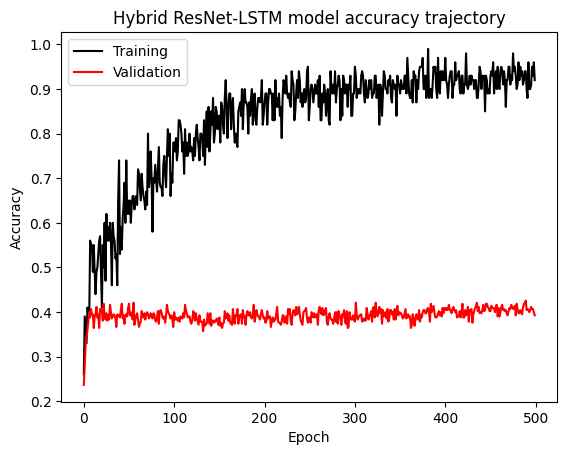

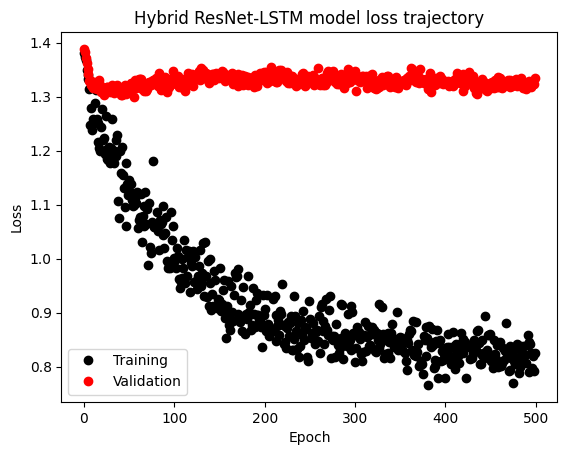

In [ ]:
plt.plot(np.arange(num_epochs),train_history_1,label='Training',color='black')
plt.plot(np.arange(num_epochs),val_history_1,label='Validation',color='red')
plt.title('Hybrid ResNet-LSTM model accuracy trajectory')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(np.arange(num_epochs),train_loss_hist_1,'o',label='Training',color='black')
plt.plot(np.arange(num_epochs),val_loss_hist_1,'o',label='Validation',color='red')
plt.title('Hybrid ResNet-LSTM model loss trajectory')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Part 2: Training and validating on preprocessed EEG data

In [ ]:
## Randomly split the train/validation dataset
ind_valid = np.random.choice(X_train_valid.shape[0], int(X_train_valid.shape[0]/5), replace=False)
ind_train = np.array(list(set(range(X_train_valid.shape[0])).difference(set(ind_valid))))
x_valid, y_valid = X_train_valid[ind_valid], y_train_valid[ind_valid]
x_train, y_train = X_train_valid[ind_train], y_train_valid[ind_train]
print('Training and Validation shapes before preprocessing: ')
print('X train: ', x_train.shape, ' Y train: ', y_train.shape)
print('X val: ', x_valid.shape, ' Y val', y_valid.shape)

# Preprocessing the dataset, may need to reload data at top
# pass only training data to train prep, val and test data to test prep

x_train,y_train = train_data_prep(x_train,y_train,2,2,True)
x_test, x_valid = test_data_prep(x_test), test_data_prep(x_valid)

x_train = torch.tensor(x_train).detach().float().to(device)
x_valid = torch.tensor(x_valid).detach().float().to(device)
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

# Converting the labels to categorical variables for multiclass classification
y_train, y_valid, y_test = torch.tensor(y_train).to(device), torch.tensor(y_valid).to(device), torch.tensor(y_test).to(device)
y_train = nn.functional.one_hot(y_train.long(), 4)
y_valid = nn.functional.one_hot(y_valid.long(), 4)
y_test = nn.functional.one_hot(y_test.long(), 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 2,3)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 2,3)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 2,3)
x_test = torch.tensor(x_test).detach().float().to(device)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Training and Validation shapes before preprocessing: 
X train:  (1692, 22, 1000)  Y train:  (1692,)
X val:  (423, 22, 1000)  Y val (423,)
Shape of X after trimming: (1692, 22, 800)
Shape of X after maxpooling: (1692, 22, 400)
Shape of X after averaging+noise and concatenating: (3384, 22, 400)
Shape of X after subsampling and concatenating: (6768, 22, 400)
Shape of Y: (6768,)
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of X after trimming: (423, 22, 800)
Shape of X after maxpooling: (423, 22, 400)
Shape of training set: torch.Size([6768, 22, 400])
Shape of validation set: torch.Size([423, 22, 400])
Shape of training labels: (6768,)
Shape of validation labels: (423,)
Shape of training labels after categorical conversion: torch.Size([6768, 4])
Shape of validation labels after categorical conversion: torch.Size([423, 4])
Shape of test labels after categorical conversion: torch.Size([443, 4])
Shape of training set after adding width info: torc

Build the model

In [ ]:
model2 = ResNetLSTM(img_channels=1, block=BasicBlock, num_classes=4, time_dim=int(x_train.size(3)), dropout=0.6).to(device)
print(model2)
total_params = sum(p.numel() for p in model2.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model2.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

ResNetLSTM(
  (conv1): Conv2d(1, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
  (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(48, 48, kernel_size=(22, 1), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ELU(alpha=1.0, inplace=True)
  (res1): BasicBlock(
    (conv1): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout2d(p=0.6, inplace=False)
    (elu): ELU(alpha=1.0, inplace=True)
    (conv2): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2): Dropout2d(p=0.6, inplace=False)
    (shortcut): Identity()
  )
  (res2): BasicBlock(
    (conv1):

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
# Choose Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
# Rename these lines between models
train_history_2, val_history_2 = np.array([]), np.array([])
train_loss_hist_2, val_loss_hist_2 = np.array([]), np.array([])

with TemporaryDirectory() as tempdir:
    save_folder = '/content/drive/MyDrive/C147_Final_Project/best_model_params'

    # Rename these lines between models
    best_model_params_path = os.path.join(save_folder, 'best_model2_params.pt')
    torch.save(model2.state_dict(), best_model_params_path)

    best_acc = 0.0
    bsz = 100
    num_epochs = 500
    iteration = 0
    total_it = num_epochs*int(x_train.shape[0]/bsz)
    for epoch_idx in tqdm(range(num_epochs)):
        # Set model to train mode - useful for layers such as BatchNorm or Dropout whose behaviors change between train/eval
        # Rename
        model2.train()
        train_count = 0
        train_correct_count = 0
        for i in range(int(x_train.shape[0]/bsz)):
            iteration+=1
            optimizer.zero_grad() # Zero gradients, since we don't want gradients to accumulate between batches - we apply an update for each batch
            train_x, train_y = sample(x_train, y_train, bsz)
            #Rename
            logits = model2(train_x) #bszx4x1x4

            logits = nn.functional.softmax(logits, dim=1)
            loss = criterion(logits.float(), train_y.float())

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                #y_hat = torch.mean(logits, dim = 2)
                y_hat = torch.argmax(logits, dim=1)
                train_correct_count = torch.sum(y_hat == torch.argmax(train_y, dim=1))
                train_count = train_x.size(0)
                train_count = float(train_count)
            #print(f'(Iteration {iteration}/{total_it})Training Accuracy: ', (train_correct_count/train_count).item(), '. Loss: ', loss.item())


        train_acc = train_correct_count / train_count

        #Rename
        model2.eval()
        val_count = 0
        val_correct_count = 0
        with torch.no_grad():
            val_x = x_valid
            val_y = y_valid
            #Rename
            logits = model2(val_x).detach()
            logits = nn.functional.softmax(logits)
            val_loss = criterion(logits.float(), val_y.float())
            with torch.no_grad():
                y_hat = torch.argmax(logits, dim=1)
                val_correct_count = torch.sum(y_hat == torch.argmax(val_y, dim=1))
                val_count = float(val_x.size(0))
        val_acc = val_correct_count / y_valid.shape[0]

        print(f'Epoch {epoch_idx+1} Finished!!!')
        print('Train acc: {:.3f}, Val acc: {:.3f}'.format(train_acc, val_acc))
        print('Train loss: {:.3f}, Val loss: {:.3f}'.format(loss, val_loss))

        #Rename
        train_history_2 = np.append(train_history_2, train_acc.item())
        val_history_2 = np.append(val_history_2, val_acc.item())
        train_loss_hist_2 = np.append(train_loss_hist_2, loss.item())
        val_loss_hist_2 = np.append(val_loss_hist_2, val_loss.item())

        if val_acc > best_acc:
            best_acc = val_acc
            #Rename
            torch.save(model2.state_dict(), best_model_params_path)

    print(f'Best val Acc: {best_acc:4f}')

  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-9-5e003a2a91dd>:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = nn.functional.softmax(logits)
  0%|          | 1/500 [00:10<1:27:21, 10.50s/it]

Epoch 1 Finished!!!
Train acc: 0.390, Val acc: 0.364
Train loss: 1.362, Val loss: 1.364


  0%|          | 2/500 [00:12<46:57,  5.66s/it]  

Epoch 2 Finished!!!
Train acc: 0.410, Val acc: 0.414
Train loss: 1.326, Val loss: 1.324


  1%|          | 3/500 [00:15<33:59,  4.10s/it]

Epoch 3 Finished!!!
Train acc: 0.410, Val acc: 0.409
Train loss: 1.311, Val loss: 1.313


  1%|          | 4/500 [00:17<27:57,  3.38s/it]

Epoch 4 Finished!!!
Train acc: 0.390, Val acc: 0.392
Train loss: 1.317, Val loss: 1.320


  1%|          | 5/500 [00:19<24:38,  2.99s/it]

Epoch 5 Finished!!!
Train acc: 0.510, Val acc: 0.442
Train loss: 1.242, Val loss: 1.281


  1%|          | 6/500 [00:21<22:37,  2.75s/it]

Epoch 6 Finished!!!
Train acc: 0.570, Val acc: 0.449
Train loss: 1.227, Val loss: 1.286


  1%|▏         | 7/500 [00:24<21:20,  2.60s/it]

Epoch 7 Finished!!!
Train acc: 0.550, Val acc: 0.452
Train loss: 1.237, Val loss: 1.277


  2%|▏         | 8/500 [00:26<20:50,  2.54s/it]

Epoch 8 Finished!!!
Train acc: 0.530, Val acc: 0.473
Train loss: 1.253, Val loss: 1.269


  2%|▏         | 9/500 [00:28<20:08,  2.46s/it]

Epoch 9 Finished!!!
Train acc: 0.500, Val acc: 0.473
Train loss: 1.271, Val loss: 1.262


  2%|▏         | 10/500 [00:31<19:46,  2.42s/it]

Epoch 10 Finished!!!
Train acc: 0.600, Val acc: 0.478
Train loss: 1.172, Val loss: 1.260


  2%|▏         | 11/500 [00:33<19:23,  2.38s/it]

Epoch 11 Finished!!!
Train acc: 0.570, Val acc: 0.456
Train loss: 1.184, Val loss: 1.272


  2%|▏         | 12/500 [00:35<19:08,  2.35s/it]

Epoch 12 Finished!!!
Train acc: 0.630, Val acc: 0.454
Train loss: 1.146, Val loss: 1.263


  3%|▎         | 13/500 [00:38<18:58,  2.34s/it]

Epoch 13 Finished!!!
Train acc: 0.530, Val acc: 0.456
Train loss: 1.198, Val loss: 1.263


  3%|▎         | 14/500 [00:40<18:51,  2.33s/it]

Epoch 14 Finished!!!
Train acc: 0.600, Val acc: 0.470
Train loss: 1.158, Val loss: 1.253


  3%|▎         | 15/500 [00:42<18:48,  2.33s/it]

Epoch 15 Finished!!!
Train acc: 0.660, Val acc: 0.485
Train loss: 1.123, Val loss: 1.252


  3%|▎         | 16/500 [00:45<18:43,  2.32s/it]

Epoch 16 Finished!!!
Train acc: 0.620, Val acc: 0.466
Train loss: 1.143, Val loss: 1.264


  3%|▎         | 17/500 [00:47<18:40,  2.32s/it]

Epoch 17 Finished!!!
Train acc: 0.570, Val acc: 0.466
Train loss: 1.166, Val loss: 1.258


  4%|▎         | 18/500 [00:49<18:38,  2.32s/it]

Epoch 18 Finished!!!
Train acc: 0.560, Val acc: 0.461
Train loss: 1.166, Val loss: 1.262


  4%|▍         | 19/500 [00:51<18:36,  2.32s/it]

Epoch 19 Finished!!!
Train acc: 0.560, Val acc: 0.475
Train loss: 1.196, Val loss: 1.253


  4%|▍         | 20/500 [00:54<18:36,  2.33s/it]

Epoch 20 Finished!!!
Train acc: 0.660, Val acc: 0.461
Train loss: 1.095, Val loss: 1.263


  4%|▍         | 21/500 [00:56<18:37,  2.33s/it]

Epoch 21 Finished!!!
Train acc: 0.520, Val acc: 0.454
Train loss: 1.219, Val loss: 1.270


  4%|▍         | 22/500 [00:58<18:35,  2.33s/it]

Epoch 22 Finished!!!
Train acc: 0.550, Val acc: 0.470
Train loss: 1.195, Val loss: 1.262


  5%|▍         | 23/500 [01:01<18:36,  2.34s/it]

Epoch 23 Finished!!!
Train acc: 0.630, Val acc: 0.487
Train loss: 1.124, Val loss: 1.247


  5%|▍         | 24/500 [01:03<18:34,  2.34s/it]

Epoch 24 Finished!!!
Train acc: 0.610, Val acc: 0.487
Train loss: 1.117, Val loss: 1.248


  5%|▌         | 25/500 [01:06<18:33,  2.34s/it]

Epoch 25 Finished!!!
Train acc: 0.650, Val acc: 0.459
Train loss: 1.102, Val loss: 1.261


  5%|▌         | 26/500 [01:08<18:34,  2.35s/it]

Epoch 26 Finished!!!
Train acc: 0.670, Val acc: 0.470
Train loss: 1.088, Val loss: 1.258


  5%|▌         | 27/500 [01:10<18:33,  2.35s/it]

Epoch 27 Finished!!!
Train acc: 0.630, Val acc: 0.473
Train loss: 1.110, Val loss: 1.255


  6%|▌         | 28/500 [01:13<18:35,  2.36s/it]

Epoch 28 Finished!!!
Train acc: 0.710, Val acc: 0.496
Train loss: 1.062, Val loss: 1.238


  6%|▌         | 29/500 [01:15<18:33,  2.36s/it]

Epoch 29 Finished!!!
Train acc: 0.580, Val acc: 0.473
Train loss: 1.155, Val loss: 1.248


  6%|▌         | 30/500 [01:17<18:32,  2.37s/it]

Epoch 30 Finished!!!
Train acc: 0.570, Val acc: 0.482
Train loss: 1.168, Val loss: 1.245


  6%|▌         | 31/500 [01:20<18:32,  2.37s/it]

Epoch 31 Finished!!!
Train acc: 0.660, Val acc: 0.475
Train loss: 1.072, Val loss: 1.252


  6%|▋         | 32/500 [01:22<18:32,  2.38s/it]

Epoch 32 Finished!!!
Train acc: 0.650, Val acc: 0.492
Train loss: 1.094, Val loss: 1.246


  7%|▋         | 33/500 [01:25<18:31,  2.38s/it]

Epoch 33 Finished!!!
Train acc: 0.650, Val acc: 0.482
Train loss: 1.110, Val loss: 1.243


  7%|▋         | 34/500 [01:27<18:30,  2.38s/it]

Epoch 34 Finished!!!
Train acc: 0.700, Val acc: 0.480
Train loss: 1.064, Val loss: 1.242


  7%|▋         | 35/500 [01:29<18:32,  2.39s/it]

Epoch 35 Finished!!!
Train acc: 0.590, Val acc: 0.501
Train loss: 1.142, Val loss: 1.240


  7%|▋         | 36/500 [01:32<18:30,  2.39s/it]

Epoch 36 Finished!!!
Train acc: 0.650, Val acc: 0.496
Train loss: 1.083, Val loss: 1.242


  7%|▋         | 37/500 [01:34<18:30,  2.40s/it]

Epoch 37 Finished!!!
Train acc: 0.720, Val acc: 0.461
Train loss: 1.021, Val loss: 1.266


  8%|▊         | 38/500 [01:37<18:28,  2.40s/it]

Epoch 38 Finished!!!
Train acc: 0.630, Val acc: 0.487
Train loss: 1.113, Val loss: 1.236


  8%|▊         | 39/500 [01:39<18:26,  2.40s/it]

Epoch 39 Finished!!!
Train acc: 0.760, Val acc: 0.478
Train loss: 1.010, Val loss: 1.237


  8%|▊         | 40/500 [01:41<18:23,  2.40s/it]

Epoch 40 Finished!!!
Train acc: 0.710, Val acc: 0.482
Train loss: 1.047, Val loss: 1.242


  8%|▊         | 41/500 [01:44<18:20,  2.40s/it]

Epoch 41 Finished!!!
Train acc: 0.700, Val acc: 0.492
Train loss: 1.036, Val loss: 1.234


  8%|▊         | 42/500 [01:46<18:17,  2.40s/it]

Epoch 42 Finished!!!
Train acc: 0.740, Val acc: 0.501
Train loss: 1.017, Val loss: 1.224


  9%|▊         | 43/500 [01:49<18:15,  2.40s/it]

Epoch 43 Finished!!!
Train acc: 0.740, Val acc: 0.513
Train loss: 1.021, Val loss: 1.216


  9%|▉         | 44/500 [01:51<18:10,  2.39s/it]

Epoch 44 Finished!!!
Train acc: 0.730, Val acc: 0.489
Train loss: 1.022, Val loss: 1.235


  9%|▉         | 45/500 [01:53<18:06,  2.39s/it]

Epoch 45 Finished!!!
Train acc: 0.780, Val acc: 0.506
Train loss: 0.983, Val loss: 1.221


  9%|▉         | 46/500 [01:56<18:01,  2.38s/it]

Epoch 46 Finished!!!
Train acc: 0.830, Val acc: 0.499
Train loss: 0.945, Val loss: 1.228


  9%|▉         | 47/500 [01:58<17:57,  2.38s/it]

Epoch 47 Finished!!!
Train acc: 0.790, Val acc: 0.487
Train loss: 0.979, Val loss: 1.239


 10%|▉         | 48/500 [02:00<17:54,  2.38s/it]

Epoch 48 Finished!!!
Train acc: 0.730, Val acc: 0.508
Train loss: 1.019, Val loss: 1.223


 10%|▉         | 49/500 [02:03<17:52,  2.38s/it]

Epoch 49 Finished!!!
Train acc: 0.770, Val acc: 0.522
Train loss: 0.988, Val loss: 1.216


 10%|█         | 50/500 [02:05<17:48,  2.37s/it]

Epoch 50 Finished!!!
Train acc: 0.810, Val acc: 0.494
Train loss: 0.947, Val loss: 1.230


 10%|█         | 51/500 [02:08<17:43,  2.37s/it]

Epoch 51 Finished!!!
Train acc: 0.830, Val acc: 0.518
Train loss: 0.939, Val loss: 1.213


 10%|█         | 52/500 [02:10<17:40,  2.37s/it]

Epoch 52 Finished!!!
Train acc: 0.800, Val acc: 0.492
Train loss: 0.970, Val loss: 1.240


 11%|█         | 53/500 [02:13<18:25,  2.47s/it]

Epoch 53 Finished!!!
Train acc: 0.810, Val acc: 0.501
Train loss: 0.945, Val loss: 1.226


 11%|█         | 54/500 [02:15<18:08,  2.44s/it]

Epoch 54 Finished!!!
Train acc: 0.760, Val acc: 0.501
Train loss: 0.984, Val loss: 1.230


 11%|█         | 55/500 [02:17<17:54,  2.41s/it]

Epoch 55 Finished!!!
Train acc: 0.820, Val acc: 0.494
Train loss: 0.953, Val loss: 1.231


 11%|█         | 56/500 [02:20<17:45,  2.40s/it]

Epoch 56 Finished!!!
Train acc: 0.790, Val acc: 0.485
Train loss: 0.969, Val loss: 1.237


 11%|█▏        | 57/500 [02:22<17:37,  2.39s/it]

Epoch 57 Finished!!!
Train acc: 0.810, Val acc: 0.513
Train loss: 0.945, Val loss: 1.221


 12%|█▏        | 58/500 [02:24<17:31,  2.38s/it]

Epoch 58 Finished!!!
Train acc: 0.760, Val acc: 0.508
Train loss: 0.993, Val loss: 1.224


 12%|█▏        | 59/500 [02:27<17:27,  2.38s/it]

Epoch 59 Finished!!!
Train acc: 0.820, Val acc: 0.504
Train loss: 0.940, Val loss: 1.233


 12%|█▏        | 60/500 [02:29<17:23,  2.37s/it]

Epoch 60 Finished!!!
Train acc: 0.820, Val acc: 0.522
Train loss: 0.951, Val loss: 1.213


 12%|█▏        | 61/500 [02:32<17:19,  2.37s/it]

Epoch 61 Finished!!!
Train acc: 0.800, Val acc: 0.508
Train loss: 0.959, Val loss: 1.218


 12%|█▏        | 62/500 [02:34<17:18,  2.37s/it]

Epoch 62 Finished!!!
Train acc: 0.820, Val acc: 0.532
Train loss: 0.928, Val loss: 1.214


 13%|█▎        | 63/500 [02:36<17:14,  2.37s/it]

Epoch 63 Finished!!!
Train acc: 0.740, Val acc: 0.515
Train loss: 1.009, Val loss: 1.215


 13%|█▎        | 64/500 [02:39<17:13,  2.37s/it]

Epoch 64 Finished!!!
Train acc: 0.830, Val acc: 0.518
Train loss: 0.927, Val loss: 1.218


 13%|█▎        | 65/500 [02:41<17:10,  2.37s/it]

Epoch 65 Finished!!!
Train acc: 0.800, Val acc: 0.508
Train loss: 0.952, Val loss: 1.220


 13%|█▎        | 66/500 [02:43<17:08,  2.37s/it]

Epoch 66 Finished!!!
Train acc: 0.810, Val acc: 0.492
Train loss: 0.946, Val loss: 1.236


 13%|█▎        | 67/500 [02:46<17:06,  2.37s/it]

Epoch 67 Finished!!!
Train acc: 0.910, Val acc: 0.494
Train loss: 0.851, Val loss: 1.232


 14%|█▎        | 68/500 [02:48<17:05,  2.37s/it]

Epoch 68 Finished!!!
Train acc: 0.810, Val acc: 0.513
Train loss: 0.939, Val loss: 1.222


 14%|█▍        | 69/500 [02:50<17:05,  2.38s/it]

Epoch 69 Finished!!!
Train acc: 0.850, Val acc: 0.511
Train loss: 0.917, Val loss: 1.227


 14%|█▍        | 70/500 [02:53<17:03,  2.38s/it]

Epoch 70 Finished!!!
Train acc: 0.820, Val acc: 0.501
Train loss: 0.948, Val loss: 1.229


 14%|█▍        | 71/500 [02:55<17:00,  2.38s/it]

Epoch 71 Finished!!!
Train acc: 0.880, Val acc: 0.496
Train loss: 0.879, Val loss: 1.232


 14%|█▍        | 72/500 [02:58<16:58,  2.38s/it]

Epoch 72 Finished!!!
Train acc: 0.820, Val acc: 0.508
Train loss: 0.934, Val loss: 1.227


 15%|█▍        | 73/500 [03:00<16:56,  2.38s/it]

Epoch 73 Finished!!!
Train acc: 0.870, Val acc: 0.530
Train loss: 0.885, Val loss: 1.207


 15%|█▍        | 74/500 [03:02<16:54,  2.38s/it]

Epoch 74 Finished!!!
Train acc: 0.850, Val acc: 0.504
Train loss: 0.920, Val loss: 1.222


 15%|█▌        | 75/500 [03:05<16:52,  2.38s/it]

Epoch 75 Finished!!!
Train acc: 0.840, Val acc: 0.501
Train loss: 0.902, Val loss: 1.230


 15%|█▌        | 76/500 [03:07<16:49,  2.38s/it]

Epoch 76 Finished!!!
Train acc: 0.850, Val acc: 0.499
Train loss: 0.891, Val loss: 1.228


 15%|█▌        | 77/500 [03:10<16:46,  2.38s/it]

Epoch 77 Finished!!!
Train acc: 0.800, Val acc: 0.499
Train loss: 0.941, Val loss: 1.226


 16%|█▌        | 78/500 [03:12<16:44,  2.38s/it]

Epoch 78 Finished!!!
Train acc: 0.790, Val acc: 0.504
Train loss: 0.945, Val loss: 1.227


 16%|█▌        | 79/500 [03:14<16:41,  2.38s/it]

Epoch 79 Finished!!!
Train acc: 0.820, Val acc: 0.511
Train loss: 0.932, Val loss: 1.220


 16%|█▌        | 80/500 [03:17<16:40,  2.38s/it]

Epoch 80 Finished!!!
Train acc: 0.880, Val acc: 0.492
Train loss: 0.890, Val loss: 1.234


 16%|█▌        | 81/500 [03:19<16:37,  2.38s/it]

Epoch 81 Finished!!!
Train acc: 0.870, Val acc: 0.499
Train loss: 0.888, Val loss: 1.226


 16%|█▋        | 82/500 [03:21<16:34,  2.38s/it]

Epoch 82 Finished!!!
Train acc: 0.890, Val acc: 0.499
Train loss: 0.862, Val loss: 1.228


 17%|█▋        | 83/500 [03:24<16:31,  2.38s/it]

Epoch 83 Finished!!!
Train acc: 0.910, Val acc: 0.522
Train loss: 0.850, Val loss: 1.218


 17%|█▋        | 84/500 [03:26<16:28,  2.38s/it]

Epoch 84 Finished!!!
Train acc: 0.870, Val acc: 0.504
Train loss: 0.886, Val loss: 1.223


 17%|█▋        | 85/500 [03:29<16:26,  2.38s/it]

Epoch 85 Finished!!!
Train acc: 0.900, Val acc: 0.489
Train loss: 0.864, Val loss: 1.241


 17%|█▋        | 86/500 [03:31<16:24,  2.38s/it]

Epoch 86 Finished!!!
Train acc: 0.830, Val acc: 0.506
Train loss: 0.932, Val loss: 1.223


 17%|█▋        | 87/500 [03:33<16:21,  2.38s/it]

Epoch 87 Finished!!!
Train acc: 0.870, Val acc: 0.515
Train loss: 0.891, Val loss: 1.222


 18%|█▊        | 88/500 [03:36<16:18,  2.38s/it]

Epoch 88 Finished!!!
Train acc: 0.820, Val acc: 0.480
Train loss: 0.938, Val loss: 1.246


 18%|█▊        | 89/500 [03:38<16:15,  2.37s/it]

Epoch 89 Finished!!!
Train acc: 0.840, Val acc: 0.506
Train loss: 0.908, Val loss: 1.227


 18%|█▊        | 90/500 [03:40<16:13,  2.37s/it]

Epoch 90 Finished!!!
Train acc: 0.890, Val acc: 0.511
Train loss: 0.879, Val loss: 1.218


 18%|█▊        | 91/500 [03:43<16:11,  2.38s/it]

Epoch 91 Finished!!!
Train acc: 0.900, Val acc: 0.508
Train loss: 0.867, Val loss: 1.226


 18%|█▊        | 92/500 [03:45<16:08,  2.37s/it]

Epoch 92 Finished!!!
Train acc: 0.900, Val acc: 0.513
Train loss: 0.856, Val loss: 1.225


 19%|█▊        | 93/500 [03:48<16:05,  2.37s/it]

Epoch 93 Finished!!!
Train acc: 0.890, Val acc: 0.489
Train loss: 0.869, Val loss: 1.229


 19%|█▉        | 94/500 [03:50<16:12,  2.39s/it]

Epoch 94 Finished!!!
Train acc: 0.940, Val acc: 0.492
Train loss: 0.817, Val loss: 1.237


 19%|█▉        | 95/500 [03:52<16:15,  2.41s/it]

Epoch 95 Finished!!!
Train acc: 0.940, Val acc: 0.522
Train loss: 0.821, Val loss: 1.214


 19%|█▉        | 96/500 [03:55<16:08,  2.40s/it]

Epoch 96 Finished!!!
Train acc: 0.910, Val acc: 0.506
Train loss: 0.846, Val loss: 1.223


 19%|█▉        | 97/500 [03:57<16:02,  2.39s/it]

Epoch 97 Finished!!!
Train acc: 0.920, Val acc: 0.496
Train loss: 0.831, Val loss: 1.233


 20%|█▉        | 98/500 [04:00<15:57,  2.38s/it]

Epoch 98 Finished!!!
Train acc: 0.920, Val acc: 0.494
Train loss: 0.831, Val loss: 1.232


 20%|█▉        | 99/500 [04:02<15:53,  2.38s/it]

Epoch 99 Finished!!!
Train acc: 0.880, Val acc: 0.492
Train loss: 0.876, Val loss: 1.239


 20%|██        | 100/500 [04:04<15:49,  2.37s/it]

Epoch 100 Finished!!!
Train acc: 0.960, Val acc: 0.496
Train loss: 0.795, Val loss: 1.226


 20%|██        | 101/500 [04:07<15:47,  2.37s/it]

Epoch 101 Finished!!!
Train acc: 0.860, Val acc: 0.499
Train loss: 0.887, Val loss: 1.229


 20%|██        | 102/500 [04:09<15:44,  2.37s/it]

Epoch 102 Finished!!!
Train acc: 0.920, Val acc: 0.496
Train loss: 0.834, Val loss: 1.232


 21%|██        | 103/500 [04:11<15:42,  2.37s/it]

Epoch 103 Finished!!!
Train acc: 0.900, Val acc: 0.494
Train loss: 0.865, Val loss: 1.230


 21%|██        | 104/500 [04:14<15:39,  2.37s/it]

Epoch 104 Finished!!!
Train acc: 0.950, Val acc: 0.499
Train loss: 0.808, Val loss: 1.234


 21%|██        | 105/500 [04:16<15:36,  2.37s/it]

Epoch 105 Finished!!!
Train acc: 0.870, Val acc: 0.506
Train loss: 0.880, Val loss: 1.222


 21%|██        | 106/500 [04:19<15:34,  2.37s/it]

Epoch 106 Finished!!!
Train acc: 0.850, Val acc: 0.499
Train loss: 0.910, Val loss: 1.231


 21%|██▏       | 107/500 [04:21<15:32,  2.37s/it]

Epoch 107 Finished!!!
Train acc: 0.940, Val acc: 0.504
Train loss: 0.823, Val loss: 1.231


 22%|██▏       | 108/500 [04:23<15:29,  2.37s/it]

Epoch 108 Finished!!!
Train acc: 0.880, Val acc: 0.504
Train loss: 0.872, Val loss: 1.229


 22%|██▏       | 109/500 [04:26<15:26,  2.37s/it]

Epoch 109 Finished!!!
Train acc: 0.930, Val acc: 0.499
Train loss: 0.817, Val loss: 1.230


 22%|██▏       | 110/500 [04:28<15:23,  2.37s/it]

Epoch 110 Finished!!!
Train acc: 0.860, Val acc: 0.482
Train loss: 0.890, Val loss: 1.229


 22%|██▏       | 111/500 [04:30<15:21,  2.37s/it]

Epoch 111 Finished!!!
Train acc: 0.930, Val acc: 0.492
Train loss: 0.821, Val loss: 1.232


 22%|██▏       | 112/500 [04:33<15:20,  2.37s/it]

Epoch 112 Finished!!!
Train acc: 0.890, Val acc: 0.492
Train loss: 0.863, Val loss: 1.234


 23%|██▎       | 113/500 [04:35<15:17,  2.37s/it]

Epoch 113 Finished!!!
Train acc: 0.910, Val acc: 0.525
Train loss: 0.843, Val loss: 1.215


 23%|██▎       | 114/500 [04:37<15:15,  2.37s/it]

Epoch 114 Finished!!!
Train acc: 0.880, Val acc: 0.513
Train loss: 0.867, Val loss: 1.231


 23%|██▎       | 115/500 [04:40<15:13,  2.37s/it]

Epoch 115 Finished!!!
Train acc: 0.890, Val acc: 0.492
Train loss: 0.861, Val loss: 1.236


 23%|██▎       | 116/500 [04:42<15:11,  2.37s/it]

Epoch 116 Finished!!!
Train acc: 0.960, Val acc: 0.501
Train loss: 0.795, Val loss: 1.227


 23%|██▎       | 117/500 [04:45<15:09,  2.37s/it]

Epoch 117 Finished!!!
Train acc: 0.890, Val acc: 0.506
Train loss: 0.864, Val loss: 1.221


 24%|██▎       | 118/500 [04:47<15:07,  2.37s/it]

Epoch 118 Finished!!!
Train acc: 0.870, Val acc: 0.496
Train loss: 0.871, Val loss: 1.235


 24%|██▍       | 119/500 [04:49<15:04,  2.37s/it]

Epoch 119 Finished!!!
Train acc: 0.910, Val acc: 0.489
Train loss: 0.846, Val loss: 1.238


 24%|██▍       | 120/500 [04:52<15:01,  2.37s/it]

Epoch 120 Finished!!!
Train acc: 0.860, Val acc: 0.522
Train loss: 0.893, Val loss: 1.215


 24%|██▍       | 121/500 [04:54<14:59,  2.37s/it]

Epoch 121 Finished!!!
Train acc: 0.910, Val acc: 0.513
Train loss: 0.840, Val loss: 1.212


 24%|██▍       | 122/500 [04:56<14:56,  2.37s/it]

Epoch 122 Finished!!!
Train acc: 0.930, Val acc: 0.525
Train loss: 0.817, Val loss: 1.208


 25%|██▍       | 123/500 [04:59<14:54,  2.37s/it]

Epoch 123 Finished!!!
Train acc: 0.890, Val acc: 0.499
Train loss: 0.862, Val loss: 1.229


 25%|██▍       | 124/500 [05:01<14:52,  2.37s/it]

Epoch 124 Finished!!!
Train acc: 0.890, Val acc: 0.511
Train loss: 0.859, Val loss: 1.225


 25%|██▌       | 125/500 [05:04<14:50,  2.37s/it]

Epoch 125 Finished!!!
Train acc: 0.900, Val acc: 0.513
Train loss: 0.852, Val loss: 1.222


 25%|██▌       | 126/500 [05:06<14:47,  2.37s/it]

Epoch 126 Finished!!!
Train acc: 0.870, Val acc: 0.499
Train loss: 0.886, Val loss: 1.228


 25%|██▌       | 127/500 [05:08<14:45,  2.37s/it]

Epoch 127 Finished!!!
Train acc: 0.830, Val acc: 0.487
Train loss: 0.919, Val loss: 1.237


 26%|██▌       | 128/500 [05:11<14:42,  2.37s/it]

Epoch 128 Finished!!!
Train acc: 0.900, Val acc: 0.485
Train loss: 0.850, Val loss: 1.240


 26%|██▌       | 129/500 [05:13<14:40,  2.37s/it]

Epoch 129 Finished!!!
Train acc: 0.870, Val acc: 0.489
Train loss: 0.873, Val loss: 1.237


 26%|██▌       | 130/500 [05:15<14:37,  2.37s/it]

Epoch 130 Finished!!!
Train acc: 0.900, Val acc: 0.522
Train loss: 0.846, Val loss: 1.217


 26%|██▌       | 131/500 [05:18<14:35,  2.37s/it]

Epoch 131 Finished!!!
Train acc: 0.960, Val acc: 0.494
Train loss: 0.794, Val loss: 1.230


 26%|██▋       | 132/500 [05:20<14:33,  2.37s/it]

Epoch 132 Finished!!!
Train acc: 0.920, Val acc: 0.513
Train loss: 0.833, Val loss: 1.225


 27%|██▋       | 133/500 [05:23<14:31,  2.37s/it]

Epoch 133 Finished!!!
Train acc: 0.900, Val acc: 0.501
Train loss: 0.849, Val loss: 1.232


 27%|██▋       | 134/500 [05:25<14:29,  2.38s/it]

Epoch 134 Finished!!!
Train acc: 0.880, Val acc: 0.504
Train loss: 0.873, Val loss: 1.228


 27%|██▋       | 135/500 [05:27<14:26,  2.37s/it]

Epoch 135 Finished!!!
Train acc: 0.890, Val acc: 0.499
Train loss: 0.864, Val loss: 1.234


 27%|██▋       | 136/500 [05:30<14:23,  2.37s/it]

Epoch 136 Finished!!!
Train acc: 0.940, Val acc: 0.499
Train loss: 0.806, Val loss: 1.228


 27%|██▋       | 137/500 [05:32<14:21,  2.37s/it]

Epoch 137 Finished!!!
Train acc: 0.910, Val acc: 0.501
Train loss: 0.849, Val loss: 1.234


 28%|██▊       | 138/500 [05:34<14:19,  2.37s/it]

Epoch 138 Finished!!!
Train acc: 0.910, Val acc: 0.487
Train loss: 0.844, Val loss: 1.236


 28%|██▊       | 139/500 [05:37<14:17,  2.37s/it]

Epoch 139 Finished!!!
Train acc: 0.920, Val acc: 0.494
Train loss: 0.831, Val loss: 1.232


 28%|██▊       | 140/500 [05:39<14:14,  2.37s/it]

Epoch 140 Finished!!!
Train acc: 0.880, Val acc: 0.482
Train loss: 0.871, Val loss: 1.237


 28%|██▊       | 141/500 [05:42<14:12,  2.37s/it]

Epoch 141 Finished!!!
Train acc: 0.880, Val acc: 0.518
Train loss: 0.862, Val loss: 1.218


 28%|██▊       | 142/500 [05:44<14:09,  2.37s/it]

Epoch 142 Finished!!!
Train acc: 0.900, Val acc: 0.492
Train loss: 0.839, Val loss: 1.234


 29%|██▊       | 143/500 [05:46<14:07,  2.37s/it]

Epoch 143 Finished!!!
Train acc: 0.930, Val acc: 0.494
Train loss: 0.817, Val loss: 1.227


 29%|██▉       | 144/500 [05:49<14:05,  2.38s/it]

Epoch 144 Finished!!!
Train acc: 0.910, Val acc: 0.504
Train loss: 0.844, Val loss: 1.237


 29%|██▉       | 145/500 [05:51<14:03,  2.38s/it]

Epoch 145 Finished!!!
Train acc: 0.900, Val acc: 0.513
Train loss: 0.856, Val loss: 1.216


 29%|██▉       | 146/500 [05:53<14:00,  2.37s/it]

Epoch 146 Finished!!!
Train acc: 0.920, Val acc: 0.489
Train loss: 0.829, Val loss: 1.238


 29%|██▉       | 147/500 [05:56<13:58,  2.37s/it]

Epoch 147 Finished!!!
Train acc: 0.940, Val acc: 0.511
Train loss: 0.814, Val loss: 1.223


 30%|██▉       | 148/500 [05:58<13:55,  2.37s/it]

Epoch 148 Finished!!!
Train acc: 0.930, Val acc: 0.508
Train loss: 0.820, Val loss: 1.224


 30%|██▉       | 149/500 [06:01<13:53,  2.37s/it]

Epoch 149 Finished!!!
Train acc: 0.900, Val acc: 0.496
Train loss: 0.839, Val loss: 1.231


 30%|███       | 150/500 [06:03<13:51,  2.37s/it]

Epoch 150 Finished!!!
Train acc: 0.930, Val acc: 0.520
Train loss: 0.821, Val loss: 1.217


 30%|███       | 151/500 [06:05<13:48,  2.37s/it]

Epoch 151 Finished!!!
Train acc: 0.840, Val acc: 0.496
Train loss: 0.905, Val loss: 1.233


 30%|███       | 152/500 [06:08<13:46,  2.37s/it]

Epoch 152 Finished!!!
Train acc: 0.890, Val acc: 0.487
Train loss: 0.862, Val loss: 1.242


 31%|███       | 153/500 [06:10<13:43,  2.37s/it]

Epoch 153 Finished!!!
Train acc: 0.870, Val acc: 0.515
Train loss: 0.874, Val loss: 1.220


 31%|███       | 154/500 [06:12<13:41,  2.37s/it]

Epoch 154 Finished!!!
Train acc: 0.960, Val acc: 0.478
Train loss: 0.793, Val loss: 1.251


 31%|███       | 155/500 [06:15<13:39,  2.38s/it]

Epoch 155 Finished!!!
Train acc: 0.920, Val acc: 0.470
Train loss: 0.827, Val loss: 1.252


 31%|███       | 156/500 [06:17<13:36,  2.37s/it]

Epoch 156 Finished!!!
Train acc: 0.950, Val acc: 0.518
Train loss: 0.799, Val loss: 1.220


 31%|███▏      | 157/500 [06:20<13:34,  2.37s/it]

Epoch 157 Finished!!!
Train acc: 0.900, Val acc: 0.496
Train loss: 0.848, Val loss: 1.234


 32%|███▏      | 158/500 [06:22<13:32,  2.38s/it]

Epoch 158 Finished!!!
Train acc: 0.890, Val acc: 0.489
Train loss: 0.854, Val loss: 1.243


 32%|███▏      | 159/500 [06:24<13:29,  2.37s/it]

Epoch 159 Finished!!!
Train acc: 0.890, Val acc: 0.487
Train loss: 0.851, Val loss: 1.242


 32%|███▏      | 160/500 [06:27<13:27,  2.38s/it]

Epoch 160 Finished!!!
Train acc: 0.920, Val acc: 0.501
Train loss: 0.830, Val loss: 1.230


 32%|███▏      | 161/500 [06:29<13:25,  2.38s/it]

Epoch 161 Finished!!!
Train acc: 0.860, Val acc: 0.499
Train loss: 0.886, Val loss: 1.236


 32%|███▏      | 162/500 [06:31<13:22,  2.38s/it]

Epoch 162 Finished!!!
Train acc: 0.930, Val acc: 0.487
Train loss: 0.817, Val loss: 1.242


 33%|███▎      | 163/500 [06:34<13:20,  2.38s/it]

Epoch 163 Finished!!!
Train acc: 0.930, Val acc: 0.515
Train loss: 0.824, Val loss: 1.225


 33%|███▎      | 164/500 [06:36<13:18,  2.38s/it]

Epoch 164 Finished!!!
Train acc: 0.940, Val acc: 0.492
Train loss: 0.809, Val loss: 1.235


 33%|███▎      | 165/500 [06:39<13:16,  2.38s/it]

Epoch 165 Finished!!!
Train acc: 0.890, Val acc: 0.489
Train loss: 0.863, Val loss: 1.240


 33%|███▎      | 166/500 [06:41<13:13,  2.38s/it]

Epoch 166 Finished!!!
Train acc: 0.880, Val acc: 0.501
Train loss: 0.865, Val loss: 1.233


 33%|███▎      | 167/500 [06:43<13:10,  2.37s/it]

Epoch 167 Finished!!!
Train acc: 0.830, Val acc: 0.501
Train loss: 0.920, Val loss: 1.238


 34%|███▎      | 168/500 [06:46<13:08,  2.37s/it]

Epoch 168 Finished!!!
Train acc: 0.920, Val acc: 0.511
Train loss: 0.826, Val loss: 1.228


 34%|███▍      | 169/500 [06:48<13:05,  2.37s/it]

Epoch 169 Finished!!!
Train acc: 0.960, Val acc: 0.508
Train loss: 0.794, Val loss: 1.227


 34%|███▍      | 170/500 [06:50<13:03,  2.37s/it]

Epoch 170 Finished!!!
Train acc: 0.900, Val acc: 0.501
Train loss: 0.848, Val loss: 1.226


 34%|███▍      | 171/500 [06:53<13:01,  2.38s/it]

Epoch 171 Finished!!!
Train acc: 0.920, Val acc: 0.522
Train loss: 0.830, Val loss: 1.211


 34%|███▍      | 172/500 [06:55<12:59,  2.38s/it]

Epoch 172 Finished!!!
Train acc: 0.910, Val acc: 0.506
Train loss: 0.841, Val loss: 1.220


 35%|███▍      | 173/500 [06:58<12:56,  2.37s/it]

Epoch 173 Finished!!!
Train acc: 0.940, Val acc: 0.501
Train loss: 0.808, Val loss: 1.229


 35%|███▍      | 174/500 [07:00<12:53,  2.37s/it]

Epoch 174 Finished!!!
Train acc: 0.960, Val acc: 0.522
Train loss: 0.789, Val loss: 1.222


 35%|███▌      | 175/500 [07:02<12:51,  2.37s/it]

Epoch 175 Finished!!!
Train acc: 0.880, Val acc: 0.515
Train loss: 0.866, Val loss: 1.224


 35%|███▌      | 176/500 [07:05<12:49,  2.37s/it]

Epoch 176 Finished!!!
Train acc: 0.970, Val acc: 0.501
Train loss: 0.780, Val loss: 1.229


 35%|███▌      | 177/500 [07:07<12:47,  2.38s/it]

Epoch 177 Finished!!!
Train acc: 0.940, Val acc: 0.504
Train loss: 0.811, Val loss: 1.226


 36%|███▌      | 178/500 [07:09<12:44,  2.37s/it]

Epoch 178 Finished!!!
Train acc: 0.920, Val acc: 0.513
Train loss: 0.837, Val loss: 1.225


 36%|███▌      | 179/500 [07:12<12:43,  2.38s/it]

Epoch 179 Finished!!!
Train acc: 0.940, Val acc: 0.534
Train loss: 0.809, Val loss: 1.206


 36%|███▌      | 180/500 [07:14<12:40,  2.38s/it]

Epoch 180 Finished!!!
Train acc: 0.920, Val acc: 0.508
Train loss: 0.824, Val loss: 1.217


 36%|███▌      | 181/500 [07:17<12:38,  2.38s/it]

Epoch 181 Finished!!!
Train acc: 0.920, Val acc: 0.530
Train loss: 0.826, Val loss: 1.214


 36%|███▋      | 182/500 [07:19<12:36,  2.38s/it]

Epoch 182 Finished!!!
Train acc: 0.920, Val acc: 0.489
Train loss: 0.832, Val loss: 1.240


 37%|███▋      | 183/500 [07:21<12:35,  2.38s/it]

Epoch 183 Finished!!!
Train acc: 0.900, Val acc: 0.541
Train loss: 0.848, Val loss: 1.209


 37%|███▋      | 184/500 [07:24<12:31,  2.38s/it]

Epoch 184 Finished!!!
Train acc: 0.880, Val acc: 0.520
Train loss: 0.865, Val loss: 1.222


 37%|███▋      | 185/500 [07:26<12:29,  2.38s/it]

Epoch 185 Finished!!!
Train acc: 0.940, Val acc: 0.518
Train loss: 0.808, Val loss: 1.219


 37%|███▋      | 186/500 [07:28<12:26,  2.38s/it]

Epoch 186 Finished!!!
Train acc: 0.930, Val acc: 0.530
Train loss: 0.818, Val loss: 1.213


 37%|███▋      | 187/500 [07:31<12:24,  2.38s/it]

Epoch 187 Finished!!!
Train acc: 0.920, Val acc: 0.506
Train loss: 0.827, Val loss: 1.221


 38%|███▊      | 188/500 [07:33<12:22,  2.38s/it]

Epoch 188 Finished!!!
Train acc: 0.910, Val acc: 0.475
Train loss: 0.838, Val loss: 1.250


 38%|███▊      | 189/500 [07:36<12:19,  2.38s/it]

Epoch 189 Finished!!!
Train acc: 0.910, Val acc: 0.501
Train loss: 0.836, Val loss: 1.227


 38%|███▊      | 190/500 [07:38<12:16,  2.38s/it]

Epoch 190 Finished!!!
Train acc: 0.930, Val acc: 0.511
Train loss: 0.811, Val loss: 1.225


 38%|███▊      | 191/500 [07:40<12:14,  2.38s/it]

Epoch 191 Finished!!!
Train acc: 0.920, Val acc: 0.473
Train loss: 0.831, Val loss: 1.245


 38%|███▊      | 192/500 [07:43<12:12,  2.38s/it]

Epoch 192 Finished!!!
Train acc: 0.900, Val acc: 0.494
Train loss: 0.845, Val loss: 1.233


 39%|███▊      | 193/500 [07:45<12:11,  2.38s/it]

Epoch 193 Finished!!!
Train acc: 0.920, Val acc: 0.506
Train loss: 0.823, Val loss: 1.222


 39%|███▉      | 194/500 [07:48<12:08,  2.38s/it]

Epoch 194 Finished!!!
Train acc: 0.930, Val acc: 0.504
Train loss: 0.824, Val loss: 1.229


 39%|███▉      | 195/500 [07:50<12:05,  2.38s/it]

Epoch 195 Finished!!!
Train acc: 0.930, Val acc: 0.492
Train loss: 0.815, Val loss: 1.234


 39%|███▉      | 196/500 [07:52<12:03,  2.38s/it]

Epoch 196 Finished!!!
Train acc: 0.880, Val acc: 0.506
Train loss: 0.871, Val loss: 1.229


 39%|███▉      | 197/500 [07:55<12:00,  2.38s/it]

Epoch 197 Finished!!!
Train acc: 0.890, Val acc: 0.480
Train loss: 0.854, Val loss: 1.240


 40%|███▉      | 198/500 [07:57<11:58,  2.38s/it]

Epoch 198 Finished!!!
Train acc: 0.920, Val acc: 0.501
Train loss: 0.834, Val loss: 1.230


 40%|███▉      | 199/500 [07:59<11:55,  2.38s/it]

Epoch 199 Finished!!!
Train acc: 0.900, Val acc: 0.499
Train loss: 0.841, Val loss: 1.232


 40%|████      | 200/500 [08:02<11:53,  2.38s/it]

Epoch 200 Finished!!!
Train acc: 0.960, Val acc: 0.504
Train loss: 0.793, Val loss: 1.228


 40%|████      | 201/500 [08:04<11:50,  2.38s/it]

Epoch 201 Finished!!!
Train acc: 0.880, Val acc: 0.508
Train loss: 0.866, Val loss: 1.226


 40%|████      | 202/500 [08:07<11:48,  2.38s/it]

Epoch 202 Finished!!!
Train acc: 0.910, Val acc: 0.511
Train loss: 0.833, Val loss: 1.220


 41%|████      | 203/500 [08:09<11:46,  2.38s/it]

Epoch 203 Finished!!!
Train acc: 0.950, Val acc: 0.487
Train loss: 0.804, Val loss: 1.242


 41%|████      | 204/500 [08:11<11:44,  2.38s/it]

Epoch 204 Finished!!!
Train acc: 0.930, Val acc: 0.492
Train loss: 0.815, Val loss: 1.237


 41%|████      | 205/500 [08:14<11:41,  2.38s/it]

Epoch 205 Finished!!!
Train acc: 0.940, Val acc: 0.513
Train loss: 0.811, Val loss: 1.231


 41%|████      | 206/500 [08:16<11:38,  2.38s/it]

Epoch 206 Finished!!!
Train acc: 0.890, Val acc: 0.501
Train loss: 0.857, Val loss: 1.237


 41%|████▏     | 207/500 [08:18<11:35,  2.38s/it]

Epoch 207 Finished!!!
Train acc: 0.930, Val acc: 0.492
Train loss: 0.821, Val loss: 1.236


 42%|████▏     | 208/500 [08:21<11:33,  2.38s/it]

Epoch 208 Finished!!!
Train acc: 0.900, Val acc: 0.513
Train loss: 0.846, Val loss: 1.216


 42%|████▏     | 209/500 [08:23<11:32,  2.38s/it]

Epoch 209 Finished!!!
Train acc: 0.920, Val acc: 0.527
Train loss: 0.829, Val loss: 1.212


 42%|████▏     | 210/500 [08:26<11:37,  2.41s/it]

Epoch 210 Finished!!!
Train acc: 0.940, Val acc: 0.496
Train loss: 0.807, Val loss: 1.235


 42%|████▏     | 211/500 [08:28<11:52,  2.46s/it]

Epoch 211 Finished!!!
Train acc: 0.950, Val acc: 0.518
Train loss: 0.815, Val loss: 1.221


 42%|████▏     | 212/500 [08:31<11:53,  2.48s/it]

Epoch 212 Finished!!!
Train acc: 0.940, Val acc: 0.518
Train loss: 0.811, Val loss: 1.216


 43%|████▎     | 213/500 [08:33<11:58,  2.50s/it]

Epoch 213 Finished!!!
Train acc: 0.930, Val acc: 0.485
Train loss: 0.824, Val loss: 1.251


 43%|████▎     | 214/500 [08:36<11:45,  2.47s/it]

Epoch 214 Finished!!!
Train acc: 0.940, Val acc: 0.525
Train loss: 0.807, Val loss: 1.214


 43%|████▎     | 215/500 [08:38<11:35,  2.44s/it]

Epoch 215 Finished!!!
Train acc: 0.920, Val acc: 0.485
Train loss: 0.828, Val loss: 1.244


 43%|████▎     | 216/500 [08:40<11:27,  2.42s/it]

Epoch 216 Finished!!!
Train acc: 0.920, Val acc: 0.504
Train loss: 0.828, Val loss: 1.227


 43%|████▎     | 217/500 [08:43<11:21,  2.41s/it]

Epoch 217 Finished!!!
Train acc: 0.910, Val acc: 0.511
Train loss: 0.846, Val loss: 1.225


 44%|████▎     | 218/500 [08:45<11:16,  2.40s/it]

Epoch 218 Finished!!!
Train acc: 0.890, Val acc: 0.499
Train loss: 0.858, Val loss: 1.224


 44%|████▍     | 219/500 [08:48<11:11,  2.39s/it]

Epoch 219 Finished!!!
Train acc: 0.920, Val acc: 0.508
Train loss: 0.826, Val loss: 1.228


 44%|████▍     | 220/500 [08:50<11:08,  2.39s/it]

Epoch 220 Finished!!!
Train acc: 0.890, Val acc: 0.534
Train loss: 0.856, Val loss: 1.207


 44%|████▍     | 221/500 [08:52<11:04,  2.38s/it]

Epoch 221 Finished!!!
Train acc: 0.910, Val acc: 0.501
Train loss: 0.837, Val loss: 1.231


 44%|████▍     | 222/500 [08:55<11:01,  2.38s/it]

Epoch 222 Finished!!!
Train acc: 0.950, Val acc: 0.501
Train loss: 0.802, Val loss: 1.231


 45%|████▍     | 223/500 [08:57<10:59,  2.38s/it]

Epoch 223 Finished!!!
Train acc: 0.940, Val acc: 0.501
Train loss: 0.809, Val loss: 1.233


 45%|████▍     | 224/500 [08:59<10:56,  2.38s/it]

Epoch 224 Finished!!!
Train acc: 0.940, Val acc: 0.494
Train loss: 0.808, Val loss: 1.231


 45%|████▌     | 225/500 [09:02<10:54,  2.38s/it]

Epoch 225 Finished!!!
Train acc: 0.960, Val acc: 0.489
Train loss: 0.798, Val loss: 1.234


 45%|████▌     | 226/500 [09:04<10:51,  2.38s/it]

Epoch 226 Finished!!!
Train acc: 0.940, Val acc: 0.513
Train loss: 0.803, Val loss: 1.222


 45%|████▌     | 227/500 [09:07<10:49,  2.38s/it]

Epoch 227 Finished!!!
Train acc: 0.890, Val acc: 0.504
Train loss: 0.857, Val loss: 1.230


 46%|████▌     | 228/500 [09:09<10:46,  2.38s/it]

Epoch 228 Finished!!!
Train acc: 0.930, Val acc: 0.494
Train loss: 0.827, Val loss: 1.242


 46%|████▌     | 229/500 [09:11<10:44,  2.38s/it]

Epoch 229 Finished!!!
Train acc: 0.960, Val acc: 0.494
Train loss: 0.789, Val loss: 1.237


 46%|████▌     | 230/500 [09:14<10:42,  2.38s/it]

Epoch 230 Finished!!!
Train acc: 0.920, Val acc: 0.506
Train loss: 0.829, Val loss: 1.229


 46%|████▌     | 231/500 [09:16<10:39,  2.38s/it]

Epoch 231 Finished!!!
Train acc: 0.890, Val acc: 0.480
Train loss: 0.856, Val loss: 1.244


 46%|████▋     | 232/500 [09:18<10:37,  2.38s/it]

Epoch 232 Finished!!!
Train acc: 0.940, Val acc: 0.511
Train loss: 0.809, Val loss: 1.224


 47%|████▋     | 233/500 [09:21<10:34,  2.38s/it]

Epoch 233 Finished!!!
Train acc: 0.950, Val acc: 0.494
Train loss: 0.803, Val loss: 1.232


 47%|████▋     | 234/500 [09:23<10:32,  2.38s/it]

Epoch 234 Finished!!!
Train acc: 0.900, Val acc: 0.499
Train loss: 0.840, Val loss: 1.235


 47%|████▋     | 235/500 [09:26<10:30,  2.38s/it]

Epoch 235 Finished!!!
Train acc: 0.910, Val acc: 0.494
Train loss: 0.841, Val loss: 1.243


 47%|████▋     | 236/500 [09:28<10:27,  2.38s/it]

Epoch 236 Finished!!!
Train acc: 0.960, Val acc: 0.499
Train loss: 0.787, Val loss: 1.228


 47%|████▋     | 237/500 [09:30<10:25,  2.38s/it]

Epoch 237 Finished!!!
Train acc: 0.910, Val acc: 0.494
Train loss: 0.835, Val loss: 1.236


 48%|████▊     | 238/500 [09:33<10:22,  2.38s/it]

Epoch 238 Finished!!!
Train acc: 0.960, Val acc: 0.522
Train loss: 0.793, Val loss: 1.220


 48%|████▊     | 239/500 [09:35<10:19,  2.38s/it]

Epoch 239 Finished!!!
Train acc: 0.910, Val acc: 0.499
Train loss: 0.835, Val loss: 1.233


 48%|████▊     | 240/500 [09:37<10:17,  2.38s/it]

Epoch 240 Finished!!!
Train acc: 0.920, Val acc: 0.508
Train loss: 0.828, Val loss: 1.223


 48%|████▊     | 241/500 [09:40<10:15,  2.38s/it]

Epoch 241 Finished!!!
Train acc: 0.930, Val acc: 0.506
Train loss: 0.818, Val loss: 1.228


 48%|████▊     | 242/500 [09:42<10:13,  2.38s/it]

Epoch 242 Finished!!!
Train acc: 0.940, Val acc: 0.504
Train loss: 0.811, Val loss: 1.231


 49%|████▊     | 243/500 [09:45<10:10,  2.38s/it]

Epoch 243 Finished!!!
Train acc: 0.910, Val acc: 0.496
Train loss: 0.827, Val loss: 1.234


 49%|████▉     | 244/500 [09:47<10:08,  2.38s/it]

Epoch 244 Finished!!!
Train acc: 0.940, Val acc: 0.508
Train loss: 0.806, Val loss: 1.231


 49%|████▉     | 245/500 [09:49<10:05,  2.38s/it]

Epoch 245 Finished!!!
Train acc: 0.950, Val acc: 0.508
Train loss: 0.804, Val loss: 1.230


 49%|████▉     | 246/500 [09:52<10:04,  2.38s/it]

Epoch 246 Finished!!!
Train acc: 0.940, Val acc: 0.520
Train loss: 0.809, Val loss: 1.217


 49%|████▉     | 247/500 [09:54<10:01,  2.38s/it]

Epoch 247 Finished!!!
Train acc: 0.930, Val acc: 0.480
Train loss: 0.817, Val loss: 1.243


 50%|████▉     | 248/500 [09:57<09:59,  2.38s/it]

Epoch 248 Finished!!!
Train acc: 0.920, Val acc: 0.494
Train loss: 0.827, Val loss: 1.231


 50%|████▉     | 249/500 [09:59<09:56,  2.38s/it]

Epoch 249 Finished!!!
Train acc: 0.940, Val acc: 0.508
Train loss: 0.805, Val loss: 1.231


 50%|█████     | 250/500 [10:01<09:53,  2.38s/it]

Epoch 250 Finished!!!
Train acc: 0.970, Val acc: 0.504
Train loss: 0.780, Val loss: 1.226


 50%|█████     | 251/500 [10:04<09:51,  2.38s/it]

Epoch 251 Finished!!!
Train acc: 0.940, Val acc: 0.501
Train loss: 0.807, Val loss: 1.232


 50%|█████     | 252/500 [10:06<09:49,  2.38s/it]

Epoch 252 Finished!!!
Train acc: 0.880, Val acc: 0.496
Train loss: 0.863, Val loss: 1.233


 51%|█████     | 253/500 [10:08<09:47,  2.38s/it]

Epoch 253 Finished!!!
Train acc: 0.970, Val acc: 0.492
Train loss: 0.777, Val loss: 1.235


 51%|█████     | 254/500 [10:11<09:49,  2.40s/it]

Epoch 254 Finished!!!
Train acc: 0.930, Val acc: 0.508
Train loss: 0.820, Val loss: 1.224


 51%|█████     | 255/500 [10:13<09:46,  2.40s/it]

Epoch 255 Finished!!!
Train acc: 0.920, Val acc: 0.511
Train loss: 0.830, Val loss: 1.224


 51%|█████     | 256/500 [10:16<09:42,  2.39s/it]

Epoch 256 Finished!!!
Train acc: 0.950, Val acc: 0.520
Train loss: 0.797, Val loss: 1.219


 51%|█████▏    | 257/500 [10:18<09:40,  2.39s/it]

Epoch 257 Finished!!!
Train acc: 0.940, Val acc: 0.494
Train loss: 0.805, Val loss: 1.245


 52%|█████▏    | 258/500 [10:20<09:37,  2.38s/it]

Epoch 258 Finished!!!
Train acc: 0.960, Val acc: 0.501
Train loss: 0.791, Val loss: 1.232


 52%|█████▏    | 259/500 [10:23<09:34,  2.38s/it]

Epoch 259 Finished!!!
Train acc: 0.980, Val acc: 0.504
Train loss: 0.767, Val loss: 1.230


 52%|█████▏    | 260/500 [10:25<09:31,  2.38s/it]

Epoch 260 Finished!!!
Train acc: 0.880, Val acc: 0.515
Train loss: 0.860, Val loss: 1.222


 52%|█████▏    | 261/500 [10:28<09:28,  2.38s/it]

Epoch 261 Finished!!!
Train acc: 0.930, Val acc: 0.499
Train loss: 0.815, Val loss: 1.229


 52%|█████▏    | 262/500 [10:30<09:26,  2.38s/it]

Epoch 262 Finished!!!
Train acc: 0.930, Val acc: 0.511
Train loss: 0.815, Val loss: 1.226


 53%|█████▎    | 263/500 [10:32<09:23,  2.38s/it]

Epoch 263 Finished!!!
Train acc: 0.880, Val acc: 0.513
Train loss: 0.868, Val loss: 1.231


 53%|█████▎    | 264/500 [10:35<09:21,  2.38s/it]

Epoch 264 Finished!!!
Train acc: 0.960, Val acc: 0.496
Train loss: 0.789, Val loss: 1.232


 53%|█████▎    | 265/500 [10:37<09:18,  2.38s/it]

Epoch 265 Finished!!!
Train acc: 0.960, Val acc: 0.501
Train loss: 0.795, Val loss: 1.230


 53%|█████▎    | 266/500 [10:39<09:15,  2.38s/it]

Epoch 266 Finished!!!
Train acc: 0.930, Val acc: 0.494
Train loss: 0.822, Val loss: 1.232


 53%|█████▎    | 267/500 [10:42<09:13,  2.38s/it]

Epoch 267 Finished!!!
Train acc: 0.920, Val acc: 0.482
Train loss: 0.824, Val loss: 1.246


 54%|█████▎    | 268/500 [10:44<09:11,  2.38s/it]

Epoch 268 Finished!!!
Train acc: 0.910, Val acc: 0.492
Train loss: 0.840, Val loss: 1.241


 54%|█████▍    | 269/500 [10:47<09:08,  2.38s/it]

Epoch 269 Finished!!!
Train acc: 0.920, Val acc: 0.501
Train loss: 0.829, Val loss: 1.232


 54%|█████▍    | 270/500 [10:49<09:06,  2.38s/it]

Epoch 270 Finished!!!
Train acc: 0.940, Val acc: 0.492
Train loss: 0.808, Val loss: 1.240


 54%|█████▍    | 271/500 [10:51<09:04,  2.38s/it]

Epoch 271 Finished!!!
Train acc: 0.950, Val acc: 0.496
Train loss: 0.800, Val loss: 1.239


 54%|█████▍    | 272/500 [10:54<09:02,  2.38s/it]

Epoch 272 Finished!!!
Train acc: 0.900, Val acc: 0.511
Train loss: 0.848, Val loss: 1.226


 55%|█████▍    | 273/500 [10:56<08:59,  2.38s/it]

Epoch 273 Finished!!!
Train acc: 0.940, Val acc: 0.482
Train loss: 0.809, Val loss: 1.239


 55%|█████▍    | 274/500 [10:58<08:57,  2.38s/it]

Epoch 274 Finished!!!
Train acc: 0.950, Val acc: 0.494
Train loss: 0.802, Val loss: 1.233


 55%|█████▌    | 275/500 [11:01<08:54,  2.38s/it]

Epoch 275 Finished!!!
Train acc: 0.940, Val acc: 0.487
Train loss: 0.807, Val loss: 1.240


 55%|█████▌    | 276/500 [11:03<08:52,  2.38s/it]

Epoch 276 Finished!!!
Train acc: 0.960, Val acc: 0.489
Train loss: 0.787, Val loss: 1.239


 55%|█████▌    | 277/500 [11:06<08:49,  2.38s/it]

Epoch 277 Finished!!!
Train acc: 0.960, Val acc: 0.506
Train loss: 0.786, Val loss: 1.238


 56%|█████▌    | 278/500 [11:08<08:48,  2.38s/it]

Epoch 278 Finished!!!
Train acc: 0.930, Val acc: 0.487
Train loss: 0.816, Val loss: 1.240


 56%|█████▌    | 279/500 [11:10<08:45,  2.38s/it]

Epoch 279 Finished!!!
Train acc: 0.910, Val acc: 0.494
Train loss: 0.833, Val loss: 1.235


 56%|█████▌    | 280/500 [11:13<08:43,  2.38s/it]

Epoch 280 Finished!!!
Train acc: 0.960, Val acc: 0.494
Train loss: 0.785, Val loss: 1.237


 56%|█████▌    | 281/500 [11:15<08:40,  2.38s/it]

Epoch 281 Finished!!!
Train acc: 0.930, Val acc: 0.492
Train loss: 0.816, Val loss: 1.238


 56%|█████▋    | 282/500 [11:17<08:38,  2.38s/it]

Epoch 282 Finished!!!
Train acc: 0.910, Val acc: 0.470
Train loss: 0.846, Val loss: 1.258


 57%|█████▋    | 283/500 [11:20<08:35,  2.38s/it]

Epoch 283 Finished!!!
Train acc: 0.900, Val acc: 0.496
Train loss: 0.850, Val loss: 1.237


 57%|█████▋    | 284/500 [11:22<08:33,  2.38s/it]

Epoch 284 Finished!!!
Train acc: 0.970, Val acc: 0.480
Train loss: 0.783, Val loss: 1.246


 57%|█████▋    | 285/500 [11:25<08:31,  2.38s/it]

Epoch 285 Finished!!!
Train acc: 0.950, Val acc: 0.487
Train loss: 0.798, Val loss: 1.246


 57%|█████▋    | 286/500 [11:27<08:28,  2.38s/it]

Epoch 286 Finished!!!
Train acc: 0.940, Val acc: 0.487
Train loss: 0.807, Val loss: 1.235


 57%|█████▋    | 287/500 [11:29<08:26,  2.38s/it]

Epoch 287 Finished!!!
Train acc: 0.950, Val acc: 0.513
Train loss: 0.806, Val loss: 1.218


 58%|█████▊    | 288/500 [11:32<08:23,  2.38s/it]

Epoch 288 Finished!!!
Train acc: 0.860, Val acc: 0.499
Train loss: 0.883, Val loss: 1.230


 58%|█████▊    | 289/500 [11:34<08:21,  2.38s/it]

Epoch 289 Finished!!!
Train acc: 0.920, Val acc: 0.515
Train loss: 0.829, Val loss: 1.222


 58%|█████▊    | 290/500 [11:36<08:19,  2.38s/it]

Epoch 290 Finished!!!
Train acc: 0.930, Val acc: 0.496
Train loss: 0.812, Val loss: 1.231


 58%|█████▊    | 291/500 [11:39<08:16,  2.38s/it]

Epoch 291 Finished!!!
Train acc: 0.980, Val acc: 0.506
Train loss: 0.772, Val loss: 1.227


 58%|█████▊    | 292/500 [11:41<08:14,  2.38s/it]

Epoch 292 Finished!!!
Train acc: 0.920, Val acc: 0.485
Train loss: 0.827, Val loss: 1.240


 59%|█████▊    | 293/500 [11:44<08:11,  2.38s/it]

Epoch 293 Finished!!!
Train acc: 0.930, Val acc: 0.480
Train loss: 0.818, Val loss: 1.237


 59%|█████▉    | 294/500 [11:46<08:09,  2.38s/it]

Epoch 294 Finished!!!
Train acc: 0.980, Val acc: 0.487
Train loss: 0.767, Val loss: 1.246


 59%|█████▉    | 295/500 [11:48<08:07,  2.38s/it]

Epoch 295 Finished!!!
Train acc: 0.950, Val acc: 0.489
Train loss: 0.797, Val loss: 1.238


 59%|█████▉    | 296/500 [11:51<08:04,  2.38s/it]

Epoch 296 Finished!!!
Train acc: 0.930, Val acc: 0.492
Train loss: 0.821, Val loss: 1.240


 59%|█████▉    | 297/500 [11:53<08:02,  2.38s/it]

Epoch 297 Finished!!!
Train acc: 0.960, Val acc: 0.508
Train loss: 0.794, Val loss: 1.228


 60%|█████▉    | 298/500 [11:55<07:59,  2.38s/it]

Epoch 298 Finished!!!
Train acc: 0.930, Val acc: 0.487
Train loss: 0.817, Val loss: 1.234


 60%|█████▉    | 299/500 [11:58<07:57,  2.38s/it]

Epoch 299 Finished!!!
Train acc: 0.920, Val acc: 0.496
Train loss: 0.830, Val loss: 1.241


 60%|██████    | 300/500 [12:00<07:55,  2.38s/it]

Epoch 300 Finished!!!
Train acc: 0.950, Val acc: 0.480
Train loss: 0.798, Val loss: 1.245


 60%|██████    | 301/500 [12:03<07:53,  2.38s/it]

Epoch 301 Finished!!!
Train acc: 0.930, Val acc: 0.485
Train loss: 0.814, Val loss: 1.248


 60%|██████    | 302/500 [12:05<07:50,  2.38s/it]

Epoch 302 Finished!!!
Train acc: 0.940, Val acc: 0.482
Train loss: 0.803, Val loss: 1.243


 61%|██████    | 303/500 [12:07<07:48,  2.38s/it]

Epoch 303 Finished!!!
Train acc: 0.910, Val acc: 0.501
Train loss: 0.836, Val loss: 1.228


 61%|██████    | 304/500 [12:10<07:45,  2.38s/it]

Epoch 304 Finished!!!
Train acc: 0.980, Val acc: 0.515
Train loss: 0.772, Val loss: 1.222


 61%|██████    | 305/500 [12:12<07:43,  2.38s/it]

Epoch 305 Finished!!!
Train acc: 0.970, Val acc: 0.504
Train loss: 0.777, Val loss: 1.232


 61%|██████    | 306/500 [12:14<07:41,  2.38s/it]

Epoch 306 Finished!!!
Train acc: 0.960, Val acc: 0.501
Train loss: 0.788, Val loss: 1.228


 61%|██████▏   | 307/500 [12:17<07:38,  2.38s/it]

Epoch 307 Finished!!!
Train acc: 0.920, Val acc: 0.511
Train loss: 0.825, Val loss: 1.228


 62%|██████▏   | 308/500 [12:19<07:36,  2.38s/it]

Epoch 308 Finished!!!
Train acc: 0.950, Val acc: 0.506
Train loss: 0.794, Val loss: 1.226


 62%|██████▏   | 309/500 [12:22<07:33,  2.37s/it]

Epoch 309 Finished!!!
Train acc: 0.930, Val acc: 0.504
Train loss: 0.814, Val loss: 1.228


 62%|██████▏   | 310/500 [12:24<07:31,  2.38s/it]

Epoch 310 Finished!!!
Train acc: 0.940, Val acc: 0.496
Train loss: 0.814, Val loss: 1.236


 62%|██████▏   | 311/500 [12:26<07:29,  2.38s/it]

Epoch 311 Finished!!!
Train acc: 0.950, Val acc: 0.489
Train loss: 0.796, Val loss: 1.237


 62%|██████▏   | 312/500 [12:29<07:26,  2.38s/it]

Epoch 312 Finished!!!
Train acc: 0.910, Val acc: 0.508
Train loss: 0.833, Val loss: 1.231


 63%|██████▎   | 313/500 [12:31<07:24,  2.38s/it]

Epoch 313 Finished!!!
Train acc: 0.940, Val acc: 0.506
Train loss: 0.811, Val loss: 1.231


 63%|██████▎   | 314/500 [12:33<07:21,  2.38s/it]

Epoch 314 Finished!!!
Train acc: 0.930, Val acc: 0.506
Train loss: 0.826, Val loss: 1.231


 63%|██████▎   | 315/500 [12:36<07:19,  2.38s/it]

Epoch 315 Finished!!!
Train acc: 0.960, Val acc: 0.492
Train loss: 0.790, Val loss: 1.238


 63%|██████▎   | 316/500 [12:38<07:17,  2.38s/it]

Epoch 316 Finished!!!
Train acc: 0.940, Val acc: 0.504
Train loss: 0.804, Val loss: 1.231


 63%|██████▎   | 317/500 [12:41<07:14,  2.38s/it]

Epoch 317 Finished!!!
Train acc: 0.950, Val acc: 0.496
Train loss: 0.797, Val loss: 1.233


 64%|██████▎   | 318/500 [12:43<07:12,  2.38s/it]

Epoch 318 Finished!!!
Train acc: 0.900, Val acc: 0.501
Train loss: 0.844, Val loss: 1.227


 64%|██████▍   | 319/500 [12:45<07:10,  2.38s/it]

Epoch 319 Finished!!!
Train acc: 0.940, Val acc: 0.496
Train loss: 0.805, Val loss: 1.236


 64%|██████▍   | 320/500 [12:48<07:07,  2.38s/it]

Epoch 320 Finished!!!
Train acc: 0.940, Val acc: 0.499
Train loss: 0.813, Val loss: 1.235


 64%|██████▍   | 321/500 [12:50<07:05,  2.38s/it]

Epoch 321 Finished!!!
Train acc: 0.930, Val acc: 0.485
Train loss: 0.815, Val loss: 1.243


 64%|██████▍   | 322/500 [12:53<07:06,  2.40s/it]

Epoch 322 Finished!!!
Train acc: 0.900, Val acc: 0.504
Train loss: 0.845, Val loss: 1.234


 65%|██████▍   | 323/500 [12:55<07:04,  2.40s/it]

Epoch 323 Finished!!!
Train acc: 0.940, Val acc: 0.515
Train loss: 0.810, Val loss: 1.222


 65%|██████▍   | 324/500 [12:57<07:00,  2.39s/it]

Epoch 324 Finished!!!
Train acc: 0.960, Val acc: 0.489
Train loss: 0.787, Val loss: 1.235


 65%|██████▌   | 325/500 [13:00<06:57,  2.39s/it]

Epoch 325 Finished!!!
Train acc: 0.960, Val acc: 0.489
Train loss: 0.787, Val loss: 1.237


 65%|██████▌   | 326/500 [13:02<06:54,  2.38s/it]

Epoch 326 Finished!!!
Train acc: 0.870, Val acc: 0.482
Train loss: 0.880, Val loss: 1.244


 65%|██████▌   | 327/500 [13:04<06:52,  2.38s/it]

Epoch 327 Finished!!!
Train acc: 0.920, Val acc: 0.470
Train loss: 0.821, Val loss: 1.252


 66%|██████▌   | 328/500 [13:07<06:49,  2.38s/it]

Epoch 328 Finished!!!
Train acc: 0.870, Val acc: 0.499
Train loss: 0.875, Val loss: 1.231


 66%|██████▌   | 329/500 [13:09<06:46,  2.38s/it]

Epoch 329 Finished!!!
Train acc: 0.920, Val acc: 0.518
Train loss: 0.826, Val loss: 1.217


 66%|██████▌   | 330/500 [13:12<06:43,  2.38s/it]

Epoch 330 Finished!!!
Train acc: 0.950, Val acc: 0.482
Train loss: 0.801, Val loss: 1.243


 66%|██████▌   | 331/500 [13:14<06:41,  2.38s/it]

Epoch 331 Finished!!!
Train acc: 0.940, Val acc: 0.522
Train loss: 0.803, Val loss: 1.214


 66%|██████▋   | 332/500 [13:16<06:39,  2.38s/it]

Epoch 332 Finished!!!
Train acc: 0.930, Val acc: 0.480
Train loss: 0.818, Val loss: 1.244


 67%|██████▋   | 333/500 [13:19<06:36,  2.38s/it]

Epoch 333 Finished!!!
Train acc: 0.990, Val acc: 0.492
Train loss: 0.757, Val loss: 1.237


 67%|██████▋   | 334/500 [13:21<06:34,  2.38s/it]

Epoch 334 Finished!!!
Train acc: 0.930, Val acc: 0.511
Train loss: 0.815, Val loss: 1.219


 67%|██████▋   | 335/500 [13:23<06:32,  2.38s/it]

Epoch 335 Finished!!!
Train acc: 0.930, Val acc: 0.499
Train loss: 0.819, Val loss: 1.236


 67%|██████▋   | 336/500 [13:26<06:29,  2.38s/it]

Epoch 336 Finished!!!
Train acc: 0.920, Val acc: 0.499
Train loss: 0.827, Val loss: 1.233


 67%|██████▋   | 337/500 [13:28<06:27,  2.38s/it]

Epoch 337 Finished!!!
Train acc: 0.980, Val acc: 0.501
Train loss: 0.770, Val loss: 1.233


 68%|██████▊   | 338/500 [13:31<06:25,  2.38s/it]

Epoch 338 Finished!!!
Train acc: 0.930, Val acc: 0.478
Train loss: 0.823, Val loss: 1.259


 68%|██████▊   | 339/500 [13:33<06:22,  2.38s/it]

Epoch 339 Finished!!!
Train acc: 0.920, Val acc: 0.499
Train loss: 0.825, Val loss: 1.232


 68%|██████▊   | 340/500 [13:35<06:20,  2.38s/it]

Epoch 340 Finished!!!
Train acc: 0.910, Val acc: 0.482
Train loss: 0.833, Val loss: 1.245


 68%|██████▊   | 341/500 [13:38<06:17,  2.37s/it]

Epoch 341 Finished!!!
Train acc: 0.920, Val acc: 0.470
Train loss: 0.825, Val loss: 1.252


 68%|██████▊   | 342/500 [13:40<06:15,  2.38s/it]

Epoch 342 Finished!!!
Train acc: 0.930, Val acc: 0.485
Train loss: 0.819, Val loss: 1.244


 69%|██████▊   | 343/500 [13:42<06:13,  2.38s/it]

Epoch 343 Finished!!!
Train acc: 0.960, Val acc: 0.494
Train loss: 0.789, Val loss: 1.235


 69%|██████▉   | 344/500 [13:45<06:10,  2.38s/it]

Epoch 344 Finished!!!
Train acc: 0.920, Val acc: 0.485
Train loss: 0.823, Val loss: 1.240


 69%|██████▉   | 345/500 [13:47<06:08,  2.38s/it]

Epoch 345 Finished!!!
Train acc: 0.940, Val acc: 0.501
Train loss: 0.807, Val loss: 1.234


 69%|██████▉   | 346/500 [13:50<06:05,  2.38s/it]

Epoch 346 Finished!!!
Train acc: 0.890, Val acc: 0.487
Train loss: 0.852, Val loss: 1.240


 69%|██████▉   | 347/500 [13:52<06:04,  2.38s/it]

Epoch 347 Finished!!!
Train acc: 0.950, Val acc: 0.482
Train loss: 0.795, Val loss: 1.241


 70%|██████▉   | 348/500 [13:54<06:02,  2.38s/it]

Epoch 348 Finished!!!
Train acc: 0.950, Val acc: 0.501
Train loss: 0.796, Val loss: 1.229


 70%|██████▉   | 349/500 [13:57<06:00,  2.38s/it]

Epoch 349 Finished!!!
Train acc: 0.910, Val acc: 0.489
Train loss: 0.836, Val loss: 1.235


 70%|███████   | 350/500 [13:59<05:57,  2.38s/it]

Epoch 350 Finished!!!
Train acc: 0.950, Val acc: 0.494
Train loss: 0.796, Val loss: 1.240


 70%|███████   | 351/500 [14:02<05:54,  2.38s/it]

Epoch 351 Finished!!!
Train acc: 0.970, Val acc: 0.494
Train loss: 0.779, Val loss: 1.236


 70%|███████   | 352/500 [14:04<05:51,  2.38s/it]

Epoch 352 Finished!!!
Train acc: 0.960, Val acc: 0.518
Train loss: 0.792, Val loss: 1.223


 71%|███████   | 353/500 [14:06<05:49,  2.38s/it]

Epoch 353 Finished!!!
Train acc: 0.970, Val acc: 0.520
Train loss: 0.780, Val loss: 1.226


 71%|███████   | 354/500 [14:09<05:47,  2.38s/it]

Epoch 354 Finished!!!
Train acc: 0.930, Val acc: 0.506
Train loss: 0.818, Val loss: 1.229


 71%|███████   | 355/500 [14:11<05:44,  2.38s/it]

Epoch 355 Finished!!!
Train acc: 0.940, Val acc: 0.508
Train loss: 0.808, Val loss: 1.225


 71%|███████   | 356/500 [14:13<05:42,  2.38s/it]

Epoch 356 Finished!!!
Train acc: 0.940, Val acc: 0.504
Train loss: 0.803, Val loss: 1.232


 71%|███████▏  | 357/500 [14:16<05:39,  2.38s/it]

Epoch 357 Finished!!!
Train acc: 0.900, Val acc: 0.482
Train loss: 0.846, Val loss: 1.242


 72%|███████▏  | 358/500 [14:18<05:37,  2.38s/it]

Epoch 358 Finished!!!
Train acc: 0.920, Val acc: 0.504
Train loss: 0.824, Val loss: 1.225


 72%|███████▏  | 359/500 [14:21<05:35,  2.38s/it]

Epoch 359 Finished!!!
Train acc: 0.930, Val acc: 0.494
Train loss: 0.813, Val loss: 1.228


 72%|███████▏  | 360/500 [14:23<05:32,  2.38s/it]

Epoch 360 Finished!!!
Train acc: 0.890, Val acc: 0.478
Train loss: 0.859, Val loss: 1.246


 72%|███████▏  | 361/500 [14:25<05:30,  2.38s/it]

Epoch 361 Finished!!!
Train acc: 0.960, Val acc: 0.511
Train loss: 0.794, Val loss: 1.222


 72%|███████▏  | 362/500 [14:28<05:27,  2.38s/it]

Epoch 362 Finished!!!
Train acc: 0.880, Val acc: 0.494
Train loss: 0.864, Val loss: 1.237


 73%|███████▎  | 363/500 [14:30<05:25,  2.38s/it]

Epoch 363 Finished!!!
Train acc: 0.940, Val acc: 0.506
Train loss: 0.808, Val loss: 1.228


 73%|███████▎  | 364/500 [14:32<05:23,  2.38s/it]

Epoch 364 Finished!!!
Train acc: 0.910, Val acc: 0.501
Train loss: 0.833, Val loss: 1.230


 73%|███████▎  | 365/500 [14:35<05:20,  2.38s/it]

Epoch 365 Finished!!!
Train acc: 0.940, Val acc: 0.485
Train loss: 0.804, Val loss: 1.240


 73%|███████▎  | 366/500 [14:37<05:18,  2.37s/it]

Epoch 366 Finished!!!
Train acc: 0.970, Val acc: 0.487
Train loss: 0.776, Val loss: 1.238


 73%|███████▎  | 367/500 [14:40<05:15,  2.38s/it]

Epoch 367 Finished!!!
Train acc: 0.970, Val acc: 0.487
Train loss: 0.777, Val loss: 1.243


 74%|███████▎  | 368/500 [14:42<05:13,  2.38s/it]

Epoch 368 Finished!!!
Train acc: 0.900, Val acc: 0.487
Train loss: 0.842, Val loss: 1.233


 74%|███████▍  | 369/500 [14:44<05:11,  2.38s/it]

Epoch 369 Finished!!!
Train acc: 0.960, Val acc: 0.485
Train loss: 0.784, Val loss: 1.238


 74%|███████▍  | 370/500 [14:47<05:09,  2.38s/it]

Epoch 370 Finished!!!
Train acc: 0.970, Val acc: 0.492
Train loss: 0.774, Val loss: 1.233


 74%|███████▍  | 371/500 [14:49<05:06,  2.38s/it]

Epoch 371 Finished!!!
Train acc: 0.940, Val acc: 0.485
Train loss: 0.805, Val loss: 1.234


 74%|███████▍  | 372/500 [14:51<05:04,  2.38s/it]

Epoch 372 Finished!!!
Train acc: 0.900, Val acc: 0.506
Train loss: 0.842, Val loss: 1.225


 75%|███████▍  | 373/500 [14:54<05:02,  2.38s/it]

Epoch 373 Finished!!!
Train acc: 0.950, Val acc: 0.494
Train loss: 0.797, Val loss: 1.235


 75%|███████▍  | 374/500 [14:56<04:59,  2.38s/it]

Epoch 374 Finished!!!
Train acc: 0.960, Val acc: 0.489
Train loss: 0.788, Val loss: 1.232


 75%|███████▌  | 375/500 [14:59<04:57,  2.38s/it]

Epoch 375 Finished!!!
Train acc: 0.940, Val acc: 0.504
Train loss: 0.805, Val loss: 1.224


 75%|███████▌  | 376/500 [15:01<04:54,  2.38s/it]

Epoch 376 Finished!!!
Train acc: 0.960, Val acc: 0.504
Train loss: 0.787, Val loss: 1.230


 75%|███████▌  | 377/500 [15:03<04:52,  2.38s/it]

Epoch 377 Finished!!!
Train acc: 0.970, Val acc: 0.480
Train loss: 0.776, Val loss: 1.249


 76%|███████▌  | 378/500 [15:06<04:49,  2.38s/it]

Epoch 378 Finished!!!
Train acc: 0.940, Val acc: 0.482
Train loss: 0.821, Val loss: 1.246


 76%|███████▌  | 379/500 [15:08<04:47,  2.38s/it]

Epoch 379 Finished!!!
Train acc: 0.880, Val acc: 0.492
Train loss: 0.863, Val loss: 1.230


 76%|███████▌  | 380/500 [15:10<04:45,  2.38s/it]

Epoch 380 Finished!!!
Train acc: 0.930, Val acc: 0.494
Train loss: 0.821, Val loss: 1.231


 76%|███████▌  | 381/500 [15:13<04:42,  2.38s/it]

Epoch 381 Finished!!!
Train acc: 0.940, Val acc: 0.494
Train loss: 0.808, Val loss: 1.233


 76%|███████▋  | 382/500 [15:15<04:40,  2.38s/it]

Epoch 382 Finished!!!
Train acc: 0.930, Val acc: 0.506
Train loss: 0.816, Val loss: 1.235


 77%|███████▋  | 383/500 [15:18<04:37,  2.38s/it]

Epoch 383 Finished!!!
Train acc: 0.930, Val acc: 0.496
Train loss: 0.820, Val loss: 1.229


 77%|███████▋  | 384/500 [15:20<04:35,  2.37s/it]

Epoch 384 Finished!!!
Train acc: 0.930, Val acc: 0.504
Train loss: 0.813, Val loss: 1.230


 77%|███████▋  | 385/500 [15:22<04:33,  2.38s/it]

Epoch 385 Finished!!!
Train acc: 0.940, Val acc: 0.504
Train loss: 0.807, Val loss: 1.231


 77%|███████▋  | 386/500 [15:25<04:30,  2.38s/it]

Epoch 386 Finished!!!
Train acc: 0.940, Val acc: 0.480
Train loss: 0.805, Val loss: 1.247


 77%|███████▋  | 387/500 [15:27<04:28,  2.38s/it]

Epoch 387 Finished!!!
Train acc: 0.950, Val acc: 0.494
Train loss: 0.791, Val loss: 1.242


 78%|███████▊  | 388/500 [15:29<04:26,  2.38s/it]

Epoch 388 Finished!!!
Train acc: 0.930, Val acc: 0.489
Train loss: 0.815, Val loss: 1.235


 78%|███████▊  | 389/500 [15:32<04:23,  2.38s/it]

Epoch 389 Finished!!!
Train acc: 0.940, Val acc: 0.475
Train loss: 0.810, Val loss: 1.250


 78%|███████▊  | 390/500 [15:34<04:21,  2.38s/it]

Epoch 390 Finished!!!
Train acc: 0.970, Val acc: 0.485
Train loss: 0.776, Val loss: 1.244


 78%|███████▊  | 391/500 [15:37<04:19,  2.38s/it]

Epoch 391 Finished!!!
Train acc: 0.880, Val acc: 0.482
Train loss: 0.861, Val loss: 1.244


 78%|███████▊  | 392/500 [15:39<04:16,  2.38s/it]

Epoch 392 Finished!!!
Train acc: 0.960, Val acc: 0.489
Train loss: 0.785, Val loss: 1.244


 79%|███████▊  | 393/500 [15:41<04:14,  2.38s/it]

Epoch 393 Finished!!!
Train acc: 0.950, Val acc: 0.492
Train loss: 0.796, Val loss: 1.247


 79%|███████▉  | 394/500 [15:44<04:11,  2.38s/it]

Epoch 394 Finished!!!
Train acc: 0.940, Val acc: 0.480
Train loss: 0.803, Val loss: 1.248


 79%|███████▉  | 395/500 [15:46<04:09,  2.38s/it]

Epoch 395 Finished!!!
Train acc: 0.970, Val acc: 0.487
Train loss: 0.776, Val loss: 1.243


 79%|███████▉  | 396/500 [15:48<04:07,  2.38s/it]

Epoch 396 Finished!!!
Train acc: 0.950, Val acc: 0.492
Train loss: 0.796, Val loss: 1.241


 79%|███████▉  | 397/500 [15:51<04:04,  2.38s/it]

Epoch 397 Finished!!!
Train acc: 0.980, Val acc: 0.482
Train loss: 0.765, Val loss: 1.243


 80%|███████▉  | 398/500 [15:53<04:02,  2.38s/it]

Epoch 398 Finished!!!
Train acc: 0.920, Val acc: 0.485
Train loss: 0.823, Val loss: 1.243


 80%|███████▉  | 399/500 [15:56<04:00,  2.38s/it]

Epoch 399 Finished!!!
Train acc: 0.960, Val acc: 0.492
Train loss: 0.787, Val loss: 1.241


 80%|████████  | 400/500 [15:58<03:57,  2.38s/it]

Epoch 400 Finished!!!
Train acc: 0.970, Val acc: 0.482
Train loss: 0.778, Val loss: 1.246


 80%|████████  | 401/500 [16:00<03:55,  2.38s/it]

Epoch 401 Finished!!!
Train acc: 0.880, Val acc: 0.482
Train loss: 0.871, Val loss: 1.243


 80%|████████  | 402/500 [16:03<03:52,  2.38s/it]

Epoch 402 Finished!!!
Train acc: 0.910, Val acc: 0.482
Train loss: 0.850, Val loss: 1.244


 81%|████████  | 403/500 [16:05<03:50,  2.38s/it]

Epoch 403 Finished!!!
Train acc: 0.910, Val acc: 0.499
Train loss: 0.838, Val loss: 1.228


 81%|████████  | 404/500 [16:07<03:47,  2.37s/it]

Epoch 404 Finished!!!
Train acc: 0.940, Val acc: 0.478
Train loss: 0.814, Val loss: 1.249


 81%|████████  | 405/500 [16:10<03:45,  2.37s/it]

Epoch 405 Finished!!!
Train acc: 0.960, Val acc: 0.499
Train loss: 0.787, Val loss: 1.235


 81%|████████  | 406/500 [16:12<03:43,  2.37s/it]

Epoch 406 Finished!!!
Train acc: 0.960, Val acc: 0.492
Train loss: 0.784, Val loss: 1.235


 81%|████████▏ | 407/500 [16:15<03:40,  2.38s/it]

Epoch 407 Finished!!!
Train acc: 0.910, Val acc: 0.480
Train loss: 0.835, Val loss: 1.243


 82%|████████▏ | 408/500 [16:17<03:38,  2.38s/it]

Epoch 408 Finished!!!
Train acc: 0.960, Val acc: 0.468
Train loss: 0.791, Val loss: 1.251


 82%|████████▏ | 409/500 [16:19<03:36,  2.38s/it]

Epoch 409 Finished!!!
Train acc: 0.950, Val acc: 0.492
Train loss: 0.798, Val loss: 1.237


 82%|████████▏ | 410/500 [16:22<03:33,  2.38s/it]

Epoch 410 Finished!!!
Train acc: 0.940, Val acc: 0.489
Train loss: 0.804, Val loss: 1.236


 82%|████████▏ | 411/500 [16:24<03:31,  2.38s/it]

Epoch 411 Finished!!!
Train acc: 0.970, Val acc: 0.485
Train loss: 0.776, Val loss: 1.237


 82%|████████▏ | 412/500 [16:27<03:29,  2.38s/it]

Epoch 412 Finished!!!
Train acc: 0.950, Val acc: 0.485
Train loss: 0.799, Val loss: 1.231


 83%|████████▎ | 413/500 [16:29<03:26,  2.38s/it]

Epoch 413 Finished!!!
Train acc: 0.950, Val acc: 0.485
Train loss: 0.796, Val loss: 1.238


 83%|████████▎ | 414/500 [16:31<03:24,  2.38s/it]

Epoch 414 Finished!!!
Train acc: 0.950, Val acc: 0.496
Train loss: 0.795, Val loss: 1.230


 83%|████████▎ | 415/500 [16:34<03:21,  2.38s/it]

Epoch 415 Finished!!!
Train acc: 0.940, Val acc: 0.487
Train loss: 0.804, Val loss: 1.239


 83%|████████▎ | 416/500 [16:36<03:19,  2.38s/it]

Epoch 416 Finished!!!
Train acc: 0.950, Val acc: 0.489
Train loss: 0.795, Val loss: 1.238


 83%|████████▎ | 417/500 [16:38<03:17,  2.38s/it]

Epoch 417 Finished!!!
Train acc: 0.920, Val acc: 0.501
Train loss: 0.822, Val loss: 1.234


 84%|████████▎ | 418/500 [16:41<03:15,  2.38s/it]

Epoch 418 Finished!!!
Train acc: 0.960, Val acc: 0.485
Train loss: 0.787, Val loss: 1.238


 84%|████████▍ | 419/500 [16:43<03:12,  2.38s/it]

Epoch 419 Finished!!!
Train acc: 0.960, Val acc: 0.501
Train loss: 0.785, Val loss: 1.235


 84%|████████▍ | 420/500 [16:46<03:10,  2.38s/it]

Epoch 420 Finished!!!
Train acc: 0.900, Val acc: 0.499
Train loss: 0.841, Val loss: 1.232


 84%|████████▍ | 421/500 [16:48<03:07,  2.38s/it]

Epoch 421 Finished!!!
Train acc: 0.970, Val acc: 0.480
Train loss: 0.779, Val loss: 1.240


 84%|████████▍ | 422/500 [16:50<03:05,  2.38s/it]

Epoch 422 Finished!!!
Train acc: 0.930, Val acc: 0.482
Train loss: 0.816, Val loss: 1.236


 85%|████████▍ | 423/500 [16:53<03:03,  2.38s/it]

Epoch 423 Finished!!!
Train acc: 0.910, Val acc: 0.492
Train loss: 0.832, Val loss: 1.232


 85%|████████▍ | 424/500 [16:55<03:00,  2.38s/it]

Epoch 424 Finished!!!
Train acc: 0.960, Val acc: 0.494
Train loss: 0.785, Val loss: 1.239


 85%|████████▌ | 425/500 [16:57<02:58,  2.38s/it]

Epoch 425 Finished!!!
Train acc: 0.950, Val acc: 0.482
Train loss: 0.796, Val loss: 1.241


 85%|████████▌ | 426/500 [17:00<02:56,  2.38s/it]

Epoch 426 Finished!!!
Train acc: 0.970, Val acc: 0.480
Train loss: 0.777, Val loss: 1.238


 85%|████████▌ | 427/500 [17:02<02:53,  2.38s/it]

Epoch 427 Finished!!!
Train acc: 0.940, Val acc: 0.489
Train loss: 0.820, Val loss: 1.242


 86%|████████▌ | 428/500 [17:05<02:51,  2.38s/it]

Epoch 428 Finished!!!
Train acc: 0.870, Val acc: 0.499
Train loss: 0.873, Val loss: 1.230


 86%|████████▌ | 429/500 [17:07<02:48,  2.38s/it]

Epoch 429 Finished!!!
Train acc: 0.920, Val acc: 0.511
Train loss: 0.822, Val loss: 1.223


 86%|████████▌ | 430/500 [17:09<02:46,  2.38s/it]

Epoch 430 Finished!!!
Train acc: 0.930, Val acc: 0.489
Train loss: 0.815, Val loss: 1.235


 86%|████████▌ | 431/500 [17:12<02:44,  2.38s/it]

Epoch 431 Finished!!!
Train acc: 0.960, Val acc: 0.496
Train loss: 0.788, Val loss: 1.233


 86%|████████▋ | 432/500 [17:14<02:41,  2.38s/it]

Epoch 432 Finished!!!
Train acc: 0.950, Val acc: 0.496
Train loss: 0.797, Val loss: 1.236


 87%|████████▋ | 433/500 [17:16<02:39,  2.38s/it]

Epoch 433 Finished!!!
Train acc: 0.960, Val acc: 0.508
Train loss: 0.791, Val loss: 1.221


 87%|████████▋ | 434/500 [17:19<02:36,  2.38s/it]

Epoch 434 Finished!!!
Train acc: 0.970, Val acc: 0.511
Train loss: 0.779, Val loss: 1.229


 87%|████████▋ | 435/500 [17:21<02:34,  2.38s/it]

Epoch 435 Finished!!!
Train acc: 0.940, Val acc: 0.499
Train loss: 0.804, Val loss: 1.226


 87%|████████▋ | 436/500 [17:24<02:32,  2.38s/it]

Epoch 436 Finished!!!
Train acc: 0.980, Val acc: 0.492
Train loss: 0.766, Val loss: 1.235


 87%|████████▋ | 437/500 [17:26<02:29,  2.38s/it]

Epoch 437 Finished!!!
Train acc: 0.930, Val acc: 0.499
Train loss: 0.814, Val loss: 1.237


 88%|████████▊ | 438/500 [17:28<02:27,  2.38s/it]

Epoch 438 Finished!!!
Train acc: 0.950, Val acc: 0.492
Train loss: 0.794, Val loss: 1.234


 88%|████████▊ | 439/500 [17:31<02:25,  2.38s/it]

Epoch 439 Finished!!!
Train acc: 0.960, Val acc: 0.496
Train loss: 0.785, Val loss: 1.234


 88%|████████▊ | 440/500 [17:33<02:22,  2.38s/it]

Epoch 440 Finished!!!
Train acc: 0.950, Val acc: 0.501
Train loss: 0.795, Val loss: 1.236


 88%|████████▊ | 441/500 [17:35<02:20,  2.38s/it]

Epoch 441 Finished!!!
Train acc: 0.920, Val acc: 0.499
Train loss: 0.826, Val loss: 1.235


 88%|████████▊ | 442/500 [17:38<02:17,  2.38s/it]

Epoch 442 Finished!!!
Train acc: 0.970, Val acc: 0.494
Train loss: 0.780, Val loss: 1.235


 89%|████████▊ | 443/500 [17:40<02:15,  2.38s/it]

Epoch 443 Finished!!!
Train acc: 0.950, Val acc: 0.494
Train loss: 0.796, Val loss: 1.234


 89%|████████▉ | 444/500 [17:43<02:13,  2.38s/it]

Epoch 444 Finished!!!
Train acc: 0.930, Val acc: 0.494
Train loss: 0.814, Val loss: 1.241


 89%|████████▉ | 445/500 [17:45<02:10,  2.38s/it]

Epoch 445 Finished!!!
Train acc: 0.970, Val acc: 0.499
Train loss: 0.775, Val loss: 1.233


 89%|████████▉ | 446/500 [17:47<02:08,  2.37s/it]

Epoch 446 Finished!!!
Train acc: 0.960, Val acc: 0.496
Train loss: 0.783, Val loss: 1.234


 89%|████████▉ | 447/500 [17:50<02:05,  2.37s/it]

Epoch 447 Finished!!!
Train acc: 0.950, Val acc: 0.494
Train loss: 0.794, Val loss: 1.236


 90%|████████▉ | 448/500 [17:52<02:03,  2.37s/it]

Epoch 448 Finished!!!
Train acc: 0.910, Val acc: 0.494
Train loss: 0.835, Val loss: 1.232


 90%|████████▉ | 449/500 [17:54<02:01,  2.38s/it]

Epoch 449 Finished!!!
Train acc: 0.960, Val acc: 0.489
Train loss: 0.787, Val loss: 1.236


 90%|█████████ | 450/500 [17:57<01:58,  2.38s/it]

Epoch 450 Finished!!!
Train acc: 0.900, Val acc: 0.494
Train loss: 0.860, Val loss: 1.239


 90%|█████████ | 451/500 [17:59<01:56,  2.38s/it]

Epoch 451 Finished!!!
Train acc: 0.940, Val acc: 0.468
Train loss: 0.809, Val loss: 1.252


 90%|█████████ | 452/500 [18:02<01:54,  2.38s/it]

Epoch 452 Finished!!!
Train acc: 0.950, Val acc: 0.482
Train loss: 0.794, Val loss: 1.234


 91%|█████████ | 453/500 [18:04<01:51,  2.38s/it]

Epoch 453 Finished!!!
Train acc: 0.920, Val acc: 0.482
Train loss: 0.830, Val loss: 1.244


 91%|█████████ | 454/500 [18:06<01:49,  2.38s/it]

Epoch 454 Finished!!!
Train acc: 0.910, Val acc: 0.480
Train loss: 0.835, Val loss: 1.240


 91%|█████████ | 455/500 [18:09<01:47,  2.38s/it]

Epoch 455 Finished!!!
Train acc: 0.960, Val acc: 0.504
Train loss: 0.787, Val loss: 1.229


 91%|█████████ | 456/500 [18:11<01:44,  2.38s/it]

Epoch 456 Finished!!!
Train acc: 0.950, Val acc: 0.511
Train loss: 0.800, Val loss: 1.219


 91%|█████████▏| 457/500 [18:13<01:42,  2.38s/it]

Epoch 457 Finished!!!
Train acc: 0.950, Val acc: 0.520
Train loss: 0.797, Val loss: 1.216


 92%|█████████▏| 458/500 [18:16<01:39,  2.38s/it]

Epoch 458 Finished!!!
Train acc: 0.990, Val acc: 0.496
Train loss: 0.759, Val loss: 1.226


 92%|█████████▏| 459/500 [18:18<01:37,  2.38s/it]

Epoch 459 Finished!!!
Train acc: 0.960, Val acc: 0.501
Train loss: 0.786, Val loss: 1.225


 92%|█████████▏| 460/500 [18:21<01:35,  2.38s/it]

Epoch 460 Finished!!!
Train acc: 0.940, Val acc: 0.487
Train loss: 0.805, Val loss: 1.232


 92%|█████████▏| 461/500 [18:23<01:32,  2.38s/it]

Epoch 461 Finished!!!
Train acc: 0.960, Val acc: 0.492
Train loss: 0.781, Val loss: 1.232


 92%|█████████▏| 462/500 [18:25<01:30,  2.38s/it]

Epoch 462 Finished!!!
Train acc: 0.950, Val acc: 0.489
Train loss: 0.796, Val loss: 1.227


 93%|█████████▎| 463/500 [18:28<01:27,  2.38s/it]

Epoch 463 Finished!!!
Train acc: 0.980, Val acc: 0.492
Train loss: 0.765, Val loss: 1.230


 93%|█████████▎| 464/500 [18:30<01:25,  2.38s/it]

Epoch 464 Finished!!!
Train acc: 0.940, Val acc: 0.499
Train loss: 0.805, Val loss: 1.229


 93%|█████████▎| 465/500 [18:33<01:23,  2.37s/it]

Epoch 465 Finished!!!
Train acc: 0.930, Val acc: 0.489
Train loss: 0.813, Val loss: 1.229


 93%|█████████▎| 466/500 [18:35<01:20,  2.38s/it]

Epoch 466 Finished!!!
Train acc: 0.960, Val acc: 0.518
Train loss: 0.787, Val loss: 1.224


 93%|█████████▎| 467/500 [18:37<01:18,  2.37s/it]

Epoch 467 Finished!!!
Train acc: 0.990, Val acc: 0.494
Train loss: 0.759, Val loss: 1.225


 94%|█████████▎| 468/500 [18:40<01:15,  2.37s/it]

Epoch 468 Finished!!!
Train acc: 0.940, Val acc: 0.494
Train loss: 0.804, Val loss: 1.227


 94%|█████████▍| 469/500 [18:42<01:13,  2.37s/it]

Epoch 469 Finished!!!
Train acc: 0.920, Val acc: 0.504
Train loss: 0.824, Val loss: 1.224


 94%|█████████▍| 470/500 [18:44<01:11,  2.37s/it]

Epoch 470 Finished!!!
Train acc: 0.930, Val acc: 0.501
Train loss: 0.813, Val loss: 1.229


 94%|█████████▍| 471/500 [18:47<01:08,  2.38s/it]

Epoch 471 Finished!!!
Train acc: 0.950, Val acc: 0.475
Train loss: 0.801, Val loss: 1.254


 94%|█████████▍| 472/500 [18:49<01:06,  2.38s/it]

Epoch 472 Finished!!!
Train acc: 0.880, Val acc: 0.454
Train loss: 0.862, Val loss: 1.280


 95%|█████████▍| 473/500 [18:52<01:04,  2.38s/it]

Epoch 473 Finished!!!
Train acc: 0.950, Val acc: 0.511
Train loss: 0.802, Val loss: 1.232


 95%|█████████▍| 474/500 [18:54<01:01,  2.38s/it]

Epoch 474 Finished!!!
Train acc: 0.930, Val acc: 0.499
Train loss: 0.821, Val loss: 1.232


 95%|█████████▌| 475/500 [18:56<00:59,  2.38s/it]

Epoch 475 Finished!!!
Train acc: 0.900, Val acc: 0.518
Train loss: 0.839, Val loss: 1.219


 95%|█████████▌| 476/500 [18:59<00:57,  2.38s/it]

Epoch 476 Finished!!!
Train acc: 0.960, Val acc: 0.480
Train loss: 0.785, Val loss: 1.239


 95%|█████████▌| 477/500 [19:01<00:54,  2.38s/it]

Epoch 477 Finished!!!
Train acc: 0.980, Val acc: 0.501
Train loss: 0.767, Val loss: 1.233


 96%|█████████▌| 478/500 [19:03<00:52,  2.38s/it]

Epoch 478 Finished!!!
Train acc: 0.960, Val acc: 0.475
Train loss: 0.789, Val loss: 1.246


 96%|█████████▌| 479/500 [19:06<00:49,  2.38s/it]

Epoch 479 Finished!!!
Train acc: 0.970, Val acc: 0.501
Train loss: 0.779, Val loss: 1.231


 96%|█████████▌| 480/500 [19:08<00:47,  2.38s/it]

Epoch 480 Finished!!!
Train acc: 0.960, Val acc: 0.520
Train loss: 0.781, Val loss: 1.219


 96%|█████████▌| 481/500 [19:11<00:45,  2.38s/it]

Epoch 481 Finished!!!
Train acc: 0.940, Val acc: 0.499
Train loss: 0.803, Val loss: 1.231


 96%|█████████▋| 482/500 [19:13<00:42,  2.38s/it]

Epoch 482 Finished!!!
Train acc: 0.920, Val acc: 0.504
Train loss: 0.825, Val loss: 1.226


 97%|█████████▋| 483/500 [19:15<00:40,  2.38s/it]

Epoch 483 Finished!!!
Train acc: 0.950, Val acc: 0.496
Train loss: 0.797, Val loss: 1.227


 97%|█████████▋| 484/500 [19:18<00:38,  2.38s/it]

Epoch 484 Finished!!!
Train acc: 0.980, Val acc: 0.508
Train loss: 0.766, Val loss: 1.225


 97%|█████████▋| 485/500 [19:20<00:35,  2.38s/it]

Epoch 485 Finished!!!
Train acc: 0.960, Val acc: 0.508
Train loss: 0.785, Val loss: 1.227


 97%|█████████▋| 486/500 [19:22<00:33,  2.38s/it]

Epoch 486 Finished!!!
Train acc: 0.980, Val acc: 0.482
Train loss: 0.766, Val loss: 1.237


 97%|█████████▋| 487/500 [19:25<00:31,  2.39s/it]

Epoch 487 Finished!!!
Train acc: 0.950, Val acc: 0.492
Train loss: 0.794, Val loss: 1.230


 98%|█████████▊| 488/500 [19:27<00:28,  2.38s/it]

Epoch 488 Finished!!!
Train acc: 0.970, Val acc: 0.494
Train loss: 0.778, Val loss: 1.228


 98%|█████████▊| 489/500 [19:30<00:26,  2.38s/it]

Epoch 489 Finished!!!
Train acc: 0.950, Val acc: 0.506
Train loss: 0.795, Val loss: 1.224


 98%|█████████▊| 490/500 [19:32<00:23,  2.38s/it]

Epoch 490 Finished!!!
Train acc: 0.940, Val acc: 0.511
Train loss: 0.803, Val loss: 1.222


 98%|█████████▊| 491/500 [19:34<00:21,  2.38s/it]

Epoch 491 Finished!!!
Train acc: 0.960, Val acc: 0.513
Train loss: 0.791, Val loss: 1.221


 98%|█████████▊| 492/500 [19:37<00:19,  2.39s/it]

Epoch 492 Finished!!!
Train acc: 0.960, Val acc: 0.518
Train loss: 0.785, Val loss: 1.219


 99%|█████████▊| 493/500 [19:39<00:16,  2.38s/it]

Epoch 493 Finished!!!
Train acc: 0.920, Val acc: 0.513
Train loss: 0.823, Val loss: 1.221


 99%|█████████▉| 494/500 [19:42<00:14,  2.38s/it]

Epoch 494 Finished!!!
Train acc: 0.930, Val acc: 0.499
Train loss: 0.811, Val loss: 1.233


 99%|█████████▉| 495/500 [19:44<00:11,  2.38s/it]

Epoch 495 Finished!!!
Train acc: 0.940, Val acc: 0.485
Train loss: 0.823, Val loss: 1.243


 99%|█████████▉| 496/500 [19:46<00:09,  2.38s/it]

Epoch 496 Finished!!!
Train acc: 0.980, Val acc: 0.508
Train loss: 0.776, Val loss: 1.227


 99%|█████████▉| 497/500 [19:49<00:07,  2.38s/it]

Epoch 497 Finished!!!
Train acc: 0.950, Val acc: 0.508
Train loss: 0.798, Val loss: 1.230


100%|█████████▉| 498/500 [19:51<00:04,  2.38s/it]

Epoch 498 Finished!!!
Train acc: 0.950, Val acc: 0.494
Train loss: 0.800, Val loss: 1.240


100%|█████████▉| 499/500 [19:53<00:02,  2.38s/it]

Epoch 499 Finished!!!
Train acc: 0.950, Val acc: 0.492
Train loss: 0.796, Val loss: 1.232


100%|██████████| 500/500 [19:56<00:00,  2.39s/it]

Epoch 500 Finished!!!
Train acc: 0.950, Val acc: 0.501
Train loss: 0.795, Val loss: 1.231
Best val Acc: 0.541371


In [ ]:
# load best model weights
#model2.load_state_dict(torch.load(best_model_params_path))
best_model_params_path = '/content/drive/MyDrive/C147_Final_Project/best_model_params/best_model2_params.pt'
model2.load_state_dict(torch.load(best_model_params_path))

<All keys matched successfully>

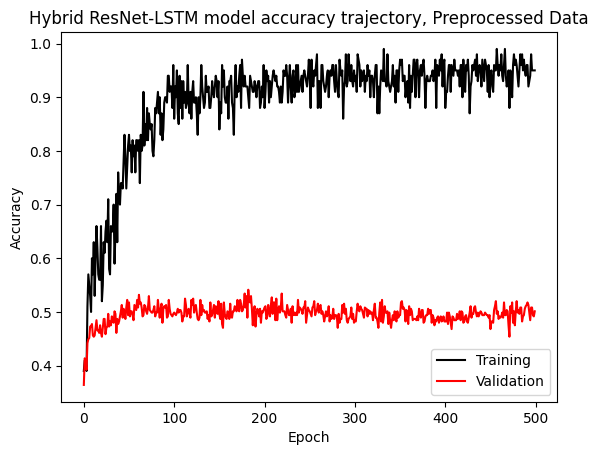

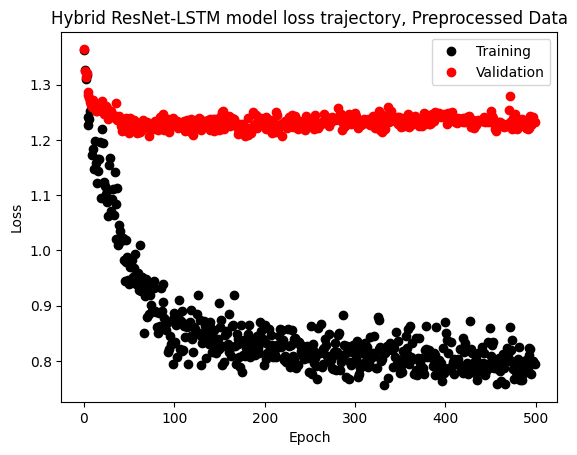

In [ ]:
#Update arrays and title
plt.plot(np.arange(num_epochs),train_history_2,label='Training',color='k')
plt.plot(np.arange(num_epochs),val_history_2,label='Validation',color='r')
plt.title('Hybrid ResNet-LSTM model accuracy trajectory, Preprocessed Data')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(np.arange(num_epochs),train_loss_hist_2,'o',label='Training',color='k')
plt.plot(np.arange(num_epochs),val_loss_hist_2,'o',label='Validation',color='r')
plt.title('Hybrid ResNet-LSTM model loss trajectory, Preprocessed Data')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Part 3: Low pass filter after data preprocessing

In [ ]:
## Randomly split the train/validation dataset
ind_valid = np.random.choice(X_train_valid.shape[0], int(X_train_valid.shape[0]/5), replace=False)
ind_train = np.array(list(set(range(X_train_valid.shape[0])).difference(set(ind_valid))))
x_valid, y_valid = X_train_valid[ind_valid], y_train_valid[ind_valid]
x_train, y_train = X_train_valid[ind_train], y_train_valid[ind_train]
print('Training and Validation shapes before preprocessing: ')
print('X train: ', x_train.shape, ' Y train: ', y_train.shape)
print('X val: ', x_valid.shape, ' Y val', y_valid.shape)

# Preprocessing the dataset
# pass only training data to train prep, val and test data to test prep

x_train,y_train = train_data_prep(x_train,y_train,2,2,True)
x_test, x_valid = test_data_prep(x_test), test_data_prep(x_valid)

x_train = torch.tensor(x_train).detach().float().to(device)
x_valid = torch.tensor(x_valid).detach().float().to(device)
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

# Converting the labels to categorical variables for multiclass classification
y_train, y_valid, y_test = torch.tensor(y_train).to(device), torch.tensor(y_valid).to(device), torch.tensor(y_test).to(device)
y_train = nn.functional.one_hot(y_train.long(), 4)
y_valid = nn.functional.one_hot(y_valid.long(), 4)
y_test = nn.functional.one_hot(y_test.long(), 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 2,3)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 2,3)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 2,3)
x_test = torch.tensor(x_test).detach().float().to(device)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

# Convert x train to numpy

x_train_np = x_train.cpu().numpy()
print(x_train_np.shape)

Training and Validation shapes before preprocessing: 
X train:  (1692, 22, 1000)  Y train:  (1692,)
X val:  (423, 22, 1000)  Y val (423,)
Shape of X after trimming: (1692, 22, 800)
Shape of X after maxpooling: (1692, 22, 400)
Shape of X after averaging+noise and concatenating: (3384, 22, 400)
Shape of X after subsampling and concatenating: (6768, 22, 400)
Shape of Y: (6768,)
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of X after trimming: (423, 22, 800)
Shape of X after maxpooling: (423, 22, 400)
Shape of training set: torch.Size([6768, 22, 400])
Shape of validation set: torch.Size([423, 22, 400])
Shape of training labels: (6768,)
Shape of validation labels: (423,)
Shape of training labels after categorical conversion: torch.Size([6768, 4])
Shape of validation labels after categorical conversion: torch.Size([423, 4])
Shape of test labels after categorical conversion: torch.Size([443, 4])
Shape of training set after adding width info: torc

In [ ]:
# Define the low-pass filter parameters
cutoff_frequency = 40  # Cut-off frequency in Hz
sampling_rate = 125  # Sampling rate in Hz (adjust based on your data)

# Design a Butterworth low-pass filter
order = 3  # Filter order
b, a = butter(N=order, Wn=cutoff_frequency / (0.5 * sampling_rate), btype='low', analog=False, output='ba')

x_train_lpf = np.zeros(x_train_np.shape)
# Apply the filter to the data
for i in range(x_train_np.shape[0]):
    for j in range(x_train_np.shape[2]):
        filtered_data = filtfilt(b, a, x_train_np[i,0,j,:])
        x_train_lpf[i,0,j,:] = filtered_data

x_train_lpf = torch.tensor(x_train_lpf).float().to(device)
print(x_train_lpf.shape)

torch.Size([6768, 1, 22, 400])


Build the model


In [ ]:
model3 = ResNetLSTM(img_channels=1, block=BasicBlock, num_classes=4, time_dim=int(x_train.size(3)), dropout=0.6).to(device)
print(model3)
total_params = sum(p.numel() for p in model3.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model3.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

ResNetLSTM(
  (conv1): Conv2d(1, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
  (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(48, 48, kernel_size=(22, 1), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ELU(alpha=1.0, inplace=True)
  (res1): BasicBlock(
    (conv1): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout2d(p=0.6, inplace=False)
    (elu): ELU(alpha=1.0, inplace=True)
    (conv2): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2): Dropout2d(p=0.6, inplace=False)
    (shortcut): Identity()
  )
  (res2): BasicBlock(
    (conv1):

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
# Choose Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
# Rename these lines between models
train_history_3, val_history_3 = np.array([]), np.array([])
train_loss_hist_3, val_loss_hist_3 = np.array([]), np.array([])

with TemporaryDirectory() as tempdir:
    save_folder = '/content/drive/MyDrive/C147_Final_Project/best_model_params'

    # Rename these lines between models
    best_model_params_path = os.path.join(save_folder, 'best_model3_params.pt')
    torch.save(model3.state_dict(), best_model_params_path)

    best_acc = 0.0
    bsz = 100
    num_epochs = 500
    iteration = 0
    total_it = num_epochs*int(x_train.shape[0]/bsz)
    for epoch_idx in tqdm(range(num_epochs)):
        # Set model to train mode - useful for layers such as BatchNorm or Dropout whose behaviors change between train/eval
        # Rename
        model3.train()
        train_count = 0
        train_correct_count = 0
        for i in range(int(x_train.shape[0]/bsz)):
            iteration+=1
            optimizer.zero_grad() # Zero gradients, since we don't want gradients to accumulate between batches - we apply an update for each batch
            train_x, train_y = sample(x_train, y_train, bsz)
            #Rename
            logits = model3(train_x) #bszx4x1x4

            logits = nn.functional.softmax(logits, dim=1)
            loss = criterion(logits.float(), train_y.float())

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                #y_hat = torch.mean(logits, dim = 2)
                y_hat = torch.argmax(logits, dim=1)
                train_correct_count = torch.sum(y_hat == torch.argmax(train_y, dim=1))
                train_count = train_x.size(0)
                train_count = float(train_count)
            #print(f'(Iteration {iteration}/{total_it})Training Accuracy: ', (train_correct_count/train_count).item(), '. Loss: ', loss.item())


        train_acc = train_correct_count / train_count

        #Rename
        model3.eval()
        val_count = 0
        val_correct_count = 0
        with torch.no_grad():
            val_x = x_valid
            val_y = y_valid
            #Rename
            logits = model3(val_x).detach()
            logits = nn.functional.softmax(logits)
            val_loss = criterion(logits.float(), val_y.float())
            with torch.no_grad():
                y_hat = torch.argmax(logits, dim=1)
                val_correct_count = torch.sum(y_hat == torch.argmax(val_y, dim=1))
                val_count = float(val_x.size(0))
        val_acc = val_correct_count / y_valid.shape[0]

        print(f'Epoch {epoch_idx+1} Finished!!!')
        print('Train acc: {:.3f}, Val acc: {:.3f}'.format(train_acc, val_acc))
        print('Train loss: {:.3f}, Val loss: {:.3f}'.format(loss, val_loss))

        #Rename
        train_history_3 = np.append(train_history_3, train_acc.item())
        val_history_3 = np.append(val_history_3, val_acc.item())
        train_loss_hist_3 = np.append(train_loss_hist_3, loss.item())
        val_loss_hist_3 = np.append(val_loss_hist_3, val_loss.item())

        if val_acc > best_acc:
            best_acc = val_acc
            #Rename
            torch.save(model3.state_dict(), best_model_params_path)

    print(f'Best val Acc: {best_acc:4f}')

  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-13-6f370104b205>:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = nn.functional.softmax(logits)
  0%|          | 1/500 [00:08<1:07:19,  8.10s/it]

Epoch 1 Finished!!!
Train acc: 0.310, Val acc: 0.333
Train loss: 1.371, Val loss: 1.364


  0%|          | 2/500 [00:10<38:45,  4.67s/it]  

Epoch 2 Finished!!!
Train acc: 0.470, Val acc: 0.423
Train loss: 1.296, Val loss: 1.313


  1%|          | 3/500 [00:12<29:34,  3.57s/it]

Epoch 3 Finished!!!
Train acc: 0.450, Val acc: 0.435
Train loss: 1.286, Val loss: 1.308


  1%|          | 4/500 [00:14<25:16,  3.06s/it]

Epoch 4 Finished!!!
Train acc: 0.480, Val acc: 0.444
Train loss: 1.278, Val loss: 1.284


  1%|          | 5/500 [00:17<22:52,  2.77s/it]

Epoch 5 Finished!!!
Train acc: 0.490, Val acc: 0.444
Train loss: 1.283, Val loss: 1.281


  1%|          | 6/500 [00:19<21:25,  2.60s/it]

Epoch 6 Finished!!!
Train acc: 0.510, Val acc: 0.468
Train loss: 1.251, Val loss: 1.270


  1%|▏         | 7/500 [00:21<20:30,  2.50s/it]

Epoch 7 Finished!!!
Train acc: 0.460, Val acc: 0.487
Train loss: 1.246, Val loss: 1.256


  2%|▏         | 8/500 [00:23<19:52,  2.42s/it]

Epoch 8 Finished!!!
Train acc: 0.470, Val acc: 0.430
Train loss: 1.257, Val loss: 1.284


  2%|▏         | 9/500 [00:26<19:26,  2.38s/it]

Epoch 9 Finished!!!
Train acc: 0.570, Val acc: 0.456
Train loss: 1.207, Val loss: 1.261


  2%|▏         | 10/500 [00:28<19:09,  2.35s/it]

Epoch 10 Finished!!!
Train acc: 0.530, Val acc: 0.444
Train loss: 1.219, Val loss: 1.282


  2%|▏         | 11/500 [00:30<19:00,  2.33s/it]

Epoch 11 Finished!!!
Train acc: 0.590, Val acc: 0.470
Train loss: 1.172, Val loss: 1.260


  2%|▏         | 12/500 [00:33<18:53,  2.32s/it]

Epoch 12 Finished!!!
Train acc: 0.650, Val acc: 0.492
Train loss: 1.144, Val loss: 1.245


  3%|▎         | 13/500 [00:35<18:45,  2.31s/it]

Epoch 13 Finished!!!
Train acc: 0.560, Val acc: 0.485
Train loss: 1.196, Val loss: 1.247


  3%|▎         | 14/500 [00:37<18:41,  2.31s/it]

Epoch 14 Finished!!!
Train acc: 0.610, Val acc: 0.496
Train loss: 1.173, Val loss: 1.242


  3%|▎         | 15/500 [00:40<18:36,  2.30s/it]

Epoch 15 Finished!!!
Train acc: 0.610, Val acc: 0.485
Train loss: 1.142, Val loss: 1.245


  3%|▎         | 16/500 [00:42<18:34,  2.30s/it]

Epoch 16 Finished!!!
Train acc: 0.580, Val acc: 0.459
Train loss: 1.179, Val loss: 1.264


  3%|▎         | 17/500 [00:44<18:32,  2.30s/it]

Epoch 17 Finished!!!
Train acc: 0.530, Val acc: 0.487
Train loss: 1.215, Val loss: 1.231


  4%|▎         | 18/500 [00:46<18:30,  2.30s/it]

Epoch 18 Finished!!!
Train acc: 0.650, Val acc: 0.475
Train loss: 1.101, Val loss: 1.244


  4%|▍         | 19/500 [00:49<18:28,  2.30s/it]

Epoch 19 Finished!!!
Train acc: 0.630, Val acc: 0.461
Train loss: 1.143, Val loss: 1.254


  4%|▍         | 20/500 [00:51<18:26,  2.31s/it]

Epoch 20 Finished!!!
Train acc: 0.600, Val acc: 0.475
Train loss: 1.167, Val loss: 1.244


  4%|▍         | 21/500 [00:53<18:26,  2.31s/it]

Epoch 21 Finished!!!
Train acc: 0.660, Val acc: 0.480
Train loss: 1.108, Val loss: 1.252


  4%|▍         | 22/500 [00:56<18:29,  2.32s/it]

Epoch 22 Finished!!!
Train acc: 0.660, Val acc: 0.501
Train loss: 1.130, Val loss: 1.234


  5%|▍         | 23/500 [00:58<18:26,  2.32s/it]

Epoch 23 Finished!!!
Train acc: 0.620, Val acc: 0.463
Train loss: 1.140, Val loss: 1.254


  5%|▍         | 24/500 [01:00<18:24,  2.32s/it]

Epoch 24 Finished!!!
Train acc: 0.630, Val acc: 0.499
Train loss: 1.130, Val loss: 1.233


  5%|▌         | 25/500 [01:03<18:31,  2.34s/it]

Epoch 25 Finished!!!
Train acc: 0.660, Val acc: 0.504
Train loss: 1.116, Val loss: 1.239


  5%|▌         | 26/500 [01:05<18:34,  2.35s/it]

Epoch 26 Finished!!!
Train acc: 0.690, Val acc: 0.473
Train loss: 1.062, Val loss: 1.254


  5%|▌         | 27/500 [01:08<18:43,  2.38s/it]

Epoch 27 Finished!!!
Train acc: 0.670, Val acc: 0.470
Train loss: 1.086, Val loss: 1.261


  6%|▌         | 28/500 [01:10<18:36,  2.37s/it]

Epoch 28 Finished!!!
Train acc: 0.680, Val acc: 0.501
Train loss: 1.084, Val loss: 1.231


  6%|▌         | 29/500 [01:12<18:34,  2.37s/it]

Epoch 29 Finished!!!
Train acc: 0.620, Val acc: 0.480
Train loss: 1.144, Val loss: 1.249


  6%|▌         | 30/500 [01:15<18:32,  2.37s/it]

Epoch 30 Finished!!!
Train acc: 0.750, Val acc: 0.478
Train loss: 1.043, Val loss: 1.247


  6%|▌         | 31/500 [01:17<18:27,  2.36s/it]

Epoch 31 Finished!!!
Train acc: 0.690, Val acc: 0.482
Train loss: 1.055, Val loss: 1.245


  6%|▋         | 32/500 [01:19<18:35,  2.38s/it]

Epoch 32 Finished!!!
Train acc: 0.710, Val acc: 0.456
Train loss: 1.063, Val loss: 1.261


  7%|▋         | 33/500 [01:22<18:30,  2.38s/it]

Epoch 33 Finished!!!
Train acc: 0.680, Val acc: 0.444
Train loss: 1.069, Val loss: 1.274


  7%|▋         | 34/500 [01:24<18:25,  2.37s/it]

Epoch 34 Finished!!!
Train acc: 0.650, Val acc: 0.473
Train loss: 1.094, Val loss: 1.243


  7%|▋         | 35/500 [01:27<18:43,  2.42s/it]

Epoch 35 Finished!!!
Train acc: 0.690, Val acc: 0.480
Train loss: 1.090, Val loss: 1.247


  7%|▋         | 36/500 [01:30<19:47,  2.56s/it]

Epoch 36 Finished!!!
Train acc: 0.690, Val acc: 0.494
Train loss: 1.066, Val loss: 1.236


  7%|▋         | 37/500 [01:32<20:12,  2.62s/it]

Epoch 37 Finished!!!
Train acc: 0.690, Val acc: 0.463
Train loss: 1.049, Val loss: 1.259


  8%|▊         | 38/500 [01:36<22:03,  2.87s/it]

Epoch 38 Finished!!!
Train acc: 0.700, Val acc: 0.468
Train loss: 1.063, Val loss: 1.252


  8%|▊         | 39/500 [01:38<21:07,  2.75s/it]

Epoch 39 Finished!!!
Train acc: 0.730, Val acc: 0.480
Train loss: 1.017, Val loss: 1.243


  8%|▊         | 40/500 [01:41<20:23,  2.66s/it]

Epoch 40 Finished!!!
Train acc: 0.740, Val acc: 0.487
Train loss: 1.027, Val loss: 1.235


  8%|▊         | 41/500 [01:43<19:38,  2.57s/it]

Epoch 41 Finished!!!
Train acc: 0.790, Val acc: 0.466
Train loss: 0.955, Val loss: 1.253


  8%|▊         | 42/500 [01:45<19:06,  2.50s/it]

Epoch 42 Finished!!!
Train acc: 0.660, Val acc: 0.501
Train loss: 1.093, Val loss: 1.225


  9%|▊         | 43/500 [01:48<18:44,  2.46s/it]

Epoch 43 Finished!!!
Train acc: 0.710, Val acc: 0.459
Train loss: 1.046, Val loss: 1.267


  9%|▉         | 44/500 [01:50<18:29,  2.43s/it]

Epoch 44 Finished!!!
Train acc: 0.680, Val acc: 0.506
Train loss: 1.071, Val loss: 1.231


  9%|▉         | 45/500 [01:52<18:14,  2.40s/it]

Epoch 45 Finished!!!
Train acc: 0.730, Val acc: 0.501
Train loss: 1.032, Val loss: 1.230


  9%|▉         | 46/500 [01:55<18:03,  2.39s/it]

Epoch 46 Finished!!!
Train acc: 0.680, Val acc: 0.487
Train loss: 1.064, Val loss: 1.240


  9%|▉         | 47/500 [01:57<17:57,  2.38s/it]

Epoch 47 Finished!!!
Train acc: 0.710, Val acc: 0.513
Train loss: 1.029, Val loss: 1.224


 10%|▉         | 48/500 [01:59<17:50,  2.37s/it]

Epoch 48 Finished!!!
Train acc: 0.780, Val acc: 0.499
Train loss: 0.970, Val loss: 1.237


 10%|▉         | 49/500 [02:02<17:44,  2.36s/it]

Epoch 49 Finished!!!
Train acc: 0.770, Val acc: 0.487
Train loss: 1.005, Val loss: 1.241


 10%|█         | 50/500 [02:04<17:39,  2.35s/it]

Epoch 50 Finished!!!
Train acc: 0.680, Val acc: 0.466
Train loss: 1.072, Val loss: 1.253


 10%|█         | 51/500 [02:07<17:35,  2.35s/it]

Epoch 51 Finished!!!
Train acc: 0.690, Val acc: 0.508
Train loss: 1.045, Val loss: 1.220


 10%|█         | 52/500 [02:09<17:33,  2.35s/it]

Epoch 52 Finished!!!
Train acc: 0.830, Val acc: 0.527
Train loss: 0.946, Val loss: 1.213


 11%|█         | 53/500 [02:11<17:29,  2.35s/it]

Epoch 53 Finished!!!
Train acc: 0.790, Val acc: 0.501
Train loss: 0.978, Val loss: 1.226


 11%|█         | 54/500 [02:14<17:27,  2.35s/it]

Epoch 54 Finished!!!
Train acc: 0.810, Val acc: 0.494
Train loss: 0.967, Val loss: 1.233


 11%|█         | 55/500 [02:16<17:25,  2.35s/it]

Epoch 55 Finished!!!
Train acc: 0.780, Val acc: 0.480
Train loss: 0.977, Val loss: 1.243


 11%|█         | 56/500 [02:18<17:22,  2.35s/it]

Epoch 56 Finished!!!
Train acc: 0.790, Val acc: 0.496
Train loss: 0.965, Val loss: 1.231


 11%|█▏        | 57/500 [02:21<17:19,  2.35s/it]

Epoch 57 Finished!!!
Train acc: 0.840, Val acc: 0.499
Train loss: 0.932, Val loss: 1.229


 12%|█▏        | 58/500 [02:23<17:17,  2.35s/it]

Epoch 58 Finished!!!
Train acc: 0.700, Val acc: 0.504
Train loss: 1.036, Val loss: 1.227


 12%|█▏        | 59/500 [02:25<17:15,  2.35s/it]

Epoch 59 Finished!!!
Train acc: 0.760, Val acc: 0.485
Train loss: 1.001, Val loss: 1.237


 12%|█▏        | 60/500 [02:28<17:14,  2.35s/it]

Epoch 60 Finished!!!
Train acc: 0.790, Val acc: 0.501
Train loss: 0.968, Val loss: 1.221


 12%|█▏        | 61/500 [02:30<17:11,  2.35s/it]

Epoch 61 Finished!!!
Train acc: 0.800, Val acc: 0.492
Train loss: 0.962, Val loss: 1.232


 12%|█▏        | 62/500 [02:32<17:08,  2.35s/it]

Epoch 62 Finished!!!
Train acc: 0.720, Val acc: 0.492
Train loss: 1.037, Val loss: 1.246


 13%|█▎        | 63/500 [02:35<17:06,  2.35s/it]

Epoch 63 Finished!!!
Train acc: 0.780, Val acc: 0.506
Train loss: 0.974, Val loss: 1.221


 13%|█▎        | 64/500 [02:37<17:04,  2.35s/it]

Epoch 64 Finished!!!
Train acc: 0.820, Val acc: 0.489
Train loss: 0.939, Val loss: 1.241


 13%|█▎        | 65/500 [02:39<17:02,  2.35s/it]

Epoch 65 Finished!!!
Train acc: 0.740, Val acc: 0.522
Train loss: 1.008, Val loss: 1.214


 13%|█▎        | 66/500 [02:42<17:01,  2.35s/it]

Epoch 66 Finished!!!
Train acc: 0.850, Val acc: 0.492
Train loss: 0.903, Val loss: 1.236


 13%|█▎        | 67/500 [02:44<16:58,  2.35s/it]

Epoch 67 Finished!!!
Train acc: 0.790, Val acc: 0.513
Train loss: 0.965, Val loss: 1.226


 14%|█▎        | 68/500 [02:46<16:56,  2.35s/it]

Epoch 68 Finished!!!
Train acc: 0.830, Val acc: 0.504
Train loss: 0.933, Val loss: 1.226


 14%|█▍        | 69/500 [02:49<16:53,  2.35s/it]

Epoch 69 Finished!!!
Train acc: 0.720, Val acc: 0.494
Train loss: 1.020, Val loss: 1.231


 14%|█▍        | 70/500 [02:51<16:52,  2.36s/it]

Epoch 70 Finished!!!
Train acc: 0.920, Val acc: 0.487
Train loss: 0.844, Val loss: 1.236


 14%|█▍        | 71/500 [02:54<16:53,  2.36s/it]

Epoch 71 Finished!!!
Train acc: 0.780, Val acc: 0.518
Train loss: 0.963, Val loss: 1.214


 14%|█▍        | 72/500 [02:56<16:50,  2.36s/it]

Epoch 72 Finished!!!
Train acc: 0.810, Val acc: 0.515
Train loss: 0.942, Val loss: 1.222


 15%|█▍        | 73/500 [02:58<16:47,  2.36s/it]

Epoch 73 Finished!!!
Train acc: 0.840, Val acc: 0.468
Train loss: 0.908, Val loss: 1.250


 15%|█▍        | 74/500 [03:01<16:44,  2.36s/it]

Epoch 74 Finished!!!
Train acc: 0.790, Val acc: 0.520
Train loss: 0.943, Val loss: 1.228


 15%|█▌        | 75/500 [03:03<16:41,  2.36s/it]

Epoch 75 Finished!!!
Train acc: 0.800, Val acc: 0.511
Train loss: 0.951, Val loss: 1.223


 15%|█▌        | 76/500 [03:05<16:38,  2.36s/it]

Epoch 76 Finished!!!
Train acc: 0.850, Val acc: 0.485
Train loss: 0.895, Val loss: 1.239


 15%|█▌        | 77/500 [03:08<16:37,  2.36s/it]

Epoch 77 Finished!!!
Train acc: 0.840, Val acc: 0.504
Train loss: 0.919, Val loss: 1.210


 16%|█▌        | 78/500 [03:10<16:34,  2.36s/it]

Epoch 78 Finished!!!
Train acc: 0.840, Val acc: 0.499
Train loss: 0.922, Val loss: 1.226


 16%|█▌        | 79/500 [03:12<16:31,  2.35s/it]

Epoch 79 Finished!!!
Train acc: 0.900, Val acc: 0.506
Train loss: 0.857, Val loss: 1.227


 16%|█▌        | 80/500 [03:15<16:28,  2.35s/it]

Epoch 80 Finished!!!
Train acc: 0.900, Val acc: 0.515
Train loss: 0.858, Val loss: 1.221


 16%|█▌        | 81/500 [03:17<16:25,  2.35s/it]

Epoch 81 Finished!!!
Train acc: 0.900, Val acc: 0.522
Train loss: 0.857, Val loss: 1.212


 16%|█▋        | 82/500 [03:20<17:02,  2.45s/it]

Epoch 82 Finished!!!
Train acc: 0.880, Val acc: 0.508
Train loss: 0.874, Val loss: 1.218


 17%|█▋        | 83/500 [03:22<16:47,  2.42s/it]

Epoch 83 Finished!!!
Train acc: 0.840, Val acc: 0.515
Train loss: 0.915, Val loss: 1.215


 17%|█▋        | 84/500 [03:24<16:36,  2.40s/it]

Epoch 84 Finished!!!
Train acc: 0.870, Val acc: 0.504
Train loss: 0.874, Val loss: 1.224


 17%|█▋        | 85/500 [03:27<16:38,  2.41s/it]

Epoch 85 Finished!!!
Train acc: 0.840, Val acc: 0.501
Train loss: 0.922, Val loss: 1.225


 17%|█▋        | 86/500 [03:29<16:28,  2.39s/it]

Epoch 86 Finished!!!
Train acc: 0.920, Val acc: 0.511
Train loss: 0.840, Val loss: 1.220


 17%|█▋        | 87/500 [03:32<16:21,  2.38s/it]

Epoch 87 Finished!!!
Train acc: 0.860, Val acc: 0.508
Train loss: 0.893, Val loss: 1.218


 18%|█▊        | 88/500 [03:34<16:16,  2.37s/it]

Epoch 88 Finished!!!
Train acc: 0.880, Val acc: 0.518
Train loss: 0.866, Val loss: 1.209


 18%|█▊        | 89/500 [03:36<16:11,  2.36s/it]

Epoch 89 Finished!!!
Train acc: 0.820, Val acc: 0.525
Train loss: 0.927, Val loss: 1.206


 18%|█▊        | 90/500 [03:39<16:07,  2.36s/it]

Epoch 90 Finished!!!
Train acc: 0.890, Val acc: 0.511
Train loss: 0.863, Val loss: 1.216


 18%|█▊        | 91/500 [03:41<16:03,  2.36s/it]

Epoch 91 Finished!!!
Train acc: 0.890, Val acc: 0.515
Train loss: 0.876, Val loss: 1.218


 18%|█▊        | 92/500 [03:43<16:02,  2.36s/it]

Epoch 92 Finished!!!
Train acc: 0.870, Val acc: 0.532
Train loss: 0.877, Val loss: 1.203


 19%|█▊        | 93/500 [03:46<15:58,  2.36s/it]

Epoch 93 Finished!!!
Train acc: 0.870, Val acc: 0.518
Train loss: 0.876, Val loss: 1.209


 19%|█▉        | 94/500 [03:48<15:55,  2.35s/it]

Epoch 94 Finished!!!
Train acc: 0.910, Val acc: 0.532
Train loss: 0.836, Val loss: 1.204


 19%|█▉        | 95/500 [03:50<15:53,  2.35s/it]

Epoch 95 Finished!!!
Train acc: 0.920, Val acc: 0.537
Train loss: 0.833, Val loss: 1.200


 19%|█▉        | 96/500 [03:53<15:49,  2.35s/it]

Epoch 96 Finished!!!
Train acc: 0.890, Val acc: 0.511
Train loss: 0.867, Val loss: 1.216


 19%|█▉        | 97/500 [03:55<15:46,  2.35s/it]

Epoch 97 Finished!!!
Train acc: 0.920, Val acc: 0.532
Train loss: 0.838, Val loss: 1.200


 20%|█▉        | 98/500 [03:57<15:44,  2.35s/it]

Epoch 98 Finished!!!
Train acc: 0.860, Val acc: 0.515
Train loss: 0.892, Val loss: 1.214


 20%|█▉        | 99/500 [04:00<15:42,  2.35s/it]

Epoch 99 Finished!!!
Train acc: 0.900, Val acc: 0.537
Train loss: 0.859, Val loss: 1.198


 20%|██        | 100/500 [04:02<15:39,  2.35s/it]

Epoch 100 Finished!!!
Train acc: 0.880, Val acc: 0.520
Train loss: 0.867, Val loss: 1.207


 20%|██        | 101/500 [04:04<15:36,  2.35s/it]

Epoch 101 Finished!!!
Train acc: 0.910, Val acc: 0.522
Train loss: 0.842, Val loss: 1.207


 20%|██        | 102/500 [04:07<15:36,  2.35s/it]

Epoch 102 Finished!!!
Train acc: 0.830, Val acc: 0.539
Train loss: 0.919, Val loss: 1.196


 21%|██        | 103/500 [04:09<15:32,  2.35s/it]

Epoch 103 Finished!!!
Train acc: 0.870, Val acc: 0.532
Train loss: 0.885, Val loss: 1.198


 21%|██        | 104/500 [04:12<15:32,  2.36s/it]

Epoch 104 Finished!!!
Train acc: 0.830, Val acc: 0.541
Train loss: 0.905, Val loss: 1.192


 21%|██        | 105/500 [04:14<15:29,  2.35s/it]

Epoch 105 Finished!!!
Train acc: 0.910, Val acc: 0.525
Train loss: 0.839, Val loss: 1.207


 21%|██        | 106/500 [04:16<15:26,  2.35s/it]

Epoch 106 Finished!!!
Train acc: 0.870, Val acc: 0.513
Train loss: 0.886, Val loss: 1.211


 21%|██▏       | 107/500 [04:19<15:23,  2.35s/it]

Epoch 107 Finished!!!
Train acc: 0.860, Val acc: 0.532
Train loss: 0.885, Val loss: 1.209


 22%|██▏       | 108/500 [04:21<15:21,  2.35s/it]

Epoch 108 Finished!!!
Train acc: 0.880, Val acc: 0.496
Train loss: 0.877, Val loss: 1.220


 22%|██▏       | 109/500 [04:23<15:18,  2.35s/it]

Epoch 109 Finished!!!
Train acc: 0.890, Val acc: 0.525
Train loss: 0.868, Val loss: 1.210


 22%|██▏       | 110/500 [04:26<15:17,  2.35s/it]

Epoch 110 Finished!!!
Train acc: 0.880, Val acc: 0.496
Train loss: 0.863, Val loss: 1.226


 22%|██▏       | 111/500 [04:28<15:14,  2.35s/it]

Epoch 111 Finished!!!
Train acc: 0.900, Val acc: 0.518
Train loss: 0.848, Val loss: 1.213


 22%|██▏       | 112/500 [04:30<15:11,  2.35s/it]

Epoch 112 Finished!!!
Train acc: 0.930, Val acc: 0.492
Train loss: 0.825, Val loss: 1.233


 23%|██▎       | 113/500 [04:33<15:09,  2.35s/it]

Epoch 113 Finished!!!
Train acc: 0.920, Val acc: 0.513
Train loss: 0.830, Val loss: 1.219


 23%|██▎       | 114/500 [04:35<15:06,  2.35s/it]

Epoch 114 Finished!!!
Train acc: 0.910, Val acc: 0.525
Train loss: 0.843, Val loss: 1.213


 23%|██▎       | 115/500 [04:37<15:05,  2.35s/it]

Epoch 115 Finished!!!
Train acc: 0.900, Val acc: 0.520
Train loss: 0.852, Val loss: 1.219


 23%|██▎       | 116/500 [04:40<15:02,  2.35s/it]

Epoch 116 Finished!!!
Train acc: 0.920, Val acc: 0.506
Train loss: 0.826, Val loss: 1.216


 23%|██▎       | 117/500 [04:42<14:59,  2.35s/it]

Epoch 117 Finished!!!
Train acc: 0.910, Val acc: 0.530
Train loss: 0.840, Val loss: 1.205


 24%|██▎       | 118/500 [04:44<14:56,  2.35s/it]

Epoch 118 Finished!!!
Train acc: 0.890, Val acc: 0.515
Train loss: 0.855, Val loss: 1.222


 24%|██▍       | 119/500 [04:47<14:54,  2.35s/it]

Epoch 119 Finished!!!
Train acc: 0.920, Val acc: 0.522
Train loss: 0.831, Val loss: 1.209


 24%|██▍       | 120/500 [04:49<14:52,  2.35s/it]

Epoch 120 Finished!!!
Train acc: 0.840, Val acc: 0.513
Train loss: 0.904, Val loss: 1.219


 24%|██▍       | 121/500 [04:51<14:50,  2.35s/it]

Epoch 121 Finished!!!
Train acc: 0.950, Val acc: 0.506
Train loss: 0.797, Val loss: 1.218


 24%|██▍       | 122/500 [04:54<14:47,  2.35s/it]

Epoch 122 Finished!!!
Train acc: 0.870, Val acc: 0.525
Train loss: 0.875, Val loss: 1.212


 25%|██▍       | 123/500 [04:56<14:45,  2.35s/it]

Epoch 123 Finished!!!
Train acc: 0.900, Val acc: 0.513
Train loss: 0.841, Val loss: 1.217


 25%|██▍       | 124/500 [04:59<14:43,  2.35s/it]

Epoch 124 Finished!!!
Train acc: 0.910, Val acc: 0.492
Train loss: 0.842, Val loss: 1.231


 25%|██▌       | 125/500 [05:01<14:40,  2.35s/it]

Epoch 125 Finished!!!
Train acc: 0.940, Val acc: 0.501
Train loss: 0.812, Val loss: 1.220


 25%|██▌       | 126/500 [05:03<14:39,  2.35s/it]

Epoch 126 Finished!!!
Train acc: 0.920, Val acc: 0.496
Train loss: 0.832, Val loss: 1.216


 25%|██▌       | 127/500 [05:06<14:36,  2.35s/it]

Epoch 127 Finished!!!
Train acc: 0.970, Val acc: 0.515
Train loss: 0.782, Val loss: 1.219


 26%|██▌       | 128/500 [05:08<14:33,  2.35s/it]

Epoch 128 Finished!!!
Train acc: 0.910, Val acc: 0.489
Train loss: 0.849, Val loss: 1.234


 26%|██▌       | 129/500 [05:10<14:31,  2.35s/it]

Epoch 129 Finished!!!
Train acc: 0.920, Val acc: 0.520
Train loss: 0.836, Val loss: 1.214


 26%|██▌       | 130/500 [05:13<14:30,  2.35s/it]

Epoch 130 Finished!!!
Train acc: 0.970, Val acc: 0.513
Train loss: 0.785, Val loss: 1.214


 26%|██▌       | 131/500 [05:15<14:30,  2.36s/it]

Epoch 131 Finished!!!
Train acc: 0.900, Val acc: 0.513
Train loss: 0.856, Val loss: 1.218


 26%|██▋       | 132/500 [05:17<14:28,  2.36s/it]

Epoch 132 Finished!!!
Train acc: 0.910, Val acc: 0.499
Train loss: 0.844, Val loss: 1.229


 27%|██▋       | 133/500 [05:20<14:25,  2.36s/it]

Epoch 133 Finished!!!
Train acc: 0.940, Val acc: 0.513
Train loss: 0.820, Val loss: 1.222


 27%|██▋       | 134/500 [05:22<14:21,  2.35s/it]

Epoch 134 Finished!!!
Train acc: 0.960, Val acc: 0.518
Train loss: 0.786, Val loss: 1.218


 27%|██▋       | 135/500 [05:24<14:18,  2.35s/it]

Epoch 135 Finished!!!
Train acc: 0.890, Val acc: 0.513
Train loss: 0.856, Val loss: 1.219


 27%|██▋       | 136/500 [05:27<14:15,  2.35s/it]

Epoch 136 Finished!!!
Train acc: 0.920, Val acc: 0.532
Train loss: 0.826, Val loss: 1.204


 27%|██▋       | 137/500 [05:29<14:14,  2.35s/it]

Epoch 137 Finished!!!
Train acc: 0.900, Val acc: 0.522
Train loss: 0.848, Val loss: 1.209


 28%|██▊       | 138/500 [05:31<14:11,  2.35s/it]

Epoch 138 Finished!!!
Train acc: 0.920, Val acc: 0.506
Train loss: 0.818, Val loss: 1.227


 28%|██▊       | 139/500 [05:34<14:08,  2.35s/it]

Epoch 139 Finished!!!
Train acc: 0.910, Val acc: 0.522
Train loss: 0.830, Val loss: 1.211


 28%|██▊       | 140/500 [05:36<14:06,  2.35s/it]

Epoch 140 Finished!!!
Train acc: 0.910, Val acc: 0.511
Train loss: 0.847, Val loss: 1.214


 28%|██▊       | 141/500 [05:39<14:03,  2.35s/it]

Epoch 141 Finished!!!
Train acc: 0.950, Val acc: 0.522
Train loss: 0.802, Val loss: 1.203


 28%|██▊       | 142/500 [05:41<14:02,  2.35s/it]

Epoch 142 Finished!!!
Train acc: 0.960, Val acc: 0.530
Train loss: 0.794, Val loss: 1.208


 29%|██▊       | 143/500 [05:43<13:59,  2.35s/it]

Epoch 143 Finished!!!
Train acc: 0.890, Val acc: 0.530
Train loss: 0.848, Val loss: 1.210


 29%|██▉       | 144/500 [05:46<13:56,  2.35s/it]

Epoch 144 Finished!!!
Train acc: 0.920, Val acc: 0.522
Train loss: 0.830, Val loss: 1.204


 29%|██▉       | 145/500 [05:48<13:54,  2.35s/it]

Epoch 145 Finished!!!
Train acc: 0.910, Val acc: 0.508
Train loss: 0.840, Val loss: 1.225


 29%|██▉       | 146/500 [05:50<13:52,  2.35s/it]

Epoch 146 Finished!!!
Train acc: 0.940, Val acc: 0.518
Train loss: 0.810, Val loss: 1.214


 29%|██▉       | 147/500 [05:53<13:50,  2.35s/it]

Epoch 147 Finished!!!
Train acc: 0.940, Val acc: 0.511
Train loss: 0.810, Val loss: 1.223


 30%|██▉       | 148/500 [05:55<13:47,  2.35s/it]

Epoch 148 Finished!!!
Train acc: 0.890, Val acc: 0.522
Train loss: 0.857, Val loss: 1.214


 30%|██▉       | 149/500 [05:57<13:45,  2.35s/it]

Epoch 149 Finished!!!
Train acc: 0.920, Val acc: 0.504
Train loss: 0.827, Val loss: 1.220


 30%|███       | 150/500 [06:00<13:44,  2.36s/it]

Epoch 150 Finished!!!
Train acc: 0.930, Val acc: 0.544
Train loss: 0.825, Val loss: 1.199


 30%|███       | 151/500 [06:02<13:40,  2.35s/it]

Epoch 151 Finished!!!
Train acc: 0.920, Val acc: 0.511
Train loss: 0.830, Val loss: 1.211


 30%|███       | 152/500 [06:04<13:39,  2.35s/it]

Epoch 152 Finished!!!
Train acc: 0.940, Val acc: 0.546
Train loss: 0.812, Val loss: 1.189


 31%|███       | 153/500 [06:07<13:36,  2.35s/it]

Epoch 153 Finished!!!
Train acc: 0.910, Val acc: 0.530
Train loss: 0.835, Val loss: 1.206


 31%|███       | 154/500 [06:09<13:34,  2.35s/it]

Epoch 154 Finished!!!
Train acc: 0.930, Val acc: 0.532
Train loss: 0.820, Val loss: 1.204


 31%|███       | 155/500 [06:11<13:31,  2.35s/it]

Epoch 155 Finished!!!
Train acc: 0.910, Val acc: 0.522
Train loss: 0.835, Val loss: 1.219


 31%|███       | 156/500 [06:14<13:29,  2.35s/it]

Epoch 156 Finished!!!
Train acc: 0.920, Val acc: 0.515
Train loss: 0.834, Val loss: 1.215


 31%|███▏      | 157/500 [06:16<13:26,  2.35s/it]

Epoch 157 Finished!!!
Train acc: 0.940, Val acc: 0.539
Train loss: 0.811, Val loss: 1.201


 32%|███▏      | 158/500 [06:19<13:24,  2.35s/it]

Epoch 158 Finished!!!
Train acc: 0.920, Val acc: 0.537
Train loss: 0.824, Val loss: 1.207


 32%|███▏      | 159/500 [06:21<13:22,  2.35s/it]

Epoch 159 Finished!!!
Train acc: 0.920, Val acc: 0.518
Train loss: 0.827, Val loss: 1.218


 32%|███▏      | 160/500 [06:23<13:20,  2.35s/it]

Epoch 160 Finished!!!
Train acc: 0.860, Val acc: 0.527
Train loss: 0.884, Val loss: 1.205


 32%|███▏      | 161/500 [06:26<13:17,  2.35s/it]

Epoch 161 Finished!!!
Train acc: 0.920, Val acc: 0.530
Train loss: 0.821, Val loss: 1.201


 32%|███▏      | 162/500 [06:28<13:14,  2.35s/it]

Epoch 162 Finished!!!
Train acc: 0.920, Val acc: 0.513
Train loss: 0.820, Val loss: 1.218


 33%|███▎      | 163/500 [06:30<13:11,  2.35s/it]

Epoch 163 Finished!!!
Train acc: 0.950, Val acc: 0.515
Train loss: 0.798, Val loss: 1.219


 33%|███▎      | 164/500 [06:33<13:10,  2.35s/it]

Epoch 164 Finished!!!
Train acc: 0.910, Val acc: 0.511
Train loss: 0.843, Val loss: 1.208


 33%|███▎      | 165/500 [06:35<13:08,  2.35s/it]

Epoch 165 Finished!!!
Train acc: 0.930, Val acc: 0.511
Train loss: 0.817, Val loss: 1.216


 33%|███▎      | 166/500 [06:37<13:05,  2.35s/it]

Epoch 166 Finished!!!
Train acc: 0.920, Val acc: 0.522
Train loss: 0.830, Val loss: 1.206


 33%|███▎      | 167/500 [06:40<13:03,  2.35s/it]

Epoch 167 Finished!!!
Train acc: 0.950, Val acc: 0.534
Train loss: 0.791, Val loss: 1.205


 34%|███▎      | 168/500 [06:42<13:00,  2.35s/it]

Epoch 168 Finished!!!
Train acc: 0.900, Val acc: 0.518
Train loss: 0.854, Val loss: 1.212


 34%|███▍      | 169/500 [06:44<12:58,  2.35s/it]

Epoch 169 Finished!!!
Train acc: 0.960, Val acc: 0.546
Train loss: 0.785, Val loss: 1.195


 34%|███▍      | 170/500 [06:47<12:57,  2.35s/it]

Epoch 170 Finished!!!
Train acc: 0.930, Val acc: 0.522
Train loss: 0.819, Val loss: 1.211


 34%|███▍      | 171/500 [06:49<12:54,  2.35s/it]

Epoch 171 Finished!!!
Train acc: 0.910, Val acc: 0.527
Train loss: 0.842, Val loss: 1.200


 34%|███▍      | 172/500 [06:51<12:51,  2.35s/it]

Epoch 172 Finished!!!
Train acc: 0.930, Val acc: 0.522
Train loss: 0.816, Val loss: 1.204


 35%|███▍      | 173/500 [06:54<12:48,  2.35s/it]

Epoch 173 Finished!!!
Train acc: 0.930, Val acc: 0.515
Train loss: 0.813, Val loss: 1.215


 35%|███▍      | 174/500 [06:56<12:46,  2.35s/it]

Epoch 174 Finished!!!
Train acc: 0.880, Val acc: 0.508
Train loss: 0.862, Val loss: 1.218


 35%|███▌      | 175/500 [06:59<12:44,  2.35s/it]

Epoch 175 Finished!!!
Train acc: 0.870, Val acc: 0.520
Train loss: 0.867, Val loss: 1.215


 35%|███▌      | 176/500 [07:01<12:41,  2.35s/it]

Epoch 176 Finished!!!
Train acc: 0.930, Val acc: 0.541
Train loss: 0.822, Val loss: 1.198


 35%|███▌      | 177/500 [07:03<12:39,  2.35s/it]

Epoch 177 Finished!!!
Train acc: 0.960, Val acc: 0.525
Train loss: 0.784, Val loss: 1.214


 36%|███▌      | 178/500 [07:06<12:36,  2.35s/it]

Epoch 178 Finished!!!
Train acc: 0.970, Val acc: 0.527
Train loss: 0.778, Val loss: 1.205


 36%|███▌      | 179/500 [07:08<12:33,  2.35s/it]

Epoch 179 Finished!!!
Train acc: 0.930, Val acc: 0.496
Train loss: 0.817, Val loss: 1.223


 36%|███▌      | 180/500 [07:10<12:31,  2.35s/it]

Epoch 180 Finished!!!
Train acc: 0.930, Val acc: 0.525
Train loss: 0.818, Val loss: 1.211


 36%|███▌      | 181/500 [07:13<12:29,  2.35s/it]

Epoch 181 Finished!!!
Train acc: 0.930, Val acc: 0.525
Train loss: 0.815, Val loss: 1.204


 36%|███▋      | 182/500 [07:15<12:27,  2.35s/it]

Epoch 182 Finished!!!
Train acc: 0.940, Val acc: 0.513
Train loss: 0.804, Val loss: 1.221


 37%|███▋      | 183/500 [07:17<12:25,  2.35s/it]

Epoch 183 Finished!!!
Train acc: 0.940, Val acc: 0.522
Train loss: 0.814, Val loss: 1.212


 37%|███▋      | 184/500 [07:20<12:23,  2.35s/it]

Epoch 184 Finished!!!
Train acc: 0.910, Val acc: 0.541
Train loss: 0.833, Val loss: 1.199


 37%|███▋      | 185/500 [07:22<12:20,  2.35s/it]

Epoch 185 Finished!!!
Train acc: 0.950, Val acc: 0.527
Train loss: 0.804, Val loss: 1.214


 37%|███▋      | 186/500 [07:24<12:18,  2.35s/it]

Epoch 186 Finished!!!
Train acc: 0.930, Val acc: 0.501
Train loss: 0.818, Val loss: 1.224


 37%|███▋      | 187/500 [07:27<12:16,  2.35s/it]

Epoch 187 Finished!!!
Train acc: 0.970, Val acc: 0.504
Train loss: 0.785, Val loss: 1.220


 38%|███▊      | 188/500 [07:29<12:13,  2.35s/it]

Epoch 188 Finished!!!
Train acc: 0.910, Val acc: 0.515
Train loss: 0.829, Val loss: 1.216


 38%|███▊      | 189/500 [07:31<12:11,  2.35s/it]

Epoch 189 Finished!!!
Train acc: 0.910, Val acc: 0.520
Train loss: 0.828, Val loss: 1.211


 38%|███▊      | 190/500 [07:34<12:08,  2.35s/it]

Epoch 190 Finished!!!
Train acc: 0.920, Val acc: 0.520
Train loss: 0.822, Val loss: 1.202


 38%|███▊      | 191/500 [07:36<12:07,  2.35s/it]

Epoch 191 Finished!!!
Train acc: 0.960, Val acc: 0.527
Train loss: 0.795, Val loss: 1.203


 38%|███▊      | 192/500 [07:38<12:06,  2.36s/it]

Epoch 192 Finished!!!
Train acc: 0.940, Val acc: 0.541
Train loss: 0.807, Val loss: 1.200


 39%|███▊      | 193/500 [07:41<12:03,  2.36s/it]

Epoch 193 Finished!!!
Train acc: 0.930, Val acc: 0.544
Train loss: 0.816, Val loss: 1.196


 39%|███▉      | 194/500 [07:43<12:00,  2.36s/it]

Epoch 194 Finished!!!
Train acc: 0.950, Val acc: 0.530
Train loss: 0.800, Val loss: 1.205


 39%|███▉      | 195/500 [07:46<11:57,  2.35s/it]

Epoch 195 Finished!!!
Train acc: 0.930, Val acc: 0.525
Train loss: 0.821, Val loss: 1.213


 39%|███▉      | 196/500 [07:48<11:54,  2.35s/it]

Epoch 196 Finished!!!
Train acc: 0.900, Val acc: 0.520
Train loss: 0.844, Val loss: 1.215


 39%|███▉      | 197/500 [07:50<11:52,  2.35s/it]

Epoch 197 Finished!!!
Train acc: 0.940, Val acc: 0.544
Train loss: 0.805, Val loss: 1.193


 40%|███▉      | 198/500 [07:53<11:51,  2.36s/it]

Epoch 198 Finished!!!
Train acc: 0.940, Val acc: 0.527
Train loss: 0.809, Val loss: 1.206


 40%|███▉      | 199/500 [07:55<11:48,  2.35s/it]

Epoch 199 Finished!!!
Train acc: 0.970, Val acc: 0.513
Train loss: 0.778, Val loss: 1.211


 40%|████      | 200/500 [07:57<11:46,  2.35s/it]

Epoch 200 Finished!!!
Train acc: 0.920, Val acc: 0.530
Train loss: 0.819, Val loss: 1.206


 40%|████      | 201/500 [08:00<11:43,  2.35s/it]

Epoch 201 Finished!!!
Train acc: 0.960, Val acc: 0.515
Train loss: 0.794, Val loss: 1.210


 40%|████      | 202/500 [08:02<11:40,  2.35s/it]

Epoch 202 Finished!!!
Train acc: 0.970, Val acc: 0.541
Train loss: 0.782, Val loss: 1.192


 41%|████      | 203/500 [08:04<11:38,  2.35s/it]

Epoch 203 Finished!!!
Train acc: 0.940, Val acc: 0.525
Train loss: 0.803, Val loss: 1.204


 41%|████      | 204/500 [08:07<11:36,  2.35s/it]

Epoch 204 Finished!!!
Train acc: 0.910, Val acc: 0.532
Train loss: 0.836, Val loss: 1.200


 41%|████      | 205/500 [08:09<11:33,  2.35s/it]

Epoch 205 Finished!!!
Train acc: 0.920, Val acc: 0.537
Train loss: 0.832, Val loss: 1.204


 41%|████      | 206/500 [08:11<11:31,  2.35s/it]

Epoch 206 Finished!!!
Train acc: 0.900, Val acc: 0.537
Train loss: 0.844, Val loss: 1.198


 41%|████▏     | 207/500 [08:14<11:28,  2.35s/it]

Epoch 207 Finished!!!
Train acc: 0.940, Val acc: 0.532
Train loss: 0.800, Val loss: 1.197


 42%|████▏     | 208/500 [08:16<11:26,  2.35s/it]

Epoch 208 Finished!!!
Train acc: 0.890, Val acc: 0.530
Train loss: 0.856, Val loss: 1.208


 42%|████▏     | 209/500 [08:18<11:25,  2.35s/it]

Epoch 209 Finished!!!
Train acc: 0.930, Val acc: 0.520
Train loss: 0.812, Val loss: 1.211


 42%|████▏     | 210/500 [08:21<11:22,  2.35s/it]

Epoch 210 Finished!!!
Train acc: 0.910, Val acc: 0.522
Train loss: 0.842, Val loss: 1.202


 42%|████▏     | 211/500 [08:23<11:19,  2.35s/it]

Epoch 211 Finished!!!
Train acc: 0.980, Val acc: 0.520
Train loss: 0.767, Val loss: 1.207


 42%|████▏     | 212/500 [08:26<11:17,  2.35s/it]

Epoch 212 Finished!!!
Train acc: 0.920, Val acc: 0.541
Train loss: 0.833, Val loss: 1.195


 43%|████▎     | 213/500 [08:28<11:14,  2.35s/it]

Epoch 213 Finished!!!
Train acc: 0.940, Val acc: 0.534
Train loss: 0.806, Val loss: 1.202


 43%|████▎     | 214/500 [08:30<11:12,  2.35s/it]

Epoch 214 Finished!!!
Train acc: 0.920, Val acc: 0.532
Train loss: 0.828, Val loss: 1.202


 43%|████▎     | 215/500 [08:33<11:10,  2.35s/it]

Epoch 215 Finished!!!
Train acc: 0.930, Val acc: 0.534
Train loss: 0.816, Val loss: 1.203


 43%|████▎     | 216/500 [08:35<11:07,  2.35s/it]

Epoch 216 Finished!!!
Train acc: 0.970, Val acc: 0.541
Train loss: 0.778, Val loss: 1.201


 43%|████▎     | 217/500 [08:37<11:05,  2.35s/it]

Epoch 217 Finished!!!
Train acc: 0.910, Val acc: 0.527
Train loss: 0.834, Val loss: 1.205


 44%|████▎     | 218/500 [08:40<11:02,  2.35s/it]

Epoch 218 Finished!!!
Train acc: 0.960, Val acc: 0.546
Train loss: 0.788, Val loss: 1.191


 44%|████▍     | 219/500 [08:42<11:00,  2.35s/it]

Epoch 219 Finished!!!
Train acc: 0.950, Val acc: 0.544
Train loss: 0.800, Val loss: 1.194


 44%|████▍     | 220/500 [08:44<10:58,  2.35s/it]

Epoch 220 Finished!!!
Train acc: 0.970, Val acc: 0.522
Train loss: 0.781, Val loss: 1.202


 44%|████▍     | 221/500 [08:47<10:56,  2.35s/it]

Epoch 221 Finished!!!
Train acc: 0.920, Val acc: 0.525
Train loss: 0.831, Val loss: 1.204


 44%|████▍     | 222/500 [08:49<10:54,  2.35s/it]

Epoch 222 Finished!!!
Train acc: 0.930, Val acc: 0.541
Train loss: 0.814, Val loss: 1.190


 45%|████▍     | 223/500 [08:51<10:51,  2.35s/it]

Epoch 223 Finished!!!
Train acc: 0.980, Val acc: 0.539
Train loss: 0.766, Val loss: 1.198


 45%|████▍     | 224/500 [08:54<10:50,  2.36s/it]

Epoch 224 Finished!!!
Train acc: 0.970, Val acc: 0.548
Train loss: 0.783, Val loss: 1.189


 45%|████▌     | 225/500 [08:56<10:48,  2.36s/it]

Epoch 225 Finished!!!
Train acc: 0.910, Val acc: 0.553
Train loss: 0.836, Val loss: 1.190


 45%|████▌     | 226/500 [08:58<10:45,  2.36s/it]

Epoch 226 Finished!!!
Train acc: 0.900, Val acc: 0.518
Train loss: 0.837, Val loss: 1.210


 45%|████▌     | 227/500 [09:01<10:42,  2.35s/it]

Epoch 227 Finished!!!
Train acc: 0.940, Val acc: 0.546
Train loss: 0.798, Val loss: 1.193


 46%|████▌     | 228/500 [09:03<10:39,  2.35s/it]

Epoch 228 Finished!!!
Train acc: 0.920, Val acc: 0.522
Train loss: 0.825, Val loss: 1.207


 46%|████▌     | 229/500 [09:06<10:37,  2.35s/it]

Epoch 229 Finished!!!
Train acc: 0.880, Val acc: 0.527
Train loss: 0.869, Val loss: 1.199


 46%|████▌     | 230/500 [09:08<10:34,  2.35s/it]

Epoch 230 Finished!!!
Train acc: 0.880, Val acc: 0.539
Train loss: 0.863, Val loss: 1.193


 46%|████▌     | 231/500 [09:10<10:32,  2.35s/it]

Epoch 231 Finished!!!
Train acc: 0.920, Val acc: 0.515
Train loss: 0.826, Val loss: 1.217


 46%|████▋     | 232/500 [09:13<10:30,  2.35s/it]

Epoch 232 Finished!!!
Train acc: 0.950, Val acc: 0.522
Train loss: 0.794, Val loss: 1.210


 47%|████▋     | 233/500 [09:15<10:27,  2.35s/it]

Epoch 233 Finished!!!
Train acc: 0.930, Val acc: 0.548
Train loss: 0.820, Val loss: 1.189


 47%|████▋     | 234/500 [09:17<10:25,  2.35s/it]

Epoch 234 Finished!!!
Train acc: 0.960, Val acc: 0.544
Train loss: 0.789, Val loss: 1.195


 47%|████▋     | 235/500 [09:20<10:22,  2.35s/it]

Epoch 235 Finished!!!
Train acc: 0.980, Val acc: 0.527
Train loss: 0.775, Val loss: 1.198


 47%|████▋     | 236/500 [09:22<10:20,  2.35s/it]

Epoch 236 Finished!!!
Train acc: 0.950, Val acc: 0.527
Train loss: 0.799, Val loss: 1.207


 47%|████▋     | 237/500 [09:24<10:17,  2.35s/it]

Epoch 237 Finished!!!
Train acc: 0.850, Val acc: 0.539
Train loss: 0.893, Val loss: 1.197


 48%|████▊     | 238/500 [09:27<10:15,  2.35s/it]

Epoch 238 Finished!!!
Train acc: 0.950, Val acc: 0.525
Train loss: 0.798, Val loss: 1.204


 48%|████▊     | 239/500 [09:29<10:12,  2.35s/it]

Epoch 239 Finished!!!
Train acc: 0.950, Val acc: 0.513
Train loss: 0.796, Val loss: 1.220


 48%|████▊     | 240/500 [09:31<10:10,  2.35s/it]

Epoch 240 Finished!!!
Train acc: 0.960, Val acc: 0.539
Train loss: 0.791, Val loss: 1.190


 48%|████▊     | 241/500 [09:34<10:08,  2.35s/it]

Epoch 241 Finished!!!
Train acc: 0.920, Val acc: 0.530
Train loss: 0.819, Val loss: 1.205


 48%|████▊     | 242/500 [09:36<10:06,  2.35s/it]

Epoch 242 Finished!!!
Train acc: 0.910, Val acc: 0.527
Train loss: 0.844, Val loss: 1.208


 49%|████▊     | 243/500 [09:38<10:03,  2.35s/it]

Epoch 243 Finished!!!
Train acc: 0.970, Val acc: 0.506
Train loss: 0.784, Val loss: 1.213


 49%|████▉     | 244/500 [09:41<10:01,  2.35s/it]

Epoch 244 Finished!!!
Train acc: 0.980, Val acc: 0.506
Train loss: 0.770, Val loss: 1.222


 49%|████▉     | 245/500 [09:43<09:58,  2.35s/it]

Epoch 245 Finished!!!
Train acc: 0.930, Val acc: 0.525
Train loss: 0.812, Val loss: 1.205


 49%|████▉     | 246/500 [09:45<09:56,  2.35s/it]

Epoch 246 Finished!!!
Train acc: 0.960, Val acc: 0.544
Train loss: 0.789, Val loss: 1.191


 49%|████▉     | 247/500 [09:48<09:54,  2.35s/it]

Epoch 247 Finished!!!
Train acc: 0.960, Val acc: 0.530
Train loss: 0.787, Val loss: 1.205


 50%|████▉     | 248/500 [09:50<09:52,  2.35s/it]

Epoch 248 Finished!!!
Train acc: 0.900, Val acc: 0.539
Train loss: 0.845, Val loss: 1.201


 50%|████▉     | 249/500 [09:53<09:49,  2.35s/it]

Epoch 249 Finished!!!
Train acc: 0.970, Val acc: 0.532
Train loss: 0.779, Val loss: 1.200


 50%|█████     | 250/500 [09:55<09:47,  2.35s/it]

Epoch 250 Finished!!!
Train acc: 0.930, Val acc: 0.527
Train loss: 0.817, Val loss: 1.208


 50%|█████     | 251/500 [09:57<09:45,  2.35s/it]

Epoch 251 Finished!!!
Train acc: 0.920, Val acc: 0.537
Train loss: 0.828, Val loss: 1.194


 50%|█████     | 252/500 [10:00<09:44,  2.36s/it]

Epoch 252 Finished!!!
Train acc: 0.930, Val acc: 0.544
Train loss: 0.820, Val loss: 1.189


 51%|█████     | 253/500 [10:02<09:42,  2.36s/it]

Epoch 253 Finished!!!
Train acc: 0.940, Val acc: 0.534
Train loss: 0.804, Val loss: 1.199


 51%|█████     | 254/500 [10:04<09:39,  2.36s/it]

Epoch 254 Finished!!!
Train acc: 0.910, Val acc: 0.534
Train loss: 0.834, Val loss: 1.203


 51%|█████     | 255/500 [10:07<09:36,  2.35s/it]

Epoch 255 Finished!!!
Train acc: 0.890, Val acc: 0.522
Train loss: 0.862, Val loss: 1.203


 51%|█████     | 256/500 [10:09<09:33,  2.35s/it]

Epoch 256 Finished!!!
Train acc: 0.960, Val acc: 0.553
Train loss: 0.788, Val loss: 1.187


 51%|█████▏    | 257/500 [10:11<09:31,  2.35s/it]

Epoch 257 Finished!!!
Train acc: 0.960, Val acc: 0.515
Train loss: 0.782, Val loss: 1.215


 52%|█████▏    | 258/500 [10:14<09:28,  2.35s/it]

Epoch 258 Finished!!!
Train acc: 0.970, Val acc: 0.532
Train loss: 0.776, Val loss: 1.198


 52%|█████▏    | 259/500 [10:16<09:26,  2.35s/it]

Epoch 259 Finished!!!
Train acc: 0.950, Val acc: 0.525
Train loss: 0.796, Val loss: 1.202


 52%|█████▏    | 260/500 [10:18<09:23,  2.35s/it]

Epoch 260 Finished!!!
Train acc: 0.950, Val acc: 0.553
Train loss: 0.797, Val loss: 1.192


 52%|█████▏    | 261/500 [10:21<09:21,  2.35s/it]

Epoch 261 Finished!!!
Train acc: 0.960, Val acc: 0.551
Train loss: 0.795, Val loss: 1.186


 52%|█████▏    | 262/500 [10:23<09:18,  2.35s/it]

Epoch 262 Finished!!!
Train acc: 0.950, Val acc: 0.541
Train loss: 0.803, Val loss: 1.186


 53%|█████▎    | 263/500 [10:25<09:16,  2.35s/it]

Epoch 263 Finished!!!
Train acc: 0.940, Val acc: 0.527
Train loss: 0.805, Val loss: 1.198


 53%|█████▎    | 264/500 [10:28<09:14,  2.35s/it]

Epoch 264 Finished!!!
Train acc: 0.950, Val acc: 0.530
Train loss: 0.795, Val loss: 1.193


 53%|█████▎    | 265/500 [10:30<09:11,  2.35s/it]

Epoch 265 Finished!!!
Train acc: 0.920, Val acc: 0.544
Train loss: 0.824, Val loss: 1.199


 53%|█████▎    | 266/500 [10:32<09:09,  2.35s/it]

Epoch 266 Finished!!!
Train acc: 0.930, Val acc: 0.534
Train loss: 0.815, Val loss: 1.205


 53%|█████▎    | 267/500 [10:35<09:07,  2.35s/it]

Epoch 267 Finished!!!
Train acc: 0.940, Val acc: 0.518
Train loss: 0.805, Val loss: 1.207


 54%|█████▎    | 268/500 [10:37<09:04,  2.35s/it]

Epoch 268 Finished!!!
Train acc: 0.980, Val acc: 0.511
Train loss: 0.773, Val loss: 1.211


 54%|█████▍    | 269/500 [10:40<09:02,  2.35s/it]

Epoch 269 Finished!!!
Train acc: 0.910, Val acc: 0.515
Train loss: 0.835, Val loss: 1.207


 54%|█████▍    | 270/500 [10:42<09:00,  2.35s/it]

Epoch 270 Finished!!!
Train acc: 0.960, Val acc: 0.539
Train loss: 0.790, Val loss: 1.197


 54%|█████▍    | 271/500 [10:44<08:57,  2.35s/it]

Epoch 271 Finished!!!
Train acc: 0.900, Val acc: 0.532
Train loss: 0.845, Val loss: 1.195


 54%|█████▍    | 272/500 [10:47<08:55,  2.35s/it]

Epoch 272 Finished!!!
Train acc: 0.980, Val acc: 0.522
Train loss: 0.771, Val loss: 1.204


 55%|█████▍    | 273/500 [10:49<08:53,  2.35s/it]

Epoch 273 Finished!!!
Train acc: 0.920, Val acc: 0.544
Train loss: 0.828, Val loss: 1.186


 55%|█████▍    | 274/500 [10:51<08:50,  2.35s/it]

Epoch 274 Finished!!!
Train acc: 0.980, Val acc: 0.537
Train loss: 0.766, Val loss: 1.200


 55%|█████▌    | 275/500 [10:54<08:49,  2.35s/it]

Epoch 275 Finished!!!
Train acc: 0.980, Val acc: 0.506
Train loss: 0.772, Val loss: 1.220


 55%|█████▌    | 276/500 [10:56<08:46,  2.35s/it]

Epoch 276 Finished!!!
Train acc: 0.930, Val acc: 0.534
Train loss: 0.818, Val loss: 1.197


 55%|█████▌    | 277/500 [10:58<08:43,  2.35s/it]

Epoch 277 Finished!!!
Train acc: 0.940, Val acc: 0.553
Train loss: 0.802, Val loss: 1.193


 56%|█████▌    | 278/500 [11:01<08:41,  2.35s/it]

Epoch 278 Finished!!!
Train acc: 0.940, Val acc: 0.534
Train loss: 0.805, Val loss: 1.195


 56%|█████▌    | 279/500 [11:03<08:39,  2.35s/it]

Epoch 279 Finished!!!
Train acc: 0.980, Val acc: 0.534
Train loss: 0.767, Val loss: 1.195


 56%|█████▌    | 280/500 [11:05<08:37,  2.35s/it]

Epoch 280 Finished!!!
Train acc: 0.940, Val acc: 0.527
Train loss: 0.808, Val loss: 1.199


 56%|█████▌    | 281/500 [11:08<08:34,  2.35s/it]

Epoch 281 Finished!!!
Train acc: 0.960, Val acc: 0.518
Train loss: 0.795, Val loss: 1.205


 56%|█████▋    | 282/500 [11:10<08:32,  2.35s/it]

Epoch 282 Finished!!!
Train acc: 0.920, Val acc: 0.544
Train loss: 0.822, Val loss: 1.194


 57%|█████▋    | 283/500 [11:12<08:29,  2.35s/it]

Epoch 283 Finished!!!
Train acc: 0.950, Val acc: 0.513
Train loss: 0.797, Val loss: 1.210


 57%|█████▋    | 284/500 [11:15<08:27,  2.35s/it]

Epoch 284 Finished!!!
Train acc: 0.940, Val acc: 0.548
Train loss: 0.808, Val loss: 1.191


 57%|█████▋    | 285/500 [11:17<08:24,  2.35s/it]

Epoch 285 Finished!!!
Train acc: 0.950, Val acc: 0.532
Train loss: 0.803, Val loss: 1.196


 57%|█████▋    | 286/500 [11:19<08:22,  2.35s/it]

Epoch 286 Finished!!!
Train acc: 0.940, Val acc: 0.532
Train loss: 0.804, Val loss: 1.201


 57%|█████▋    | 287/500 [11:22<08:20,  2.35s/it]

Epoch 287 Finished!!!
Train acc: 0.940, Val acc: 0.534
Train loss: 0.805, Val loss: 1.202


 58%|█████▊    | 288/500 [11:24<08:18,  2.35s/it]

Epoch 288 Finished!!!
Train acc: 0.980, Val acc: 0.537
Train loss: 0.765, Val loss: 1.196


 58%|█████▊    | 289/500 [11:27<08:15,  2.35s/it]

Epoch 289 Finished!!!
Train acc: 0.950, Val acc: 0.534
Train loss: 0.797, Val loss: 1.203


 58%|█████▊    | 290/500 [11:29<08:13,  2.35s/it]

Epoch 290 Finished!!!
Train acc: 0.950, Val acc: 0.506
Train loss: 0.796, Val loss: 1.222


 58%|█████▊    | 291/500 [11:31<08:10,  2.35s/it]

Epoch 291 Finished!!!
Train acc: 0.960, Val acc: 0.513
Train loss: 0.789, Val loss: 1.209


 58%|█████▊    | 292/500 [11:34<08:08,  2.35s/it]

Epoch 292 Finished!!!
Train acc: 0.950, Val acc: 0.534
Train loss: 0.795, Val loss: 1.193


 59%|█████▊    | 293/500 [11:36<08:06,  2.35s/it]

Epoch 293 Finished!!!
Train acc: 0.950, Val acc: 0.532
Train loss: 0.796, Val loss: 1.195


 59%|█████▉    | 294/500 [11:38<08:04,  2.35s/it]

Epoch 294 Finished!!!
Train acc: 0.970, Val acc: 0.518
Train loss: 0.775, Val loss: 1.205


 59%|█████▉    | 295/500 [11:41<08:01,  2.35s/it]

Epoch 295 Finished!!!
Train acc: 0.950, Val acc: 0.527
Train loss: 0.793, Val loss: 1.198


 59%|█████▉    | 296/500 [11:43<07:59,  2.35s/it]

Epoch 296 Finished!!!
Train acc: 0.950, Val acc: 0.515
Train loss: 0.808, Val loss: 1.210


 59%|█████▉    | 297/500 [11:45<07:57,  2.35s/it]

Epoch 297 Finished!!!
Train acc: 0.960, Val acc: 0.513
Train loss: 0.786, Val loss: 1.207


 60%|█████▉    | 298/500 [11:48<07:54,  2.35s/it]

Epoch 298 Finished!!!
Train acc: 0.960, Val acc: 0.530
Train loss: 0.790, Val loss: 1.196


 60%|█████▉    | 299/500 [11:50<07:52,  2.35s/it]

Epoch 299 Finished!!!
Train acc: 0.970, Val acc: 0.518
Train loss: 0.776, Val loss: 1.215


 60%|██████    | 300/500 [11:52<07:49,  2.35s/it]

Epoch 300 Finished!!!
Train acc: 0.970, Val acc: 0.504
Train loss: 0.779, Val loss: 1.216


 60%|██████    | 301/500 [11:55<07:47,  2.35s/it]

Epoch 301 Finished!!!
Train acc: 0.960, Val acc: 0.515
Train loss: 0.785, Val loss: 1.209


 60%|██████    | 302/500 [11:57<07:45,  2.35s/it]

Epoch 302 Finished!!!
Train acc: 0.910, Val acc: 0.541
Train loss: 0.839, Val loss: 1.192


 61%|██████    | 303/500 [11:59<07:43,  2.35s/it]

Epoch 303 Finished!!!
Train acc: 0.970, Val acc: 0.537
Train loss: 0.775, Val loss: 1.195


 61%|██████    | 304/500 [12:02<07:40,  2.35s/it]

Epoch 304 Finished!!!
Train acc: 0.980, Val acc: 0.548
Train loss: 0.767, Val loss: 1.190


 61%|██████    | 305/500 [12:04<07:38,  2.35s/it]

Epoch 305 Finished!!!
Train acc: 0.950, Val acc: 0.539
Train loss: 0.794, Val loss: 1.191


 61%|██████    | 306/500 [12:06<07:35,  2.35s/it]

Epoch 306 Finished!!!
Train acc: 0.970, Val acc: 0.551
Train loss: 0.770, Val loss: 1.183


 61%|██████▏   | 307/500 [12:09<07:33,  2.35s/it]

Epoch 307 Finished!!!
Train acc: 0.980, Val acc: 0.551
Train loss: 0.770, Val loss: 1.179


 62%|██████▏   | 308/500 [12:11<07:31,  2.35s/it]

Epoch 308 Finished!!!
Train acc: 0.930, Val acc: 0.541
Train loss: 0.812, Val loss: 1.191


 62%|██████▏   | 309/500 [12:14<07:28,  2.35s/it]

Epoch 309 Finished!!!
Train acc: 0.950, Val acc: 0.537
Train loss: 0.791, Val loss: 1.189


 62%|██████▏   | 310/500 [12:16<07:26,  2.35s/it]

Epoch 310 Finished!!!
Train acc: 0.960, Val acc: 0.553
Train loss: 0.790, Val loss: 1.182


 62%|██████▏   | 311/500 [12:18<07:24,  2.35s/it]

Epoch 311 Finished!!!
Train acc: 0.990, Val acc: 0.541
Train loss: 0.759, Val loss: 1.197


 62%|██████▏   | 312/500 [12:21<07:21,  2.35s/it]

Epoch 312 Finished!!!
Train acc: 0.920, Val acc: 0.534
Train loss: 0.827, Val loss: 1.195


 63%|██████▎   | 313/500 [12:23<07:20,  2.36s/it]

Epoch 313 Finished!!!
Train acc: 0.940, Val acc: 0.527
Train loss: 0.804, Val loss: 1.198


 63%|██████▎   | 314/500 [12:25<07:18,  2.36s/it]

Epoch 314 Finished!!!
Train acc: 0.970, Val acc: 0.546
Train loss: 0.778, Val loss: 1.187


 63%|██████▎   | 315/500 [12:28<07:15,  2.36s/it]

Epoch 315 Finished!!!
Train acc: 0.930, Val acc: 0.553
Train loss: 0.816, Val loss: 1.177


 63%|██████▎   | 316/500 [12:30<07:13,  2.35s/it]

Epoch 316 Finished!!!
Train acc: 0.920, Val acc: 0.544
Train loss: 0.829, Val loss: 1.188


 63%|██████▎   | 317/500 [12:32<07:10,  2.35s/it]

Epoch 317 Finished!!!
Train acc: 0.940, Val acc: 0.539
Train loss: 0.804, Val loss: 1.189


 64%|██████▎   | 318/500 [12:35<07:08,  2.35s/it]

Epoch 318 Finished!!!
Train acc: 0.970, Val acc: 0.553
Train loss: 0.776, Val loss: 1.186


 64%|██████▍   | 319/500 [12:37<07:05,  2.35s/it]

Epoch 319 Finished!!!
Train acc: 0.950, Val acc: 0.530
Train loss: 0.798, Val loss: 1.193


 64%|██████▍   | 320/500 [12:39<07:03,  2.35s/it]

Epoch 320 Finished!!!
Train acc: 0.950, Val acc: 0.539
Train loss: 0.801, Val loss: 1.202


 64%|██████▍   | 321/500 [12:42<07:01,  2.36s/it]

Epoch 321 Finished!!!
Train acc: 0.950, Val acc: 0.563
Train loss: 0.801, Val loss: 1.177


 64%|██████▍   | 322/500 [12:44<06:58,  2.35s/it]

Epoch 322 Finished!!!
Train acc: 0.930, Val acc: 0.553
Train loss: 0.811, Val loss: 1.179


 65%|██████▍   | 323/500 [12:46<06:56,  2.35s/it]

Epoch 323 Finished!!!
Train acc: 0.980, Val acc: 0.546
Train loss: 0.771, Val loss: 1.188


 65%|██████▍   | 324/500 [12:49<06:54,  2.35s/it]

Epoch 324 Finished!!!
Train acc: 0.950, Val acc: 0.544
Train loss: 0.798, Val loss: 1.192


 65%|██████▌   | 325/500 [12:51<06:51,  2.35s/it]

Epoch 325 Finished!!!
Train acc: 0.960, Val acc: 0.539
Train loss: 0.784, Val loss: 1.200


 65%|██████▌   | 326/500 [12:54<06:49,  2.35s/it]

Epoch 326 Finished!!!
Train acc: 0.940, Val acc: 0.525
Train loss: 0.806, Val loss: 1.201


 65%|██████▌   | 327/500 [12:56<06:46,  2.35s/it]

Epoch 327 Finished!!!
Train acc: 0.960, Val acc: 0.551
Train loss: 0.784, Val loss: 1.183


 66%|██████▌   | 328/500 [12:58<06:43,  2.35s/it]

Epoch 328 Finished!!!
Train acc: 0.940, Val acc: 0.537
Train loss: 0.806, Val loss: 1.198


 66%|██████▌   | 329/500 [13:01<06:41,  2.35s/it]

Epoch 329 Finished!!!
Train acc: 0.950, Val acc: 0.532
Train loss: 0.795, Val loss: 1.195


 66%|██████▌   | 330/500 [13:03<06:39,  2.35s/it]

Epoch 330 Finished!!!
Train acc: 0.960, Val acc: 0.553
Train loss: 0.786, Val loss: 1.184


 66%|██████▌   | 331/500 [13:05<06:37,  2.35s/it]

Epoch 331 Finished!!!
Train acc: 0.960, Val acc: 0.515
Train loss: 0.787, Val loss: 1.211


 66%|██████▋   | 332/500 [13:08<06:34,  2.35s/it]

Epoch 332 Finished!!!
Train acc: 0.960, Val acc: 0.546
Train loss: 0.785, Val loss: 1.191


 67%|██████▋   | 333/500 [13:10<06:32,  2.35s/it]

Epoch 333 Finished!!!
Train acc: 0.960, Val acc: 0.551
Train loss: 0.788, Val loss: 1.187


 67%|██████▋   | 334/500 [13:12<06:30,  2.35s/it]

Epoch 334 Finished!!!
Train acc: 0.950, Val acc: 0.537
Train loss: 0.797, Val loss: 1.194


 67%|██████▋   | 335/500 [13:15<06:28,  2.35s/it]

Epoch 335 Finished!!!
Train acc: 0.990, Val acc: 0.537
Train loss: 0.759, Val loss: 1.194


 67%|██████▋   | 336/500 [13:17<06:25,  2.35s/it]

Epoch 336 Finished!!!
Train acc: 0.970, Val acc: 0.534
Train loss: 0.780, Val loss: 1.192


 67%|██████▋   | 337/500 [13:19<06:23,  2.35s/it]

Epoch 337 Finished!!!
Train acc: 0.970, Val acc: 0.534
Train loss: 0.778, Val loss: 1.190


 68%|██████▊   | 338/500 [13:22<06:20,  2.35s/it]

Epoch 338 Finished!!!
Train acc: 0.940, Val acc: 0.551
Train loss: 0.804, Val loss: 1.183


 68%|██████▊   | 339/500 [13:24<06:18,  2.35s/it]

Epoch 339 Finished!!!
Train acc: 0.930, Val acc: 0.544
Train loss: 0.811, Val loss: 1.184


 68%|██████▊   | 340/500 [13:26<06:16,  2.35s/it]

Epoch 340 Finished!!!
Train acc: 0.950, Val acc: 0.544
Train loss: 0.796, Val loss: 1.179


 68%|██████▊   | 341/500 [13:29<06:13,  2.35s/it]

Epoch 341 Finished!!!
Train acc: 0.970, Val acc: 0.544
Train loss: 0.776, Val loss: 1.184


 68%|██████▊   | 342/500 [13:31<06:11,  2.35s/it]

Epoch 342 Finished!!!
Train acc: 0.930, Val acc: 0.546
Train loss: 0.816, Val loss: 1.182


 69%|██████▊   | 343/500 [13:33<06:08,  2.35s/it]

Epoch 343 Finished!!!
Train acc: 0.970, Val acc: 0.553
Train loss: 0.773, Val loss: 1.181


 69%|██████▉   | 344/500 [13:36<06:06,  2.35s/it]

Epoch 344 Finished!!!
Train acc: 0.970, Val acc: 0.553
Train loss: 0.774, Val loss: 1.182


 69%|██████▉   | 345/500 [13:38<06:04,  2.35s/it]

Epoch 345 Finished!!!
Train acc: 0.960, Val acc: 0.548
Train loss: 0.784, Val loss: 1.181


 69%|██████▉   | 346/500 [13:41<06:02,  2.35s/it]

Epoch 346 Finished!!!
Train acc: 0.940, Val acc: 0.539
Train loss: 0.804, Val loss: 1.186


 69%|██████▉   | 347/500 [13:43<05:59,  2.35s/it]

Epoch 347 Finished!!!
Train acc: 0.940, Val acc: 0.558
Train loss: 0.801, Val loss: 1.181


 70%|██████▉   | 348/500 [13:45<05:57,  2.35s/it]

Epoch 348 Finished!!!
Train acc: 0.930, Val acc: 0.560
Train loss: 0.812, Val loss: 1.176


 70%|██████▉   | 349/500 [13:48<05:55,  2.35s/it]

Epoch 349 Finished!!!
Train acc: 0.980, Val acc: 0.556
Train loss: 0.766, Val loss: 1.178


 70%|███████   | 350/500 [13:50<05:52,  2.35s/it]

Epoch 350 Finished!!!
Train acc: 0.950, Val acc: 0.546
Train loss: 0.796, Val loss: 1.185


 70%|███████   | 351/500 [13:52<05:50,  2.35s/it]

Epoch 351 Finished!!!
Train acc: 0.960, Val acc: 0.541
Train loss: 0.786, Val loss: 1.184


 70%|███████   | 352/500 [13:55<05:47,  2.35s/it]

Epoch 352 Finished!!!
Train acc: 0.980, Val acc: 0.541
Train loss: 0.766, Val loss: 1.187


 71%|███████   | 353/500 [13:57<05:45,  2.35s/it]

Epoch 353 Finished!!!
Train acc: 0.960, Val acc: 0.544
Train loss: 0.786, Val loss: 1.190


 71%|███████   | 354/500 [13:59<05:42,  2.35s/it]

Epoch 354 Finished!!!
Train acc: 0.920, Val acc: 0.530
Train loss: 0.829, Val loss: 1.209


 71%|███████   | 355/500 [14:02<05:40,  2.35s/it]

Epoch 355 Finished!!!
Train acc: 0.940, Val acc: 0.530
Train loss: 0.808, Val loss: 1.197


 71%|███████   | 356/500 [14:04<05:38,  2.35s/it]

Epoch 356 Finished!!!
Train acc: 0.940, Val acc: 0.530
Train loss: 0.815, Val loss: 1.190


 71%|███████▏  | 357/500 [14:06<05:36,  2.35s/it]

Epoch 357 Finished!!!
Train acc: 0.840, Val acc: 0.513
Train loss: 0.888, Val loss: 1.203


 72%|███████▏  | 358/500 [14:09<05:33,  2.35s/it]

Epoch 358 Finished!!!
Train acc: 0.960, Val acc: 0.527
Train loss: 0.790, Val loss: 1.194


 72%|███████▏  | 359/500 [14:11<05:31,  2.35s/it]

Epoch 359 Finished!!!
Train acc: 0.940, Val acc: 0.544
Train loss: 0.806, Val loss: 1.178


 72%|███████▏  | 360/500 [14:13<05:28,  2.35s/it]

Epoch 360 Finished!!!
Train acc: 0.930, Val acc: 0.544
Train loss: 0.809, Val loss: 1.183


 72%|███████▏  | 361/500 [14:16<05:26,  2.35s/it]

Epoch 361 Finished!!!
Train acc: 0.980, Val acc: 0.534
Train loss: 0.767, Val loss: 1.194


 72%|███████▏  | 362/500 [14:18<05:24,  2.35s/it]

Epoch 362 Finished!!!
Train acc: 0.950, Val acc: 0.539
Train loss: 0.794, Val loss: 1.183


 73%|███████▎  | 363/500 [14:21<05:22,  2.36s/it]

Epoch 363 Finished!!!
Train acc: 0.970, Val acc: 0.574
Train loss: 0.780, Val loss: 1.162


 73%|███████▎  | 364/500 [14:23<05:19,  2.35s/it]

Epoch 364 Finished!!!
Train acc: 0.970, Val acc: 0.532
Train loss: 0.777, Val loss: 1.200


 73%|███████▎  | 365/500 [14:25<05:17,  2.35s/it]

Epoch 365 Finished!!!
Train acc: 0.960, Val acc: 0.546
Train loss: 0.789, Val loss: 1.182


 73%|███████▎  | 366/500 [14:28<05:14,  2.35s/it]

Epoch 366 Finished!!!
Train acc: 0.970, Val acc: 0.548
Train loss: 0.776, Val loss: 1.186


 73%|███████▎  | 367/500 [14:30<05:12,  2.35s/it]

Epoch 367 Finished!!!
Train acc: 0.950, Val acc: 0.544
Train loss: 0.797, Val loss: 1.190


 74%|███████▎  | 368/500 [14:32<05:10,  2.35s/it]

Epoch 368 Finished!!!
Train acc: 0.970, Val acc: 0.548
Train loss: 0.774, Val loss: 1.181


 74%|███████▍  | 369/500 [14:35<05:08,  2.35s/it]

Epoch 369 Finished!!!
Train acc: 0.980, Val acc: 0.563
Train loss: 0.765, Val loss: 1.184


 74%|███████▍  | 370/500 [14:37<05:05,  2.35s/it]

Epoch 370 Finished!!!
Train acc: 0.990, Val acc: 0.551
Train loss: 0.759, Val loss: 1.183


 74%|███████▍  | 371/500 [14:39<05:03,  2.35s/it]

Epoch 371 Finished!!!
Train acc: 0.950, Val acc: 0.565
Train loss: 0.793, Val loss: 1.181


 74%|███████▍  | 372/500 [14:42<05:00,  2.35s/it]

Epoch 372 Finished!!!
Train acc: 0.920, Val acc: 0.548
Train loss: 0.822, Val loss: 1.186


 75%|███████▍  | 373/500 [14:44<04:58,  2.35s/it]

Epoch 373 Finished!!!
Train acc: 1.000, Val acc: 0.560
Train loss: 0.746, Val loss: 1.178


 75%|███████▍  | 374/500 [14:46<04:56,  2.35s/it]

Epoch 374 Finished!!!
Train acc: 0.970, Val acc: 0.560
Train loss: 0.776, Val loss: 1.177


 75%|███████▌  | 375/500 [14:49<04:54,  2.35s/it]

Epoch 375 Finished!!!
Train acc: 0.970, Val acc: 0.537
Train loss: 0.774, Val loss: 1.184


 75%|███████▌  | 376/500 [14:51<04:51,  2.35s/it]

Epoch 376 Finished!!!
Train acc: 0.970, Val acc: 0.570
Train loss: 0.780, Val loss: 1.172


 75%|███████▌  | 377/500 [14:53<04:49,  2.35s/it]

Epoch 377 Finished!!!
Train acc: 0.940, Val acc: 0.556
Train loss: 0.808, Val loss: 1.181


 76%|███████▌  | 378/500 [14:56<04:46,  2.35s/it]

Epoch 378 Finished!!!
Train acc: 0.950, Val acc: 0.548
Train loss: 0.792, Val loss: 1.186


 76%|███████▌  | 379/500 [14:58<04:44,  2.35s/it]

Epoch 379 Finished!!!
Train acc: 0.930, Val acc: 0.534
Train loss: 0.821, Val loss: 1.201


 76%|███████▌  | 380/500 [15:00<04:42,  2.35s/it]

Epoch 380 Finished!!!
Train acc: 0.970, Val acc: 0.556
Train loss: 0.785, Val loss: 1.189


 76%|███████▌  | 381/500 [15:03<04:39,  2.35s/it]

Epoch 381 Finished!!!
Train acc: 0.940, Val acc: 0.548
Train loss: 0.806, Val loss: 1.187


 76%|███████▋  | 382/500 [15:05<04:37,  2.35s/it]

Epoch 382 Finished!!!
Train acc: 0.950, Val acc: 0.546
Train loss: 0.802, Val loss: 1.185


 77%|███████▋  | 383/500 [15:08<04:34,  2.35s/it]

Epoch 383 Finished!!!
Train acc: 0.970, Val acc: 0.532
Train loss: 0.773, Val loss: 1.190


 77%|███████▋  | 384/500 [15:10<04:32,  2.35s/it]

Epoch 384 Finished!!!
Train acc: 0.970, Val acc: 0.534
Train loss: 0.774, Val loss: 1.187


 77%|███████▋  | 385/500 [15:12<04:30,  2.35s/it]

Epoch 385 Finished!!!
Train acc: 0.990, Val acc: 0.539
Train loss: 0.756, Val loss: 1.188


 77%|███████▋  | 386/500 [15:15<04:27,  2.35s/it]

Epoch 386 Finished!!!
Train acc: 0.980, Val acc: 0.556
Train loss: 0.765, Val loss: 1.180


 77%|███████▋  | 387/500 [15:17<04:25,  2.35s/it]

Epoch 387 Finished!!!
Train acc: 0.980, Val acc: 0.546
Train loss: 0.765, Val loss: 1.181


 78%|███████▊  | 388/500 [15:19<04:23,  2.35s/it]

Epoch 388 Finished!!!
Train acc: 0.950, Val acc: 0.534
Train loss: 0.793, Val loss: 1.188


 78%|███████▊  | 389/500 [15:22<04:21,  2.35s/it]

Epoch 389 Finished!!!
Train acc: 0.970, Val acc: 0.544
Train loss: 0.775, Val loss: 1.183


 78%|███████▊  | 390/500 [15:24<04:18,  2.35s/it]

Epoch 390 Finished!!!
Train acc: 0.990, Val acc: 0.551
Train loss: 0.755, Val loss: 1.182


 78%|███████▊  | 391/500 [15:26<04:16,  2.35s/it]

Epoch 391 Finished!!!
Train acc: 0.990, Val acc: 0.546
Train loss: 0.755, Val loss: 1.189


 78%|███████▊  | 392/500 [15:29<04:13,  2.35s/it]

Epoch 392 Finished!!!
Train acc: 0.960, Val acc: 0.544
Train loss: 0.784, Val loss: 1.185


 79%|███████▊  | 393/500 [15:31<04:11,  2.35s/it]

Epoch 393 Finished!!!
Train acc: 0.980, Val acc: 0.546
Train loss: 0.765, Val loss: 1.184


 79%|███████▉  | 394/500 [15:33<04:09,  2.35s/it]

Epoch 394 Finished!!!
Train acc: 0.970, Val acc: 0.551
Train loss: 0.773, Val loss: 1.183


 79%|███████▉  | 395/500 [15:36<04:06,  2.35s/it]

Epoch 395 Finished!!!
Train acc: 0.970, Val acc: 0.546
Train loss: 0.774, Val loss: 1.184


 79%|███████▉  | 396/500 [15:38<04:04,  2.35s/it]

Epoch 396 Finished!!!
Train acc: 0.980, Val acc: 0.548
Train loss: 0.765, Val loss: 1.182


 79%|███████▉  | 397/500 [15:40<04:02,  2.35s/it]

Epoch 397 Finished!!!
Train acc: 0.960, Val acc: 0.534
Train loss: 0.785, Val loss: 1.188


 80%|███████▉  | 398/500 [15:43<03:59,  2.35s/it]

Epoch 398 Finished!!!
Train acc: 0.970, Val acc: 0.527
Train loss: 0.774, Val loss: 1.199


 80%|███████▉  | 399/500 [15:45<03:57,  2.35s/it]

Epoch 399 Finished!!!
Train acc: 0.960, Val acc: 0.534
Train loss: 0.778, Val loss: 1.195


 80%|████████  | 400/500 [15:47<03:55,  2.35s/it]

Epoch 400 Finished!!!
Train acc: 0.900, Val acc: 0.508
Train loss: 0.835, Val loss: 1.220


 80%|████████  | 401/500 [15:50<03:52,  2.35s/it]

Epoch 401 Finished!!!
Train acc: 0.960, Val acc: 0.553
Train loss: 0.793, Val loss: 1.182


 80%|████████  | 402/500 [15:52<03:50,  2.35s/it]

Epoch 402 Finished!!!
Train acc: 0.940, Val acc: 0.522
Train loss: 0.800, Val loss: 1.207


 81%|████████  | 403/500 [15:55<03:48,  2.35s/it]

Epoch 403 Finished!!!
Train acc: 0.960, Val acc: 0.518
Train loss: 0.790, Val loss: 1.212


 81%|████████  | 404/500 [15:57<03:45,  2.35s/it]

Epoch 404 Finished!!!
Train acc: 0.920, Val acc: 0.544
Train loss: 0.824, Val loss: 1.190


 81%|████████  | 405/500 [15:59<03:43,  2.35s/it]

Epoch 405 Finished!!!
Train acc: 0.990, Val acc: 0.522
Train loss: 0.758, Val loss: 1.205


 81%|████████  | 406/500 [16:02<03:41,  2.35s/it]

Epoch 406 Finished!!!
Train acc: 0.950, Val acc: 0.520
Train loss: 0.797, Val loss: 1.204


 81%|████████▏ | 407/500 [16:04<03:38,  2.35s/it]

Epoch 407 Finished!!!
Train acc: 0.970, Val acc: 0.537
Train loss: 0.777, Val loss: 1.192


 82%|████████▏ | 408/500 [16:06<03:36,  2.35s/it]

Epoch 408 Finished!!!
Train acc: 0.960, Val acc: 0.537
Train loss: 0.785, Val loss: 1.189


 82%|████████▏ | 409/500 [16:09<03:33,  2.35s/it]

Epoch 409 Finished!!!
Train acc: 0.930, Val acc: 0.548
Train loss: 0.814, Val loss: 1.182


 82%|████████▏ | 410/500 [16:11<03:31,  2.35s/it]

Epoch 410 Finished!!!
Train acc: 0.950, Val acc: 0.541
Train loss: 0.794, Val loss: 1.185


 82%|████████▏ | 411/500 [16:13<03:29,  2.35s/it]

Epoch 411 Finished!!!
Train acc: 0.930, Val acc: 0.544
Train loss: 0.815, Val loss: 1.184


 82%|████████▏ | 412/500 [16:16<03:27,  2.35s/it]

Epoch 412 Finished!!!
Train acc: 0.960, Val acc: 0.539
Train loss: 0.783, Val loss: 1.184


 83%|████████▎ | 413/500 [16:18<03:24,  2.35s/it]

Epoch 413 Finished!!!
Train acc: 0.970, Val acc: 0.539
Train loss: 0.774, Val loss: 1.187


 83%|████████▎ | 414/500 [16:20<03:22,  2.35s/it]

Epoch 414 Finished!!!
Train acc: 1.000, Val acc: 0.548
Train loss: 0.746, Val loss: 1.184


 83%|████████▎ | 415/500 [16:23<03:19,  2.35s/it]

Epoch 415 Finished!!!
Train acc: 0.970, Val acc: 0.541
Train loss: 0.774, Val loss: 1.187


 83%|████████▎ | 416/500 [16:25<03:17,  2.35s/it]

Epoch 416 Finished!!!
Train acc: 0.920, Val acc: 0.504
Train loss: 0.833, Val loss: 1.217


 83%|████████▎ | 417/500 [16:27<03:15,  2.35s/it]

Epoch 417 Finished!!!
Train acc: 0.970, Val acc: 0.527
Train loss: 0.777, Val loss: 1.209


 84%|████████▎ | 418/500 [16:30<03:12,  2.35s/it]

Epoch 418 Finished!!!
Train acc: 0.960, Val acc: 0.525
Train loss: 0.789, Val loss: 1.203


 84%|████████▍ | 419/500 [16:32<03:10,  2.35s/it]

Epoch 419 Finished!!!
Train acc: 0.950, Val acc: 0.544
Train loss: 0.798, Val loss: 1.190


 84%|████████▍ | 420/500 [16:35<03:08,  2.35s/it]

Epoch 420 Finished!!!
Train acc: 0.960, Val acc: 0.534
Train loss: 0.789, Val loss: 1.194


 84%|████████▍ | 421/500 [16:37<03:05,  2.35s/it]

Epoch 421 Finished!!!
Train acc: 0.970, Val acc: 0.532
Train loss: 0.776, Val loss: 1.189


 84%|████████▍ | 422/500 [16:39<03:03,  2.35s/it]

Epoch 422 Finished!!!
Train acc: 0.920, Val acc: 0.537
Train loss: 0.827, Val loss: 1.193


 85%|████████▍ | 423/500 [16:42<03:01,  2.35s/it]

Epoch 423 Finished!!!
Train acc: 0.950, Val acc: 0.508
Train loss: 0.796, Val loss: 1.218


 85%|████████▍ | 424/500 [16:44<02:58,  2.35s/it]

Epoch 424 Finished!!!
Train acc: 0.960, Val acc: 0.515
Train loss: 0.793, Val loss: 1.202


 85%|████████▌ | 425/500 [16:46<02:56,  2.35s/it]

Epoch 425 Finished!!!
Train acc: 0.950, Val acc: 0.539
Train loss: 0.796, Val loss: 1.191


 85%|████████▌ | 426/500 [16:49<02:53,  2.35s/it]

Epoch 426 Finished!!!
Train acc: 0.960, Val acc: 0.551
Train loss: 0.786, Val loss: 1.183


 85%|████████▌ | 427/500 [16:51<02:51,  2.35s/it]

Epoch 427 Finished!!!
Train acc: 0.990, Val acc: 0.560
Train loss: 0.755, Val loss: 1.179


 86%|████████▌ | 428/500 [16:53<02:49,  2.35s/it]

Epoch 428 Finished!!!
Train acc: 0.970, Val acc: 0.558
Train loss: 0.774, Val loss: 1.184


 86%|████████▌ | 429/500 [16:56<02:46,  2.35s/it]

Epoch 429 Finished!!!
Train acc: 0.980, Val acc: 0.551
Train loss: 0.764, Val loss: 1.177


 86%|████████▌ | 430/500 [16:58<02:44,  2.35s/it]

Epoch 430 Finished!!!
Train acc: 0.960, Val acc: 0.541
Train loss: 0.785, Val loss: 1.191


 86%|████████▌ | 431/500 [17:00<02:42,  2.35s/it]

Epoch 431 Finished!!!
Train acc: 0.950, Val acc: 0.544
Train loss: 0.794, Val loss: 1.187


 86%|████████▋ | 432/500 [17:03<02:39,  2.35s/it]

Epoch 432 Finished!!!
Train acc: 0.960, Val acc: 0.558
Train loss: 0.784, Val loss: 1.178


 87%|████████▋ | 433/500 [17:05<02:37,  2.35s/it]

Epoch 433 Finished!!!
Train acc: 0.990, Val acc: 0.551
Train loss: 0.755, Val loss: 1.181


 87%|████████▋ | 434/500 [17:07<02:35,  2.35s/it]

Epoch 434 Finished!!!
Train acc: 0.970, Val acc: 0.556
Train loss: 0.773, Val loss: 1.184


 87%|████████▋ | 435/500 [17:10<02:32,  2.35s/it]

Epoch 435 Finished!!!
Train acc: 0.970, Val acc: 0.515
Train loss: 0.777, Val loss: 1.207


 87%|████████▋ | 436/500 [17:12<02:30,  2.35s/it]

Epoch 436 Finished!!!
Train acc: 0.920, Val acc: 0.506
Train loss: 0.829, Val loss: 1.220


 87%|████████▋ | 437/500 [17:14<02:28,  2.35s/it]

Epoch 437 Finished!!!
Train acc: 0.970, Val acc: 0.556
Train loss: 0.785, Val loss: 1.187


 88%|████████▊ | 438/500 [17:17<02:25,  2.35s/it]

Epoch 438 Finished!!!
Train acc: 0.940, Val acc: 0.541
Train loss: 0.802, Val loss: 1.193


 88%|████████▊ | 439/500 [17:19<02:23,  2.35s/it]

Epoch 439 Finished!!!
Train acc: 0.920, Val acc: 0.551
Train loss: 0.825, Val loss: 1.190


 88%|████████▊ | 440/500 [17:22<02:21,  2.35s/it]

Epoch 440 Finished!!!
Train acc: 0.980, Val acc: 0.553
Train loss: 0.766, Val loss: 1.188


 88%|████████▊ | 441/500 [17:24<02:18,  2.35s/it]

Epoch 441 Finished!!!
Train acc: 0.980, Val acc: 0.553
Train loss: 0.767, Val loss: 1.186


 88%|████████▊ | 442/500 [17:26<02:16,  2.35s/it]

Epoch 442 Finished!!!
Train acc: 0.960, Val acc: 0.532
Train loss: 0.785, Val loss: 1.190


 89%|████████▊ | 443/500 [17:29<02:13,  2.35s/it]

Epoch 443 Finished!!!
Train acc: 0.960, Val acc: 0.532
Train loss: 0.787, Val loss: 1.198


 89%|████████▉ | 444/500 [17:31<02:11,  2.35s/it]

Epoch 444 Finished!!!
Train acc: 0.950, Val acc: 0.567
Train loss: 0.804, Val loss: 1.171


 89%|████████▉ | 445/500 [17:33<02:09,  2.35s/it]

Epoch 445 Finished!!!
Train acc: 0.950, Val acc: 0.541
Train loss: 0.795, Val loss: 1.193


 89%|████████▉ | 446/500 [17:36<02:06,  2.35s/it]

Epoch 446 Finished!!!
Train acc: 0.930, Val acc: 0.546
Train loss: 0.812, Val loss: 1.189


 89%|████████▉ | 447/500 [17:38<02:04,  2.35s/it]

Epoch 447 Finished!!!
Train acc: 0.940, Val acc: 0.546
Train loss: 0.805, Val loss: 1.184


 90%|████████▉ | 448/500 [17:40<02:02,  2.35s/it]

Epoch 448 Finished!!!
Train acc: 0.990, Val acc: 0.553
Train loss: 0.760, Val loss: 1.181


 90%|████████▉ | 449/500 [17:43<01:59,  2.35s/it]

Epoch 449 Finished!!!
Train acc: 0.950, Val acc: 0.532
Train loss: 0.793, Val loss: 1.198


 90%|█████████ | 450/500 [17:45<01:57,  2.35s/it]

Epoch 450 Finished!!!
Train acc: 0.990, Val acc: 0.556
Train loss: 0.756, Val loss: 1.179


 90%|█████████ | 451/500 [17:47<01:55,  2.35s/it]

Epoch 451 Finished!!!
Train acc: 0.970, Val acc: 0.558
Train loss: 0.775, Val loss: 1.181


 90%|█████████ | 452/500 [17:50<01:52,  2.35s/it]

Epoch 452 Finished!!!
Train acc: 0.950, Val acc: 0.539
Train loss: 0.796, Val loss: 1.188


 91%|█████████ | 453/500 [17:52<01:50,  2.35s/it]

Epoch 453 Finished!!!
Train acc: 0.960, Val acc: 0.541
Train loss: 0.790, Val loss: 1.189


 91%|█████████ | 454/500 [17:54<01:48,  2.35s/it]

Epoch 454 Finished!!!
Train acc: 0.970, Val acc: 0.539
Train loss: 0.777, Val loss: 1.191


 91%|█████████ | 455/500 [17:57<01:45,  2.35s/it]

Epoch 455 Finished!!!
Train acc: 0.950, Val acc: 0.560
Train loss: 0.795, Val loss: 1.174


 91%|█████████ | 456/500 [17:59<01:43,  2.35s/it]

Epoch 456 Finished!!!
Train acc: 0.950, Val acc: 0.544
Train loss: 0.799, Val loss: 1.188


 91%|█████████▏| 457/500 [18:01<01:41,  2.35s/it]

Epoch 457 Finished!!!
Train acc: 0.990, Val acc: 0.518
Train loss: 0.766, Val loss: 1.217


 92%|█████████▏| 458/500 [18:04<01:38,  2.35s/it]

Epoch 458 Finished!!!
Train acc: 0.970, Val acc: 0.539
Train loss: 0.779, Val loss: 1.190


 92%|█████████▏| 459/500 [18:06<01:36,  2.35s/it]

Epoch 459 Finished!!!
Train acc: 0.970, Val acc: 0.551
Train loss: 0.779, Val loss: 1.176


 92%|█████████▏| 460/500 [18:08<01:33,  2.35s/it]

Epoch 460 Finished!!!
Train acc: 0.950, Val acc: 0.556
Train loss: 0.795, Val loss: 1.181


 92%|█████████▏| 461/500 [18:11<01:31,  2.35s/it]

Epoch 461 Finished!!!
Train acc: 0.950, Val acc: 0.534
Train loss: 0.794, Val loss: 1.188


 92%|█████████▏| 462/500 [18:13<01:29,  2.35s/it]

Epoch 462 Finished!!!
Train acc: 0.970, Val acc: 0.546
Train loss: 0.774, Val loss: 1.188


 93%|█████████▎| 463/500 [18:16<01:26,  2.35s/it]

Epoch 463 Finished!!!
Train acc: 0.990, Val acc: 0.534
Train loss: 0.756, Val loss: 1.186


 93%|█████████▎| 464/500 [18:18<01:24,  2.35s/it]

Epoch 464 Finished!!!
Train acc: 0.980, Val acc: 0.546
Train loss: 0.767, Val loss: 1.191


 93%|█████████▎| 465/500 [18:20<01:22,  2.35s/it]

Epoch 465 Finished!!!
Train acc: 0.970, Val acc: 0.572
Train loss: 0.777, Val loss: 1.175


 93%|█████████▎| 466/500 [18:23<01:20,  2.35s/it]

Epoch 466 Finished!!!
Train acc: 0.960, Val acc: 0.527
Train loss: 0.790, Val loss: 1.205


 93%|█████████▎| 467/500 [18:25<01:17,  2.35s/it]

Epoch 467 Finished!!!
Train acc: 0.970, Val acc: 0.544
Train loss: 0.777, Val loss: 1.194


 94%|█████████▎| 468/500 [18:27<01:15,  2.35s/it]

Epoch 468 Finished!!!
Train acc: 0.940, Val acc: 0.541
Train loss: 0.803, Val loss: 1.184


 94%|█████████▍| 469/500 [18:30<01:12,  2.35s/it]

Epoch 469 Finished!!!
Train acc: 0.960, Val acc: 0.544
Train loss: 0.783, Val loss: 1.184


 94%|█████████▍| 470/500 [18:32<01:10,  2.35s/it]

Epoch 470 Finished!!!
Train acc: 0.970, Val acc: 0.546
Train loss: 0.779, Val loss: 1.187


 94%|█████████▍| 471/500 [18:34<01:08,  2.35s/it]

Epoch 471 Finished!!!
Train acc: 0.980, Val acc: 0.541
Train loss: 0.766, Val loss: 1.181


 94%|█████████▍| 472/500 [18:37<01:05,  2.35s/it]

Epoch 472 Finished!!!
Train acc: 0.970, Val acc: 0.553
Train loss: 0.779, Val loss: 1.182


 95%|█████████▍| 473/500 [18:39<01:03,  2.35s/it]

Epoch 473 Finished!!!
Train acc: 0.940, Val acc: 0.548
Train loss: 0.804, Val loss: 1.186


 95%|█████████▍| 474/500 [18:41<01:01,  2.35s/it]

Epoch 474 Finished!!!
Train acc: 0.970, Val acc: 0.525
Train loss: 0.776, Val loss: 1.193


 95%|█████████▌| 475/500 [18:44<00:58,  2.35s/it]

Epoch 475 Finished!!!
Train acc: 0.980, Val acc: 0.544
Train loss: 0.765, Val loss: 1.185


 95%|█████████▌| 476/500 [18:46<00:56,  2.35s/it]

Epoch 476 Finished!!!
Train acc: 0.970, Val acc: 0.537
Train loss: 0.775, Val loss: 1.187


 95%|█████████▌| 477/500 [18:48<00:54,  2.35s/it]

Epoch 477 Finished!!!
Train acc: 0.960, Val acc: 0.553
Train loss: 0.783, Val loss: 1.187


 96%|█████████▌| 478/500 [18:51<00:51,  2.35s/it]

Epoch 478 Finished!!!
Train acc: 0.970, Val acc: 0.558
Train loss: 0.774, Val loss: 1.182


 96%|█████████▌| 479/500 [18:53<00:49,  2.35s/it]

Epoch 479 Finished!!!
Train acc: 0.960, Val acc: 0.544
Train loss: 0.788, Val loss: 1.181


 96%|█████████▌| 480/500 [18:56<00:47,  2.35s/it]

Epoch 480 Finished!!!
Train acc: 0.920, Val acc: 0.560
Train loss: 0.819, Val loss: 1.184


 96%|█████████▌| 481/500 [18:58<00:44,  2.35s/it]

Epoch 481 Finished!!!
Train acc: 0.970, Val acc: 0.527
Train loss: 0.778, Val loss: 1.201


 96%|█████████▋| 482/500 [19:00<00:42,  2.35s/it]

Epoch 482 Finished!!!
Train acc: 0.940, Val acc: 0.541
Train loss: 0.805, Val loss: 1.186


 97%|█████████▋| 483/500 [19:03<00:39,  2.35s/it]

Epoch 483 Finished!!!
Train acc: 0.910, Val acc: 0.525
Train loss: 0.832, Val loss: 1.196


 97%|█████████▋| 484/500 [19:05<00:37,  2.35s/it]

Epoch 484 Finished!!!
Train acc: 0.970, Val acc: 0.513
Train loss: 0.777, Val loss: 1.221


 97%|█████████▋| 485/500 [19:07<00:35,  2.35s/it]

Epoch 485 Finished!!!
Train acc: 0.960, Val acc: 0.546
Train loss: 0.785, Val loss: 1.181


 97%|█████████▋| 486/500 [19:10<00:32,  2.35s/it]

Epoch 486 Finished!!!
Train acc: 0.980, Val acc: 0.539
Train loss: 0.766, Val loss: 1.197


 97%|█████████▋| 487/500 [19:12<00:30,  2.35s/it]

Epoch 487 Finished!!!
Train acc: 0.950, Val acc: 0.553
Train loss: 0.794, Val loss: 1.184


 98%|█████████▊| 488/500 [19:14<00:28,  2.35s/it]

Epoch 488 Finished!!!
Train acc: 0.960, Val acc: 0.553
Train loss: 0.788, Val loss: 1.178


 98%|█████████▊| 489/500 [19:17<00:25,  2.35s/it]

Epoch 489 Finished!!!
Train acc: 0.980, Val acc: 0.553
Train loss: 0.765, Val loss: 1.179


 98%|█████████▊| 490/500 [19:19<00:23,  2.35s/it]

Epoch 490 Finished!!!
Train acc: 0.970, Val acc: 0.558
Train loss: 0.773, Val loss: 1.175


 98%|█████████▊| 491/500 [19:21<00:21,  2.35s/it]

Epoch 491 Finished!!!
Train acc: 0.940, Val acc: 0.558
Train loss: 0.802, Val loss: 1.178


 98%|█████████▊| 492/500 [19:24<00:18,  2.35s/it]

Epoch 492 Finished!!!
Train acc: 0.950, Val acc: 0.558
Train loss: 0.795, Val loss: 1.177


 99%|█████████▊| 493/500 [19:26<00:16,  2.35s/it]

Epoch 493 Finished!!!
Train acc: 0.930, Val acc: 0.546
Train loss: 0.812, Val loss: 1.187


 99%|█████████▉| 494/500 [19:28<00:14,  2.35s/it]

Epoch 494 Finished!!!
Train acc: 0.980, Val acc: 0.544
Train loss: 0.766, Val loss: 1.188


 99%|█████████▉| 495/500 [19:31<00:11,  2.35s/it]

Epoch 495 Finished!!!
Train acc: 0.970, Val acc: 0.534
Train loss: 0.777, Val loss: 1.189


 99%|█████████▉| 496/500 [19:33<00:09,  2.35s/it]

Epoch 496 Finished!!!
Train acc: 0.960, Val acc: 0.563
Train loss: 0.785, Val loss: 1.178


 99%|█████████▉| 497/500 [19:35<00:07,  2.35s/it]

Epoch 497 Finished!!!
Train acc: 0.950, Val acc: 0.551
Train loss: 0.799, Val loss: 1.184


100%|█████████▉| 498/500 [19:38<00:04,  2.35s/it]

Epoch 498 Finished!!!
Train acc: 0.960, Val acc: 0.546
Train loss: 0.784, Val loss: 1.186


100%|█████████▉| 499/500 [19:40<00:02,  2.35s/it]

Epoch 499 Finished!!!
Train acc: 0.950, Val acc: 0.541
Train loss: 0.793, Val loss: 1.187


100%|██████████| 500/500 [19:43<00:00,  2.37s/it]

Epoch 500 Finished!!!
Train acc: 0.980, Val acc: 0.556
Train loss: 0.766, Val loss: 1.182
Best val Acc: 0.574468


In [ ]:
# load best model weights
#model2.load_state_dict(torch.load(best_model_params_path))
best_model_params_path = '/content/drive/MyDrive/C147_Final_Project/best_model_params/best_model3_params.pt'
model3.load_state_dict(torch.load(best_model_params_path))

<All keys matched successfully>

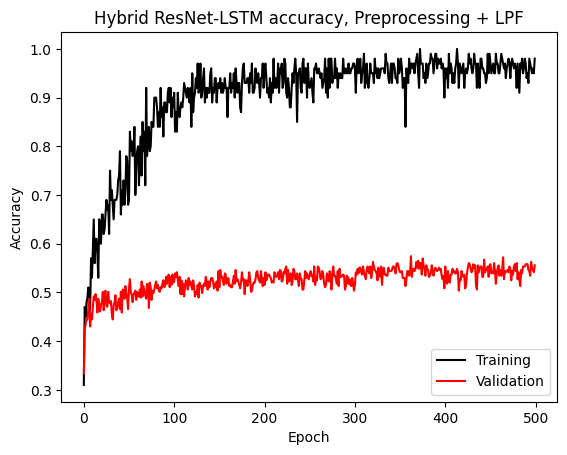

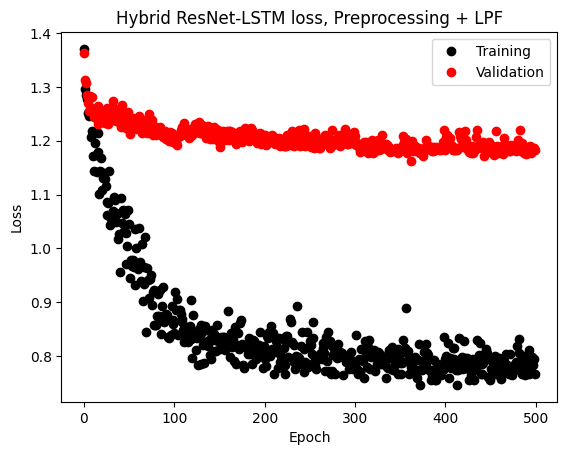

In [ ]:
#Update arrays and title
plt.plot(np.arange(num_epochs),train_history_3,label='Training',color='k')
plt.plot(np.arange(num_epochs),val_history_3,label='Validation',color='r')
plt.title('Hybrid ResNet-LSTM accuracy, Preprocessing + LPF')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(np.arange(num_epochs),train_loss_hist_3,'o',label='Training',color='k')
plt.plot(np.arange(num_epochs),val_loss_hist_3,'o',label='Validation',color='r')
plt.title('Hybrid ResNet-LSTM loss, Preprocessing + LPF')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Part 4: High pass filter after data preprocessing

In [ ]:
## Randomly split the train/validation dataset
ind_valid = np.random.choice(X_train_valid.shape[0], int(X_train_valid.shape[0]/5), replace=False)
ind_train = np.array(list(set(range(X_train_valid.shape[0])).difference(set(ind_valid))))
x_valid, y_valid = X_train_valid[ind_valid], y_train_valid[ind_valid]
x_train, y_train = X_train_valid[ind_train], y_train_valid[ind_train]
print('Training and Validation shapes before preprocessing: ')
print('X train: ', x_train.shape, ' Y train: ', y_train.shape)
print('X val: ', x_valid.shape, ' Y val', y_valid.shape)

# Preprocessing the dataset
# pass only training data to train prep, val and test data to test prep

x_train,y_train = train_data_prep(x_train,y_train,2,2,True)
x_test, x_valid = test_data_prep(x_test), test_data_prep(x_valid)

x_train = torch.tensor(x_train).detach().float().to(device)
x_valid = torch.tensor(x_valid).detach().float().to(device)
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

# Converting the labels to categorical variables for multiclass classification
y_train, y_valid, y_test = torch.tensor(y_train).to(device), torch.tensor(y_valid).to(device), torch.tensor(y_test).to(device)
y_train = nn.functional.one_hot(y_train.long(), 4)
y_valid = nn.functional.one_hot(y_valid.long(), 4)
y_test = nn.functional.one_hot(y_test.long(), 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 2,3)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 2,3)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 2,3)
x_test = torch.tensor(x_test).detach().float().to(device)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

# Convert x train to numpy

x_train_np = x_train.cpu().numpy()
print(x_train_np.shape)

Training and Validation shapes before preprocessing: 
X train:  (1692, 22, 1000)  Y train:  (1692,)
X val:  (423, 22, 1000)  Y val (423,)
Shape of X after trimming: (1692, 22, 800)
Shape of X after maxpooling: (1692, 22, 400)
Shape of X after averaging+noise and concatenating: (3384, 22, 400)
Shape of X after subsampling and concatenating: (6768, 22, 400)
Shape of Y: (6768,)
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of X after trimming: (423, 22, 800)
Shape of X after maxpooling: (423, 22, 400)
Shape of training set: torch.Size([6768, 22, 400])
Shape of validation set: torch.Size([423, 22, 400])
Shape of training labels: (6768,)
Shape of validation labels: (423,)
Shape of training labels after categorical conversion: torch.Size([6768, 4])
Shape of validation labels after categorical conversion: torch.Size([423, 4])
Shape of test labels after categorical conversion: torch.Size([443, 4])
Shape of training set after adding width info: torc

In [ ]:
# Define the high-pass filter parameters
cutoff_frequency = 4  # Cut-off frequency in Hz
sampling_rate = 125  # Sampling rate in Hz (adjust based on your data)

# Design a Butterworth high-pass filter
order = 3  # Filter order
b, a = butter(N=order, Wn=cutoff_frequency / (0.5 * sampling_rate), btype='high', analog=False, output='ba')

x_train_hpf = np.zeros(x_train_np.shape)
# Apply the filter to the data
for i in range(x_train_np.shape[0]):
    for j in range(x_train_np.shape[2]):
        filtered_data = filtfilt(b, a, x_train_np[i,0,j,:])
        x_train_hpf[i,0,j,:] = filtered_data

x_train_hpf = torch.tensor(x_train_hpf).float().to(device)
print(x_train_hpf.shape)

torch.Size([6768, 1, 22, 400])


In [ ]:
#Build the model
model4 = ResNetLSTM(img_channels=1, block=BasicBlock, num_classes=4, time_dim=int(x_train.size(3)), dropout=0.6).to(device)
print(model4)
total_params = sum(p.numel() for p in model4.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model4.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

ResNetLSTM(
  (conv1): Conv2d(1, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
  (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(48, 48, kernel_size=(22, 1), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ELU(alpha=1.0, inplace=True)
  (res1): BasicBlock(
    (conv1): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout2d(p=0.6, inplace=False)
    (elu): ELU(alpha=1.0, inplace=True)
    (conv2): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2): Dropout2d(p=0.6, inplace=False)
    (shortcut): Identity()
  )
  (res2): BasicBlock(
    (conv1):

In [ ]:
# Choose Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model4.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
# Rename these lines between models
train_history_4, val_history_4 = np.array([]), np.array([])
train_loss_hist_4, val_loss_hist_4 = np.array([]), np.array([])

with TemporaryDirectory() as tempdir:
    save_folder = '/content/drive/MyDrive/C147_Final_Project/best_model_params'

    # Rename these lines between models
    best_model_params_path = os.path.join(save_folder, 'best_model4_params.pt')
    torch.save(model4.state_dict(), best_model_params_path)

    best_acc = 0.0
    bsz = 100
    num_epochs = 500
    iteration = 0
    total_it = num_epochs*int(x_train.shape[0]/bsz)
    for epoch_idx in tqdm(range(num_epochs)):
        # Set model to train mode - useful for layers such as BatchNorm or Dropout whose behaviors change between train/eval
        # Rename
        model4.train()

        train_count = 0
        train_correct_count = 0
        for i in range(int(x_train.shape[0]/bsz)):
            iteration+=1
            optimizer.zero_grad() # Zero gradients, since we don't want gradients to accumulate between batches - we apply an update for each batch
            train_x, train_y = sample(x_train, y_train, bsz)
            #Rename
            logits = model4(train_x) #bszx4x1x4

            logits = nn.functional.softmax(logits, dim=1)
            loss = criterion(logits.float(), train_y.float())

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                #y_hat = torch.mean(logits, dim = 2)
                y_hat = torch.argmax(logits, dim=1)
                train_correct_count = torch.sum(y_hat == torch.argmax(train_y, dim=1))
                train_count = train_x.size(0)
                train_count = float(train_count)
            #print(f'(Iteration {iteration}/{total_it})Training Accuracy: ', (train_correct_count/train_count).item(), '. Loss: ', loss.item())


        train_acc = train_correct_count / train_count

        #Rename
        model4.eval()
        val_count = 0
        val_correct_count = 0
        with torch.no_grad():
            val_x = x_valid
            val_y = y_valid
            #Rename
            logits = model4(val_x).detach()
            logits = nn.functional.softmax(logits)
            val_loss = criterion(logits.float(), val_y.float())
            with torch.no_grad():
                y_hat = torch.argmax(logits, dim=1)
                val_correct_count = torch.sum(y_hat == torch.argmax(val_y, dim=1))
                val_count = float(val_x.size(0))
        val_acc = val_correct_count / y_valid.shape[0]

        print(f'Epoch {epoch_idx+1} Finished!!!')
        print('Train acc: {:.3f}, Val acc: {:.3f}'.format(train_acc, val_acc))
        print('Train loss: {:.3f}, Val loss: {:.3f}'.format(loss, val_loss))

        #Rename
        train_history_4 = np.append(train_history_4, train_acc.item())
        val_history_4 = np.append(val_history_4, val_acc.item())
        train_loss_hist_4 = np.append(train_loss_hist_4, loss.item())
        val_loss_hist_4 = np.append(val_loss_hist_4, val_loss.item())

        if val_acc > best_acc:
            best_acc = val_acc
            #Rename
            torch.save(model4.state_dict(), best_model_params_path)

    print(f'Best val Acc: {best_acc:4f}')

  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-24-eb97f5b11815>:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = nn.functional.softmax(logits)
  0%|          | 1/500 [00:02<23:48,  2.86s/it]

Epoch 1 Finished!!!
Train acc: 0.410, Val acc: 0.366
Train loss: 1.340, Val loss: 1.349


  0%|          | 2/500 [00:05<22:07,  2.67s/it]

Epoch 2 Finished!!!
Train acc: 0.340, Val acc: 0.433
Train loss: 1.354, Val loss: 1.316


  1%|          | 3/500 [00:07<20:39,  2.49s/it]

Epoch 3 Finished!!!
Train acc: 0.460, Val acc: 0.459
Train loss: 1.315, Val loss: 1.304


  1%|          | 4/500 [00:09<19:57,  2.41s/it]

Epoch 4 Finished!!!
Train acc: 0.420, Val acc: 0.482
Train loss: 1.317, Val loss: 1.279


  1%|          | 5/500 [00:12<19:31,  2.37s/it]

Epoch 5 Finished!!!
Train acc: 0.490, Val acc: 0.466
Train loss: 1.267, Val loss: 1.280


  1%|          | 6/500 [00:14<19:18,  2.35s/it]

Epoch 6 Finished!!!
Train acc: 0.580, Val acc: 0.492
Train loss: 1.205, Val loss: 1.264


  1%|▏         | 7/500 [00:16<19:09,  2.33s/it]

Epoch 7 Finished!!!
Train acc: 0.540, Val acc: 0.456
Train loss: 1.230, Val loss: 1.272


  2%|▏         | 8/500 [00:19<19:05,  2.33s/it]

Epoch 8 Finished!!!
Train acc: 0.580, Val acc: 0.499
Train loss: 1.178, Val loss: 1.253


  2%|▏         | 9/500 [00:21<18:59,  2.32s/it]

Epoch 9 Finished!!!
Train acc: 0.540, Val acc: 0.494
Train loss: 1.233, Val loss: 1.242


  2%|▏         | 10/500 [00:23<18:54,  2.31s/it]

Epoch 10 Finished!!!
Train acc: 0.510, Val acc: 0.499
Train loss: 1.233, Val loss: 1.241


  2%|▏         | 11/500 [00:26<18:57,  2.33s/it]

Epoch 11 Finished!!!
Train acc: 0.550, Val acc: 0.501
Train loss: 1.199, Val loss: 1.241


  2%|▏         | 12/500 [00:28<19:59,  2.46s/it]

Epoch 12 Finished!!!
Train acc: 0.530, Val acc: 0.504
Train loss: 1.204, Val loss: 1.236


  3%|▎         | 13/500 [00:31<21:18,  2.63s/it]

Epoch 13 Finished!!!
Train acc: 0.470, Val acc: 0.506
Train loss: 1.255, Val loss: 1.234


  3%|▎         | 14/500 [00:34<20:56,  2.59s/it]

Epoch 14 Finished!!!
Train acc: 0.570, Val acc: 0.518
Train loss: 1.199, Val loss: 1.230


  3%|▎         | 15/500 [00:36<20:54,  2.59s/it]

Epoch 15 Finished!!!
Train acc: 0.560, Val acc: 0.508
Train loss: 1.180, Val loss: 1.234


  3%|▎         | 16/500 [00:39<21:03,  2.61s/it]

Epoch 16 Finished!!!
Train acc: 0.640, Val acc: 0.525
Train loss: 1.155, Val loss: 1.223


  3%|▎         | 17/500 [00:42<21:01,  2.61s/it]

Epoch 17 Finished!!!
Train acc: 0.620, Val acc: 0.525
Train loss: 1.139, Val loss: 1.212


  4%|▎         | 18/500 [00:44<20:21,  2.53s/it]

Epoch 18 Finished!!!
Train acc: 0.740, Val acc: 0.534
Train loss: 1.050, Val loss: 1.212


  4%|▍         | 19/500 [00:46<19:50,  2.48s/it]

Epoch 19 Finished!!!
Train acc: 0.620, Val acc: 0.515
Train loss: 1.138, Val loss: 1.224


  4%|▍         | 20/500 [00:49<19:28,  2.43s/it]

Epoch 20 Finished!!!
Train acc: 0.630, Val acc: 0.506
Train loss: 1.116, Val loss: 1.226


  4%|▍         | 21/500 [00:51<19:13,  2.41s/it]

Epoch 21 Finished!!!
Train acc: 0.680, Val acc: 0.442
Train loss: 1.101, Val loss: 1.267


  4%|▍         | 22/500 [00:53<19:02,  2.39s/it]

Epoch 22 Finished!!!
Train acc: 0.690, Val acc: 0.520
Train loss: 1.073, Val loss: 1.215


  5%|▍         | 23/500 [00:56<18:55,  2.38s/it]

Epoch 23 Finished!!!
Train acc: 0.670, Val acc: 0.534
Train loss: 1.098, Val loss: 1.203


  5%|▍         | 24/500 [00:58<18:50,  2.37s/it]

Epoch 24 Finished!!!
Train acc: 0.670, Val acc: 0.520
Train loss: 1.088, Val loss: 1.215


  5%|▌         | 25/500 [01:01<18:45,  2.37s/it]

Epoch 25 Finished!!!
Train acc: 0.660, Val acc: 0.506
Train loss: 1.095, Val loss: 1.222


  5%|▌         | 26/500 [01:03<18:41,  2.37s/it]

Epoch 26 Finished!!!
Train acc: 0.660, Val acc: 0.492
Train loss: 1.095, Val loss: 1.230


  5%|▌         | 27/500 [01:05<18:38,  2.37s/it]

Epoch 27 Finished!!!
Train acc: 0.670, Val acc: 0.525
Train loss: 1.106, Val loss: 1.203


  6%|▌         | 28/500 [01:08<19:01,  2.42s/it]

Epoch 28 Finished!!!
Train acc: 0.600, Val acc: 0.539
Train loss: 1.145, Val loss: 1.192


  6%|▌         | 29/500 [01:10<19:13,  2.45s/it]

Epoch 29 Finished!!!
Train acc: 0.800, Val acc: 0.532
Train loss: 0.991, Val loss: 1.202


  6%|▌         | 30/500 [01:13<19:06,  2.44s/it]

Epoch 30 Finished!!!
Train acc: 0.680, Val acc: 0.544
Train loss: 1.086, Val loss: 1.193


  6%|▌         | 31/500 [01:15<19:14,  2.46s/it]

Epoch 31 Finished!!!
Train acc: 0.720, Val acc: 0.525
Train loss: 1.032, Val loss: 1.190


  6%|▋         | 32/500 [01:18<19:10,  2.46s/it]

Epoch 32 Finished!!!
Train acc: 0.680, Val acc: 0.532
Train loss: 1.082, Val loss: 1.199


  7%|▋         | 33/500 [01:21<20:12,  2.60s/it]

Epoch 33 Finished!!!
Train acc: 0.740, Val acc: 0.553
Train loss: 1.014, Val loss: 1.179


  7%|▋         | 34/500 [01:23<20:12,  2.60s/it]

Epoch 34 Finished!!!
Train acc: 0.730, Val acc: 0.551
Train loss: 1.032, Val loss: 1.181


  7%|▋         | 35/500 [01:26<19:51,  2.56s/it]

Epoch 35 Finished!!!
Train acc: 0.770, Val acc: 0.558
Train loss: 1.001, Val loss: 1.176


  7%|▋         | 36/500 [01:28<19:23,  2.51s/it]

Epoch 36 Finished!!!
Train acc: 0.730, Val acc: 0.560
Train loss: 1.034, Val loss: 1.174


  7%|▋         | 37/500 [01:30<19:00,  2.46s/it]

Epoch 37 Finished!!!
Train acc: 0.670, Val acc: 0.548
Train loss: 1.072, Val loss: 1.179


  8%|▊         | 38/500 [01:33<18:43,  2.43s/it]

Epoch 38 Finished!!!
Train acc: 0.800, Val acc: 0.556
Train loss: 0.980, Val loss: 1.187


  8%|▊         | 39/500 [01:35<18:30,  2.41s/it]

Epoch 39 Finished!!!
Train acc: 0.710, Val acc: 0.532
Train loss: 1.030, Val loss: 1.189


  8%|▊         | 40/500 [01:38<18:21,  2.39s/it]

Epoch 40 Finished!!!
Train acc: 0.720, Val acc: 0.560
Train loss: 1.015, Val loss: 1.169


  8%|▊         | 41/500 [01:40<18:13,  2.38s/it]

Epoch 41 Finished!!!
Train acc: 0.770, Val acc: 0.560
Train loss: 0.990, Val loss: 1.180


  8%|▊         | 42/500 [01:42<18:06,  2.37s/it]

Epoch 42 Finished!!!
Train acc: 0.770, Val acc: 0.560
Train loss: 0.986, Val loss: 1.172


  9%|▊         | 43/500 [01:45<18:01,  2.37s/it]

Epoch 43 Finished!!!
Train acc: 0.780, Val acc: 0.548
Train loss: 0.976, Val loss: 1.175


  9%|▉         | 44/500 [01:47<17:59,  2.37s/it]

Epoch 44 Finished!!!
Train acc: 0.760, Val acc: 0.567
Train loss: 0.998, Val loss: 1.171


  9%|▉         | 45/500 [01:49<17:54,  2.36s/it]

Epoch 45 Finished!!!
Train acc: 0.850, Val acc: 0.541
Train loss: 0.914, Val loss: 1.188


  9%|▉         | 46/500 [01:52<17:54,  2.37s/it]

Epoch 46 Finished!!!
Train acc: 0.810, Val acc: 0.577
Train loss: 0.943, Val loss: 1.161


  9%|▉         | 47/500 [01:54<18:11,  2.41s/it]

Epoch 47 Finished!!!
Train acc: 0.790, Val acc: 0.567
Train loss: 0.979, Val loss: 1.171


 10%|▉         | 48/500 [01:57<18:26,  2.45s/it]

Epoch 48 Finished!!!
Train acc: 0.740, Val acc: 0.563
Train loss: 1.013, Val loss: 1.172


 10%|▉         | 49/500 [01:59<18:14,  2.43s/it]

Epoch 49 Finished!!!
Train acc: 0.780, Val acc: 0.563
Train loss: 0.969, Val loss: 1.171


 10%|█         | 50/500 [02:02<18:17,  2.44s/it]

Epoch 50 Finished!!!
Train acc: 0.870, Val acc: 0.527
Train loss: 0.898, Val loss: 1.196


 10%|█         | 51/500 [02:04<18:03,  2.41s/it]

Epoch 51 Finished!!!
Train acc: 0.790, Val acc: 0.567
Train loss: 0.959, Val loss: 1.166


 10%|█         | 52/500 [02:06<17:56,  2.40s/it]

Epoch 52 Finished!!!
Train acc: 0.840, Val acc: 0.560
Train loss: 0.920, Val loss: 1.182


 11%|█         | 53/500 [02:09<17:59,  2.42s/it]

Epoch 53 Finished!!!
Train acc: 0.760, Val acc: 0.541
Train loss: 0.959, Val loss: 1.188


 11%|█         | 54/500 [02:11<17:50,  2.40s/it]

Epoch 54 Finished!!!
Train acc: 0.820, Val acc: 0.539
Train loss: 0.943, Val loss: 1.191


 11%|█         | 55/500 [02:14<18:00,  2.43s/it]

Epoch 55 Finished!!!
Train acc: 0.820, Val acc: 0.551
Train loss: 0.944, Val loss: 1.186


 11%|█         | 56/500 [02:16<18:03,  2.44s/it]

Epoch 56 Finished!!!
Train acc: 0.860, Val acc: 0.556
Train loss: 0.903, Val loss: 1.181


 11%|█▏        | 57/500 [02:18<17:50,  2.42s/it]

Epoch 57 Finished!!!
Train acc: 0.880, Val acc: 0.558
Train loss: 0.879, Val loss: 1.177


 12%|█▏        | 58/500 [02:21<17:41,  2.40s/it]

Epoch 58 Finished!!!
Train acc: 0.890, Val acc: 0.544
Train loss: 0.867, Val loss: 1.182


 12%|█▏        | 59/500 [02:23<17:59,  2.45s/it]

Epoch 59 Finished!!!
Train acc: 0.920, Val acc: 0.577
Train loss: 0.830, Val loss: 1.166


 12%|█▏        | 60/500 [02:26<17:45,  2.42s/it]

Epoch 60 Finished!!!
Train acc: 0.810, Val acc: 0.558
Train loss: 0.942, Val loss: 1.175


 12%|█▏        | 61/500 [02:28<17:35,  2.40s/it]

Epoch 61 Finished!!!
Train acc: 0.850, Val acc: 0.553
Train loss: 0.915, Val loss: 1.167


 12%|█▏        | 62/500 [02:30<17:26,  2.39s/it]

Epoch 62 Finished!!!
Train acc: 0.880, Val acc: 0.546
Train loss: 0.881, Val loss: 1.174


 13%|█▎        | 63/500 [02:33<17:19,  2.38s/it]

Epoch 63 Finished!!!
Train acc: 0.900, Val acc: 0.567
Train loss: 0.844, Val loss: 1.170


 13%|█▎        | 64/500 [02:35<17:14,  2.37s/it]

Epoch 64 Finished!!!
Train acc: 0.870, Val acc: 0.558
Train loss: 0.883, Val loss: 1.176


 13%|█▎        | 65/500 [02:38<17:09,  2.37s/it]

Epoch 65 Finished!!!
Train acc: 0.850, Val acc: 0.541
Train loss: 0.898, Val loss: 1.185


 13%|█▎        | 66/500 [02:40<17:06,  2.36s/it]

Epoch 66 Finished!!!
Train acc: 0.900, Val acc: 0.556
Train loss: 0.865, Val loss: 1.178


 13%|█▎        | 67/500 [02:42<17:03,  2.36s/it]

Epoch 67 Finished!!!
Train acc: 0.840, Val acc: 0.506
Train loss: 0.919, Val loss: 1.208


 14%|█▎        | 68/500 [02:45<17:00,  2.36s/it]

Epoch 68 Finished!!!
Train acc: 0.890, Val acc: 0.532
Train loss: 0.870, Val loss: 1.198


 14%|█▍        | 69/500 [02:47<16:57,  2.36s/it]

Epoch 69 Finished!!!
Train acc: 0.850, Val acc: 0.551
Train loss: 0.911, Val loss: 1.180


 14%|█▍        | 70/500 [02:49<16:55,  2.36s/it]

Epoch 70 Finished!!!
Train acc: 0.890, Val acc: 0.527
Train loss: 0.859, Val loss: 1.198


 14%|█▍        | 71/500 [02:52<16:52,  2.36s/it]

Epoch 71 Finished!!!
Train acc: 0.850, Val acc: 0.553
Train loss: 0.898, Val loss: 1.187


 14%|█▍        | 72/500 [02:54<16:50,  2.36s/it]

Epoch 72 Finished!!!
Train acc: 0.850, Val acc: 0.553
Train loss: 0.894, Val loss: 1.177


 15%|█▍        | 73/500 [02:56<16:47,  2.36s/it]

Epoch 73 Finished!!!
Train acc: 0.850, Val acc: 0.539
Train loss: 0.886, Val loss: 1.195


 15%|█▍        | 74/500 [02:59<16:45,  2.36s/it]

Epoch 74 Finished!!!
Train acc: 0.890, Val acc: 0.548
Train loss: 0.866, Val loss: 1.180


 15%|█▌        | 75/500 [03:01<16:42,  2.36s/it]

Epoch 75 Finished!!!
Train acc: 0.880, Val acc: 0.567
Train loss: 0.881, Val loss: 1.177


 15%|█▌        | 76/500 [03:03<16:40,  2.36s/it]

Epoch 76 Finished!!!
Train acc: 0.900, Val acc: 0.532
Train loss: 0.848, Val loss: 1.200


 15%|█▌        | 77/500 [03:06<16:38,  2.36s/it]

Epoch 77 Finished!!!
Train acc: 0.850, Val acc: 0.534
Train loss: 0.891, Val loss: 1.200


 16%|█▌        | 78/500 [03:08<16:35,  2.36s/it]

Epoch 78 Finished!!!
Train acc: 0.880, Val acc: 0.530
Train loss: 0.863, Val loss: 1.195


 16%|█▌        | 79/500 [03:11<16:33,  2.36s/it]

Epoch 79 Finished!!!
Train acc: 0.940, Val acc: 0.530
Train loss: 0.828, Val loss: 1.208


 16%|█▌        | 80/500 [03:13<16:33,  2.37s/it]

Epoch 80 Finished!!!
Train acc: 0.850, Val acc: 0.544
Train loss: 0.889, Val loss: 1.196


 16%|█▌        | 81/500 [03:15<16:41,  2.39s/it]

Epoch 81 Finished!!!
Train acc: 0.900, Val acc: 0.537
Train loss: 0.851, Val loss: 1.193


 16%|█▋        | 82/500 [03:18<16:49,  2.42s/it]

Epoch 82 Finished!!!
Train acc: 0.900, Val acc: 0.522
Train loss: 0.862, Val loss: 1.196


 17%|█▋        | 83/500 [03:20<17:03,  2.46s/it]

Epoch 83 Finished!!!
Train acc: 0.890, Val acc: 0.558
Train loss: 0.864, Val loss: 1.184


 17%|█▋        | 84/500 [03:23<16:55,  2.44s/it]

Epoch 84 Finished!!!
Train acc: 0.880, Val acc: 0.525
Train loss: 0.880, Val loss: 1.203


 17%|█▋        | 85/500 [03:25<17:10,  2.48s/it]

Epoch 85 Finished!!!
Train acc: 0.900, Val acc: 0.537
Train loss: 0.854, Val loss: 1.195


 17%|█▋        | 86/500 [03:28<17:07,  2.48s/it]

Epoch 86 Finished!!!
Train acc: 0.890, Val acc: 0.515
Train loss: 0.882, Val loss: 1.219


 17%|█▋        | 87/500 [03:30<16:51,  2.45s/it]

Epoch 87 Finished!!!
Train acc: 0.920, Val acc: 0.534
Train loss: 0.842, Val loss: 1.190


 18%|█▊        | 88/500 [03:33<17:17,  2.52s/it]

Epoch 88 Finished!!!
Train acc: 0.910, Val acc: 0.541
Train loss: 0.837, Val loss: 1.195


 18%|█▊        | 89/500 [03:35<17:19,  2.53s/it]

Epoch 89 Finished!!!
Train acc: 0.920, Val acc: 0.530
Train loss: 0.822, Val loss: 1.192


 18%|█▊        | 90/500 [03:38<16:58,  2.48s/it]

Epoch 90 Finished!!!
Train acc: 0.950, Val acc: 0.546
Train loss: 0.802, Val loss: 1.185


 18%|█▊        | 91/500 [03:40<16:40,  2.45s/it]

Epoch 91 Finished!!!
Train acc: 0.880, Val acc: 0.541
Train loss: 0.859, Val loss: 1.192


 18%|█▊        | 92/500 [03:43<16:28,  2.42s/it]

Epoch 92 Finished!!!
Train acc: 0.910, Val acc: 0.537
Train loss: 0.845, Val loss: 1.194


 19%|█▊        | 93/500 [03:45<16:46,  2.47s/it]

Epoch 93 Finished!!!
Train acc: 0.930, Val acc: 0.548
Train loss: 0.826, Val loss: 1.185


 19%|█▉        | 94/500 [03:48<17:37,  2.60s/it]

Epoch 94 Finished!!!
Train acc: 0.910, Val acc: 0.556
Train loss: 0.851, Val loss: 1.183


 19%|█▉        | 95/500 [03:51<17:10,  2.54s/it]

Epoch 95 Finished!!!
Train acc: 0.960, Val acc: 0.548
Train loss: 0.798, Val loss: 1.186


 19%|█▉        | 96/500 [03:53<16:47,  2.49s/it]

Epoch 96 Finished!!!
Train acc: 0.910, Val acc: 0.556
Train loss: 0.839, Val loss: 1.185


 19%|█▉        | 97/500 [03:55<16:29,  2.46s/it]

Epoch 97 Finished!!!
Train acc: 0.860, Val acc: 0.556
Train loss: 0.882, Val loss: 1.191


 20%|█▉        | 98/500 [03:58<16:15,  2.43s/it]

Epoch 98 Finished!!!
Train acc: 0.870, Val acc: 0.546
Train loss: 0.871, Val loss: 1.188


 20%|█▉        | 99/500 [04:00<16:05,  2.41s/it]

Epoch 99 Finished!!!
Train acc: 0.870, Val acc: 0.532
Train loss: 0.886, Val loss: 1.193


 20%|██        | 100/500 [04:02<15:57,  2.39s/it]

Epoch 100 Finished!!!
Train acc: 0.950, Val acc: 0.563
Train loss: 0.802, Val loss: 1.174


 20%|██        | 101/500 [04:05<15:55,  2.39s/it]

Epoch 101 Finished!!!
Train acc: 0.900, Val acc: 0.537
Train loss: 0.849, Val loss: 1.193


 20%|██        | 102/500 [04:07<15:57,  2.41s/it]

Epoch 102 Finished!!!
Train acc: 0.940, Val acc: 0.553
Train loss: 0.812, Val loss: 1.181


 21%|██        | 103/500 [04:10<15:51,  2.40s/it]

Epoch 103 Finished!!!
Train acc: 0.930, Val acc: 0.558
Train loss: 0.830, Val loss: 1.176


 21%|██        | 104/500 [04:12<16:01,  2.43s/it]

Epoch 104 Finished!!!
Train acc: 0.940, Val acc: 0.548
Train loss: 0.820, Val loss: 1.181


 21%|██        | 105/500 [04:15<16:08,  2.45s/it]

Epoch 105 Finished!!!
Train acc: 0.920, Val acc: 0.525
Train loss: 0.831, Val loss: 1.200


 21%|██        | 106/500 [04:17<15:57,  2.43s/it]

Epoch 106 Finished!!!
Train acc: 0.950, Val acc: 0.532
Train loss: 0.807, Val loss: 1.192


 21%|██▏       | 107/500 [04:19<15:49,  2.42s/it]

Epoch 107 Finished!!!
Train acc: 0.930, Val acc: 0.556
Train loss: 0.823, Val loss: 1.184


 22%|██▏       | 108/500 [04:22<15:39,  2.40s/it]

Epoch 108 Finished!!!
Train acc: 0.950, Val acc: 0.522
Train loss: 0.810, Val loss: 1.204


 22%|██▏       | 109/500 [04:24<15:37,  2.40s/it]

Epoch 109 Finished!!!
Train acc: 0.970, Val acc: 0.530
Train loss: 0.779, Val loss: 1.201


 22%|██▏       | 110/500 [04:27<15:40,  2.41s/it]

Epoch 110 Finished!!!
Train acc: 0.940, Val acc: 0.520
Train loss: 0.822, Val loss: 1.205


 22%|██▏       | 111/500 [04:29<15:31,  2.40s/it]

Epoch 111 Finished!!!
Train acc: 0.930, Val acc: 0.541
Train loss: 0.813, Val loss: 1.195


 22%|██▏       | 112/500 [04:31<15:26,  2.39s/it]

Epoch 112 Finished!!!
Train acc: 0.920, Val acc: 0.544
Train loss: 0.832, Val loss: 1.197


 23%|██▎       | 113/500 [04:34<15:22,  2.38s/it]

Epoch 113 Finished!!!
Train acc: 0.940, Val acc: 0.520
Train loss: 0.812, Val loss: 1.202


 23%|██▎       | 114/500 [04:36<15:16,  2.37s/it]

Epoch 114 Finished!!!
Train acc: 0.920, Val acc: 0.532
Train loss: 0.841, Val loss: 1.202


 23%|██▎       | 115/500 [04:38<15:26,  2.41s/it]

Epoch 115 Finished!!!
Train acc: 0.930, Val acc: 0.546
Train loss: 0.824, Val loss: 1.193


 23%|██▎       | 116/500 [04:41<15:32,  2.43s/it]

Epoch 116 Finished!!!
Train acc: 0.980, Val acc: 0.544
Train loss: 0.776, Val loss: 1.188


 23%|██▎       | 117/500 [04:43<15:30,  2.43s/it]

Epoch 117 Finished!!!
Train acc: 0.870, Val acc: 0.553
Train loss: 0.882, Val loss: 1.190


 24%|██▎       | 118/500 [04:46<15:20,  2.41s/it]

Epoch 118 Finished!!!
Train acc: 0.960, Val acc: 0.522
Train loss: 0.792, Val loss: 1.205


 24%|██▍       | 119/500 [04:48<15:13,  2.40s/it]

Epoch 119 Finished!!!
Train acc: 0.940, Val acc: 0.556
Train loss: 0.812, Val loss: 1.178


 24%|██▍       | 120/500 [04:50<15:06,  2.38s/it]

Epoch 120 Finished!!!
Train acc: 0.940, Val acc: 0.556
Train loss: 0.809, Val loss: 1.182


 24%|██▍       | 121/500 [04:53<15:01,  2.38s/it]

Epoch 121 Finished!!!
Train acc: 0.930, Val acc: 0.530
Train loss: 0.820, Val loss: 1.194


 24%|██▍       | 122/500 [04:55<14:55,  2.37s/it]

Epoch 122 Finished!!!
Train acc: 0.980, Val acc: 0.553
Train loss: 0.776, Val loss: 1.183


 25%|██▍       | 123/500 [04:58<14:51,  2.37s/it]

Epoch 123 Finished!!!
Train acc: 0.930, Val acc: 0.530
Train loss: 0.821, Val loss: 1.204


 25%|██▍       | 124/500 [05:00<14:47,  2.36s/it]

Epoch 124 Finished!!!
Train acc: 0.910, Val acc: 0.553
Train loss: 0.842, Val loss: 1.188


 25%|██▌       | 125/500 [05:02<14:44,  2.36s/it]

Epoch 125 Finished!!!
Train acc: 0.930, Val acc: 0.558
Train loss: 0.812, Val loss: 1.181


 25%|██▌       | 126/500 [05:05<14:41,  2.36s/it]

Epoch 126 Finished!!!
Train acc: 0.940, Val acc: 0.563
Train loss: 0.811, Val loss: 1.175


 25%|██▌       | 127/500 [05:07<14:39,  2.36s/it]

Epoch 127 Finished!!!
Train acc: 0.970, Val acc: 0.530
Train loss: 0.787, Val loss: 1.197


 26%|██▌       | 128/500 [05:09<14:36,  2.36s/it]

Epoch 128 Finished!!!
Train acc: 0.940, Val acc: 0.539
Train loss: 0.812, Val loss: 1.202


 26%|██▌       | 129/500 [05:12<14:36,  2.36s/it]

Epoch 129 Finished!!!
Train acc: 0.930, Val acc: 0.520
Train loss: 0.823, Val loss: 1.206


 26%|██▌       | 130/500 [05:14<14:43,  2.39s/it]

Epoch 130 Finished!!!
Train acc: 0.950, Val acc: 0.530
Train loss: 0.806, Val loss: 1.199


 26%|██▌       | 131/500 [05:16<14:38,  2.38s/it]

Epoch 131 Finished!!!
Train acc: 0.940, Val acc: 0.544
Train loss: 0.819, Val loss: 1.193


 26%|██▋       | 132/500 [05:19<14:33,  2.37s/it]

Epoch 132 Finished!!!
Train acc: 0.910, Val acc: 0.522
Train loss: 0.831, Val loss: 1.201


 27%|██▋       | 133/500 [05:21<14:29,  2.37s/it]

Epoch 133 Finished!!!
Train acc: 0.960, Val acc: 0.527
Train loss: 0.790, Val loss: 1.194


 27%|██▋       | 134/500 [05:24<14:24,  2.36s/it]

Epoch 134 Finished!!!
Train acc: 0.920, Val acc: 0.548
Train loss: 0.829, Val loss: 1.197


 27%|██▋       | 135/500 [05:26<14:21,  2.36s/it]

Epoch 135 Finished!!!
Train acc: 0.940, Val acc: 0.539
Train loss: 0.810, Val loss: 1.197


 27%|██▋       | 136/500 [05:28<14:18,  2.36s/it]

Epoch 136 Finished!!!
Train acc: 0.950, Val acc: 0.541
Train loss: 0.793, Val loss: 1.195


 27%|██▋       | 137/500 [05:31<14:16,  2.36s/it]

Epoch 137 Finished!!!
Train acc: 0.940, Val acc: 0.553
Train loss: 0.810, Val loss: 1.189


 28%|██▊       | 138/500 [05:33<14:13,  2.36s/it]

Epoch 138 Finished!!!
Train acc: 0.950, Val acc: 0.544
Train loss: 0.801, Val loss: 1.192


 28%|██▊       | 139/500 [05:35<14:11,  2.36s/it]

Epoch 139 Finished!!!
Train acc: 0.920, Val acc: 0.537
Train loss: 0.827, Val loss: 1.201


 28%|██▊       | 140/500 [05:38<14:08,  2.36s/it]

Epoch 140 Finished!!!
Train acc: 0.920, Val acc: 0.518
Train loss: 0.829, Val loss: 1.213


 28%|██▊       | 141/500 [05:40<14:07,  2.36s/it]

Epoch 141 Finished!!!
Train acc: 0.980, Val acc: 0.525
Train loss: 0.774, Val loss: 1.206


 28%|██▊       | 142/500 [05:42<14:05,  2.36s/it]

Epoch 142 Finished!!!
Train acc: 0.950, Val acc: 0.525
Train loss: 0.800, Val loss: 1.207


 29%|██▊       | 143/500 [05:45<14:03,  2.36s/it]

Epoch 143 Finished!!!
Train acc: 0.970, Val acc: 0.558
Train loss: 0.783, Val loss: 1.188


 29%|██▉       | 144/500 [05:47<14:00,  2.36s/it]

Epoch 144 Finished!!!
Train acc: 0.970, Val acc: 0.527
Train loss: 0.783, Val loss: 1.209


 29%|██▉       | 145/500 [05:49<13:57,  2.36s/it]

Epoch 145 Finished!!!
Train acc: 0.910, Val acc: 0.544
Train loss: 0.838, Val loss: 1.197


 29%|██▉       | 146/500 [05:52<13:54,  2.36s/it]

Epoch 146 Finished!!!
Train acc: 0.900, Val acc: 0.527
Train loss: 0.852, Val loss: 1.208


 29%|██▉       | 147/500 [05:54<13:52,  2.36s/it]

Epoch 147 Finished!!!
Train acc: 0.940, Val acc: 0.544
Train loss: 0.804, Val loss: 1.195


 30%|██▉       | 148/500 [05:57<13:50,  2.36s/it]

Epoch 148 Finished!!!
Train acc: 0.940, Val acc: 0.546
Train loss: 0.806, Val loss: 1.187


 30%|██▉       | 149/500 [05:59<13:47,  2.36s/it]

Epoch 149 Finished!!!
Train acc: 0.940, Val acc: 0.534
Train loss: 0.811, Val loss: 1.198


 30%|███       | 150/500 [06:01<13:45,  2.36s/it]

Epoch 150 Finished!!!
Train acc: 0.910, Val acc: 0.544
Train loss: 0.842, Val loss: 1.195


 30%|███       | 151/500 [06:04<13:42,  2.36s/it]

Epoch 151 Finished!!!
Train acc: 0.940, Val acc: 0.534
Train loss: 0.811, Val loss: 1.199


 30%|███       | 152/500 [06:06<13:39,  2.36s/it]

Epoch 152 Finished!!!
Train acc: 0.970, Val acc: 0.527
Train loss: 0.778, Val loss: 1.204


 31%|███       | 153/500 [06:08<13:37,  2.36s/it]

Epoch 153 Finished!!!
Train acc: 0.930, Val acc: 0.532
Train loss: 0.818, Val loss: 1.202


 31%|███       | 154/500 [06:11<13:36,  2.36s/it]

Epoch 154 Finished!!!
Train acc: 0.950, Val acc: 0.513
Train loss: 0.801, Val loss: 1.213


 31%|███       | 155/500 [06:13<13:33,  2.36s/it]

Epoch 155 Finished!!!
Train acc: 0.930, Val acc: 0.532
Train loss: 0.818, Val loss: 1.203


 31%|███       | 156/500 [06:15<13:30,  2.36s/it]

Epoch 156 Finished!!!
Train acc: 0.990, Val acc: 0.525
Train loss: 0.760, Val loss: 1.207


 31%|███▏      | 157/500 [06:18<13:28,  2.36s/it]

Epoch 157 Finished!!!
Train acc: 0.930, Val acc: 0.530
Train loss: 0.817, Val loss: 1.209


 32%|███▏      | 158/500 [06:20<13:25,  2.36s/it]

Epoch 158 Finished!!!
Train acc: 0.860, Val acc: 0.530
Train loss: 0.870, Val loss: 1.204


 32%|███▏      | 159/500 [06:22<13:23,  2.36s/it]

Epoch 159 Finished!!!
Train acc: 0.960, Val acc: 0.530
Train loss: 0.786, Val loss: 1.201


 32%|███▏      | 160/500 [06:25<13:21,  2.36s/it]

Epoch 160 Finished!!!
Train acc: 0.920, Val acc: 0.511
Train loss: 0.824, Val loss: 1.218


 32%|███▏      | 161/500 [06:27<13:18,  2.36s/it]

Epoch 161 Finished!!!
Train acc: 0.880, Val acc: 0.541
Train loss: 0.869, Val loss: 1.192


 32%|███▏      | 162/500 [06:30<13:15,  2.36s/it]

Epoch 162 Finished!!!
Train acc: 0.930, Val acc: 0.532
Train loss: 0.823, Val loss: 1.198


 33%|███▎      | 163/500 [06:32<13:13,  2.35s/it]

Epoch 163 Finished!!!
Train acc: 0.940, Val acc: 0.546
Train loss: 0.803, Val loss: 1.189


 33%|███▎      | 164/500 [06:34<13:11,  2.36s/it]

Epoch 164 Finished!!!
Train acc: 0.940, Val acc: 0.551
Train loss: 0.809, Val loss: 1.187


 33%|███▎      | 165/500 [06:37<13:09,  2.36s/it]

Epoch 165 Finished!!!
Train acc: 0.950, Val acc: 0.537
Train loss: 0.799, Val loss: 1.199


 33%|███▎      | 166/500 [06:39<13:07,  2.36s/it]

Epoch 166 Finished!!!
Train acc: 0.950, Val acc: 0.525
Train loss: 0.807, Val loss: 1.206


 33%|███▎      | 167/500 [06:41<13:05,  2.36s/it]

Epoch 167 Finished!!!
Train acc: 0.950, Val acc: 0.532
Train loss: 0.806, Val loss: 1.197


 34%|███▎      | 168/500 [06:44<13:02,  2.36s/it]

Epoch 168 Finished!!!
Train acc: 0.960, Val acc: 0.539
Train loss: 0.789, Val loss: 1.193


 34%|███▍      | 169/500 [06:46<13:00,  2.36s/it]

Epoch 169 Finished!!!
Train acc: 0.940, Val acc: 0.522
Train loss: 0.811, Val loss: 1.208


 34%|███▍      | 170/500 [06:48<12:58,  2.36s/it]

Epoch 170 Finished!!!
Train acc: 0.950, Val acc: 0.539
Train loss: 0.792, Val loss: 1.198


 34%|███▍      | 171/500 [06:51<12:56,  2.36s/it]

Epoch 171 Finished!!!
Train acc: 0.980, Val acc: 0.522
Train loss: 0.773, Val loss: 1.206


 34%|███▍      | 172/500 [06:53<12:54,  2.36s/it]

Epoch 172 Finished!!!
Train acc: 0.940, Val acc: 0.532
Train loss: 0.808, Val loss: 1.205


 35%|███▍      | 173/500 [06:55<12:51,  2.36s/it]

Epoch 173 Finished!!!
Train acc: 0.950, Val acc: 0.532
Train loss: 0.798, Val loss: 1.198


 35%|███▍      | 174/500 [06:58<12:48,  2.36s/it]

Epoch 174 Finished!!!
Train acc: 0.950, Val acc: 0.537
Train loss: 0.795, Val loss: 1.202


 35%|███▌      | 175/500 [07:00<13:07,  2.42s/it]

Epoch 175 Finished!!!
Train acc: 0.950, Val acc: 0.527
Train loss: 0.793, Val loss: 1.201


 35%|███▌      | 176/500 [07:03<12:58,  2.40s/it]

Epoch 176 Finished!!!
Train acc: 0.960, Val acc: 0.541
Train loss: 0.795, Val loss: 1.192


 35%|███▌      | 177/500 [07:05<12:51,  2.39s/it]

Epoch 177 Finished!!!
Train acc: 0.930, Val acc: 0.548
Train loss: 0.813, Val loss: 1.191


 36%|███▌      | 178/500 [07:07<12:45,  2.38s/it]

Epoch 178 Finished!!!
Train acc: 0.920, Val acc: 0.541
Train loss: 0.828, Val loss: 1.193


 36%|███▌      | 179/500 [07:10<12:41,  2.37s/it]

Epoch 179 Finished!!!
Train acc: 0.900, Val acc: 0.541
Train loss: 0.845, Val loss: 1.191


 36%|███▌      | 180/500 [07:12<12:37,  2.37s/it]

Epoch 180 Finished!!!
Train acc: 0.980, Val acc: 0.544
Train loss: 0.771, Val loss: 1.190


 36%|███▌      | 181/500 [07:15<12:34,  2.37s/it]

Epoch 181 Finished!!!
Train acc: 0.970, Val acc: 0.556
Train loss: 0.779, Val loss: 1.181


 36%|███▋      | 182/500 [07:17<12:31,  2.36s/it]

Epoch 182 Finished!!!
Train acc: 0.930, Val acc: 0.548
Train loss: 0.819, Val loss: 1.185


 37%|███▋      | 183/500 [07:19<12:28,  2.36s/it]

Epoch 183 Finished!!!
Train acc: 0.970, Val acc: 0.553
Train loss: 0.783, Val loss: 1.184


 37%|███▋      | 184/500 [07:22<12:25,  2.36s/it]

Epoch 184 Finished!!!
Train acc: 0.960, Val acc: 0.539
Train loss: 0.790, Val loss: 1.200


 37%|███▋      | 185/500 [07:24<12:22,  2.36s/it]

Epoch 185 Finished!!!
Train acc: 0.900, Val acc: 0.539
Train loss: 0.850, Val loss: 1.190


 37%|███▋      | 186/500 [07:26<12:20,  2.36s/it]

Epoch 186 Finished!!!
Train acc: 0.970, Val acc: 0.548
Train loss: 0.779, Val loss: 1.193


 37%|███▋      | 187/500 [07:29<12:18,  2.36s/it]

Epoch 187 Finished!!!
Train acc: 0.960, Val acc: 0.534
Train loss: 0.787, Val loss: 1.198


 38%|███▊      | 188/500 [07:31<12:16,  2.36s/it]

Epoch 188 Finished!!!
Train acc: 0.970, Val acc: 0.548
Train loss: 0.777, Val loss: 1.189


 38%|███▊      | 189/500 [07:33<12:13,  2.36s/it]

Epoch 189 Finished!!!
Train acc: 0.940, Val acc: 0.548
Train loss: 0.808, Val loss: 1.182


 38%|███▊      | 190/500 [07:36<12:11,  2.36s/it]

Epoch 190 Finished!!!
Train acc: 0.960, Val acc: 0.548
Train loss: 0.785, Val loss: 1.183


 38%|███▊      | 191/500 [07:38<12:08,  2.36s/it]

Epoch 191 Finished!!!
Train acc: 0.970, Val acc: 0.551
Train loss: 0.777, Val loss: 1.187


 38%|███▊      | 192/500 [07:40<12:06,  2.36s/it]

Epoch 192 Finished!!!
Train acc: 0.880, Val acc: 0.544
Train loss: 0.862, Val loss: 1.190


 39%|███▊      | 193/500 [07:43<12:03,  2.36s/it]

Epoch 193 Finished!!!
Train acc: 0.970, Val acc: 0.530
Train loss: 0.776, Val loss: 1.197


 39%|███▉      | 194/500 [07:45<12:01,  2.36s/it]

Epoch 194 Finished!!!
Train acc: 0.970, Val acc: 0.530
Train loss: 0.775, Val loss: 1.202


 39%|███▉      | 195/500 [07:48<11:59,  2.36s/it]

Epoch 195 Finished!!!
Train acc: 0.930, Val acc: 0.511
Train loss: 0.820, Val loss: 1.215


 39%|███▉      | 196/500 [07:50<11:56,  2.36s/it]

Epoch 196 Finished!!!
Train acc: 0.980, Val acc: 0.522
Train loss: 0.769, Val loss: 1.205


 39%|███▉      | 197/500 [07:52<11:54,  2.36s/it]

Epoch 197 Finished!!!
Train acc: 0.970, Val acc: 0.530
Train loss: 0.780, Val loss: 1.203


 40%|███▉      | 198/500 [07:55<11:52,  2.36s/it]

Epoch 198 Finished!!!
Train acc: 0.950, Val acc: 0.522
Train loss: 0.797, Val loss: 1.215


 40%|███▉      | 199/500 [07:57<11:49,  2.36s/it]

Epoch 199 Finished!!!
Train acc: 0.930, Val acc: 0.544
Train loss: 0.826, Val loss: 1.199


 40%|████      | 200/500 [07:59<11:46,  2.36s/it]

Epoch 200 Finished!!!
Train acc: 0.940, Val acc: 0.537
Train loss: 0.797, Val loss: 1.195


 40%|████      | 201/500 [08:02<11:44,  2.36s/it]

Epoch 201 Finished!!!
Train acc: 0.960, Val acc: 0.548
Train loss: 0.793, Val loss: 1.186


 40%|████      | 202/500 [08:04<11:42,  2.36s/it]

Epoch 202 Finished!!!
Train acc: 0.950, Val acc: 0.548
Train loss: 0.802, Val loss: 1.196


 41%|████      | 203/500 [08:06<11:40,  2.36s/it]

Epoch 203 Finished!!!
Train acc: 0.940, Val acc: 0.544
Train loss: 0.808, Val loss: 1.183


 41%|████      | 204/500 [08:09<11:37,  2.36s/it]

Epoch 204 Finished!!!
Train acc: 0.930, Val acc: 0.544
Train loss: 0.817, Val loss: 1.194


 41%|████      | 205/500 [08:11<11:35,  2.36s/it]

Epoch 205 Finished!!!
Train acc: 0.930, Val acc: 0.541
Train loss: 0.816, Val loss: 1.203


 41%|████      | 206/500 [08:14<11:33,  2.36s/it]

Epoch 206 Finished!!!
Train acc: 0.960, Val acc: 0.532
Train loss: 0.787, Val loss: 1.199


 41%|████▏     | 207/500 [08:16<11:31,  2.36s/it]

Epoch 207 Finished!!!
Train acc: 0.960, Val acc: 0.530
Train loss: 0.787, Val loss: 1.205


 42%|████▏     | 208/500 [08:18<11:29,  2.36s/it]

Epoch 208 Finished!!!
Train acc: 0.950, Val acc: 0.537
Train loss: 0.798, Val loss: 1.197


 42%|████▏     | 209/500 [08:21<11:26,  2.36s/it]

Epoch 209 Finished!!!
Train acc: 0.950, Val acc: 0.537
Train loss: 0.797, Val loss: 1.196


 42%|████▏     | 210/500 [08:23<11:24,  2.36s/it]

Epoch 210 Finished!!!
Train acc: 0.960, Val acc: 0.541
Train loss: 0.785, Val loss: 1.193


 42%|████▏     | 211/500 [08:25<11:21,  2.36s/it]

Epoch 211 Finished!!!
Train acc: 0.920, Val acc: 0.527
Train loss: 0.827, Val loss: 1.200


 42%|████▏     | 212/500 [08:28<11:19,  2.36s/it]

Epoch 212 Finished!!!
Train acc: 0.960, Val acc: 0.541
Train loss: 0.787, Val loss: 1.191


 43%|████▎     | 213/500 [08:30<11:16,  2.36s/it]

Epoch 213 Finished!!!
Train acc: 0.970, Val acc: 0.539
Train loss: 0.784, Val loss: 1.196


 43%|████▎     | 214/500 [08:32<11:14,  2.36s/it]

Epoch 214 Finished!!!
Train acc: 0.960, Val acc: 0.530
Train loss: 0.786, Val loss: 1.204


 43%|████▎     | 215/500 [08:35<11:12,  2.36s/it]

Epoch 215 Finished!!!
Train acc: 0.950, Val acc: 0.511
Train loss: 0.795, Val loss: 1.219


 43%|████▎     | 216/500 [08:37<11:09,  2.36s/it]

Epoch 216 Finished!!!
Train acc: 0.970, Val acc: 0.522
Train loss: 0.781, Val loss: 1.209


 43%|████▎     | 217/500 [08:39<11:07,  2.36s/it]

Epoch 217 Finished!!!
Train acc: 0.960, Val acc: 0.544
Train loss: 0.795, Val loss: 1.196


 44%|████▎     | 218/500 [08:42<11:05,  2.36s/it]

Epoch 218 Finished!!!
Train acc: 0.990, Val acc: 0.525
Train loss: 0.757, Val loss: 1.206


 44%|████▍     | 219/500 [08:44<11:03,  2.36s/it]

Epoch 219 Finished!!!
Train acc: 0.900, Val acc: 0.541
Train loss: 0.845, Val loss: 1.198


 44%|████▍     | 220/500 [08:47<11:00,  2.36s/it]

Epoch 220 Finished!!!
Train acc: 0.970, Val acc: 0.539
Train loss: 0.778, Val loss: 1.193


 44%|████▍     | 221/500 [08:49<10:57,  2.36s/it]

Epoch 221 Finished!!!
Train acc: 0.970, Val acc: 0.546
Train loss: 0.779, Val loss: 1.190


 44%|████▍     | 222/500 [08:51<10:55,  2.36s/it]

Epoch 222 Finished!!!
Train acc: 0.940, Val acc: 0.539
Train loss: 0.807, Val loss: 1.198


 45%|████▍     | 223/500 [08:54<10:53,  2.36s/it]

Epoch 223 Finished!!!
Train acc: 0.980, Val acc: 0.522
Train loss: 0.767, Val loss: 1.207


 45%|████▍     | 224/500 [08:56<10:51,  2.36s/it]

Epoch 224 Finished!!!
Train acc: 0.920, Val acc: 0.527
Train loss: 0.836, Val loss: 1.210


 45%|████▌     | 225/500 [08:58<10:48,  2.36s/it]

Epoch 225 Finished!!!
Train acc: 0.940, Val acc: 0.520
Train loss: 0.806, Val loss: 1.204


 45%|████▌     | 226/500 [09:01<10:46,  2.36s/it]

Epoch 226 Finished!!!
Train acc: 0.940, Val acc: 0.537
Train loss: 0.811, Val loss: 1.200


 45%|████▌     | 227/500 [09:03<10:43,  2.36s/it]

Epoch 227 Finished!!!
Train acc: 0.940, Val acc: 0.522
Train loss: 0.811, Val loss: 1.209


 46%|████▌     | 228/500 [09:05<10:40,  2.36s/it]

Epoch 228 Finished!!!
Train acc: 0.970, Val acc: 0.520
Train loss: 0.779, Val loss: 1.212


 46%|████▌     | 229/500 [09:08<10:38,  2.36s/it]

Epoch 229 Finished!!!
Train acc: 0.970, Val acc: 0.511
Train loss: 0.781, Val loss: 1.219


 46%|████▌     | 230/500 [09:10<10:37,  2.36s/it]

Epoch 230 Finished!!!
Train acc: 0.980, Val acc: 0.527
Train loss: 0.770, Val loss: 1.205


 46%|████▌     | 231/500 [09:12<10:34,  2.36s/it]

Epoch 231 Finished!!!
Train acc: 0.940, Val acc: 0.527
Train loss: 0.806, Val loss: 1.205


 46%|████▋     | 232/500 [09:15<10:31,  2.36s/it]

Epoch 232 Finished!!!
Train acc: 0.950, Val acc: 0.537
Train loss: 0.795, Val loss: 1.195


 47%|████▋     | 233/500 [09:17<10:29,  2.36s/it]

Epoch 233 Finished!!!
Train acc: 0.930, Val acc: 0.548
Train loss: 0.819, Val loss: 1.193


 47%|████▋     | 234/500 [09:20<10:26,  2.36s/it]

Epoch 234 Finished!!!
Train acc: 0.950, Val acc: 0.532
Train loss: 0.794, Val loss: 1.206


 47%|████▋     | 235/500 [09:22<10:24,  2.36s/it]

Epoch 235 Finished!!!
Train acc: 0.950, Val acc: 0.548
Train loss: 0.801, Val loss: 1.184


 47%|████▋     | 236/500 [09:24<10:22,  2.36s/it]

Epoch 236 Finished!!!
Train acc: 0.970, Val acc: 0.534
Train loss: 0.782, Val loss: 1.203


 47%|████▋     | 237/500 [09:27<10:19,  2.36s/it]

Epoch 237 Finished!!!
Train acc: 0.970, Val acc: 0.544
Train loss: 0.781, Val loss: 1.196


 48%|████▊     | 238/500 [09:29<10:17,  2.36s/it]

Epoch 238 Finished!!!
Train acc: 0.920, Val acc: 0.539
Train loss: 0.826, Val loss: 1.195


 48%|████▊     | 239/500 [09:31<10:14,  2.36s/it]

Epoch 239 Finished!!!
Train acc: 0.950, Val acc: 0.539
Train loss: 0.801, Val loss: 1.201


 48%|████▊     | 240/500 [09:34<10:12,  2.36s/it]

Epoch 240 Finished!!!
Train acc: 0.950, Val acc: 0.522
Train loss: 0.798, Val loss: 1.214


 48%|████▊     | 241/500 [09:36<10:11,  2.36s/it]

Epoch 241 Finished!!!
Train acc: 0.970, Val acc: 0.539
Train loss: 0.780, Val loss: 1.195


 48%|████▊     | 242/500 [09:38<10:08,  2.36s/it]

Epoch 242 Finished!!!
Train acc: 0.920, Val acc: 0.527
Train loss: 0.822, Val loss: 1.205


 49%|████▊     | 243/500 [09:41<10:06,  2.36s/it]

Epoch 243 Finished!!!
Train acc: 0.980, Val acc: 0.544
Train loss: 0.766, Val loss: 1.193


 49%|████▉     | 244/500 [09:43<10:03,  2.36s/it]

Epoch 244 Finished!!!
Train acc: 0.980, Val acc: 0.546
Train loss: 0.762, Val loss: 1.195


 49%|████▉     | 245/500 [09:45<10:01,  2.36s/it]

Epoch 245 Finished!!!
Train acc: 0.950, Val acc: 0.544
Train loss: 0.798, Val loss: 1.192


 49%|████▉     | 246/500 [09:48<09:59,  2.36s/it]

Epoch 246 Finished!!!
Train acc: 0.980, Val acc: 0.527
Train loss: 0.773, Val loss: 1.208


 49%|████▉     | 247/500 [09:50<09:56,  2.36s/it]

Epoch 247 Finished!!!
Train acc: 0.980, Val acc: 0.527
Train loss: 0.768, Val loss: 1.210


 50%|████▉     | 248/500 [09:53<09:54,  2.36s/it]

Epoch 248 Finished!!!
Train acc: 0.980, Val acc: 0.525
Train loss: 0.765, Val loss: 1.208


 50%|████▉     | 249/500 [09:55<09:52,  2.36s/it]

Epoch 249 Finished!!!
Train acc: 0.920, Val acc: 0.546
Train loss: 0.819, Val loss: 1.197


 50%|█████     | 250/500 [09:57<09:49,  2.36s/it]

Epoch 250 Finished!!!
Train acc: 0.970, Val acc: 0.541
Train loss: 0.776, Val loss: 1.192


 50%|█████     | 251/500 [10:00<09:47,  2.36s/it]

Epoch 251 Finished!!!
Train acc: 0.940, Val acc: 0.539
Train loss: 0.806, Val loss: 1.195


 50%|█████     | 252/500 [10:02<09:45,  2.36s/it]

Epoch 252 Finished!!!
Train acc: 0.960, Val acc: 0.546
Train loss: 0.781, Val loss: 1.192


 51%|█████     | 253/500 [10:04<09:42,  2.36s/it]

Epoch 253 Finished!!!
Train acc: 0.940, Val acc: 0.560
Train loss: 0.807, Val loss: 1.181


 51%|█████     | 254/500 [10:07<09:40,  2.36s/it]

Epoch 254 Finished!!!
Train acc: 0.980, Val acc: 0.556
Train loss: 0.774, Val loss: 1.187


 51%|█████     | 255/500 [10:09<09:37,  2.36s/it]

Epoch 255 Finished!!!
Train acc: 0.980, Val acc: 0.546
Train loss: 0.768, Val loss: 1.191


 51%|█████     | 256/500 [10:11<09:35,  2.36s/it]

Epoch 256 Finished!!!
Train acc: 0.950, Val acc: 0.553
Train loss: 0.794, Val loss: 1.187


 51%|█████▏    | 257/500 [10:14<09:33,  2.36s/it]

Epoch 257 Finished!!!
Train acc: 0.960, Val acc: 0.530
Train loss: 0.786, Val loss: 1.197


 52%|█████▏    | 258/500 [10:16<09:30,  2.36s/it]

Epoch 258 Finished!!!
Train acc: 0.970, Val acc: 0.539
Train loss: 0.781, Val loss: 1.197


 52%|█████▏    | 259/500 [10:18<09:28,  2.36s/it]

Epoch 259 Finished!!!
Train acc: 0.940, Val acc: 0.539
Train loss: 0.808, Val loss: 1.197


 52%|█████▏    | 260/500 [10:21<09:25,  2.36s/it]

Epoch 260 Finished!!!
Train acc: 0.960, Val acc: 0.546
Train loss: 0.792, Val loss: 1.192


 52%|█████▏    | 261/500 [10:23<09:23,  2.36s/it]

Epoch 261 Finished!!!
Train acc: 0.960, Val acc: 0.556
Train loss: 0.787, Val loss: 1.188


 52%|█████▏    | 262/500 [10:26<09:21,  2.36s/it]

Epoch 262 Finished!!!
Train acc: 0.960, Val acc: 0.527
Train loss: 0.790, Val loss: 1.205


 53%|█████▎    | 263/500 [10:28<09:18,  2.36s/it]

Epoch 263 Finished!!!
Train acc: 0.970, Val acc: 0.537
Train loss: 0.783, Val loss: 1.192


 53%|█████▎    | 264/500 [10:30<09:16,  2.36s/it]

Epoch 264 Finished!!!
Train acc: 0.960, Val acc: 0.530
Train loss: 0.794, Val loss: 1.210


 53%|█████▎    | 265/500 [10:33<09:13,  2.36s/it]

Epoch 265 Finished!!!
Train acc: 0.940, Val acc: 0.551
Train loss: 0.810, Val loss: 1.184


 53%|█████▎    | 266/500 [10:35<09:11,  2.36s/it]

Epoch 266 Finished!!!
Train acc: 0.920, Val acc: 0.553
Train loss: 0.827, Val loss: 1.188


 53%|█████▎    | 267/500 [10:37<09:09,  2.36s/it]

Epoch 267 Finished!!!
Train acc: 0.960, Val acc: 0.553
Train loss: 0.798, Val loss: 1.187


 54%|█████▎    | 268/500 [10:40<09:07,  2.36s/it]

Epoch 268 Finished!!!
Train acc: 0.950, Val acc: 0.532
Train loss: 0.798, Val loss: 1.191


 54%|█████▍    | 269/500 [10:42<09:04,  2.36s/it]

Epoch 269 Finished!!!
Train acc: 0.960, Val acc: 0.548
Train loss: 0.787, Val loss: 1.191


 54%|█████▍    | 270/500 [10:44<09:02,  2.36s/it]

Epoch 270 Finished!!!
Train acc: 0.980, Val acc: 0.558
Train loss: 0.767, Val loss: 1.181


 54%|█████▍    | 271/500 [10:47<09:00,  2.36s/it]

Epoch 271 Finished!!!
Train acc: 0.950, Val acc: 0.556
Train loss: 0.795, Val loss: 1.185


 54%|█████▍    | 272/500 [10:49<08:57,  2.36s/it]

Epoch 272 Finished!!!
Train acc: 0.990, Val acc: 0.534
Train loss: 0.759, Val loss: 1.191


 55%|█████▍    | 273/500 [10:52<08:55,  2.36s/it]

Epoch 273 Finished!!!
Train acc: 0.980, Val acc: 0.530
Train loss: 0.773, Val loss: 1.200


 55%|█████▍    | 274/500 [10:54<08:53,  2.36s/it]

Epoch 274 Finished!!!
Train acc: 0.980, Val acc: 0.544
Train loss: 0.769, Val loss: 1.196


 55%|█████▌    | 275/500 [10:56<08:50,  2.36s/it]

Epoch 275 Finished!!!
Train acc: 1.000, Val acc: 0.553
Train loss: 0.747, Val loss: 1.184


 55%|█████▌    | 276/500 [10:59<08:47,  2.36s/it]

Epoch 276 Finished!!!
Train acc: 0.950, Val acc: 0.546
Train loss: 0.797, Val loss: 1.190


 55%|█████▌    | 277/500 [11:01<08:45,  2.36s/it]

Epoch 277 Finished!!!
Train acc: 0.960, Val acc: 0.534
Train loss: 0.785, Val loss: 1.195


 56%|█████▌    | 278/500 [11:03<08:43,  2.36s/it]

Epoch 278 Finished!!!
Train acc: 0.910, Val acc: 0.553
Train loss: 0.837, Val loss: 1.183


 56%|█████▌    | 279/500 [11:06<08:41,  2.36s/it]

Epoch 279 Finished!!!
Train acc: 0.980, Val acc: 0.548
Train loss: 0.770, Val loss: 1.187


 56%|█████▌    | 280/500 [11:08<08:38,  2.36s/it]

Epoch 280 Finished!!!
Train acc: 0.970, Val acc: 0.551
Train loss: 0.776, Val loss: 1.186


 56%|█████▌    | 281/500 [11:10<08:36,  2.36s/it]

Epoch 281 Finished!!!
Train acc: 0.970, Val acc: 0.534
Train loss: 0.775, Val loss: 1.195


 56%|█████▋    | 282/500 [11:13<08:33,  2.36s/it]

Epoch 282 Finished!!!
Train acc: 0.980, Val acc: 0.546
Train loss: 0.770, Val loss: 1.194


 57%|█████▋    | 283/500 [11:15<08:31,  2.36s/it]

Epoch 283 Finished!!!
Train acc: 0.940, Val acc: 0.532
Train loss: 0.817, Val loss: 1.196


 57%|█████▋    | 284/500 [11:17<08:29,  2.36s/it]

Epoch 284 Finished!!!
Train acc: 0.960, Val acc: 0.518
Train loss: 0.797, Val loss: 1.211


 57%|█████▋    | 285/500 [11:20<08:27,  2.36s/it]

Epoch 285 Finished!!!
Train acc: 0.970, Val acc: 0.532
Train loss: 0.778, Val loss: 1.199


 57%|█████▋    | 286/500 [11:22<08:24,  2.36s/it]

Epoch 286 Finished!!!
Train acc: 0.990, Val acc: 0.527
Train loss: 0.758, Val loss: 1.200


 57%|█████▋    | 287/500 [11:25<08:22,  2.36s/it]

Epoch 287 Finished!!!
Train acc: 0.980, Val acc: 0.534
Train loss: 0.768, Val loss: 1.201


 58%|█████▊    | 288/500 [11:27<08:19,  2.36s/it]

Epoch 288 Finished!!!
Train acc: 0.930, Val acc: 0.534
Train loss: 0.819, Val loss: 1.204


 58%|█████▊    | 289/500 [11:29<08:17,  2.36s/it]

Epoch 289 Finished!!!
Train acc: 0.980, Val acc: 0.546
Train loss: 0.767, Val loss: 1.186


 58%|█████▊    | 290/500 [11:32<08:15,  2.36s/it]

Epoch 290 Finished!!!
Train acc: 0.960, Val acc: 0.525
Train loss: 0.789, Val loss: 1.205


 58%|█████▊    | 291/500 [11:34<08:13,  2.36s/it]

Epoch 291 Finished!!!
Train acc: 0.970, Val acc: 0.532
Train loss: 0.783, Val loss: 1.204


 58%|█████▊    | 292/500 [11:36<08:10,  2.36s/it]

Epoch 292 Finished!!!
Train acc: 0.950, Val acc: 0.527
Train loss: 0.798, Val loss: 1.210


 59%|█████▊    | 293/500 [11:39<08:08,  2.36s/it]

Epoch 293 Finished!!!
Train acc: 0.980, Val acc: 0.551
Train loss: 0.768, Val loss: 1.184


 59%|█████▉    | 294/500 [11:41<08:05,  2.36s/it]

Epoch 294 Finished!!!
Train acc: 0.990, Val acc: 0.532
Train loss: 0.758, Val loss: 1.196


 59%|█████▉    | 295/500 [11:43<08:03,  2.36s/it]

Epoch 295 Finished!!!
Train acc: 0.960, Val acc: 0.522
Train loss: 0.792, Val loss: 1.202


 59%|█████▉    | 296/500 [11:46<08:01,  2.36s/it]

Epoch 296 Finished!!!
Train acc: 0.950, Val acc: 0.518
Train loss: 0.802, Val loss: 1.210


 59%|█████▉    | 297/500 [11:48<07:58,  2.36s/it]

Epoch 297 Finished!!!
Train acc: 0.980, Val acc: 0.534
Train loss: 0.770, Val loss: 1.200


 60%|█████▉    | 298/500 [11:50<07:56,  2.36s/it]

Epoch 298 Finished!!!
Train acc: 0.970, Val acc: 0.553
Train loss: 0.782, Val loss: 1.178


 60%|█████▉    | 299/500 [11:53<07:53,  2.36s/it]

Epoch 299 Finished!!!
Train acc: 0.910, Val acc: 0.544
Train loss: 0.835, Val loss: 1.191


 60%|██████    | 300/500 [11:55<07:51,  2.36s/it]

Epoch 300 Finished!!!
Train acc: 0.970, Val acc: 0.525
Train loss: 0.782, Val loss: 1.208


 60%|██████    | 301/500 [11:58<07:49,  2.36s/it]

Epoch 301 Finished!!!
Train acc: 0.980, Val acc: 0.532
Train loss: 0.766, Val loss: 1.205


 60%|██████    | 302/500 [12:00<07:47,  2.36s/it]

Epoch 302 Finished!!!
Train acc: 0.950, Val acc: 0.537
Train loss: 0.797, Val loss: 1.195


 61%|██████    | 303/500 [12:02<07:44,  2.36s/it]

Epoch 303 Finished!!!
Train acc: 0.940, Val acc: 0.553
Train loss: 0.805, Val loss: 1.187


 61%|██████    | 304/500 [12:05<07:42,  2.36s/it]

Epoch 304 Finished!!!
Train acc: 0.980, Val acc: 0.548
Train loss: 0.766, Val loss: 1.187


 61%|██████    | 305/500 [12:07<07:40,  2.36s/it]

Epoch 305 Finished!!!
Train acc: 0.960, Val acc: 0.539
Train loss: 0.792, Val loss: 1.188


 61%|██████    | 306/500 [12:09<07:38,  2.36s/it]

Epoch 306 Finished!!!
Train acc: 0.990, Val acc: 0.546
Train loss: 0.759, Val loss: 1.187


 61%|██████▏   | 307/500 [12:12<07:35,  2.36s/it]

Epoch 307 Finished!!!
Train acc: 0.960, Val acc: 0.539
Train loss: 0.793, Val loss: 1.197


 62%|██████▏   | 308/500 [12:14<07:32,  2.36s/it]

Epoch 308 Finished!!!
Train acc: 0.960, Val acc: 0.548
Train loss: 0.786, Val loss: 1.192


 62%|██████▏   | 309/500 [12:16<07:30,  2.36s/it]

Epoch 309 Finished!!!
Train acc: 0.970, Val acc: 0.539
Train loss: 0.775, Val loss: 1.194


 62%|██████▏   | 310/500 [12:19<07:27,  2.36s/it]

Epoch 310 Finished!!!
Train acc: 1.000, Val acc: 0.548
Train loss: 0.748, Val loss: 1.192


 62%|██████▏   | 311/500 [12:21<07:25,  2.36s/it]

Epoch 311 Finished!!!
Train acc: 0.970, Val acc: 0.546
Train loss: 0.780, Val loss: 1.185


 62%|██████▏   | 312/500 [12:23<07:23,  2.36s/it]

Epoch 312 Finished!!!
Train acc: 0.990, Val acc: 0.530
Train loss: 0.757, Val loss: 1.201


 63%|██████▎   | 313/500 [12:26<07:20,  2.36s/it]

Epoch 313 Finished!!!
Train acc: 0.960, Val acc: 0.532
Train loss: 0.788, Val loss: 1.199


 63%|██████▎   | 314/500 [12:28<07:18,  2.36s/it]

Epoch 314 Finished!!!
Train acc: 0.970, Val acc: 0.560
Train loss: 0.780, Val loss: 1.183


 63%|██████▎   | 315/500 [12:31<07:15,  2.36s/it]

Epoch 315 Finished!!!
Train acc: 0.960, Val acc: 0.546
Train loss: 0.785, Val loss: 1.187


 63%|██████▎   | 316/500 [12:33<07:13,  2.36s/it]

Epoch 316 Finished!!!
Train acc: 0.990, Val acc: 0.544
Train loss: 0.762, Val loss: 1.197


 63%|██████▎   | 317/500 [12:35<07:11,  2.36s/it]

Epoch 317 Finished!!!
Train acc: 0.940, Val acc: 0.530
Train loss: 0.807, Val loss: 1.206


 64%|██████▎   | 318/500 [12:38<07:08,  2.36s/it]

Epoch 318 Finished!!!
Train acc: 0.970, Val acc: 0.515
Train loss: 0.783, Val loss: 1.211


 64%|██████▍   | 319/500 [12:40<07:06,  2.36s/it]

Epoch 319 Finished!!!
Train acc: 0.970, Val acc: 0.541
Train loss: 0.773, Val loss: 1.192


 64%|██████▍   | 320/500 [12:42<07:04,  2.36s/it]

Epoch 320 Finished!!!
Train acc: 0.940, Val acc: 0.544
Train loss: 0.811, Val loss: 1.195


 64%|██████▍   | 321/500 [12:45<07:01,  2.36s/it]

Epoch 321 Finished!!!
Train acc: 0.990, Val acc: 0.539
Train loss: 0.758, Val loss: 1.203


 64%|██████▍   | 322/500 [12:47<06:59,  2.36s/it]

Epoch 322 Finished!!!
Train acc: 0.970, Val acc: 0.534
Train loss: 0.779, Val loss: 1.198


 65%|██████▍   | 323/500 [12:49<06:57,  2.36s/it]

Epoch 323 Finished!!!
Train acc: 0.960, Val acc: 0.544
Train loss: 0.784, Val loss: 1.192


 65%|██████▍   | 324/500 [12:52<06:54,  2.36s/it]

Epoch 324 Finished!!!
Train acc: 1.000, Val acc: 0.556
Train loss: 0.746, Val loss: 1.180


 65%|██████▌   | 325/500 [12:54<06:52,  2.36s/it]

Epoch 325 Finished!!!
Train acc: 0.970, Val acc: 0.560
Train loss: 0.775, Val loss: 1.186


 65%|██████▌   | 326/500 [12:56<06:50,  2.36s/it]

Epoch 326 Finished!!!
Train acc: 0.970, Val acc: 0.546
Train loss: 0.775, Val loss: 1.189


 65%|██████▌   | 327/500 [12:59<06:48,  2.36s/it]

Epoch 327 Finished!!!
Train acc: 0.980, Val acc: 0.551
Train loss: 0.765, Val loss: 1.190


 66%|██████▌   | 328/500 [13:01<06:45,  2.36s/it]

Epoch 328 Finished!!!
Train acc: 0.930, Val acc: 0.530
Train loss: 0.812, Val loss: 1.198


 66%|██████▌   | 329/500 [13:04<06:43,  2.36s/it]

Epoch 329 Finished!!!
Train acc: 0.940, Val acc: 0.544
Train loss: 0.804, Val loss: 1.187


 66%|██████▌   | 330/500 [13:06<06:40,  2.36s/it]

Epoch 330 Finished!!!
Train acc: 0.980, Val acc: 0.544
Train loss: 0.768, Val loss: 1.195


 66%|██████▌   | 331/500 [13:08<06:38,  2.36s/it]

Epoch 331 Finished!!!
Train acc: 0.990, Val acc: 0.541
Train loss: 0.758, Val loss: 1.193


 66%|██████▋   | 332/500 [13:11<06:35,  2.36s/it]

Epoch 332 Finished!!!
Train acc: 0.950, Val acc: 0.501
Train loss: 0.800, Val loss: 1.224


 67%|██████▋   | 333/500 [13:13<06:33,  2.36s/it]

Epoch 333 Finished!!!
Train acc: 0.970, Val acc: 0.520
Train loss: 0.785, Val loss: 1.217


 67%|██████▋   | 334/500 [13:15<06:31,  2.36s/it]

Epoch 334 Finished!!!
Train acc: 0.980, Val acc: 0.527
Train loss: 0.772, Val loss: 1.206


 67%|██████▋   | 335/500 [13:18<06:28,  2.36s/it]

Epoch 335 Finished!!!
Train acc: 0.940, Val acc: 0.534
Train loss: 0.804, Val loss: 1.201


 67%|██████▋   | 336/500 [13:20<06:26,  2.36s/it]

Epoch 336 Finished!!!
Train acc: 0.990, Val acc: 0.534
Train loss: 0.766, Val loss: 1.194


 67%|██████▋   | 337/500 [13:22<06:24,  2.36s/it]

Epoch 337 Finished!!!
Train acc: 0.990, Val acc: 0.563
Train loss: 0.761, Val loss: 1.180


 68%|██████▊   | 338/500 [13:25<06:21,  2.36s/it]

Epoch 338 Finished!!!
Train acc: 0.970, Val acc: 0.539
Train loss: 0.781, Val loss: 1.192


 68%|██████▊   | 339/500 [13:27<06:19,  2.36s/it]

Epoch 339 Finished!!!
Train acc: 0.960, Val acc: 0.541
Train loss: 0.785, Val loss: 1.191


 68%|██████▊   | 340/500 [13:29<06:17,  2.36s/it]

Epoch 340 Finished!!!
Train acc: 0.980, Val acc: 0.537
Train loss: 0.766, Val loss: 1.197


 68%|██████▊   | 341/500 [13:32<06:14,  2.36s/it]

Epoch 341 Finished!!!
Train acc: 0.960, Val acc: 0.544
Train loss: 0.785, Val loss: 1.186


 68%|██████▊   | 342/500 [13:34<06:12,  2.36s/it]

Epoch 342 Finished!!!
Train acc: 0.970, Val acc: 0.537
Train loss: 0.777, Val loss: 1.198


 69%|██████▊   | 343/500 [13:37<06:10,  2.36s/it]

Epoch 343 Finished!!!
Train acc: 0.990, Val acc: 0.534
Train loss: 0.755, Val loss: 1.199


 69%|██████▉   | 344/500 [13:39<06:07,  2.36s/it]

Epoch 344 Finished!!!
Train acc: 0.970, Val acc: 0.534
Train loss: 0.779, Val loss: 1.204


 69%|██████▉   | 345/500 [13:41<06:05,  2.36s/it]

Epoch 345 Finished!!!
Train acc: 0.950, Val acc: 0.525
Train loss: 0.799, Val loss: 1.200


 69%|██████▉   | 346/500 [13:44<06:02,  2.36s/it]

Epoch 346 Finished!!!
Train acc: 0.970, Val acc: 0.537
Train loss: 0.775, Val loss: 1.202


 69%|██████▉   | 347/500 [13:46<06:00,  2.36s/it]

Epoch 347 Finished!!!
Train acc: 1.000, Val acc: 0.532
Train loss: 0.749, Val loss: 1.201


 70%|██████▉   | 348/500 [13:48<05:58,  2.36s/it]

Epoch 348 Finished!!!
Train acc: 0.950, Val acc: 0.537
Train loss: 0.795, Val loss: 1.196


 70%|██████▉   | 349/500 [13:51<05:56,  2.36s/it]

Epoch 349 Finished!!!
Train acc: 0.960, Val acc: 0.537
Train loss: 0.785, Val loss: 1.183


 70%|███████   | 350/500 [13:53<05:53,  2.36s/it]

Epoch 350 Finished!!!
Train acc: 0.980, Val acc: 0.527
Train loss: 0.769, Val loss: 1.204


 70%|███████   | 351/500 [13:55<05:51,  2.36s/it]

Epoch 351 Finished!!!
Train acc: 0.940, Val acc: 0.520
Train loss: 0.805, Val loss: 1.213


 70%|███████   | 352/500 [13:58<05:48,  2.36s/it]

Epoch 352 Finished!!!
Train acc: 0.930, Val acc: 0.520
Train loss: 0.817, Val loss: 1.213


 71%|███████   | 353/500 [14:00<05:46,  2.36s/it]

Epoch 353 Finished!!!
Train acc: 0.960, Val acc: 0.520
Train loss: 0.798, Val loss: 1.209


 71%|███████   | 354/500 [14:02<05:44,  2.36s/it]

Epoch 354 Finished!!!
Train acc: 0.950, Val acc: 0.518
Train loss: 0.798, Val loss: 1.217


 71%|███████   | 355/500 [14:05<05:42,  2.36s/it]

Epoch 355 Finished!!!
Train acc: 0.980, Val acc: 0.522
Train loss: 0.764, Val loss: 1.208


 71%|███████   | 356/500 [14:07<05:39,  2.36s/it]

Epoch 356 Finished!!!
Train acc: 0.970, Val acc: 0.532
Train loss: 0.778, Val loss: 1.196


 71%|███████▏  | 357/500 [14:10<05:36,  2.36s/it]

Epoch 357 Finished!!!
Train acc: 0.970, Val acc: 0.525
Train loss: 0.776, Val loss: 1.207


 72%|███████▏  | 358/500 [14:12<05:34,  2.36s/it]

Epoch 358 Finished!!!
Train acc: 0.970, Val acc: 0.537
Train loss: 0.781, Val loss: 1.201


 72%|███████▏  | 359/500 [14:14<05:32,  2.36s/it]

Epoch 359 Finished!!!
Train acc: 0.980, Val acc: 0.527
Train loss: 0.773, Val loss: 1.203


 72%|███████▏  | 360/500 [14:17<05:30,  2.36s/it]

Epoch 360 Finished!!!
Train acc: 0.980, Val acc: 0.546
Train loss: 0.772, Val loss: 1.191


 72%|███████▏  | 361/500 [14:19<05:27,  2.36s/it]

Epoch 361 Finished!!!
Train acc: 0.950, Val acc: 0.548
Train loss: 0.795, Val loss: 1.189


 72%|███████▏  | 362/500 [14:21<05:25,  2.36s/it]

Epoch 362 Finished!!!
Train acc: 0.960, Val acc: 0.548
Train loss: 0.784, Val loss: 1.187


 73%|███████▎  | 363/500 [14:24<05:22,  2.36s/it]

Epoch 363 Finished!!!
Train acc: 0.980, Val acc: 0.532
Train loss: 0.767, Val loss: 1.197


 73%|███████▎  | 364/500 [14:26<05:20,  2.36s/it]

Epoch 364 Finished!!!
Train acc: 1.000, Val acc: 0.546
Train loss: 0.749, Val loss: 1.189


 73%|███████▎  | 365/500 [14:28<05:18,  2.36s/it]

Epoch 365 Finished!!!
Train acc: 0.970, Val acc: 0.551
Train loss: 0.776, Val loss: 1.187


 73%|███████▎  | 366/500 [14:31<05:15,  2.36s/it]

Epoch 366 Finished!!!
Train acc: 0.980, Val acc: 0.546
Train loss: 0.764, Val loss: 1.191


 73%|███████▎  | 367/500 [14:33<05:13,  2.36s/it]

Epoch 367 Finished!!!
Train acc: 0.980, Val acc: 0.534
Train loss: 0.765, Val loss: 1.195


 74%|███████▎  | 368/500 [14:35<05:11,  2.36s/it]

Epoch 368 Finished!!!
Train acc: 0.970, Val acc: 0.544
Train loss: 0.775, Val loss: 1.191


 74%|███████▍  | 369/500 [14:38<05:08,  2.35s/it]

Epoch 369 Finished!!!
Train acc: 0.980, Val acc: 0.551
Train loss: 0.767, Val loss: 1.188


 74%|███████▍  | 370/500 [14:40<05:06,  2.36s/it]

Epoch 370 Finished!!!
Train acc: 0.980, Val acc: 0.546
Train loss: 0.763, Val loss: 1.193


 74%|███████▍  | 371/500 [14:43<05:04,  2.36s/it]

Epoch 371 Finished!!!
Train acc: 0.970, Val acc: 0.537
Train loss: 0.774, Val loss: 1.197


 74%|███████▍  | 372/500 [14:45<05:01,  2.36s/it]

Epoch 372 Finished!!!
Train acc: 0.950, Val acc: 0.532
Train loss: 0.798, Val loss: 1.198


 75%|███████▍  | 373/500 [14:47<04:59,  2.36s/it]

Epoch 373 Finished!!!
Train acc: 0.960, Val acc: 0.518
Train loss: 0.790, Val loss: 1.215


 75%|███████▍  | 374/500 [14:50<04:57,  2.36s/it]

Epoch 374 Finished!!!
Train acc: 0.920, Val acc: 0.527
Train loss: 0.819, Val loss: 1.218


 75%|███████▌  | 375/500 [14:52<04:54,  2.36s/it]

Epoch 375 Finished!!!
Train acc: 0.920, Val acc: 0.563
Train loss: 0.828, Val loss: 1.176


 75%|███████▌  | 376/500 [14:54<04:52,  2.36s/it]

Epoch 376 Finished!!!
Train acc: 0.980, Val acc: 0.546
Train loss: 0.768, Val loss: 1.194


 75%|███████▌  | 377/500 [14:57<04:50,  2.36s/it]

Epoch 377 Finished!!!
Train acc: 0.950, Val acc: 0.539
Train loss: 0.798, Val loss: 1.195


 76%|███████▌  | 378/500 [14:59<04:47,  2.36s/it]

Epoch 378 Finished!!!
Train acc: 0.980, Val acc: 0.556
Train loss: 0.771, Val loss: 1.184


 76%|███████▌  | 379/500 [15:01<04:45,  2.36s/it]

Epoch 379 Finished!!!
Train acc: 0.940, Val acc: 0.546
Train loss: 0.803, Val loss: 1.189


 76%|███████▌  | 380/500 [15:04<04:42,  2.36s/it]

Epoch 380 Finished!!!
Train acc: 0.960, Val acc: 0.546
Train loss: 0.789, Val loss: 1.192


 76%|███████▌  | 381/500 [15:06<04:40,  2.36s/it]

Epoch 381 Finished!!!
Train acc: 0.980, Val acc: 0.548
Train loss: 0.767, Val loss: 1.187


 76%|███████▋  | 382/500 [15:08<04:38,  2.36s/it]

Epoch 382 Finished!!!
Train acc: 0.930, Val acc: 0.544
Train loss: 0.817, Val loss: 1.191


 77%|███████▋  | 383/500 [15:11<04:35,  2.36s/it]

Epoch 383 Finished!!!
Train acc: 0.960, Val acc: 0.534
Train loss: 0.788, Val loss: 1.195


 77%|███████▋  | 384/500 [15:13<04:33,  2.36s/it]

Epoch 384 Finished!!!
Train acc: 0.980, Val acc: 0.520
Train loss: 0.765, Val loss: 1.202


 77%|███████▋  | 385/500 [15:16<04:30,  2.36s/it]

Epoch 385 Finished!!!
Train acc: 0.990, Val acc: 0.544
Train loss: 0.758, Val loss: 1.192


 77%|███████▋  | 386/500 [15:18<04:28,  2.36s/it]

Epoch 386 Finished!!!
Train acc: 0.980, Val acc: 0.541
Train loss: 0.767, Val loss: 1.192


 77%|███████▋  | 387/500 [15:20<04:26,  2.36s/it]

Epoch 387 Finished!!!
Train acc: 0.960, Val acc: 0.546
Train loss: 0.785, Val loss: 1.191


 78%|███████▊  | 388/500 [15:23<04:24,  2.36s/it]

Epoch 388 Finished!!!
Train acc: 0.980, Val acc: 0.544
Train loss: 0.766, Val loss: 1.190


 78%|███████▊  | 389/500 [15:25<04:21,  2.36s/it]

Epoch 389 Finished!!!
Train acc: 0.970, Val acc: 0.551
Train loss: 0.776, Val loss: 1.189


 78%|███████▊  | 390/500 [15:27<04:19,  2.36s/it]

Epoch 390 Finished!!!
Train acc: 0.980, Val acc: 0.548
Train loss: 0.766, Val loss: 1.191


 78%|███████▊  | 391/500 [15:30<04:16,  2.36s/it]

Epoch 391 Finished!!!
Train acc: 0.950, Val acc: 0.553
Train loss: 0.794, Val loss: 1.190


 78%|███████▊  | 392/500 [15:32<04:14,  2.36s/it]

Epoch 392 Finished!!!
Train acc: 0.970, Val acc: 0.551
Train loss: 0.774, Val loss: 1.190


 79%|███████▊  | 393/500 [15:34<04:12,  2.36s/it]

Epoch 393 Finished!!!
Train acc: 0.990, Val acc: 0.541
Train loss: 0.757, Val loss: 1.190


 79%|███████▉  | 394/500 [15:37<04:09,  2.36s/it]

Epoch 394 Finished!!!
Train acc: 0.980, Val acc: 0.551
Train loss: 0.766, Val loss: 1.188


 79%|███████▉  | 395/500 [15:39<04:07,  2.36s/it]

Epoch 395 Finished!!!
Train acc: 0.940, Val acc: 0.546
Train loss: 0.803, Val loss: 1.190


 79%|███████▉  | 396/500 [15:41<04:05,  2.36s/it]

Epoch 396 Finished!!!
Train acc: 0.970, Val acc: 0.551
Train loss: 0.775, Val loss: 1.187


 79%|███████▉  | 397/500 [15:44<04:02,  2.36s/it]

Epoch 397 Finished!!!
Train acc: 0.970, Val acc: 0.544
Train loss: 0.776, Val loss: 1.188


 80%|███████▉  | 398/500 [15:46<04:00,  2.36s/it]

Epoch 398 Finished!!!
Train acc: 0.990, Val acc: 0.539
Train loss: 0.755, Val loss: 1.191


 80%|███████▉  | 399/500 [15:49<03:58,  2.36s/it]

Epoch 399 Finished!!!
Train acc: 0.970, Val acc: 0.548
Train loss: 0.774, Val loss: 1.189


 80%|████████  | 400/500 [15:51<03:55,  2.36s/it]

Epoch 400 Finished!!!
Train acc: 0.980, Val acc: 0.532
Train loss: 0.765, Val loss: 1.198


 80%|████████  | 401/500 [15:53<03:53,  2.36s/it]

Epoch 401 Finished!!!
Train acc: 0.960, Val acc: 0.537
Train loss: 0.786, Val loss: 1.192


 80%|████████  | 402/500 [15:56<03:51,  2.36s/it]

Epoch 402 Finished!!!
Train acc: 0.950, Val acc: 0.546
Train loss: 0.795, Val loss: 1.185


 81%|████████  | 403/500 [15:58<03:49,  2.36s/it]

Epoch 403 Finished!!!
Train acc: 0.990, Val acc: 0.548
Train loss: 0.755, Val loss: 1.187


 81%|████████  | 404/500 [16:00<03:46,  2.36s/it]

Epoch 404 Finished!!!
Train acc: 0.980, Val acc: 0.546
Train loss: 0.765, Val loss: 1.188


 81%|████████  | 405/500 [16:03<03:44,  2.36s/it]

Epoch 405 Finished!!!
Train acc: 0.990, Val acc: 0.551
Train loss: 0.756, Val loss: 1.188


 81%|████████  | 406/500 [16:05<03:41,  2.36s/it]

Epoch 406 Finished!!!
Train acc: 0.970, Val acc: 0.546
Train loss: 0.778, Val loss: 1.195


 81%|████████▏ | 407/500 [16:07<03:39,  2.36s/it]

Epoch 407 Finished!!!
Train acc: 0.960, Val acc: 0.530
Train loss: 0.794, Val loss: 1.220


 82%|████████▏ | 408/500 [16:10<03:36,  2.36s/it]

Epoch 408 Finished!!!
Train acc: 0.960, Val acc: 0.496
Train loss: 0.795, Val loss: 1.221


 82%|████████▏ | 409/500 [16:12<03:34,  2.36s/it]

Epoch 409 Finished!!!
Train acc: 0.970, Val acc: 0.539
Train loss: 0.782, Val loss: 1.199


 82%|████████▏ | 410/500 [16:15<03:32,  2.36s/it]

Epoch 410 Finished!!!
Train acc: 0.950, Val acc: 0.508
Train loss: 0.799, Val loss: 1.214


 82%|████████▏ | 411/500 [16:17<03:29,  2.36s/it]

Epoch 411 Finished!!!
Train acc: 0.960, Val acc: 0.537
Train loss: 0.789, Val loss: 1.201


 82%|████████▏ | 412/500 [16:19<03:27,  2.36s/it]

Epoch 412 Finished!!!
Train acc: 0.940, Val acc: 0.539
Train loss: 0.810, Val loss: 1.195


 83%|████████▎ | 413/500 [16:22<03:25,  2.36s/it]

Epoch 413 Finished!!!
Train acc: 0.970, Val acc: 0.560
Train loss: 0.779, Val loss: 1.186


 83%|████████▎ | 414/500 [16:24<03:22,  2.36s/it]

Epoch 414 Finished!!!
Train acc: 0.980, Val acc: 0.553
Train loss: 0.767, Val loss: 1.185


 83%|████████▎ | 415/500 [16:26<03:20,  2.36s/it]

Epoch 415 Finished!!!
Train acc: 0.960, Val acc: 0.551
Train loss: 0.784, Val loss: 1.188


 83%|████████▎ | 416/500 [16:29<03:18,  2.36s/it]

Epoch 416 Finished!!!
Train acc: 0.980, Val acc: 0.537
Train loss: 0.766, Val loss: 1.194


 83%|████████▎ | 417/500 [16:31<03:15,  2.36s/it]

Epoch 417 Finished!!!
Train acc: 0.980, Val acc: 0.522
Train loss: 0.766, Val loss: 1.200


 84%|████████▎ | 418/500 [16:33<03:13,  2.36s/it]

Epoch 418 Finished!!!
Train acc: 0.960, Val acc: 0.551
Train loss: 0.787, Val loss: 1.190


 84%|████████▍ | 419/500 [16:36<03:10,  2.36s/it]

Epoch 419 Finished!!!
Train acc: 0.940, Val acc: 0.544
Train loss: 0.808, Val loss: 1.196


 84%|████████▍ | 420/500 [16:38<03:08,  2.36s/it]

Epoch 420 Finished!!!
Train acc: 0.940, Val acc: 0.525
Train loss: 0.812, Val loss: 1.202


 84%|████████▍ | 421/500 [16:40<03:06,  2.36s/it]

Epoch 421 Finished!!!
Train acc: 0.930, Val acc: 0.532
Train loss: 0.814, Val loss: 1.202


 84%|████████▍ | 422/500 [16:43<03:03,  2.36s/it]

Epoch 422 Finished!!!
Train acc: 0.960, Val acc: 0.551
Train loss: 0.787, Val loss: 1.194


 85%|████████▍ | 423/500 [16:45<03:01,  2.36s/it]

Epoch 423 Finished!!!
Train acc: 0.970, Val acc: 0.548
Train loss: 0.775, Val loss: 1.190


 85%|████████▍ | 424/500 [16:48<02:59,  2.36s/it]

Epoch 424 Finished!!!
Train acc: 0.960, Val acc: 0.551
Train loss: 0.787, Val loss: 1.184


 85%|████████▌ | 425/500 [16:50<02:57,  2.36s/it]

Epoch 425 Finished!!!
Train acc: 0.980, Val acc: 0.548
Train loss: 0.766, Val loss: 1.187


 85%|████████▌ | 426/500 [16:52<02:54,  2.36s/it]

Epoch 426 Finished!!!
Train acc: 0.990, Val acc: 0.532
Train loss: 0.755, Val loss: 1.192


 85%|████████▌ | 427/500 [16:55<02:52,  2.36s/it]

Epoch 427 Finished!!!
Train acc: 0.990, Val acc: 0.546
Train loss: 0.757, Val loss: 1.191


 86%|████████▌ | 428/500 [16:57<02:49,  2.36s/it]

Epoch 428 Finished!!!
Train acc: 0.970, Val acc: 0.546
Train loss: 0.777, Val loss: 1.184


 86%|████████▌ | 429/500 [16:59<02:47,  2.36s/it]

Epoch 429 Finished!!!
Train acc: 0.950, Val acc: 0.541
Train loss: 0.794, Val loss: 1.190


 86%|████████▌ | 430/500 [17:02<02:45,  2.36s/it]

Epoch 430 Finished!!!
Train acc: 0.950, Val acc: 0.551
Train loss: 0.795, Val loss: 1.189


 86%|████████▌ | 431/500 [17:04<02:42,  2.36s/it]

Epoch 431 Finished!!!
Train acc: 0.980, Val acc: 0.539
Train loss: 0.765, Val loss: 1.190


 86%|████████▋ | 432/500 [17:06<02:40,  2.36s/it]

Epoch 432 Finished!!!
Train acc: 0.950, Val acc: 0.537
Train loss: 0.794, Val loss: 1.190


 87%|████████▋ | 433/500 [17:09<02:37,  2.36s/it]

Epoch 433 Finished!!!
Train acc: 0.980, Val acc: 0.558
Train loss: 0.767, Val loss: 1.184


 87%|████████▋ | 434/500 [17:11<02:35,  2.36s/it]

Epoch 434 Finished!!!
Train acc: 0.970, Val acc: 0.553
Train loss: 0.776, Val loss: 1.184


 87%|████████▋ | 435/500 [17:13<02:33,  2.36s/it]

Epoch 435 Finished!!!
Train acc: 0.970, Val acc: 0.548
Train loss: 0.777, Val loss: 1.185


 87%|████████▋ | 436/500 [17:16<02:30,  2.36s/it]

Epoch 436 Finished!!!
Train acc: 0.950, Val acc: 0.532
Train loss: 0.793, Val loss: 1.200


 87%|████████▋ | 437/500 [17:18<02:28,  2.36s/it]

Epoch 437 Finished!!!
Train acc: 0.980, Val acc: 0.506
Train loss: 0.764, Val loss: 1.222


 88%|████████▊ | 438/500 [17:21<02:26,  2.36s/it]

Epoch 438 Finished!!!
Train acc: 0.910, Val acc: 0.530
Train loss: 0.825, Val loss: 1.206


 88%|████████▊ | 439/500 [17:23<02:23,  2.36s/it]

Epoch 439 Finished!!!
Train acc: 0.940, Val acc: 0.504
Train loss: 0.827, Val loss: 1.220


 88%|████████▊ | 440/500 [17:25<02:21,  2.36s/it]

Epoch 440 Finished!!!
Train acc: 0.960, Val acc: 0.534
Train loss: 0.790, Val loss: 1.196


 88%|████████▊ | 441/500 [17:28<02:19,  2.36s/it]

Epoch 441 Finished!!!
Train acc: 0.960, Val acc: 0.532
Train loss: 0.783, Val loss: 1.197


 88%|████████▊ | 442/500 [17:30<02:16,  2.36s/it]

Epoch 442 Finished!!!
Train acc: 0.950, Val acc: 0.534
Train loss: 0.802, Val loss: 1.201


 89%|████████▊ | 443/500 [17:32<02:14,  2.36s/it]

Epoch 443 Finished!!!
Train acc: 0.990, Val acc: 0.560
Train loss: 0.760, Val loss: 1.176


 89%|████████▉ | 444/500 [17:35<02:11,  2.36s/it]

Epoch 444 Finished!!!
Train acc: 0.970, Val acc: 0.530
Train loss: 0.778, Val loss: 1.194


 89%|████████▉ | 445/500 [17:37<02:09,  2.36s/it]

Epoch 445 Finished!!!
Train acc: 0.960, Val acc: 0.537
Train loss: 0.785, Val loss: 1.188


 89%|████████▉ | 446/500 [17:39<02:07,  2.36s/it]

Epoch 446 Finished!!!
Train acc: 0.980, Val acc: 0.558
Train loss: 0.766, Val loss: 1.178


 89%|████████▉ | 447/500 [17:42<02:04,  2.36s/it]

Epoch 447 Finished!!!
Train acc: 0.960, Val acc: 0.544
Train loss: 0.785, Val loss: 1.193


 90%|████████▉ | 448/500 [17:44<02:02,  2.36s/it]

Epoch 448 Finished!!!
Train acc: 0.990, Val acc: 0.551
Train loss: 0.755, Val loss: 1.187


 90%|████████▉ | 449/500 [17:46<02:00,  2.36s/it]

Epoch 449 Finished!!!
Train acc: 0.950, Val acc: 0.551
Train loss: 0.791, Val loss: 1.189


 90%|█████████ | 450/500 [17:49<01:57,  2.36s/it]

Epoch 450 Finished!!!
Train acc: 1.000, Val acc: 0.548
Train loss: 0.747, Val loss: 1.188


 90%|█████████ | 451/500 [17:51<01:55,  2.36s/it]

Epoch 451 Finished!!!
Train acc: 0.980, Val acc: 0.541
Train loss: 0.766, Val loss: 1.190


 90%|█████████ | 452/500 [17:54<01:53,  2.36s/it]

Epoch 452 Finished!!!
Train acc: 0.990, Val acc: 0.541
Train loss: 0.756, Val loss: 1.190


 91%|█████████ | 453/500 [17:56<01:50,  2.36s/it]

Epoch 453 Finished!!!
Train acc: 0.950, Val acc: 0.541
Train loss: 0.790, Val loss: 1.189


 91%|█████████ | 454/500 [17:58<01:48,  2.36s/it]

Epoch 454 Finished!!!
Train acc: 0.960, Val acc: 0.548
Train loss: 0.784, Val loss: 1.191


 91%|█████████ | 455/500 [18:01<01:46,  2.36s/it]

Epoch 455 Finished!!!
Train acc: 0.970, Val acc: 0.544
Train loss: 0.778, Val loss: 1.187


 91%|█████████ | 456/500 [18:03<01:43,  2.36s/it]

Epoch 456 Finished!!!
Train acc: 0.940, Val acc: 0.558
Train loss: 0.805, Val loss: 1.184


 91%|█████████▏| 457/500 [18:05<01:41,  2.36s/it]

Epoch 457 Finished!!!
Train acc: 0.940, Val acc: 0.553
Train loss: 0.805, Val loss: 1.187


 92%|█████████▏| 458/500 [18:08<01:39,  2.36s/it]

Epoch 458 Finished!!!
Train acc: 0.950, Val acc: 0.548
Train loss: 0.795, Val loss: 1.187


 92%|█████████▏| 459/500 [18:10<01:36,  2.36s/it]

Epoch 459 Finished!!!
Train acc: 0.990, Val acc: 0.551
Train loss: 0.756, Val loss: 1.189


 92%|█████████▏| 460/500 [18:12<01:34,  2.36s/it]

Epoch 460 Finished!!!
Train acc: 1.000, Val acc: 0.537
Train loss: 0.746, Val loss: 1.193


 92%|█████████▏| 461/500 [18:15<01:31,  2.36s/it]

Epoch 461 Finished!!!
Train acc: 0.940, Val acc: 0.534
Train loss: 0.806, Val loss: 1.202


 92%|█████████▏| 462/500 [18:17<01:29,  2.36s/it]

Epoch 462 Finished!!!
Train acc: 0.970, Val acc: 0.544
Train loss: 0.775, Val loss: 1.198


 93%|█████████▎| 463/500 [18:19<01:27,  2.36s/it]

Epoch 463 Finished!!!
Train acc: 0.890, Val acc: 0.482
Train loss: 0.849, Val loss: 1.242


 93%|█████████▎| 464/500 [18:22<01:24,  2.36s/it]

Epoch 464 Finished!!!
Train acc: 0.930, Val acc: 0.508
Train loss: 0.810, Val loss: 1.224


 93%|█████████▎| 465/500 [18:24<01:22,  2.36s/it]

Epoch 465 Finished!!!
Train acc: 0.950, Val acc: 0.534
Train loss: 0.798, Val loss: 1.199


 93%|█████████▎| 466/500 [18:27<01:20,  2.36s/it]

Epoch 466 Finished!!!
Train acc: 0.980, Val acc: 0.541
Train loss: 0.770, Val loss: 1.195


 93%|█████████▎| 467/500 [18:29<01:17,  2.36s/it]

Epoch 467 Finished!!!
Train acc: 0.980, Val acc: 0.532
Train loss: 0.767, Val loss: 1.211


 94%|█████████▎| 468/500 [18:31<01:15,  2.36s/it]

Epoch 468 Finished!!!
Train acc: 0.980, Val acc: 0.544
Train loss: 0.769, Val loss: 1.197


 94%|█████████▍| 469/500 [18:34<01:13,  2.36s/it]

Epoch 469 Finished!!!
Train acc: 0.980, Val acc: 0.539
Train loss: 0.767, Val loss: 1.201


 94%|█████████▍| 470/500 [18:36<01:10,  2.36s/it]

Epoch 470 Finished!!!
Train acc: 0.980, Val acc: 0.530
Train loss: 0.767, Val loss: 1.200


 94%|█████████▍| 471/500 [18:38<01:08,  2.36s/it]

Epoch 471 Finished!!!
Train acc: 0.950, Val acc: 0.527
Train loss: 0.797, Val loss: 1.200


 94%|█████████▍| 472/500 [18:41<01:06,  2.36s/it]

Epoch 472 Finished!!!
Train acc: 0.960, Val acc: 0.532
Train loss: 0.788, Val loss: 1.200


 95%|█████████▍| 473/500 [18:43<01:03,  2.36s/it]

Epoch 473 Finished!!!
Train acc: 0.930, Val acc: 0.537
Train loss: 0.813, Val loss: 1.199


 95%|█████████▍| 474/500 [18:45<01:01,  2.36s/it]

Epoch 474 Finished!!!
Train acc: 0.990, Val acc: 0.544
Train loss: 0.756, Val loss: 1.196


 95%|█████████▌| 475/500 [18:48<00:58,  2.36s/it]

Epoch 475 Finished!!!
Train acc: 0.990, Val acc: 0.534
Train loss: 0.755, Val loss: 1.199


 95%|█████████▌| 476/500 [18:50<00:56,  2.36s/it]

Epoch 476 Finished!!!
Train acc: 0.940, Val acc: 0.532
Train loss: 0.808, Val loss: 1.200


 95%|█████████▌| 477/500 [18:53<00:54,  2.36s/it]

Epoch 477 Finished!!!
Train acc: 0.990, Val acc: 0.539
Train loss: 0.756, Val loss: 1.198


 96%|█████████▌| 478/500 [18:55<00:51,  2.36s/it]

Epoch 478 Finished!!!
Train acc: 0.990, Val acc: 0.534
Train loss: 0.756, Val loss: 1.195


 96%|█████████▌| 479/500 [18:57<00:49,  2.36s/it]

Epoch 479 Finished!!!
Train acc: 0.980, Val acc: 0.537
Train loss: 0.764, Val loss: 1.195


 96%|█████████▌| 480/500 [19:00<00:47,  2.36s/it]

Epoch 480 Finished!!!
Train acc: 0.980, Val acc: 0.522
Train loss: 0.765, Val loss: 1.200


 96%|█████████▌| 481/500 [19:02<00:44,  2.36s/it]

Epoch 481 Finished!!!
Train acc: 0.930, Val acc: 0.541
Train loss: 0.814, Val loss: 1.198


 96%|█████████▋| 482/500 [19:04<00:42,  2.36s/it]

Epoch 482 Finished!!!
Train acc: 0.950, Val acc: 0.539
Train loss: 0.795, Val loss: 1.201


 97%|█████████▋| 483/500 [19:07<00:40,  2.36s/it]

Epoch 483 Finished!!!
Train acc: 0.950, Val acc: 0.541
Train loss: 0.795, Val loss: 1.196


 97%|█████████▋| 484/500 [19:09<00:37,  2.36s/it]

Epoch 484 Finished!!!
Train acc: 1.000, Val acc: 0.548
Train loss: 0.745, Val loss: 1.193


 97%|█████████▋| 485/500 [19:11<00:35,  2.36s/it]

Epoch 485 Finished!!!
Train acc: 1.000, Val acc: 0.544
Train loss: 0.746, Val loss: 1.197


 97%|█████████▋| 486/500 [19:14<00:33,  2.36s/it]

Epoch 486 Finished!!!
Train acc: 0.950, Val acc: 0.541
Train loss: 0.793, Val loss: 1.198


 97%|█████████▋| 487/500 [19:16<00:30,  2.36s/it]

Epoch 487 Finished!!!
Train acc: 0.960, Val acc: 0.544
Train loss: 0.785, Val loss: 1.197


 98%|█████████▊| 488/500 [19:18<00:28,  2.36s/it]

Epoch 488 Finished!!!
Train acc: 0.960, Val acc: 0.539
Train loss: 0.785, Val loss: 1.200


 98%|█████████▊| 489/500 [19:21<00:25,  2.36s/it]

Epoch 489 Finished!!!
Train acc: 0.970, Val acc: 0.532
Train loss: 0.776, Val loss: 1.200


 98%|█████████▊| 490/500 [19:23<00:23,  2.36s/it]

Epoch 490 Finished!!!
Train acc: 0.970, Val acc: 0.530
Train loss: 0.776, Val loss: 1.204


 98%|█████████▊| 491/500 [19:26<00:21,  2.36s/it]

Epoch 491 Finished!!!
Train acc: 0.850, Val acc: 0.508
Train loss: 0.899, Val loss: 1.227


 98%|█████████▊| 492/500 [19:28<00:18,  2.36s/it]

Epoch 492 Finished!!!
Train acc: 0.880, Val acc: 0.511
Train loss: 0.864, Val loss: 1.216


 99%|█████████▊| 493/500 [19:30<00:16,  2.36s/it]

Epoch 493 Finished!!!
Train acc: 0.980, Val acc: 0.553
Train loss: 0.776, Val loss: 1.193


 99%|█████████▉| 494/500 [19:33<00:14,  2.35s/it]

Epoch 494 Finished!!!
Train acc: 0.970, Val acc: 0.530
Train loss: 0.779, Val loss: 1.202


 99%|█████████▉| 495/500 [19:35<00:11,  2.36s/it]

Epoch 495 Finished!!!
Train acc: 0.980, Val acc: 0.522
Train loss: 0.769, Val loss: 1.213


 99%|█████████▉| 496/500 [19:37<00:09,  2.36s/it]

Epoch 496 Finished!!!
Train acc: 0.990, Val acc: 0.546
Train loss: 0.759, Val loss: 1.197


 99%|█████████▉| 497/500 [19:40<00:07,  2.36s/it]

Epoch 497 Finished!!!
Train acc: 1.000, Val acc: 0.532
Train loss: 0.751, Val loss: 1.206


100%|█████████▉| 498/500 [19:42<00:04,  2.36s/it]

Epoch 498 Finished!!!
Train acc: 0.980, Val acc: 0.544
Train loss: 0.769, Val loss: 1.197


100%|█████████▉| 499/500 [19:44<00:02,  2.36s/it]

Epoch 499 Finished!!!
Train acc: 0.960, Val acc: 0.525
Train loss: 0.785, Val loss: 1.202


100%|██████████| 500/500 [19:47<00:00,  2.37s/it]

Epoch 500 Finished!!!
Train acc: 0.940, Val acc: 0.525
Train loss: 0.808, Val loss: 1.199
Best val Acc: 0.576832


In [ ]:
# load best model weights
#model2.load_state_dict(torch.load(best_model_params_path))
best_model_params_path = '/content/drive/MyDrive/C147_Final_Project/best_model_params/best_model4_params.pt'
model4.load_state_dict(torch.load(best_model_params_path))

<All keys matched successfully>

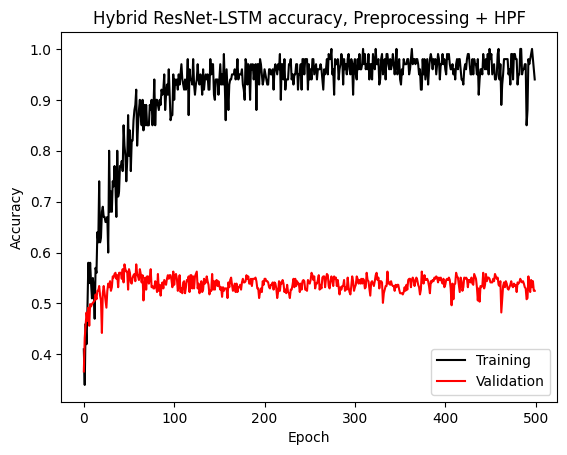

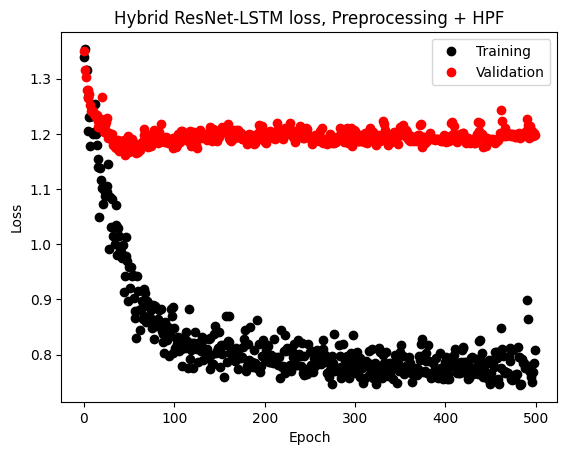

In [ ]:
#Update arrays and titles
plt.plot(np.arange(num_epochs),train_history_4,label='Training',color='k')
plt.plot(np.arange(num_epochs),val_history_4,label='Validation',color='r')
plt.title('Hybrid ResNet-LSTM accuracy, Preprocessing + HPF')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(np.arange(num_epochs),train_loss_hist_4,'o',label='Training',color='k')
plt.plot(np.arange(num_epochs),val_loss_hist_4,'o',label='Validation',color='r')
plt.title('Hybrid ResNet-LSTM loss, Preprocessing + HPF')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Part 5: Bandpass filter after preprocessing data

In [ ]:
## Randomly split the train/validation dataset
ind_valid = np.random.choice(X_train_valid.shape[0], int(X_train_valid.shape[0]/5), replace=False)
ind_train = np.array(list(set(range(X_train_valid.shape[0])).difference(set(ind_valid))))
x_valid, y_valid = X_train_valid[ind_valid], y_train_valid[ind_valid]
x_train, y_train = X_train_valid[ind_train], y_train_valid[ind_train]
print('Training and Validation shapes before preprocessing: ')
print('X train: ', x_train.shape, ' Y train: ', y_train.shape)
print('X val: ', x_valid.shape, ' Y val', y_valid.shape)

# Preprocessing the dataset
# pass only training data to train prep, val and test data to test prep

x_train,y_train = train_data_prep(x_train,y_train,2,2,True)
x_test, x_valid = test_data_prep(x_test), test_data_prep(x_valid)

x_train = torch.tensor(x_train).detach().float().to(device)
x_valid = torch.tensor(x_valid).detach().float().to(device)
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

# Converting the labels to categorical variables for multiclass classification
y_train, y_valid, y_test = torch.tensor(y_train).to(device), torch.tensor(y_valid).to(device), torch.tensor(y_test).to(device)
y_train = nn.functional.one_hot(y_train.long(), 4)
y_valid = nn.functional.one_hot(y_valid.long(), 4)
y_test = nn.functional.one_hot(y_test.long(), 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 2,3)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 2,3)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 2,3)
x_test = torch.tensor(x_test).detach().float().to(device)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

# Convert x train to numpy

x_train_np = x_train.cpu().numpy()
print(x_train_np.shape)

Training and Validation shapes before preprocessing: 
X train:  (1692, 22, 1000)  Y train:  (1692,)
X val:  (423, 22, 1000)  Y val (423,)
Shape of X after trimming: (1692, 22, 800)
Shape of X after maxpooling: (1692, 22, 400)
Shape of X after averaging+noise and concatenating: (3384, 22, 400)
Shape of X after subsampling and concatenating: (6768, 22, 400)
Shape of Y: (6768,)
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of X after trimming: (423, 22, 800)
Shape of X after maxpooling: (423, 22, 400)
Shape of training set: torch.Size([6768, 22, 400])
Shape of validation set: torch.Size([423, 22, 400])
Shape of training labels: (6768,)
Shape of validation labels: (423,)
Shape of training labels after categorical conversion: torch.Size([6768, 4])
Shape of validation labels after categorical conversion: torch.Size([423, 4])
Shape of test labels after categorical conversion: torch.Size([443, 4])
Shape of training set after adding width info: torc

In [ ]:
# Define the band-pass filter parameters
cutoff_frequency = np.array([4, 40])  # Cut-off frequency in Hz
sampling_rate = 125  # Sampling rate in Hz (adjust based on your data)

# Design a Butterworth band-pass filter
order = 3  # Filter order
b, a = butter(N=order, Wn=cutoff_frequency / (0.5 * sampling_rate), btype='band', analog=False, output='ba')

x_train_bpf = np.zeros(x_train_np.shape)
# Apply the filter to the data
for i in range(x_train_np.shape[0]):
    for j in range(x_train_np.shape[2]):
        filtered_data = filtfilt(b, a, x_train_np[i,0,j,:])
        x_train_bpf[i,0,j,:] = filtered_data

x_train_bpf = torch.tensor(x_train_bpf).float().to(device)
print(x_train_bpf.shape)

torch.Size([6768, 1, 22, 400])


In [ ]:
#Build the model
model5 = ResNetLSTM(img_channels=1, block=BasicBlock, num_classes=4, time_dim=int(x_train.size(3)), dropout=0.6).to(device)
print(model5)
total_params = sum(p.numel() for p in model5.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model5.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

ResNetLSTM(
  (conv1): Conv2d(1, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
  (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(48, 48, kernel_size=(22, 1), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ELU(alpha=1.0, inplace=True)
  (res1): BasicBlock(
    (conv1): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout2d(p=0.6, inplace=False)
    (elu): ELU(alpha=1.0, inplace=True)
    (conv2): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2): Dropout2d(p=0.6, inplace=False)
    (shortcut): Identity()
  )
  (res2): BasicBlock(
    (conv1):

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
# Choose Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model5.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
# Rename these lines between models
train_history_5, val_history_5 = np.array([]), np.array([])
train_loss_hist_5, val_loss_hist_5 = np.array([]), np.array([])

with TemporaryDirectory() as tempdir:
    save_folder = '/content/drive/MyDrive/C147_Final_Project/best_model_params'

    # Rename these lines between models
    best_model_params_path = os.path.join(save_folder, 'best_model5_params.pt')
    torch.save(model5.state_dict(), best_model_params_path)

    best_acc = 0.0
    bsz = 100
    num_epochs = 500
    iteration = 0
    total_it = num_epochs*int(x_train.shape[0]/bsz)
    for epoch_idx in tqdm(range(num_epochs)):
        # Set model to train mode - useful for layers such as BatchNorm or Dropout whose behaviors change between train/eval
        # Rename
        model5.train()

        train_count = 0
        train_correct_count = 0
        for i in range(int(x_train.shape[0]/bsz)):
            iteration+=1
            optimizer.zero_grad() # Zero gradients, since we don't want gradients to accumulate between batches - we apply an update for each batch
            train_x, train_y = sample(x_train, y_train, bsz)
            #Rename
            logits = model5(train_x) #bszx4x1x4

            logits = nn.functional.softmax(logits, dim=1)
            loss = criterion(logits.float(), train_y.float())

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                #y_hat = torch.mean(logits, dim = 2)
                y_hat = torch.argmax(logits, dim=1)
                train_correct_count = torch.sum(y_hat == torch.argmax(train_y, dim=1))
                train_count = train_x.size(0)
                train_count = float(train_count)
            #print(f'(Iteration {iteration}/{total_it})Training Accuracy: ', (train_correct_count/train_count).item(), '. Loss: ', loss.item())


        train_acc = train_correct_count / train_count

        #Rename
        model5.eval()
        val_count = 0
        val_correct_count = 0
        with torch.no_grad():
            val_x = x_valid
            val_y = y_valid
            #Rename
            logits = model5(val_x).detach()
            logits = nn.functional.softmax(logits)
            val_loss = criterion(logits.float(), val_y.float())
            with torch.no_grad():
                y_hat = torch.argmax(logits, dim=1)
                val_correct_count = torch.sum(y_hat == torch.argmax(val_y, dim=1))
                val_count = float(val_x.size(0))
        val_acc = val_correct_count / y_valid.shape[0]

        print(f'Epoch {epoch_idx+1} Finished!!!')
        print('Train acc: {:.3f}, Val acc: {:.3f}'.format(train_acc, val_acc))
        print('Train loss: {:.3f}, Val loss: {:.3f}'.format(loss, val_loss))

        #Rename
        train_history_5 = np.append(train_history_5, train_acc.item())
        val_history_5 = np.append(val_history_5, val_acc.item())
        train_loss_hist_5 = np.append(train_loss_hist_5, loss.item())
        val_loss_hist_5 = np.append(val_loss_hist_5, val_loss.item())

        if val_acc > best_acc:
            best_acc = val_acc
            #Rename
            torch.save(model5.state_dict(), best_model_params_path)

    print(f'Best val Acc: {best_acc:4f}')

  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-44-0e2ca0d52207>:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = nn.functional.softmax(logits)
  0%|          | 1/500 [00:02<19:39,  2.36s/it]

Epoch 1 Finished!!!
Train acc: 0.400, Val acc: 0.400
Train loss: 1.357, Val loss: 1.356


  0%|          | 2/500 [00:04<19:13,  2.32s/it]

Epoch 2 Finished!!!
Train acc: 0.430, Val acc: 0.426
Train loss: 1.328, Val loss: 1.322


  1%|          | 3/500 [00:06<19:02,  2.30s/it]

Epoch 3 Finished!!!
Train acc: 0.460, Val acc: 0.411
Train loss: 1.274, Val loss: 1.308


  1%|          | 4/500 [00:09<18:56,  2.29s/it]

Epoch 4 Finished!!!
Train acc: 0.390, Val acc: 0.404
Train loss: 1.314, Val loss: 1.309


  1%|          | 5/500 [00:11<18:58,  2.30s/it]

Epoch 5 Finished!!!
Train acc: 0.550, Val acc: 0.428
Train loss: 1.213, Val loss: 1.294


  1%|          | 6/500 [00:13<18:54,  2.30s/it]

Epoch 6 Finished!!!
Train acc: 0.440, Val acc: 0.411
Train loss: 1.285, Val loss: 1.308


  1%|▏         | 7/500 [00:16<18:54,  2.30s/it]

Epoch 7 Finished!!!
Train acc: 0.500, Val acc: 0.437
Train loss: 1.245, Val loss: 1.286


  2%|▏         | 8/500 [00:18<18:53,  2.30s/it]

Epoch 8 Finished!!!
Train acc: 0.450, Val acc: 0.447
Train loss: 1.252, Val loss: 1.294


  2%|▏         | 9/500 [00:20<18:54,  2.31s/it]

Epoch 9 Finished!!!
Train acc: 0.520, Val acc: 0.466
Train loss: 1.218, Val loss: 1.271


  2%|▏         | 10/500 [00:23<18:50,  2.31s/it]

Epoch 10 Finished!!!
Train acc: 0.500, Val acc: 0.461
Train loss: 1.253, Val loss: 1.268


  2%|▏         | 11/500 [00:25<18:49,  2.31s/it]

Epoch 11 Finished!!!
Train acc: 0.590, Val acc: 0.444
Train loss: 1.184, Val loss: 1.277


  2%|▏         | 12/500 [00:27<18:47,  2.31s/it]

Epoch 12 Finished!!!
Train acc: 0.500, Val acc: 0.463
Train loss: 1.213, Val loss: 1.263


  3%|▎         | 13/500 [00:29<18:45,  2.31s/it]

Epoch 13 Finished!!!
Train acc: 0.580, Val acc: 0.454
Train loss: 1.166, Val loss: 1.259


  3%|▎         | 14/500 [00:32<18:44,  2.31s/it]

Epoch 14 Finished!!!
Train acc: 0.570, Val acc: 0.444
Train loss: 1.203, Val loss: 1.268


  3%|▎         | 15/500 [00:34<19:01,  2.35s/it]

Epoch 15 Finished!!!
Train acc: 0.570, Val acc: 0.430
Train loss: 1.189, Val loss: 1.292


  3%|▎         | 16/500 [00:37<18:56,  2.35s/it]

Epoch 16 Finished!!!
Train acc: 0.560, Val acc: 0.466
Train loss: 1.175, Val loss: 1.257


  3%|▎         | 17/500 [00:39<18:52,  2.35s/it]

Epoch 17 Finished!!!
Train acc: 0.560, Val acc: 0.447
Train loss: 1.159, Val loss: 1.260


  4%|▎         | 18/500 [00:41<18:48,  2.34s/it]

Epoch 18 Finished!!!
Train acc: 0.530, Val acc: 0.461
Train loss: 1.227, Val loss: 1.257


  4%|▍         | 19/500 [00:44<18:48,  2.35s/it]

Epoch 19 Finished!!!
Train acc: 0.520, Val acc: 0.485
Train loss: 1.197, Val loss: 1.246


  4%|▍         | 20/500 [00:46<18:44,  2.34s/it]

Epoch 20 Finished!!!
Train acc: 0.670, Val acc: 0.478
Train loss: 1.072, Val loss: 1.241


  4%|▍         | 21/500 [00:48<18:45,  2.35s/it]

Epoch 21 Finished!!!
Train acc: 0.600, Val acc: 0.506
Train loss: 1.137, Val loss: 1.238


  4%|▍         | 22/500 [00:51<18:42,  2.35s/it]

Epoch 22 Finished!!!
Train acc: 0.600, Val acc: 0.459
Train loss: 1.138, Val loss: 1.253


  5%|▍         | 23/500 [00:53<18:40,  2.35s/it]

Epoch 23 Finished!!!
Train acc: 0.650, Val acc: 0.485
Train loss: 1.111, Val loss: 1.249


  5%|▍         | 24/500 [00:55<18:38,  2.35s/it]

Epoch 24 Finished!!!
Train acc: 0.720, Val acc: 0.475
Train loss: 1.057, Val loss: 1.245


  5%|▌         | 25/500 [00:58<18:38,  2.35s/it]

Epoch 25 Finished!!!
Train acc: 0.720, Val acc: 0.492
Train loss: 1.050, Val loss: 1.228


  5%|▌         | 26/500 [01:00<18:36,  2.36s/it]

Epoch 26 Finished!!!
Train acc: 0.690, Val acc: 0.478
Train loss: 1.045, Val loss: 1.244


  5%|▌         | 27/500 [01:02<18:35,  2.36s/it]

Epoch 27 Finished!!!
Train acc: 0.650, Val acc: 0.463
Train loss: 1.111, Val loss: 1.255


  6%|▌         | 28/500 [01:05<18:36,  2.37s/it]

Epoch 28 Finished!!!
Train acc: 0.710, Val acc: 0.508
Train loss: 1.066, Val loss: 1.234


  6%|▌         | 29/500 [01:07<18:36,  2.37s/it]

Epoch 29 Finished!!!
Train acc: 0.620, Val acc: 0.511
Train loss: 1.120, Val loss: 1.226


  6%|▌         | 30/500 [01:10<18:35,  2.37s/it]

Epoch 30 Finished!!!
Train acc: 0.690, Val acc: 0.518
Train loss: 1.067, Val loss: 1.226


  6%|▌         | 31/500 [01:12<18:32,  2.37s/it]

Epoch 31 Finished!!!
Train acc: 0.730, Val acc: 0.511
Train loss: 1.030, Val loss: 1.225


  6%|▋         | 32/500 [01:14<18:29,  2.37s/it]

Epoch 32 Finished!!!
Train acc: 0.790, Val acc: 0.489
Train loss: 0.970, Val loss: 1.232


  7%|▋         | 33/500 [01:17<18:43,  2.41s/it]

Epoch 33 Finished!!!
Train acc: 0.750, Val acc: 0.501
Train loss: 1.013, Val loss: 1.234


  7%|▋         | 34/500 [01:19<18:35,  2.39s/it]

Epoch 34 Finished!!!
Train acc: 0.770, Val acc: 0.515
Train loss: 1.020, Val loss: 1.221


  7%|▋         | 35/500 [01:22<18:57,  2.45s/it]

Epoch 35 Finished!!!
Train acc: 0.730, Val acc: 0.499
Train loss: 1.022, Val loss: 1.231


  7%|▋         | 36/500 [01:24<18:47,  2.43s/it]

Epoch 36 Finished!!!
Train acc: 0.770, Val acc: 0.504
Train loss: 1.003, Val loss: 1.225


  7%|▋         | 37/500 [01:27<18:59,  2.46s/it]

Epoch 37 Finished!!!
Train acc: 0.680, Val acc: 0.513
Train loss: 1.081, Val loss: 1.224


  8%|▊         | 38/500 [01:29<19:17,  2.50s/it]

Epoch 38 Finished!!!
Train acc: 0.700, Val acc: 0.504
Train loss: 1.067, Val loss: 1.232


  8%|▊         | 39/500 [01:32<19:10,  2.50s/it]

Epoch 39 Finished!!!
Train acc: 0.740, Val acc: 0.506
Train loss: 1.020, Val loss: 1.231


  8%|▊         | 40/500 [01:34<18:54,  2.47s/it]

Epoch 40 Finished!!!
Train acc: 0.760, Val acc: 0.508
Train loss: 0.990, Val loss: 1.218


  8%|▊         | 41/500 [01:37<19:19,  2.53s/it]

Epoch 41 Finished!!!
Train acc: 0.710, Val acc: 0.513
Train loss: 1.046, Val loss: 1.218


  8%|▊         | 42/500 [01:40<19:47,  2.59s/it]

Epoch 42 Finished!!!
Train acc: 0.710, Val acc: 0.532
Train loss: 1.043, Val loss: 1.209


  9%|▊         | 43/500 [01:42<20:14,  2.66s/it]

Epoch 43 Finished!!!
Train acc: 0.820, Val acc: 0.508
Train loss: 0.936, Val loss: 1.217


  9%|▉         | 44/500 [01:45<20:10,  2.66s/it]

Epoch 44 Finished!!!
Train acc: 0.840, Val acc: 0.511
Train loss: 0.920, Val loss: 1.227


  9%|▉         | 45/500 [01:47<19:26,  2.56s/it]

Epoch 45 Finished!!!
Train acc: 0.800, Val acc: 0.511
Train loss: 0.961, Val loss: 1.217


  9%|▉         | 46/500 [01:50<18:54,  2.50s/it]

Epoch 46 Finished!!!
Train acc: 0.750, Val acc: 0.496
Train loss: 1.006, Val loss: 1.224


  9%|▉         | 47/500 [01:52<18:32,  2.46s/it]

Epoch 47 Finished!!!
Train acc: 0.820, Val acc: 0.518
Train loss: 0.944, Val loss: 1.215


 10%|▉         | 48/500 [01:54<18:16,  2.42s/it]

Epoch 48 Finished!!!
Train acc: 0.830, Val acc: 0.520
Train loss: 0.926, Val loss: 1.217


 10%|▉         | 49/500 [01:57<18:04,  2.40s/it]

Epoch 49 Finished!!!
Train acc: 0.850, Val acc: 0.499
Train loss: 0.918, Val loss: 1.221


 10%|█         | 50/500 [01:59<17:54,  2.39s/it]

Epoch 50 Finished!!!
Train acc: 0.780, Val acc: 0.511
Train loss: 0.979, Val loss: 1.215


 10%|█         | 51/500 [02:02<17:51,  2.39s/it]

Epoch 51 Finished!!!
Train acc: 0.820, Val acc: 0.513
Train loss: 0.959, Val loss: 1.214


 10%|█         | 52/500 [02:04<18:21,  2.46s/it]

Epoch 52 Finished!!!
Train acc: 0.870, Val acc: 0.522
Train loss: 0.900, Val loss: 1.212


 11%|█         | 53/500 [02:07<18:38,  2.50s/it]

Epoch 53 Finished!!!
Train acc: 0.790, Val acc: 0.511
Train loss: 0.953, Val loss: 1.217


 11%|█         | 54/500 [02:09<18:56,  2.55s/it]

Epoch 54 Finished!!!
Train acc: 0.900, Val acc: 0.534
Train loss: 0.876, Val loss: 1.207


 11%|█         | 55/500 [02:12<19:24,  2.62s/it]

Epoch 55 Finished!!!
Train acc: 0.860, Val acc: 0.530
Train loss: 0.916, Val loss: 1.203


 11%|█         | 56/500 [02:15<19:10,  2.59s/it]

Epoch 56 Finished!!!
Train acc: 0.860, Val acc: 0.501
Train loss: 0.899, Val loss: 1.213


 11%|█▏        | 57/500 [02:17<19:04,  2.58s/it]

Epoch 57 Finished!!!
Train acc: 0.840, Val acc: 0.494
Train loss: 0.935, Val loss: 1.228


 12%|█▏        | 58/500 [02:20<18:52,  2.56s/it]

Epoch 58 Finished!!!
Train acc: 0.880, Val acc: 0.530
Train loss: 0.895, Val loss: 1.209


 12%|█▏        | 59/500 [02:22<18:41,  2.54s/it]

Epoch 59 Finished!!!
Train acc: 0.880, Val acc: 0.501
Train loss: 0.894, Val loss: 1.223


 12%|█▏        | 60/500 [02:25<18:46,  2.56s/it]

Epoch 60 Finished!!!
Train acc: 0.860, Val acc: 0.518
Train loss: 0.898, Val loss: 1.209


 12%|█▏        | 61/500 [02:27<18:26,  2.52s/it]

Epoch 61 Finished!!!
Train acc: 0.810, Val acc: 0.499
Train loss: 0.953, Val loss: 1.223


 12%|█▏        | 62/500 [02:30<18:02,  2.47s/it]

Epoch 62 Finished!!!
Train acc: 0.890, Val acc: 0.504
Train loss: 0.871, Val loss: 1.215


 13%|█▎        | 63/500 [02:32<17:44,  2.44s/it]

Epoch 63 Finished!!!
Train acc: 0.800, Val acc: 0.508
Train loss: 0.952, Val loss: 1.211


 13%|█▎        | 64/500 [02:34<17:31,  2.41s/it]

Epoch 64 Finished!!!
Train acc: 0.860, Val acc: 0.504
Train loss: 0.900, Val loss: 1.219


 13%|█▎        | 65/500 [02:37<17:21,  2.40s/it]

Epoch 65 Finished!!!
Train acc: 0.860, Val acc: 0.508
Train loss: 0.893, Val loss: 1.219


 13%|█▎        | 66/500 [02:39<17:14,  2.38s/it]

Epoch 66 Finished!!!
Train acc: 0.910, Val acc: 0.520
Train loss: 0.847, Val loss: 1.215


 13%|█▎        | 67/500 [02:41<17:08,  2.38s/it]

Epoch 67 Finished!!!
Train acc: 0.880, Val acc: 0.511
Train loss: 0.887, Val loss: 1.220


 14%|█▎        | 68/500 [02:44<17:03,  2.37s/it]

Epoch 68 Finished!!!
Train acc: 0.870, Val acc: 0.499
Train loss: 0.891, Val loss: 1.224


 14%|█▍        | 69/500 [02:46<16:59,  2.37s/it]

Epoch 69 Finished!!!
Train acc: 0.860, Val acc: 0.508
Train loss: 0.897, Val loss: 1.230


 14%|█▍        | 70/500 [02:49<16:55,  2.36s/it]

Epoch 70 Finished!!!
Train acc: 0.870, Val acc: 0.515
Train loss: 0.888, Val loss: 1.217


 14%|█▍        | 71/500 [02:51<17:08,  2.40s/it]

Epoch 71 Finished!!!
Train acc: 0.840, Val acc: 0.501
Train loss: 0.911, Val loss: 1.221


 14%|█▍        | 72/500 [02:53<17:08,  2.40s/it]

Epoch 72 Finished!!!
Train acc: 0.890, Val acc: 0.537
Train loss: 0.865, Val loss: 1.204


 15%|█▍        | 73/500 [02:56<17:00,  2.39s/it]

Epoch 73 Finished!!!
Train acc: 0.930, Val acc: 0.508
Train loss: 0.832, Val loss: 1.218


 15%|█▍        | 74/500 [02:58<16:53,  2.38s/it]

Epoch 74 Finished!!!
Train acc: 0.860, Val acc: 0.504
Train loss: 0.891, Val loss: 1.230


 15%|█▌        | 75/500 [03:01<16:48,  2.37s/it]

Epoch 75 Finished!!!
Train acc: 0.880, Val acc: 0.520
Train loss: 0.863, Val loss: 1.213


 15%|█▌        | 76/500 [03:03<16:44,  2.37s/it]

Epoch 76 Finished!!!
Train acc: 0.880, Val acc: 0.501
Train loss: 0.873, Val loss: 1.222


 15%|█▌        | 77/500 [03:05<16:41,  2.37s/it]

Epoch 77 Finished!!!
Train acc: 0.940, Val acc: 0.496
Train loss: 0.831, Val loss: 1.226


 16%|█▌        | 78/500 [03:08<16:38,  2.37s/it]

Epoch 78 Finished!!!
Train acc: 0.900, Val acc: 0.489
Train loss: 0.858, Val loss: 1.227


 16%|█▌        | 79/500 [03:10<16:43,  2.38s/it]

Epoch 79 Finished!!!
Train acc: 0.860, Val acc: 0.515
Train loss: 0.892, Val loss: 1.216


 16%|█▌        | 80/500 [03:12<16:37,  2.38s/it]

Epoch 80 Finished!!!
Train acc: 0.890, Val acc: 0.506
Train loss: 0.858, Val loss: 1.217


 16%|█▌        | 81/500 [03:15<16:40,  2.39s/it]

Epoch 81 Finished!!!
Train acc: 0.900, Val acc: 0.492
Train loss: 0.845, Val loss: 1.235


 16%|█▋        | 82/500 [03:17<16:35,  2.38s/it]

Epoch 82 Finished!!!
Train acc: 0.850, Val acc: 0.492
Train loss: 0.908, Val loss: 1.240


 17%|█▋        | 83/500 [03:20<16:29,  2.37s/it]

Epoch 83 Finished!!!
Train acc: 0.890, Val acc: 0.494
Train loss: 0.862, Val loss: 1.236


 17%|█▋        | 84/500 [03:22<16:25,  2.37s/it]

Epoch 84 Finished!!!
Train acc: 0.900, Val acc: 0.511
Train loss: 0.857, Val loss: 1.222


 17%|█▋        | 85/500 [03:24<16:34,  2.40s/it]

Epoch 85 Finished!!!
Train acc: 0.950, Val acc: 0.499
Train loss: 0.810, Val loss: 1.234


 17%|█▋        | 86/500 [03:27<16:31,  2.39s/it]

Epoch 86 Finished!!!
Train acc: 0.880, Val acc: 0.492
Train loss: 0.873, Val loss: 1.233


 17%|█▋        | 87/500 [03:29<16:23,  2.38s/it]

Epoch 87 Finished!!!
Train acc: 0.900, Val acc: 0.511
Train loss: 0.861, Val loss: 1.221


 18%|█▊        | 88/500 [03:31<16:19,  2.38s/it]

Epoch 88 Finished!!!
Train acc: 0.860, Val acc: 0.515
Train loss: 0.884, Val loss: 1.221


 18%|█▊        | 89/500 [03:34<16:14,  2.37s/it]

Epoch 89 Finished!!!
Train acc: 0.860, Val acc: 0.499
Train loss: 0.877, Val loss: 1.223


 18%|█▊        | 90/500 [03:36<16:10,  2.37s/it]

Epoch 90 Finished!!!
Train acc: 0.910, Val acc: 0.499
Train loss: 0.841, Val loss: 1.224


 18%|█▊        | 91/500 [03:39<16:06,  2.36s/it]

Epoch 91 Finished!!!
Train acc: 0.900, Val acc: 0.508
Train loss: 0.849, Val loss: 1.221


 18%|█▊        | 92/500 [03:41<16:03,  2.36s/it]

Epoch 92 Finished!!!
Train acc: 0.890, Val acc: 0.496
Train loss: 0.860, Val loss: 1.232


 19%|█▊        | 93/500 [03:43<16:00,  2.36s/it]

Epoch 93 Finished!!!
Train acc: 0.950, Val acc: 0.511
Train loss: 0.799, Val loss: 1.222


 19%|█▉        | 94/500 [03:46<15:57,  2.36s/it]

Epoch 94 Finished!!!
Train acc: 0.930, Val acc: 0.489
Train loss: 0.822, Val loss: 1.225


 19%|█▉        | 95/500 [03:48<15:54,  2.36s/it]

Epoch 95 Finished!!!
Train acc: 0.900, Val acc: 0.508
Train loss: 0.846, Val loss: 1.221


 19%|█▉        | 96/500 [03:50<15:51,  2.36s/it]

Epoch 96 Finished!!!
Train acc: 0.960, Val acc: 0.511
Train loss: 0.791, Val loss: 1.222


 19%|█▉        | 97/500 [03:53<15:49,  2.36s/it]

Epoch 97 Finished!!!
Train acc: 0.900, Val acc: 0.511
Train loss: 0.849, Val loss: 1.221


 20%|█▉        | 98/500 [03:55<15:47,  2.36s/it]

Epoch 98 Finished!!!
Train acc: 0.900, Val acc: 0.511
Train loss: 0.842, Val loss: 1.219


 20%|█▉        | 99/500 [03:57<15:45,  2.36s/it]

Epoch 99 Finished!!!
Train acc: 0.940, Val acc: 0.499
Train loss: 0.814, Val loss: 1.233


 20%|██        | 100/500 [04:00<15:42,  2.36s/it]

Epoch 100 Finished!!!
Train acc: 0.860, Val acc: 0.496
Train loss: 0.886, Val loss: 1.229


 20%|██        | 101/500 [04:02<15:39,  2.35s/it]

Epoch 101 Finished!!!
Train acc: 0.930, Val acc: 0.508
Train loss: 0.823, Val loss: 1.219


 20%|██        | 102/500 [04:04<15:37,  2.36s/it]

Epoch 102 Finished!!!
Train acc: 0.880, Val acc: 0.508
Train loss: 0.864, Val loss: 1.217


 21%|██        | 103/500 [04:07<15:35,  2.36s/it]

Epoch 103 Finished!!!
Train acc: 0.870, Val acc: 0.513
Train loss: 0.879, Val loss: 1.221


 21%|██        | 104/500 [04:09<15:33,  2.36s/it]

Epoch 104 Finished!!!
Train acc: 0.940, Val acc: 0.513
Train loss: 0.815, Val loss: 1.222


 21%|██        | 105/500 [04:11<15:30,  2.36s/it]

Epoch 105 Finished!!!
Train acc: 0.870, Val acc: 0.504
Train loss: 0.878, Val loss: 1.229


 21%|██        | 106/500 [04:14<15:27,  2.35s/it]

Epoch 106 Finished!!!
Train acc: 0.880, Val acc: 0.518
Train loss: 0.861, Val loss: 1.216


 21%|██▏       | 107/500 [04:16<15:25,  2.35s/it]

Epoch 107 Finished!!!
Train acc: 0.930, Val acc: 0.504
Train loss: 0.808, Val loss: 1.222


 22%|██▏       | 108/500 [04:19<15:22,  2.35s/it]

Epoch 108 Finished!!!
Train acc: 0.870, Val acc: 0.499
Train loss: 0.882, Val loss: 1.222


 22%|██▏       | 109/500 [04:21<15:20,  2.36s/it]

Epoch 109 Finished!!!
Train acc: 0.920, Val acc: 0.496
Train loss: 0.835, Val loss: 1.232


 22%|██▏       | 110/500 [04:23<15:18,  2.36s/it]

Epoch 110 Finished!!!
Train acc: 0.940, Val acc: 0.508
Train loss: 0.817, Val loss: 1.218


 22%|██▏       | 111/500 [04:26<15:15,  2.35s/it]

Epoch 111 Finished!!!
Train acc: 0.940, Val acc: 0.506
Train loss: 0.812, Val loss: 1.227


 22%|██▏       | 112/500 [04:28<15:13,  2.35s/it]

Epoch 112 Finished!!!
Train acc: 0.910, Val acc: 0.499
Train loss: 0.840, Val loss: 1.234


 23%|██▎       | 113/500 [04:30<15:10,  2.35s/it]

Epoch 113 Finished!!!
Train acc: 0.930, Val acc: 0.485
Train loss: 0.818, Val loss: 1.237


 23%|██▎       | 114/500 [04:33<15:08,  2.35s/it]

Epoch 114 Finished!!!
Train acc: 0.920, Val acc: 0.511
Train loss: 0.837, Val loss: 1.221


 23%|██▎       | 115/500 [04:35<15:06,  2.35s/it]

Epoch 115 Finished!!!
Train acc: 0.890, Val acc: 0.511
Train loss: 0.864, Val loss: 1.219


 23%|██▎       | 116/500 [04:37<15:04,  2.36s/it]

Epoch 116 Finished!!!
Train acc: 0.900, Val acc: 0.499
Train loss: 0.845, Val loss: 1.229


 23%|██▎       | 117/500 [04:40<15:01,  2.35s/it]

Epoch 117 Finished!!!
Train acc: 0.900, Val acc: 0.511
Train loss: 0.847, Val loss: 1.219


 24%|██▎       | 118/500 [04:42<14:59,  2.35s/it]

Epoch 118 Finished!!!
Train acc: 0.940, Val acc: 0.489
Train loss: 0.810, Val loss: 1.237


 24%|██▍       | 119/500 [04:44<14:56,  2.35s/it]

Epoch 119 Finished!!!
Train acc: 0.970, Val acc: 0.506
Train loss: 0.785, Val loss: 1.222


 24%|██▍       | 120/500 [04:47<14:55,  2.36s/it]

Epoch 120 Finished!!!
Train acc: 0.890, Val acc: 0.506
Train loss: 0.861, Val loss: 1.222


 24%|██▍       | 121/500 [04:49<14:52,  2.35s/it]

Epoch 121 Finished!!!
Train acc: 0.910, Val acc: 0.487
Train loss: 0.840, Val loss: 1.240


 24%|██▍       | 122/500 [04:52<14:49,  2.35s/it]

Epoch 122 Finished!!!
Train acc: 0.920, Val acc: 0.511
Train loss: 0.834, Val loss: 1.213


 25%|██▍       | 123/500 [04:54<14:47,  2.35s/it]

Epoch 123 Finished!!!
Train acc: 0.910, Val acc: 0.508
Train loss: 0.840, Val loss: 1.222


 25%|██▍       | 124/500 [04:56<14:59,  2.39s/it]

Epoch 124 Finished!!!
Train acc: 0.950, Val acc: 0.506
Train loss: 0.796, Val loss: 1.214


 25%|██▌       | 125/500 [04:59<14:53,  2.38s/it]

Epoch 125 Finished!!!
Train acc: 0.940, Val acc: 0.501
Train loss: 0.808, Val loss: 1.220


 25%|██▌       | 126/500 [05:01<14:48,  2.37s/it]

Epoch 126 Finished!!!
Train acc: 0.940, Val acc: 0.513
Train loss: 0.813, Val loss: 1.223


 25%|██▌       | 127/500 [05:03<14:43,  2.37s/it]

Epoch 127 Finished!!!
Train acc: 0.920, Val acc: 0.525
Train loss: 0.829, Val loss: 1.214


 26%|██▌       | 128/500 [05:06<14:39,  2.36s/it]

Epoch 128 Finished!!!
Train acc: 0.950, Val acc: 0.527
Train loss: 0.798, Val loss: 1.213


 26%|██▌       | 129/500 [05:08<14:40,  2.37s/it]

Epoch 129 Finished!!!
Train acc: 0.920, Val acc: 0.513
Train loss: 0.831, Val loss: 1.218


 26%|██▌       | 130/500 [05:11<15:24,  2.50s/it]

Epoch 130 Finished!!!
Train acc: 0.930, Val acc: 0.513
Train loss: 0.825, Val loss: 1.220


 26%|██▌       | 131/500 [05:13<15:21,  2.50s/it]

Epoch 131 Finished!!!
Train acc: 0.930, Val acc: 0.506
Train loss: 0.816, Val loss: 1.221


 26%|██▋       | 132/500 [05:16<15:03,  2.45s/it]

Epoch 132 Finished!!!
Train acc: 0.940, Val acc: 0.504
Train loss: 0.818, Val loss: 1.228


 27%|██▋       | 133/500 [05:18<14:49,  2.42s/it]

Epoch 133 Finished!!!
Train acc: 0.890, Val acc: 0.501
Train loss: 0.859, Val loss: 1.222


 27%|██▋       | 134/500 [05:20<14:39,  2.40s/it]

Epoch 134 Finished!!!
Train acc: 0.910, Val acc: 0.506
Train loss: 0.837, Val loss: 1.211


 27%|██▋       | 135/500 [05:23<14:31,  2.39s/it]

Epoch 135 Finished!!!
Train acc: 0.910, Val acc: 0.499
Train loss: 0.851, Val loss: 1.229


 27%|██▋       | 136/500 [05:25<14:25,  2.38s/it]

Epoch 136 Finished!!!
Train acc: 0.880, Val acc: 0.489
Train loss: 0.870, Val loss: 1.239


 27%|██▋       | 137/500 [05:28<14:21,  2.37s/it]

Epoch 137 Finished!!!
Train acc: 0.880, Val acc: 0.522
Train loss: 0.872, Val loss: 1.212


 28%|██▊       | 138/500 [05:30<14:16,  2.37s/it]

Epoch 138 Finished!!!
Train acc: 0.950, Val acc: 0.518
Train loss: 0.810, Val loss: 1.209


 28%|██▊       | 139/500 [05:32<14:12,  2.36s/it]

Epoch 139 Finished!!!
Train acc: 0.930, Val acc: 0.504
Train loss: 0.819, Val loss: 1.218


 28%|██▊       | 140/500 [05:35<14:08,  2.36s/it]

Epoch 140 Finished!!!
Train acc: 0.910, Val acc: 0.511
Train loss: 0.839, Val loss: 1.225


 28%|██▊       | 141/500 [05:37<14:05,  2.36s/it]

Epoch 141 Finished!!!
Train acc: 0.910, Val acc: 0.508
Train loss: 0.845, Val loss: 1.227


 28%|██▊       | 142/500 [05:39<14:03,  2.36s/it]

Epoch 142 Finished!!!
Train acc: 0.860, Val acc: 0.513
Train loss: 0.887, Val loss: 1.217


 29%|██▊       | 143/500 [05:42<14:00,  2.35s/it]

Epoch 143 Finished!!!
Train acc: 0.900, Val acc: 0.511
Train loss: 0.844, Val loss: 1.221


 29%|██▉       | 144/500 [05:44<13:58,  2.35s/it]

Epoch 144 Finished!!!
Train acc: 0.910, Val acc: 0.506
Train loss: 0.843, Val loss: 1.212


 29%|██▉       | 145/500 [05:46<13:55,  2.35s/it]

Epoch 145 Finished!!!
Train acc: 0.950, Val acc: 0.522
Train loss: 0.798, Val loss: 1.212


 29%|██▉       | 146/500 [05:49<13:52,  2.35s/it]

Epoch 146 Finished!!!
Train acc: 0.910, Val acc: 0.515
Train loss: 0.833, Val loss: 1.208


 29%|██▉       | 147/500 [05:51<13:50,  2.35s/it]

Epoch 147 Finished!!!
Train acc: 0.930, Val acc: 0.508
Train loss: 0.817, Val loss: 1.214


 30%|██▉       | 148/500 [05:53<13:48,  2.35s/it]

Epoch 148 Finished!!!
Train acc: 0.920, Val acc: 0.518
Train loss: 0.822, Val loss: 1.210


 30%|██▉       | 149/500 [05:56<13:45,  2.35s/it]

Epoch 149 Finished!!!
Train acc: 0.850, Val acc: 0.485
Train loss: 0.886, Val loss: 1.245


 30%|███       | 150/500 [05:58<13:43,  2.35s/it]

Epoch 150 Finished!!!
Train acc: 0.880, Val acc: 0.501
Train loss: 0.869, Val loss: 1.225


 30%|███       | 151/500 [06:00<13:41,  2.35s/it]

Epoch 151 Finished!!!
Train acc: 0.900, Val acc: 0.504
Train loss: 0.846, Val loss: 1.226


 30%|███       | 152/500 [06:03<13:38,  2.35s/it]

Epoch 152 Finished!!!
Train acc: 0.990, Val acc: 0.504
Train loss: 0.765, Val loss: 1.221


 31%|███       | 153/500 [06:05<13:37,  2.36s/it]

Epoch 153 Finished!!!
Train acc: 0.900, Val acc: 0.525
Train loss: 0.849, Val loss: 1.199


 31%|███       | 154/500 [06:08<13:34,  2.35s/it]

Epoch 154 Finished!!!
Train acc: 0.960, Val acc: 0.525
Train loss: 0.790, Val loss: 1.212


 31%|███       | 155/500 [06:10<13:31,  2.35s/it]

Epoch 155 Finished!!!
Train acc: 0.930, Val acc: 0.518
Train loss: 0.814, Val loss: 1.209


 31%|███       | 156/500 [06:12<13:29,  2.35s/it]

Epoch 156 Finished!!!
Train acc: 0.890, Val acc: 0.518
Train loss: 0.854, Val loss: 1.216


 31%|███▏      | 157/500 [06:15<13:26,  2.35s/it]

Epoch 157 Finished!!!
Train acc: 0.960, Val acc: 0.515
Train loss: 0.787, Val loss: 1.218


 32%|███▏      | 158/500 [06:17<13:24,  2.35s/it]

Epoch 158 Finished!!!
Train acc: 0.940, Val acc: 0.508
Train loss: 0.812, Val loss: 1.216


 32%|███▏      | 159/500 [06:19<13:23,  2.36s/it]

Epoch 159 Finished!!!
Train acc: 0.900, Val acc: 0.537
Train loss: 0.842, Val loss: 1.199


 32%|███▏      | 160/500 [06:22<13:20,  2.35s/it]

Epoch 160 Finished!!!
Train acc: 0.940, Val acc: 0.506
Train loss: 0.809, Val loss: 1.225


 32%|███▏      | 161/500 [06:24<13:18,  2.35s/it]

Epoch 161 Finished!!!
Train acc: 0.940, Val acc: 0.513
Train loss: 0.808, Val loss: 1.211


 32%|███▏      | 162/500 [06:26<13:15,  2.35s/it]

Epoch 162 Finished!!!
Train acc: 0.920, Val acc: 0.501
Train loss: 0.829, Val loss: 1.219


 33%|███▎      | 163/500 [06:29<13:13,  2.35s/it]

Epoch 163 Finished!!!
Train acc: 0.950, Val acc: 0.504
Train loss: 0.799, Val loss: 1.213


 33%|███▎      | 164/500 [06:31<13:11,  2.36s/it]

Epoch 164 Finished!!!
Train acc: 0.930, Val acc: 0.513
Train loss: 0.815, Val loss: 1.214


 33%|███▎      | 165/500 [06:33<13:08,  2.36s/it]

Epoch 165 Finished!!!
Train acc: 0.930, Val acc: 0.499
Train loss: 0.816, Val loss: 1.219


 33%|███▎      | 166/500 [06:36<13:06,  2.35s/it]

Epoch 166 Finished!!!
Train acc: 0.940, Val acc: 0.504
Train loss: 0.810, Val loss: 1.220


 33%|███▎      | 167/500 [06:38<13:03,  2.35s/it]

Epoch 167 Finished!!!
Train acc: 0.920, Val acc: 0.515
Train loss: 0.830, Val loss: 1.213


 34%|███▎      | 168/500 [06:41<13:01,  2.35s/it]

Epoch 168 Finished!!!
Train acc: 0.880, Val acc: 0.520
Train loss: 0.863, Val loss: 1.209


 34%|███▍      | 169/500 [06:43<12:59,  2.35s/it]

Epoch 169 Finished!!!
Train acc: 0.950, Val acc: 0.532
Train loss: 0.799, Val loss: 1.200


 34%|███▍      | 170/500 [06:45<12:57,  2.36s/it]

Epoch 170 Finished!!!
Train acc: 0.910, Val acc: 0.527
Train loss: 0.836, Val loss: 1.200


 34%|███▍      | 171/500 [06:48<12:54,  2.35s/it]

Epoch 171 Finished!!!
Train acc: 0.910, Val acc: 0.525
Train loss: 0.838, Val loss: 1.205


 34%|███▍      | 172/500 [06:50<12:52,  2.35s/it]

Epoch 172 Finished!!!
Train acc: 0.930, Val acc: 0.518
Train loss: 0.823, Val loss: 1.209


 35%|███▍      | 173/500 [06:52<12:57,  2.38s/it]

Epoch 173 Finished!!!
Train acc: 0.970, Val acc: 0.496
Train loss: 0.781, Val loss: 1.223


 35%|███▍      | 174/500 [06:55<12:53,  2.37s/it]

Epoch 174 Finished!!!
Train acc: 0.970, Val acc: 0.511
Train loss: 0.786, Val loss: 1.223


 35%|███▌      | 175/500 [06:57<12:49,  2.37s/it]

Epoch 175 Finished!!!
Train acc: 0.960, Val acc: 0.515
Train loss: 0.789, Val loss: 1.212


 35%|███▌      | 176/500 [06:59<12:45,  2.36s/it]

Epoch 176 Finished!!!
Train acc: 0.880, Val acc: 0.504
Train loss: 0.868, Val loss: 1.224


 35%|███▌      | 177/500 [07:02<12:41,  2.36s/it]

Epoch 177 Finished!!!
Train acc: 0.940, Val acc: 0.522
Train loss: 0.811, Val loss: 1.211


 36%|███▌      | 178/500 [07:04<12:39,  2.36s/it]

Epoch 178 Finished!!!
Train acc: 0.950, Val acc: 0.513
Train loss: 0.795, Val loss: 1.214


 36%|███▌      | 179/500 [07:06<12:36,  2.36s/it]

Epoch 179 Finished!!!
Train acc: 0.940, Val acc: 0.513
Train loss: 0.810, Val loss: 1.218


 36%|███▌      | 180/500 [07:09<12:34,  2.36s/it]

Epoch 180 Finished!!!
Train acc: 0.920, Val acc: 0.501
Train loss: 0.825, Val loss: 1.224


 36%|███▌      | 181/500 [07:11<12:31,  2.36s/it]

Epoch 181 Finished!!!
Train acc: 0.930, Val acc: 0.508
Train loss: 0.812, Val loss: 1.218


 36%|███▋      | 182/500 [07:14<12:29,  2.36s/it]

Epoch 182 Finished!!!
Train acc: 0.900, Val acc: 0.506
Train loss: 0.845, Val loss: 1.231


 37%|███▋      | 183/500 [07:16<12:26,  2.36s/it]

Epoch 183 Finished!!!
Train acc: 0.940, Val acc: 0.532
Train loss: 0.807, Val loss: 1.205


 37%|███▋      | 184/500 [07:18<12:24,  2.35s/it]

Epoch 184 Finished!!!
Train acc: 0.930, Val acc: 0.489
Train loss: 0.815, Val loss: 1.228


 37%|███▋      | 185/500 [07:21<12:22,  2.36s/it]

Epoch 185 Finished!!!
Train acc: 0.930, Val acc: 0.511
Train loss: 0.818, Val loss: 1.220


 37%|███▋      | 186/500 [07:23<12:19,  2.36s/it]

Epoch 186 Finished!!!
Train acc: 0.950, Val acc: 0.511
Train loss: 0.795, Val loss: 1.216


 37%|███▋      | 187/500 [07:25<12:17,  2.35s/it]

Epoch 187 Finished!!!
Train acc: 0.930, Val acc: 0.506
Train loss: 0.814, Val loss: 1.222


 38%|███▊      | 188/500 [07:28<12:14,  2.35s/it]

Epoch 188 Finished!!!
Train acc: 0.970, Val acc: 0.489
Train loss: 0.778, Val loss: 1.216


 38%|███▊      | 189/500 [07:30<12:12,  2.35s/it]

Epoch 189 Finished!!!
Train acc: 0.920, Val acc: 0.511
Train loss: 0.827, Val loss: 1.215


 38%|███▊      | 190/500 [07:32<12:09,  2.35s/it]

Epoch 190 Finished!!!
Train acc: 0.930, Val acc: 0.504
Train loss: 0.820, Val loss: 1.221


 38%|███▊      | 191/500 [07:35<12:07,  2.36s/it]

Epoch 191 Finished!!!
Train acc: 0.940, Val acc: 0.515
Train loss: 0.804, Val loss: 1.210


 38%|███▊      | 192/500 [07:37<12:05,  2.35s/it]

Epoch 192 Finished!!!
Train acc: 0.970, Val acc: 0.515
Train loss: 0.776, Val loss: 1.222


 39%|███▊      | 193/500 [07:39<12:02,  2.35s/it]

Epoch 193 Finished!!!
Train acc: 0.900, Val acc: 0.518
Train loss: 0.847, Val loss: 1.209


 39%|███▉      | 194/500 [07:42<12:00,  2.35s/it]

Epoch 194 Finished!!!
Train acc: 0.930, Val acc: 0.522
Train loss: 0.817, Val loss: 1.220


 39%|███▉      | 195/500 [07:44<11:57,  2.35s/it]

Epoch 195 Finished!!!
Train acc: 0.950, Val acc: 0.501
Train loss: 0.799, Val loss: 1.226


 39%|███▉      | 196/500 [07:47<11:55,  2.36s/it]

Epoch 196 Finished!!!
Train acc: 0.910, Val acc: 0.489
Train loss: 0.837, Val loss: 1.240


 39%|███▉      | 197/500 [07:49<11:54,  2.36s/it]

Epoch 197 Finished!!!
Train acc: 0.960, Val acc: 0.522
Train loss: 0.786, Val loss: 1.215


 40%|███▉      | 198/500 [07:51<11:51,  2.36s/it]

Epoch 198 Finished!!!
Train acc: 0.930, Val acc: 0.504
Train loss: 0.815, Val loss: 1.221


 40%|███▉      | 199/500 [07:54<11:48,  2.36s/it]

Epoch 199 Finished!!!
Train acc: 0.930, Val acc: 0.501
Train loss: 0.810, Val loss: 1.222


 40%|████      | 200/500 [07:56<11:46,  2.35s/it]

Epoch 200 Finished!!!
Train acc: 0.940, Val acc: 0.513
Train loss: 0.809, Val loss: 1.217


 40%|████      | 201/500 [07:58<11:43,  2.35s/it]

Epoch 201 Finished!!!
Train acc: 0.940, Val acc: 0.504
Train loss: 0.806, Val loss: 1.231


 40%|████      | 202/500 [08:01<11:41,  2.36s/it]

Epoch 202 Finished!!!
Train acc: 0.920, Val acc: 0.534
Train loss: 0.824, Val loss: 1.196


 41%|████      | 203/500 [08:03<11:39,  2.35s/it]

Epoch 203 Finished!!!
Train acc: 0.920, Val acc: 0.506
Train loss: 0.826, Val loss: 1.220


 41%|████      | 204/500 [08:05<11:36,  2.35s/it]

Epoch 204 Finished!!!
Train acc: 0.900, Val acc: 0.506
Train loss: 0.843, Val loss: 1.223


 41%|████      | 205/500 [08:08<11:34,  2.35s/it]

Epoch 205 Finished!!!
Train acc: 0.960, Val acc: 0.501
Train loss: 0.789, Val loss: 1.226


 41%|████      | 206/500 [08:10<11:31,  2.35s/it]

Epoch 206 Finished!!!
Train acc: 0.930, Val acc: 0.511
Train loss: 0.817, Val loss: 1.213


 41%|████▏     | 207/500 [08:12<11:29,  2.35s/it]

Epoch 207 Finished!!!
Train acc: 0.900, Val acc: 0.496
Train loss: 0.844, Val loss: 1.227


 42%|████▏     | 208/500 [08:15<11:27,  2.36s/it]

Epoch 208 Finished!!!
Train acc: 0.930, Val acc: 0.504
Train loss: 0.810, Val loss: 1.227


 42%|████▏     | 209/500 [08:17<11:25,  2.35s/it]

Epoch 209 Finished!!!
Train acc: 0.940, Val acc: 0.508
Train loss: 0.801, Val loss: 1.223


 42%|████▏     | 210/500 [08:19<11:22,  2.35s/it]

Epoch 210 Finished!!!
Train acc: 0.900, Val acc: 0.494
Train loss: 0.839, Val loss: 1.224


 42%|████▏     | 211/500 [08:22<11:20,  2.35s/it]

Epoch 211 Finished!!!
Train acc: 0.900, Val acc: 0.501
Train loss: 0.842, Val loss: 1.232


 42%|████▏     | 212/500 [08:24<11:17,  2.35s/it]

Epoch 212 Finished!!!
Train acc: 0.920, Val acc: 0.518
Train loss: 0.825, Val loss: 1.214


 43%|████▎     | 213/500 [08:27<11:15,  2.35s/it]

Epoch 213 Finished!!!
Train acc: 0.960, Val acc: 0.480
Train loss: 0.789, Val loss: 1.236


 43%|████▎     | 214/500 [08:29<11:13,  2.35s/it]

Epoch 214 Finished!!!
Train acc: 0.950, Val acc: 0.513
Train loss: 0.797, Val loss: 1.218


 43%|████▎     | 215/500 [08:31<11:10,  2.35s/it]

Epoch 215 Finished!!!
Train acc: 0.950, Val acc: 0.518
Train loss: 0.797, Val loss: 1.216


 43%|████▎     | 216/500 [08:34<11:08,  2.35s/it]

Epoch 216 Finished!!!
Train acc: 0.930, Val acc: 0.511
Train loss: 0.814, Val loss: 1.215


 43%|████▎     | 217/500 [08:36<11:05,  2.35s/it]

Epoch 217 Finished!!!
Train acc: 0.940, Val acc: 0.515
Train loss: 0.804, Val loss: 1.209


 44%|████▎     | 218/500 [08:38<11:03,  2.35s/it]

Epoch 218 Finished!!!
Train acc: 0.920, Val acc: 0.508
Train loss: 0.824, Val loss: 1.216


 44%|████▍     | 219/500 [08:41<11:01,  2.35s/it]

Epoch 219 Finished!!!
Train acc: 0.940, Val acc: 0.504
Train loss: 0.805, Val loss: 1.213


 44%|████▍     | 220/500 [08:43<10:59,  2.35s/it]

Epoch 220 Finished!!!
Train acc: 0.940, Val acc: 0.520
Train loss: 0.804, Val loss: 1.217


 44%|████▍     | 221/500 [08:45<10:56,  2.35s/it]

Epoch 221 Finished!!!
Train acc: 0.940, Val acc: 0.499
Train loss: 0.803, Val loss: 1.222


 44%|████▍     | 222/500 [08:48<10:54,  2.35s/it]

Epoch 222 Finished!!!
Train acc: 0.930, Val acc: 0.515
Train loss: 0.819, Val loss: 1.208


 45%|████▍     | 223/500 [08:50<10:52,  2.35s/it]

Epoch 223 Finished!!!
Train acc: 0.930, Val acc: 0.504
Train loss: 0.816, Val loss: 1.225


 45%|████▍     | 224/500 [08:52<10:50,  2.36s/it]

Epoch 224 Finished!!!
Train acc: 0.940, Val acc: 0.522
Train loss: 0.807, Val loss: 1.212


 45%|████▌     | 225/500 [08:55<10:47,  2.35s/it]

Epoch 225 Finished!!!
Train acc: 0.950, Val acc: 0.518
Train loss: 0.799, Val loss: 1.209


 45%|████▌     | 226/500 [08:57<10:45,  2.35s/it]

Epoch 226 Finished!!!
Train acc: 0.950, Val acc: 0.508
Train loss: 0.798, Val loss: 1.225


 45%|████▌     | 227/500 [09:00<10:42,  2.35s/it]

Epoch 227 Finished!!!
Train acc: 0.960, Val acc: 0.506
Train loss: 0.789, Val loss: 1.222


 46%|████▌     | 228/500 [09:02<10:41,  2.36s/it]

Epoch 228 Finished!!!
Train acc: 0.970, Val acc: 0.541
Train loss: 0.780, Val loss: 1.201


 46%|████▌     | 229/500 [09:04<10:38,  2.36s/it]

Epoch 229 Finished!!!
Train acc: 0.950, Val acc: 0.518
Train loss: 0.797, Val loss: 1.205


 46%|████▌     | 230/500 [09:07<10:36,  2.36s/it]

Epoch 230 Finished!!!
Train acc: 0.970, Val acc: 0.511
Train loss: 0.777, Val loss: 1.216


 46%|████▌     | 231/500 [09:09<10:33,  2.36s/it]

Epoch 231 Finished!!!
Train acc: 0.960, Val acc: 0.522
Train loss: 0.786, Val loss: 1.210


 46%|████▋     | 232/500 [09:11<10:30,  2.35s/it]

Epoch 232 Finished!!!
Train acc: 0.890, Val acc: 0.534
Train loss: 0.854, Val loss: 1.196


 47%|████▋     | 233/500 [09:14<10:28,  2.35s/it]

Epoch 233 Finished!!!
Train acc: 0.910, Val acc: 0.527
Train loss: 0.833, Val loss: 1.206


 47%|████▋     | 234/500 [09:16<10:26,  2.35s/it]

Epoch 234 Finished!!!
Train acc: 0.930, Val acc: 0.527
Train loss: 0.819, Val loss: 1.206


 47%|████▋     | 235/500 [09:18<10:23,  2.35s/it]

Epoch 235 Finished!!!
Train acc: 0.910, Val acc: 0.508
Train loss: 0.837, Val loss: 1.230


 47%|████▋     | 236/500 [09:21<10:21,  2.35s/it]

Epoch 236 Finished!!!
Train acc: 0.960, Val acc: 0.511
Train loss: 0.790, Val loss: 1.214


 47%|████▋     | 237/500 [09:23<10:19,  2.35s/it]

Epoch 237 Finished!!!
Train acc: 0.950, Val acc: 0.504
Train loss: 0.791, Val loss: 1.223


 48%|████▊     | 238/500 [09:25<10:16,  2.35s/it]

Epoch 238 Finished!!!
Train acc: 0.960, Val acc: 0.511
Train loss: 0.794, Val loss: 1.220


 48%|████▊     | 239/500 [09:28<10:14,  2.35s/it]

Epoch 239 Finished!!!
Train acc: 0.950, Val acc: 0.489
Train loss: 0.796, Val loss: 1.227


 48%|████▊     | 240/500 [09:30<10:12,  2.36s/it]

Epoch 240 Finished!!!
Train acc: 0.930, Val acc: 0.522
Train loss: 0.816, Val loss: 1.214


 48%|████▊     | 241/500 [09:32<10:10,  2.36s/it]

Epoch 241 Finished!!!
Train acc: 0.950, Val acc: 0.504
Train loss: 0.795, Val loss: 1.218


 48%|████▊     | 242/500 [09:35<10:07,  2.35s/it]

Epoch 242 Finished!!!
Train acc: 0.960, Val acc: 0.515
Train loss: 0.779, Val loss: 1.212


 49%|████▊     | 243/500 [09:37<10:04,  2.35s/it]

Epoch 243 Finished!!!
Train acc: 0.940, Val acc: 0.522
Train loss: 0.803, Val loss: 1.206


 49%|████▉     | 244/500 [09:40<10:02,  2.35s/it]

Epoch 244 Finished!!!
Train acc: 0.940, Val acc: 0.511
Train loss: 0.804, Val loss: 1.214


 49%|████▉     | 245/500 [09:42<10:00,  2.36s/it]

Epoch 245 Finished!!!
Train acc: 0.970, Val acc: 0.506
Train loss: 0.779, Val loss: 1.220


 49%|████▉     | 246/500 [09:44<09:58,  2.36s/it]

Epoch 246 Finished!!!
Train acc: 0.930, Val acc: 0.515
Train loss: 0.822, Val loss: 1.215


 49%|████▉     | 247/500 [09:47<09:55,  2.36s/it]

Epoch 247 Finished!!!
Train acc: 0.920, Val acc: 0.508
Train loss: 0.832, Val loss: 1.211


 50%|████▉     | 248/500 [09:49<09:53,  2.35s/it]

Epoch 248 Finished!!!
Train acc: 0.940, Val acc: 0.513
Train loss: 0.805, Val loss: 1.214


 50%|████▉     | 249/500 [09:51<09:50,  2.35s/it]

Epoch 249 Finished!!!
Train acc: 0.970, Val acc: 0.508
Train loss: 0.779, Val loss: 1.217


 50%|█████     | 250/500 [09:54<09:48,  2.35s/it]

Epoch 250 Finished!!!
Train acc: 0.920, Val acc: 0.537
Train loss: 0.823, Val loss: 1.213


 50%|█████     | 251/500 [09:56<09:46,  2.36s/it]

Epoch 251 Finished!!!
Train acc: 0.920, Val acc: 0.520
Train loss: 0.825, Val loss: 1.217


 50%|█████     | 252/500 [09:58<09:44,  2.36s/it]

Epoch 252 Finished!!!
Train acc: 0.920, Val acc: 0.525
Train loss: 0.824, Val loss: 1.209


 51%|█████     | 253/500 [10:01<09:41,  2.35s/it]

Epoch 253 Finished!!!
Train acc: 0.930, Val acc: 0.513
Train loss: 0.816, Val loss: 1.219


 51%|█████     | 254/500 [10:03<09:38,  2.35s/it]

Epoch 254 Finished!!!
Train acc: 0.910, Val acc: 0.541
Train loss: 0.836, Val loss: 1.205


 51%|█████     | 255/500 [10:05<09:36,  2.35s/it]

Epoch 255 Finished!!!
Train acc: 0.950, Val acc: 0.532
Train loss: 0.797, Val loss: 1.202


 51%|█████     | 256/500 [10:08<09:34,  2.36s/it]

Epoch 256 Finished!!!
Train acc: 0.920, Val acc: 0.520
Train loss: 0.828, Val loss: 1.203


 51%|█████▏    | 257/500 [10:10<09:32,  2.36s/it]

Epoch 257 Finished!!!
Train acc: 0.950, Val acc: 0.504
Train loss: 0.800, Val loss: 1.228


 52%|█████▏    | 258/500 [10:13<09:29,  2.36s/it]

Epoch 258 Finished!!!
Train acc: 0.940, Val acc: 0.504
Train loss: 0.804, Val loss: 1.219


 52%|█████▏    | 259/500 [10:15<09:27,  2.36s/it]

Epoch 259 Finished!!!
Train acc: 0.940, Val acc: 0.504
Train loss: 0.810, Val loss: 1.224


 52%|█████▏    | 260/500 [10:17<09:25,  2.35s/it]

Epoch 260 Finished!!!
Train acc: 0.910, Val acc: 0.530
Train loss: 0.838, Val loss: 1.207


 52%|█████▏    | 261/500 [10:20<09:22,  2.35s/it]

Epoch 261 Finished!!!
Train acc: 0.940, Val acc: 0.515
Train loss: 0.806, Val loss: 1.216


 52%|█████▏    | 262/500 [10:22<09:20,  2.36s/it]

Epoch 262 Finished!!!
Train acc: 0.930, Val acc: 0.487
Train loss: 0.810, Val loss: 1.236


 53%|█████▎    | 263/500 [10:24<09:18,  2.36s/it]

Epoch 263 Finished!!!
Train acc: 0.920, Val acc: 0.508
Train loss: 0.828, Val loss: 1.214


 53%|█████▎    | 264/500 [10:27<09:15,  2.36s/it]

Epoch 264 Finished!!!
Train acc: 0.940, Val acc: 0.504
Train loss: 0.809, Val loss: 1.212


 53%|█████▎    | 265/500 [10:29<09:13,  2.35s/it]

Epoch 265 Finished!!!
Train acc: 0.950, Val acc: 0.496
Train loss: 0.797, Val loss: 1.228


 53%|█████▎    | 266/500 [10:31<09:11,  2.36s/it]

Epoch 266 Finished!!!
Train acc: 0.960, Val acc: 0.530
Train loss: 0.785, Val loss: 1.207


 53%|█████▎    | 267/500 [10:34<09:09,  2.36s/it]

Epoch 267 Finished!!!
Train acc: 0.930, Val acc: 0.508
Train loss: 0.815, Val loss: 1.212


 54%|█████▎    | 268/500 [10:36<09:07,  2.36s/it]

Epoch 268 Finished!!!
Train acc: 0.940, Val acc: 0.525
Train loss: 0.805, Val loss: 1.209


 54%|█████▍    | 269/500 [10:38<09:04,  2.36s/it]

Epoch 269 Finished!!!
Train acc: 0.920, Val acc: 0.513
Train loss: 0.823, Val loss: 1.214


 54%|█████▍    | 270/500 [10:41<09:01,  2.36s/it]

Epoch 270 Finished!!!
Train acc: 0.950, Val acc: 0.496
Train loss: 0.795, Val loss: 1.225


 54%|█████▍    | 271/500 [10:43<08:59,  2.35s/it]

Epoch 271 Finished!!!
Train acc: 0.930, Val acc: 0.513
Train loss: 0.813, Val loss: 1.212


 54%|█████▍    | 272/500 [10:45<08:56,  2.35s/it]

Epoch 272 Finished!!!
Train acc: 0.940, Val acc: 0.515
Train loss: 0.804, Val loss: 1.211


 55%|█████▍    | 273/500 [10:48<08:54,  2.36s/it]

Epoch 273 Finished!!!
Train acc: 0.940, Val acc: 0.504
Train loss: 0.801, Val loss: 1.220


 55%|█████▍    | 274/500 [10:50<08:52,  2.35s/it]

Epoch 274 Finished!!!
Train acc: 0.970, Val acc: 0.527
Train loss: 0.775, Val loss: 1.209


 55%|█████▌    | 275/500 [10:53<08:49,  2.35s/it]

Epoch 275 Finished!!!
Train acc: 0.930, Val acc: 0.513
Train loss: 0.809, Val loss: 1.222


 55%|█████▌    | 276/500 [10:55<08:47,  2.35s/it]

Epoch 276 Finished!!!
Train acc: 0.960, Val acc: 0.499
Train loss: 0.791, Val loss: 1.229


 55%|█████▌    | 277/500 [10:57<08:44,  2.35s/it]

Epoch 277 Finished!!!
Train acc: 0.960, Val acc: 0.508
Train loss: 0.786, Val loss: 1.222


 56%|█████▌    | 278/500 [11:00<08:42,  2.35s/it]

Epoch 278 Finished!!!
Train acc: 0.880, Val acc: 0.478
Train loss: 0.860, Val loss: 1.242


 56%|█████▌    | 279/500 [11:02<08:40,  2.36s/it]

Epoch 279 Finished!!!
Train acc: 0.960, Val acc: 0.508
Train loss: 0.792, Val loss: 1.224


 56%|█████▌    | 280/500 [11:04<08:38,  2.35s/it]

Epoch 280 Finished!!!
Train acc: 0.930, Val acc: 0.520
Train loss: 0.815, Val loss: 1.213


 56%|█████▌    | 281/500 [11:07<08:35,  2.35s/it]

Epoch 281 Finished!!!
Train acc: 0.920, Val acc: 0.530
Train loss: 0.826, Val loss: 1.203


 56%|█████▋    | 282/500 [11:09<08:33,  2.35s/it]

Epoch 282 Finished!!!
Train acc: 0.980, Val acc: 0.527
Train loss: 0.766, Val loss: 1.203


 57%|█████▋    | 283/500 [11:11<08:30,  2.35s/it]

Epoch 283 Finished!!!
Train acc: 0.980, Val acc: 0.508
Train loss: 0.769, Val loss: 1.211


 57%|█████▋    | 284/500 [11:14<08:28,  2.36s/it]

Epoch 284 Finished!!!
Train acc: 0.990, Val acc: 0.489
Train loss: 0.761, Val loss: 1.231


 57%|█████▋    | 285/500 [11:16<08:26,  2.36s/it]

Epoch 285 Finished!!!
Train acc: 0.950, Val acc: 0.508
Train loss: 0.801, Val loss: 1.230


 57%|█████▋    | 286/500 [11:18<08:24,  2.36s/it]

Epoch 286 Finished!!!
Train acc: 0.950, Val acc: 0.508
Train loss: 0.797, Val loss: 1.224


 57%|█████▋    | 287/500 [11:21<08:21,  2.35s/it]

Epoch 287 Finished!!!
Train acc: 0.940, Val acc: 0.499
Train loss: 0.807, Val loss: 1.222


 58%|█████▊    | 288/500 [11:23<08:19,  2.35s/it]

Epoch 288 Finished!!!
Train acc: 0.920, Val acc: 0.499
Train loss: 0.825, Val loss: 1.219


 58%|█████▊    | 289/500 [11:26<08:17,  2.36s/it]

Epoch 289 Finished!!!
Train acc: 0.980, Val acc: 0.508
Train loss: 0.769, Val loss: 1.222


 58%|█████▊    | 290/500 [11:28<08:14,  2.36s/it]

Epoch 290 Finished!!!
Train acc: 0.910, Val acc: 0.518
Train loss: 0.835, Val loss: 1.211


 58%|█████▊    | 291/500 [11:30<08:12,  2.36s/it]

Epoch 291 Finished!!!
Train acc: 0.930, Val acc: 0.520
Train loss: 0.816, Val loss: 1.219


 58%|█████▊    | 292/500 [11:33<08:09,  2.35s/it]

Epoch 292 Finished!!!
Train acc: 0.960, Val acc: 0.499
Train loss: 0.786, Val loss: 1.227


 59%|█████▊    | 293/500 [11:35<08:07,  2.35s/it]

Epoch 293 Finished!!!
Train acc: 0.930, Val acc: 0.501
Train loss: 0.816, Val loss: 1.211


 59%|█████▉    | 294/500 [11:37<08:04,  2.35s/it]

Epoch 294 Finished!!!
Train acc: 0.920, Val acc: 0.499
Train loss: 0.823, Val loss: 1.222


 59%|█████▉    | 295/500 [11:40<08:03,  2.36s/it]

Epoch 295 Finished!!!
Train acc: 0.920, Val acc: 0.525
Train loss: 0.822, Val loss: 1.214


 59%|█████▉    | 296/500 [11:42<08:00,  2.36s/it]

Epoch 296 Finished!!!
Train acc: 0.960, Val acc: 0.520
Train loss: 0.785, Val loss: 1.213


 59%|█████▉    | 297/500 [11:44<07:58,  2.36s/it]

Epoch 297 Finished!!!
Train acc: 0.950, Val acc: 0.513
Train loss: 0.796, Val loss: 1.223


 60%|█████▉    | 298/500 [11:47<07:55,  2.35s/it]

Epoch 298 Finished!!!
Train acc: 0.900, Val acc: 0.492
Train loss: 0.844, Val loss: 1.230


 60%|█████▉    | 299/500 [11:49<07:53,  2.35s/it]

Epoch 299 Finished!!!
Train acc: 0.930, Val acc: 0.506
Train loss: 0.820, Val loss: 1.224


 60%|██████    | 300/500 [11:51<07:51,  2.36s/it]

Epoch 300 Finished!!!
Train acc: 0.950, Val acc: 0.492
Train loss: 0.800, Val loss: 1.231


 60%|██████    | 301/500 [11:54<07:48,  2.36s/it]

Epoch 301 Finished!!!
Train acc: 0.900, Val acc: 0.475
Train loss: 0.840, Val loss: 1.242


 60%|██████    | 302/500 [11:56<07:46,  2.35s/it]

Epoch 302 Finished!!!
Train acc: 0.870, Val acc: 0.508
Train loss: 0.874, Val loss: 1.218


 61%|██████    | 303/500 [11:58<07:43,  2.35s/it]

Epoch 303 Finished!!!
Train acc: 0.950, Val acc: 0.496
Train loss: 0.786, Val loss: 1.228


 61%|██████    | 304/500 [12:01<07:41,  2.35s/it]

Epoch 304 Finished!!!
Train acc: 0.960, Val acc: 0.504
Train loss: 0.787, Val loss: 1.224


 61%|██████    | 305/500 [12:03<07:38,  2.35s/it]

Epoch 305 Finished!!!
Train acc: 0.980, Val acc: 0.499
Train loss: 0.765, Val loss: 1.231


 61%|██████    | 306/500 [12:06<07:36,  2.35s/it]

Epoch 306 Finished!!!
Train acc: 0.930, Val acc: 0.501
Train loss: 0.814, Val loss: 1.222


 61%|██████▏   | 307/500 [12:08<07:34,  2.35s/it]

Epoch 307 Finished!!!
Train acc: 0.910, Val acc: 0.518
Train loss: 0.834, Val loss: 1.215


 62%|██████▏   | 308/500 [12:10<07:31,  2.35s/it]

Epoch 308 Finished!!!
Train acc: 0.950, Val acc: 0.511
Train loss: 0.798, Val loss: 1.213


 62%|██████▏   | 309/500 [12:13<07:29,  2.35s/it]

Epoch 309 Finished!!!
Train acc: 0.930, Val acc: 0.504
Train loss: 0.813, Val loss: 1.224


 62%|██████▏   | 310/500 [12:15<07:27,  2.35s/it]

Epoch 310 Finished!!!
Train acc: 0.960, Val acc: 0.506
Train loss: 0.783, Val loss: 1.218


 62%|██████▏   | 311/500 [12:17<07:25,  2.35s/it]

Epoch 311 Finished!!!
Train acc: 0.920, Val acc: 0.499
Train loss: 0.826, Val loss: 1.226


 62%|██████▏   | 312/500 [12:20<07:22,  2.35s/it]

Epoch 312 Finished!!!
Train acc: 0.980, Val acc: 0.499
Train loss: 0.767, Val loss: 1.223


 63%|██████▎   | 313/500 [12:22<07:20,  2.35s/it]

Epoch 313 Finished!!!
Train acc: 0.960, Val acc: 0.487
Train loss: 0.785, Val loss: 1.229


 63%|██████▎   | 314/500 [12:24<07:17,  2.35s/it]

Epoch 314 Finished!!!
Train acc: 0.950, Val acc: 0.504
Train loss: 0.793, Val loss: 1.221


 63%|██████▎   | 315/500 [12:27<07:15,  2.35s/it]

Epoch 315 Finished!!!
Train acc: 0.950, Val acc: 0.501
Train loss: 0.791, Val loss: 1.223


 63%|██████▎   | 316/500 [12:29<07:13,  2.35s/it]

Epoch 316 Finished!!!
Train acc: 0.970, Val acc: 0.508
Train loss: 0.779, Val loss: 1.226


 63%|██████▎   | 317/500 [12:31<07:11,  2.36s/it]

Epoch 317 Finished!!!
Train acc: 0.940, Val acc: 0.504
Train loss: 0.808, Val loss: 1.231


 64%|██████▎   | 318/500 [12:34<07:08,  2.36s/it]

Epoch 318 Finished!!!
Train acc: 0.950, Val acc: 0.506
Train loss: 0.796, Val loss: 1.225


 64%|██████▍   | 319/500 [12:36<07:06,  2.36s/it]

Epoch 319 Finished!!!
Train acc: 0.950, Val acc: 0.501
Train loss: 0.794, Val loss: 1.229


 64%|██████▍   | 320/500 [12:39<07:03,  2.35s/it]

Epoch 320 Finished!!!
Train acc: 0.970, Val acc: 0.511
Train loss: 0.776, Val loss: 1.220


 64%|██████▍   | 321/500 [12:41<07:01,  2.36s/it]

Epoch 321 Finished!!!
Train acc: 0.940, Val acc: 0.499
Train loss: 0.804, Val loss: 1.226


 64%|██████▍   | 322/500 [12:43<06:59,  2.36s/it]

Epoch 322 Finished!!!
Train acc: 0.900, Val acc: 0.489
Train loss: 0.839, Val loss: 1.231


 65%|██████▍   | 323/500 [12:46<06:57,  2.36s/it]

Epoch 323 Finished!!!
Train acc: 0.890, Val acc: 0.508
Train loss: 0.858, Val loss: 1.228


 65%|██████▍   | 324/500 [12:48<06:54,  2.36s/it]

Epoch 324 Finished!!!
Train acc: 0.910, Val acc: 0.496
Train loss: 0.839, Val loss: 1.237


 65%|██████▌   | 325/500 [12:50<06:52,  2.36s/it]

Epoch 325 Finished!!!
Train acc: 0.920, Val acc: 0.501
Train loss: 0.827, Val loss: 1.223


 65%|██████▌   | 326/500 [12:53<06:49,  2.35s/it]

Epoch 326 Finished!!!
Train acc: 0.980, Val acc: 0.475
Train loss: 0.770, Val loss: 1.246


 65%|██████▌   | 327/500 [12:55<06:47,  2.36s/it]

Epoch 327 Finished!!!
Train acc: 0.950, Val acc: 0.489
Train loss: 0.797, Val loss: 1.233


 66%|██████▌   | 328/500 [12:57<06:45,  2.36s/it]

Epoch 328 Finished!!!
Train acc: 0.940, Val acc: 0.494
Train loss: 0.803, Val loss: 1.237


 66%|██████▌   | 329/500 [13:00<06:42,  2.36s/it]

Epoch 329 Finished!!!
Train acc: 0.960, Val acc: 0.501
Train loss: 0.790, Val loss: 1.230


 66%|██████▌   | 330/500 [13:02<06:40,  2.35s/it]

Epoch 330 Finished!!!
Train acc: 0.940, Val acc: 0.492
Train loss: 0.808, Val loss: 1.225


 66%|██████▌   | 331/500 [13:04<06:37,  2.35s/it]

Epoch 331 Finished!!!
Train acc: 0.910, Val acc: 0.492
Train loss: 0.832, Val loss: 1.228


 66%|██████▋   | 332/500 [13:07<06:35,  2.36s/it]

Epoch 332 Finished!!!
Train acc: 0.980, Val acc: 0.511
Train loss: 0.772, Val loss: 1.217


 67%|██████▋   | 333/500 [13:09<06:33,  2.36s/it]

Epoch 333 Finished!!!
Train acc: 0.980, Val acc: 0.499
Train loss: 0.769, Val loss: 1.225


 67%|██████▋   | 334/500 [13:12<06:31,  2.36s/it]

Epoch 334 Finished!!!
Train acc: 0.940, Val acc: 0.511
Train loss: 0.808, Val loss: 1.223


 67%|██████▋   | 335/500 [13:14<06:28,  2.36s/it]

Epoch 335 Finished!!!
Train acc: 0.940, Val acc: 0.499
Train loss: 0.806, Val loss: 1.220


 67%|██████▋   | 336/500 [13:16<06:26,  2.36s/it]

Epoch 336 Finished!!!
Train acc: 0.930, Val acc: 0.504
Train loss: 0.818, Val loss: 1.229


 67%|██████▋   | 337/500 [13:19<06:24,  2.36s/it]

Epoch 337 Finished!!!
Train acc: 0.960, Val acc: 0.496
Train loss: 0.787, Val loss: 1.233


 68%|██████▊   | 338/500 [13:21<06:21,  2.36s/it]

Epoch 338 Finished!!!
Train acc: 0.920, Val acc: 0.485
Train loss: 0.823, Val loss: 1.238


 68%|██████▊   | 339/500 [13:23<06:19,  2.36s/it]

Epoch 339 Finished!!!
Train acc: 0.970, Val acc: 0.496
Train loss: 0.778, Val loss: 1.231


 68%|██████▊   | 340/500 [13:26<06:16,  2.36s/it]

Epoch 340 Finished!!!
Train acc: 0.950, Val acc: 0.487
Train loss: 0.796, Val loss: 1.230


 68%|██████▊   | 341/500 [13:28<06:14,  2.36s/it]

Epoch 341 Finished!!!
Train acc: 0.960, Val acc: 0.494
Train loss: 0.786, Val loss: 1.231


 68%|██████▊   | 342/500 [13:30<06:12,  2.36s/it]

Epoch 342 Finished!!!
Train acc: 0.970, Val acc: 0.492
Train loss: 0.775, Val loss: 1.229


 69%|██████▊   | 343/500 [13:33<06:09,  2.36s/it]

Epoch 343 Finished!!!
Train acc: 0.940, Val acc: 0.499
Train loss: 0.807, Val loss: 1.227


 69%|██████▉   | 344/500 [13:35<06:07,  2.36s/it]

Epoch 344 Finished!!!
Train acc: 0.940, Val acc: 0.496
Train loss: 0.805, Val loss: 1.227


 69%|██████▉   | 345/500 [13:37<06:05,  2.35s/it]

Epoch 345 Finished!!!
Train acc: 0.930, Val acc: 0.506
Train loss: 0.807, Val loss: 1.220


 69%|██████▉   | 346/500 [13:40<06:02,  2.35s/it]

Epoch 346 Finished!!!
Train acc: 0.950, Val acc: 0.496
Train loss: 0.794, Val loss: 1.221


 69%|██████▉   | 347/500 [13:42<06:00,  2.36s/it]

Epoch 347 Finished!!!
Train acc: 0.940, Val acc: 0.489
Train loss: 0.812, Val loss: 1.231


 70%|██████▉   | 348/500 [13:44<05:57,  2.36s/it]

Epoch 348 Finished!!!
Train acc: 0.940, Val acc: 0.501
Train loss: 0.808, Val loss: 1.220


 70%|██████▉   | 349/500 [13:47<05:55,  2.36s/it]

Epoch 349 Finished!!!
Train acc: 0.940, Val acc: 0.499
Train loss: 0.805, Val loss: 1.223


 70%|███████   | 350/500 [13:49<05:53,  2.35s/it]

Epoch 350 Finished!!!
Train acc: 0.940, Val acc: 0.506
Train loss: 0.813, Val loss: 1.216


 70%|███████   | 351/500 [13:52<05:50,  2.35s/it]

Epoch 351 Finished!!!
Train acc: 0.910, Val acc: 0.520
Train loss: 0.835, Val loss: 1.219


 70%|███████   | 352/500 [13:54<05:48,  2.36s/it]

Epoch 352 Finished!!!
Train acc: 0.970, Val acc: 0.499
Train loss: 0.775, Val loss: 1.219


 71%|███████   | 353/500 [13:56<05:46,  2.36s/it]

Epoch 353 Finished!!!
Train acc: 0.960, Val acc: 0.496
Train loss: 0.788, Val loss: 1.225


 71%|███████   | 354/500 [13:59<05:43,  2.36s/it]

Epoch 354 Finished!!!
Train acc: 0.960, Val acc: 0.504
Train loss: 0.787, Val loss: 1.226


 71%|███████   | 355/500 [14:01<05:41,  2.36s/it]

Epoch 355 Finished!!!
Train acc: 0.910, Val acc: 0.515
Train loss: 0.833, Val loss: 1.219


 71%|███████   | 356/500 [14:03<05:39,  2.36s/it]

Epoch 356 Finished!!!
Train acc: 0.980, Val acc: 0.513
Train loss: 0.767, Val loss: 1.217


 71%|███████▏  | 357/500 [14:06<05:36,  2.35s/it]

Epoch 357 Finished!!!
Train acc: 0.970, Val acc: 0.499
Train loss: 0.774, Val loss: 1.220


 72%|███████▏  | 358/500 [14:08<05:40,  2.40s/it]

Epoch 358 Finished!!!
Train acc: 0.940, Val acc: 0.494
Train loss: 0.806, Val loss: 1.225


 72%|███████▏  | 359/500 [14:11<05:58,  2.54s/it]

Epoch 359 Finished!!!
Train acc: 0.900, Val acc: 0.511
Train loss: 0.846, Val loss: 1.216


 72%|███████▏  | 360/500 [14:14<06:23,  2.74s/it]

Epoch 360 Finished!!!
Train acc: 0.970, Val acc: 0.496
Train loss: 0.775, Val loss: 1.225


 72%|███████▏  | 361/500 [14:17<06:12,  2.68s/it]

Epoch 361 Finished!!!
Train acc: 0.960, Val acc: 0.508
Train loss: 0.786, Val loss: 1.213


 72%|███████▏  | 362/500 [14:19<06:07,  2.66s/it]

Epoch 362 Finished!!!
Train acc: 0.960, Val acc: 0.508
Train loss: 0.784, Val loss: 1.221


 73%|███████▎  | 363/500 [14:22<05:59,  2.62s/it]

Epoch 363 Finished!!!
Train acc: 0.970, Val acc: 0.499
Train loss: 0.778, Val loss: 1.226


 73%|███████▎  | 364/500 [14:25<05:58,  2.64s/it]

Epoch 364 Finished!!!
Train acc: 0.990, Val acc: 0.494
Train loss: 0.756, Val loss: 1.227


 73%|███████▎  | 365/500 [14:27<05:44,  2.56s/it]

Epoch 365 Finished!!!
Train acc: 0.980, Val acc: 0.506
Train loss: 0.769, Val loss: 1.227


 73%|███████▎  | 366/500 [14:29<05:34,  2.49s/it]

Epoch 366 Finished!!!
Train acc: 0.980, Val acc: 0.511
Train loss: 0.766, Val loss: 1.216


 73%|███████▎  | 367/500 [14:32<05:26,  2.45s/it]

Epoch 367 Finished!!!
Train acc: 0.950, Val acc: 0.511
Train loss: 0.793, Val loss: 1.217


 74%|███████▎  | 368/500 [14:34<05:19,  2.42s/it]

Epoch 368 Finished!!!
Train acc: 0.910, Val acc: 0.473
Train loss: 0.843, Val loss: 1.249


 74%|███████▍  | 369/500 [14:36<05:14,  2.40s/it]

Epoch 369 Finished!!!
Train acc: 0.920, Val acc: 0.515
Train loss: 0.828, Val loss: 1.217


 74%|███████▍  | 370/500 [14:39<05:10,  2.39s/it]

Epoch 370 Finished!!!
Train acc: 0.940, Val acc: 0.513
Train loss: 0.794, Val loss: 1.225


 74%|███████▍  | 371/500 [14:41<05:06,  2.38s/it]

Epoch 371 Finished!!!
Train acc: 0.930, Val acc: 0.511
Train loss: 0.818, Val loss: 1.222


 74%|███████▍  | 372/500 [14:43<05:03,  2.37s/it]

Epoch 372 Finished!!!
Train acc: 0.940, Val acc: 0.501
Train loss: 0.807, Val loss: 1.227


 75%|███████▍  | 373/500 [14:46<05:00,  2.37s/it]

Epoch 373 Finished!!!
Train acc: 0.960, Val acc: 0.499
Train loss: 0.788, Val loss: 1.224


 75%|███████▍  | 374/500 [14:48<04:57,  2.36s/it]

Epoch 374 Finished!!!
Train acc: 0.980, Val acc: 0.506
Train loss: 0.768, Val loss: 1.227


 75%|███████▌  | 375/500 [14:51<04:55,  2.36s/it]

Epoch 375 Finished!!!
Train acc: 0.980, Val acc: 0.487
Train loss: 0.762, Val loss: 1.227


 75%|███████▌  | 376/500 [14:53<04:52,  2.36s/it]

Epoch 376 Finished!!!
Train acc: 0.980, Val acc: 0.504
Train loss: 0.767, Val loss: 1.221


 75%|███████▌  | 377/500 [14:55<04:50,  2.36s/it]

Epoch 377 Finished!!!
Train acc: 0.920, Val acc: 0.499
Train loss: 0.824, Val loss: 1.227


 76%|███████▌  | 378/500 [14:58<04:47,  2.36s/it]

Epoch 378 Finished!!!
Train acc: 0.980, Val acc: 0.496
Train loss: 0.770, Val loss: 1.226


 76%|███████▌  | 379/500 [15:00<04:44,  2.36s/it]

Epoch 379 Finished!!!
Train acc: 0.920, Val acc: 0.508
Train loss: 0.821, Val loss: 1.223


 76%|███████▌  | 380/500 [15:02<04:42,  2.35s/it]

Epoch 380 Finished!!!
Train acc: 0.940, Val acc: 0.513
Train loss: 0.807, Val loss: 1.213


 76%|███████▌  | 381/500 [15:05<04:40,  2.36s/it]

Epoch 381 Finished!!!
Train acc: 0.960, Val acc: 0.520
Train loss: 0.784, Val loss: 1.217


 76%|███████▋  | 382/500 [15:07<04:37,  2.36s/it]

Epoch 382 Finished!!!
Train acc: 0.970, Val acc: 0.511
Train loss: 0.771, Val loss: 1.223


 77%|███████▋  | 383/500 [15:09<04:35,  2.36s/it]

Epoch 383 Finished!!!
Train acc: 0.930, Val acc: 0.525
Train loss: 0.817, Val loss: 1.208


 77%|███████▋  | 384/500 [15:12<04:33,  2.35s/it]

Epoch 384 Finished!!!
Train acc: 0.970, Val acc: 0.508
Train loss: 0.783, Val loss: 1.210


 77%|███████▋  | 385/500 [15:14<04:30,  2.35s/it]

Epoch 385 Finished!!!
Train acc: 0.890, Val acc: 0.506
Train loss: 0.853, Val loss: 1.216


 77%|███████▋  | 386/500 [15:16<04:28,  2.35s/it]

Epoch 386 Finished!!!
Train acc: 0.960, Val acc: 0.489
Train loss: 0.779, Val loss: 1.228


 77%|███████▋  | 387/500 [15:19<04:26,  2.35s/it]

Epoch 387 Finished!!!
Train acc: 0.960, Val acc: 0.496
Train loss: 0.784, Val loss: 1.224


 78%|███████▊  | 388/500 [15:21<04:23,  2.35s/it]

Epoch 388 Finished!!!
Train acc: 0.960, Val acc: 0.506
Train loss: 0.786, Val loss: 1.218


 78%|███████▊  | 389/500 [15:23<04:21,  2.35s/it]

Epoch 389 Finished!!!
Train acc: 0.900, Val acc: 0.515
Train loss: 0.844, Val loss: 1.220


 78%|███████▊  | 390/500 [15:26<04:18,  2.35s/it]

Epoch 390 Finished!!!
Train acc: 0.930, Val acc: 0.506
Train loss: 0.814, Val loss: 1.218


 78%|███████▊  | 391/500 [15:28<04:16,  2.35s/it]

Epoch 391 Finished!!!
Train acc: 0.970, Val acc: 0.492
Train loss: 0.779, Val loss: 1.224


 78%|███████▊  | 392/500 [15:31<04:14,  2.35s/it]

Epoch 392 Finished!!!
Train acc: 0.930, Val acc: 0.501
Train loss: 0.814, Val loss: 1.227


 79%|███████▊  | 393/500 [15:33<04:12,  2.36s/it]

Epoch 393 Finished!!!
Train acc: 0.960, Val acc: 0.489
Train loss: 0.786, Val loss: 1.229


 79%|███████▉  | 394/500 [15:35<04:09,  2.35s/it]

Epoch 394 Finished!!!
Train acc: 0.980, Val acc: 0.506
Train loss: 0.768, Val loss: 1.223


 79%|███████▉  | 395/500 [15:38<04:07,  2.35s/it]

Epoch 395 Finished!!!
Train acc: 0.930, Val acc: 0.508
Train loss: 0.813, Val loss: 1.227


 79%|███████▉  | 396/500 [15:40<04:04,  2.35s/it]

Epoch 396 Finished!!!
Train acc: 0.950, Val acc: 0.496
Train loss: 0.800, Val loss: 1.231


 79%|███████▉  | 397/500 [15:42<04:02,  2.35s/it]

Epoch 397 Finished!!!
Train acc: 0.980, Val acc: 0.513
Train loss: 0.770, Val loss: 1.229


 80%|███████▉  | 398/500 [15:45<04:00,  2.35s/it]

Epoch 398 Finished!!!
Train acc: 0.950, Val acc: 0.492
Train loss: 0.803, Val loss: 1.232


 80%|███████▉  | 399/500 [15:47<03:57,  2.35s/it]

Epoch 399 Finished!!!
Train acc: 0.960, Val acc: 0.480
Train loss: 0.787, Val loss: 1.238


 80%|████████  | 400/500 [15:49<03:55,  2.35s/it]

Epoch 400 Finished!!!
Train acc: 0.990, Val acc: 0.504
Train loss: 0.759, Val loss: 1.227


 80%|████████  | 401/500 [15:52<03:53,  2.35s/it]

Epoch 401 Finished!!!
Train acc: 0.960, Val acc: 0.499
Train loss: 0.786, Val loss: 1.221


 80%|████████  | 402/500 [15:54<03:50,  2.35s/it]

Epoch 402 Finished!!!
Train acc: 0.930, Val acc: 0.530
Train loss: 0.813, Val loss: 1.207


 81%|████████  | 403/500 [15:56<03:48,  2.36s/it]

Epoch 403 Finished!!!
Train acc: 0.960, Val acc: 0.511
Train loss: 0.784, Val loss: 1.213


 81%|████████  | 404/500 [15:59<03:46,  2.36s/it]

Epoch 404 Finished!!!
Train acc: 0.970, Val acc: 0.494
Train loss: 0.776, Val loss: 1.222


 81%|████████  | 405/500 [16:01<03:43,  2.35s/it]

Epoch 405 Finished!!!
Train acc: 0.870, Val acc: 0.506
Train loss: 0.871, Val loss: 1.217


 81%|████████  | 406/500 [16:04<03:41,  2.36s/it]

Epoch 406 Finished!!!
Train acc: 0.950, Val acc: 0.504
Train loss: 0.797, Val loss: 1.216


 81%|████████▏ | 407/500 [16:06<03:38,  2.35s/it]

Epoch 407 Finished!!!
Train acc: 0.960, Val acc: 0.508
Train loss: 0.785, Val loss: 1.217


 82%|████████▏ | 408/500 [16:08<03:36,  2.35s/it]

Epoch 408 Finished!!!
Train acc: 0.960, Val acc: 0.506
Train loss: 0.785, Val loss: 1.213


 82%|████████▏ | 409/500 [16:11<03:34,  2.35s/it]

Epoch 409 Finished!!!
Train acc: 0.960, Val acc: 0.506
Train loss: 0.782, Val loss: 1.214


 82%|████████▏ | 410/500 [16:13<03:31,  2.35s/it]

Epoch 410 Finished!!!
Train acc: 1.000, Val acc: 0.518
Train loss: 0.748, Val loss: 1.209


 82%|████████▏ | 411/500 [16:15<03:29,  2.35s/it]

Epoch 411 Finished!!!
Train acc: 0.970, Val acc: 0.520
Train loss: 0.776, Val loss: 1.208


 82%|████████▏ | 412/500 [16:18<03:27,  2.35s/it]

Epoch 412 Finished!!!
Train acc: 0.940, Val acc: 0.482
Train loss: 0.802, Val loss: 1.232


 83%|████████▎ | 413/500 [16:20<03:24,  2.35s/it]

Epoch 413 Finished!!!
Train acc: 0.990, Val acc: 0.530
Train loss: 0.763, Val loss: 1.207


 83%|████████▎ | 414/500 [16:22<03:22,  2.36s/it]

Epoch 414 Finished!!!
Train acc: 0.930, Val acc: 0.518
Train loss: 0.815, Val loss: 1.214


 83%|████████▎ | 415/500 [16:25<03:20,  2.35s/it]

Epoch 415 Finished!!!
Train acc: 0.950, Val acc: 0.532
Train loss: 0.800, Val loss: 1.200


 83%|████████▎ | 416/500 [16:27<03:17,  2.35s/it]

Epoch 416 Finished!!!
Train acc: 0.950, Val acc: 0.525
Train loss: 0.796, Val loss: 1.206


 83%|████████▎ | 417/500 [16:29<03:15,  2.35s/it]

Epoch 417 Finished!!!
Train acc: 0.950, Val acc: 0.522
Train loss: 0.799, Val loss: 1.205


 84%|████████▎ | 418/500 [16:32<03:12,  2.35s/it]

Epoch 418 Finished!!!
Train acc: 0.980, Val acc: 0.506
Train loss: 0.776, Val loss: 1.216


 84%|████████▍ | 419/500 [16:34<03:10,  2.35s/it]

Epoch 419 Finished!!!
Train acc: 0.970, Val acc: 0.508
Train loss: 0.777, Val loss: 1.216


 84%|████████▍ | 420/500 [16:36<03:08,  2.36s/it]

Epoch 420 Finished!!!
Train acc: 0.980, Val acc: 0.508
Train loss: 0.767, Val loss: 1.212


 84%|████████▍ | 421/500 [16:39<03:06,  2.36s/it]

Epoch 421 Finished!!!
Train acc: 0.960, Val acc: 0.506
Train loss: 0.784, Val loss: 1.218


 84%|████████▍ | 422/500 [16:41<03:03,  2.35s/it]

Epoch 422 Finished!!!
Train acc: 0.990, Val acc: 0.520
Train loss: 0.756, Val loss: 1.215


 85%|████████▍ | 423/500 [16:44<03:01,  2.35s/it]

Epoch 423 Finished!!!
Train acc: 0.940, Val acc: 0.520
Train loss: 0.802, Val loss: 1.209


 85%|████████▍ | 424/500 [16:46<02:59,  2.36s/it]

Epoch 424 Finished!!!
Train acc: 0.930, Val acc: 0.508
Train loss: 0.813, Val loss: 1.217


 85%|████████▌ | 425/500 [16:48<02:56,  2.36s/it]

Epoch 425 Finished!!!
Train acc: 0.970, Val acc: 0.511
Train loss: 0.773, Val loss: 1.214


 85%|████████▌ | 426/500 [16:51<02:54,  2.36s/it]

Epoch 426 Finished!!!
Train acc: 0.980, Val acc: 0.520
Train loss: 0.763, Val loss: 1.212


 85%|████████▌ | 427/500 [16:53<02:52,  2.36s/it]

Epoch 427 Finished!!!
Train acc: 0.960, Val acc: 0.525
Train loss: 0.782, Val loss: 1.213


 86%|████████▌ | 428/500 [16:55<02:49,  2.36s/it]

Epoch 428 Finished!!!
Train acc: 0.920, Val acc: 0.515
Train loss: 0.824, Val loss: 1.210


 86%|████████▌ | 429/500 [16:58<02:47,  2.36s/it]

Epoch 429 Finished!!!
Train acc: 0.970, Val acc: 0.515
Train loss: 0.775, Val loss: 1.210


 86%|████████▌ | 430/500 [17:00<02:45,  2.36s/it]

Epoch 430 Finished!!!
Train acc: 0.970, Val acc: 0.506
Train loss: 0.774, Val loss: 1.215


 86%|████████▌ | 431/500 [17:02<02:42,  2.36s/it]

Epoch 431 Finished!!!
Train acc: 0.910, Val acc: 0.518
Train loss: 0.832, Val loss: 1.211


 86%|████████▋ | 432/500 [17:05<02:40,  2.36s/it]

Epoch 432 Finished!!!
Train acc: 0.930, Val acc: 0.504
Train loss: 0.814, Val loss: 1.214


 87%|████████▋ | 433/500 [17:07<02:37,  2.36s/it]

Epoch 433 Finished!!!
Train acc: 0.960, Val acc: 0.508
Train loss: 0.784, Val loss: 1.217


 87%|████████▋ | 434/500 [17:09<02:35,  2.36s/it]

Epoch 434 Finished!!!
Train acc: 0.970, Val acc: 0.504
Train loss: 0.775, Val loss: 1.216


 87%|████████▋ | 435/500 [17:12<02:33,  2.36s/it]

Epoch 435 Finished!!!
Train acc: 0.930, Val acc: 0.518
Train loss: 0.812, Val loss: 1.202


 87%|████████▋ | 436/500 [17:14<02:30,  2.36s/it]

Epoch 436 Finished!!!
Train acc: 1.000, Val acc: 0.520
Train loss: 0.747, Val loss: 1.211


 87%|████████▋ | 437/500 [17:17<02:28,  2.36s/it]

Epoch 437 Finished!!!
Train acc: 0.930, Val acc: 0.515
Train loss: 0.827, Val loss: 1.212


 88%|████████▊ | 438/500 [17:19<02:26,  2.36s/it]

Epoch 438 Finished!!!
Train acc: 0.940, Val acc: 0.515
Train loss: 0.802, Val loss: 1.208


 88%|████████▊ | 439/500 [17:21<02:23,  2.35s/it]

Epoch 439 Finished!!!
Train acc: 0.950, Val acc: 0.527
Train loss: 0.805, Val loss: 1.213


 88%|████████▊ | 440/500 [17:24<02:21,  2.35s/it]

Epoch 440 Finished!!!
Train acc: 0.960, Val acc: 0.522
Train loss: 0.793, Val loss: 1.208


 88%|████████▊ | 441/500 [17:26<02:19,  2.36s/it]

Epoch 441 Finished!!!
Train acc: 0.970, Val acc: 0.508
Train loss: 0.778, Val loss: 1.205


 88%|████████▊ | 442/500 [17:28<02:16,  2.35s/it]

Epoch 442 Finished!!!
Train acc: 0.970, Val acc: 0.511
Train loss: 0.777, Val loss: 1.207


 89%|████████▊ | 443/500 [17:31<02:14,  2.35s/it]

Epoch 443 Finished!!!
Train acc: 0.910, Val acc: 0.506
Train loss: 0.834, Val loss: 1.213


 89%|████████▉ | 444/500 [17:33<02:11,  2.35s/it]

Epoch 444 Finished!!!
Train acc: 0.980, Val acc: 0.499
Train loss: 0.767, Val loss: 1.214


 89%|████████▉ | 445/500 [17:35<02:09,  2.35s/it]

Epoch 445 Finished!!!
Train acc: 0.920, Val acc: 0.508
Train loss: 0.823, Val loss: 1.216


 89%|████████▉ | 446/500 [17:38<02:07,  2.35s/it]

Epoch 446 Finished!!!
Train acc: 0.980, Val acc: 0.520
Train loss: 0.767, Val loss: 1.210


 89%|████████▉ | 447/500 [17:40<02:04,  2.36s/it]

Epoch 447 Finished!!!
Train acc: 0.930, Val acc: 0.515
Train loss: 0.812, Val loss: 1.213


 90%|████████▉ | 448/500 [17:42<02:02,  2.36s/it]

Epoch 448 Finished!!!
Train acc: 0.970, Val acc: 0.515
Train loss: 0.773, Val loss: 1.213


 90%|████████▉ | 449/500 [17:45<02:00,  2.36s/it]

Epoch 449 Finished!!!
Train acc: 0.960, Val acc: 0.532
Train loss: 0.784, Val loss: 1.202


 90%|█████████ | 450/500 [17:47<01:57,  2.35s/it]

Epoch 450 Finished!!!
Train acc: 0.870, Val acc: 0.492
Train loss: 0.865, Val loss: 1.222


 90%|█████████ | 451/500 [17:49<01:55,  2.35s/it]

Epoch 451 Finished!!!
Train acc: 0.990, Val acc: 0.506
Train loss: 0.762, Val loss: 1.221


 90%|█████████ | 452/500 [17:52<01:53,  2.36s/it]

Epoch 452 Finished!!!
Train acc: 0.970, Val acc: 0.518
Train loss: 0.778, Val loss: 1.208


 91%|█████████ | 453/500 [17:54<01:50,  2.36s/it]

Epoch 453 Finished!!!
Train acc: 0.940, Val acc: 0.522
Train loss: 0.804, Val loss: 1.208


 91%|█████████ | 454/500 [17:57<01:48,  2.36s/it]

Epoch 454 Finished!!!
Train acc: 0.960, Val acc: 0.506
Train loss: 0.780, Val loss: 1.212


 91%|█████████ | 455/500 [17:59<01:46,  2.36s/it]

Epoch 455 Finished!!!
Train acc: 0.940, Val acc: 0.508
Train loss: 0.803, Val loss: 1.214


 91%|█████████ | 456/500 [18:01<01:43,  2.36s/it]

Epoch 456 Finished!!!
Train acc: 0.930, Val acc: 0.522
Train loss: 0.812, Val loss: 1.213


 91%|█████████▏| 457/500 [18:04<01:41,  2.36s/it]

Epoch 457 Finished!!!
Train acc: 0.960, Val acc: 0.515
Train loss: 0.784, Val loss: 1.212


 92%|█████████▏| 458/500 [18:06<01:38,  2.36s/it]

Epoch 458 Finished!!!
Train acc: 0.970, Val acc: 0.520
Train loss: 0.776, Val loss: 1.209


 92%|█████████▏| 459/500 [18:08<01:36,  2.36s/it]

Epoch 459 Finished!!!
Train acc: 0.920, Val acc: 0.518
Train loss: 0.823, Val loss: 1.202


 92%|█████████▏| 460/500 [18:11<01:34,  2.36s/it]

Epoch 460 Finished!!!
Train acc: 0.940, Val acc: 0.515
Train loss: 0.804, Val loss: 1.207


 92%|█████████▏| 461/500 [18:13<01:31,  2.35s/it]

Epoch 461 Finished!!!
Train acc: 0.970, Val acc: 0.525
Train loss: 0.774, Val loss: 1.207


 92%|█████████▏| 462/500 [18:15<01:29,  2.36s/it]

Epoch 462 Finished!!!
Train acc: 0.990, Val acc: 0.525
Train loss: 0.755, Val loss: 1.203


 93%|█████████▎| 463/500 [18:18<01:27,  2.36s/it]

Epoch 463 Finished!!!
Train acc: 0.980, Val acc: 0.515
Train loss: 0.766, Val loss: 1.212


 93%|█████████▎| 464/500 [18:20<01:24,  2.36s/it]

Epoch 464 Finished!!!
Train acc: 0.980, Val acc: 0.530
Train loss: 0.765, Val loss: 1.210


 93%|█████████▎| 465/500 [18:22<01:22,  2.36s/it]

Epoch 465 Finished!!!
Train acc: 0.990, Val acc: 0.511
Train loss: 0.756, Val loss: 1.213


 93%|█████████▎| 466/500 [18:25<01:20,  2.36s/it]

Epoch 466 Finished!!!
Train acc: 0.960, Val acc: 0.496
Train loss: 0.786, Val loss: 1.222


 93%|█████████▎| 467/500 [18:27<01:17,  2.36s/it]

Epoch 467 Finished!!!
Train acc: 0.990, Val acc: 0.520
Train loss: 0.762, Val loss: 1.207


 94%|█████████▎| 468/500 [18:30<01:15,  2.36s/it]

Epoch 468 Finished!!!
Train acc: 0.900, Val acc: 0.508
Train loss: 0.844, Val loss: 1.228


 94%|█████████▍| 469/500 [18:32<01:13,  2.36s/it]

Epoch 469 Finished!!!
Train acc: 0.930, Val acc: 0.511
Train loss: 0.814, Val loss: 1.217


 94%|█████████▍| 470/500 [18:34<01:10,  2.36s/it]

Epoch 470 Finished!!!
Train acc: 0.920, Val acc: 0.496
Train loss: 0.823, Val loss: 1.227


 94%|█████████▍| 471/500 [18:37<01:08,  2.35s/it]

Epoch 471 Finished!!!
Train acc: 0.980, Val acc: 0.511
Train loss: 0.771, Val loss: 1.217


 94%|█████████▍| 472/500 [18:39<01:05,  2.35s/it]

Epoch 472 Finished!!!
Train acc: 0.970, Val acc: 0.508
Train loss: 0.779, Val loss: 1.212


 95%|█████████▍| 473/500 [18:41<01:03,  2.35s/it]

Epoch 473 Finished!!!
Train acc: 0.960, Val acc: 0.513
Train loss: 0.785, Val loss: 1.209


 95%|█████████▍| 474/500 [18:44<01:01,  2.36s/it]

Epoch 474 Finished!!!
Train acc: 0.990, Val acc: 0.511
Train loss: 0.755, Val loss: 1.211


 95%|█████████▌| 475/500 [18:46<00:59,  2.36s/it]

Epoch 475 Finished!!!
Train acc: 0.950, Val acc: 0.518
Train loss: 0.794, Val loss: 1.212


 95%|█████████▌| 476/500 [18:48<00:56,  2.36s/it]

Epoch 476 Finished!!!
Train acc: 0.970, Val acc: 0.506
Train loss: 0.774, Val loss: 1.210


 95%|█████████▌| 477/500 [18:51<00:54,  2.36s/it]

Epoch 477 Finished!!!
Train acc: 0.990, Val acc: 0.518
Train loss: 0.755, Val loss: 1.208


 96%|█████████▌| 478/500 [18:53<00:51,  2.36s/it]

Epoch 478 Finished!!!
Train acc: 0.980, Val acc: 0.525
Train loss: 0.765, Val loss: 1.207


 96%|█████████▌| 479/500 [18:55<00:49,  2.36s/it]

Epoch 479 Finished!!!
Train acc: 0.970, Val acc: 0.515
Train loss: 0.775, Val loss: 1.215


 96%|█████████▌| 480/500 [18:58<00:47,  2.36s/it]

Epoch 480 Finished!!!
Train acc: 0.960, Val acc: 0.506
Train loss: 0.785, Val loss: 1.216


 96%|█████████▌| 481/500 [19:00<00:44,  2.36s/it]

Epoch 481 Finished!!!
Train acc: 0.970, Val acc: 0.513
Train loss: 0.776, Val loss: 1.211


 96%|█████████▋| 482/500 [19:03<00:42,  2.36s/it]

Epoch 482 Finished!!!
Train acc: 0.990, Val acc: 0.525
Train loss: 0.755, Val loss: 1.209


 97%|█████████▋| 483/500 [19:05<00:40,  2.36s/it]

Epoch 483 Finished!!!
Train acc: 0.960, Val acc: 0.518
Train loss: 0.784, Val loss: 1.212


 97%|█████████▋| 484/500 [19:07<00:37,  2.36s/it]

Epoch 484 Finished!!!
Train acc: 0.960, Val acc: 0.525
Train loss: 0.785, Val loss: 1.208


 97%|█████████▋| 485/500 [19:10<00:35,  2.36s/it]

Epoch 485 Finished!!!
Train acc: 0.980, Val acc: 0.515
Train loss: 0.767, Val loss: 1.212


 97%|█████████▋| 486/500 [19:12<00:33,  2.36s/it]

Epoch 486 Finished!!!
Train acc: 0.970, Val acc: 0.504
Train loss: 0.776, Val loss: 1.221


 97%|█████████▋| 487/500 [19:14<00:30,  2.36s/it]

Epoch 487 Finished!!!
Train acc: 0.960, Val acc: 0.520
Train loss: 0.799, Val loss: 1.206


 98%|█████████▊| 488/500 [19:17<00:28,  2.36s/it]

Epoch 488 Finished!!!
Train acc: 0.920, Val acc: 0.520
Train loss: 0.832, Val loss: 1.207


 98%|█████████▊| 489/500 [19:19<00:25,  2.36s/it]

Epoch 489 Finished!!!
Train acc: 0.960, Val acc: 0.513
Train loss: 0.791, Val loss: 1.210


 98%|█████████▊| 490/500 [19:21<00:23,  2.36s/it]

Epoch 490 Finished!!!
Train acc: 0.950, Val acc: 0.506
Train loss: 0.798, Val loss: 1.214


 98%|█████████▊| 491/500 [19:24<00:21,  2.36s/it]

Epoch 491 Finished!!!
Train acc: 0.940, Val acc: 0.518
Train loss: 0.809, Val loss: 1.212


 98%|█████████▊| 492/500 [19:26<00:18,  2.35s/it]

Epoch 492 Finished!!!
Train acc: 0.950, Val acc: 0.487
Train loss: 0.799, Val loss: 1.230


 99%|█████████▊| 493/500 [19:28<00:16,  2.35s/it]

Epoch 493 Finished!!!
Train acc: 0.960, Val acc: 0.522
Train loss: 0.786, Val loss: 1.214


 99%|█████████▉| 494/500 [19:31<00:14,  2.35s/it]

Epoch 494 Finished!!!
Train acc: 0.960, Val acc: 0.515
Train loss: 0.785, Val loss: 1.206


 99%|█████████▉| 495/500 [19:33<00:11,  2.35s/it]

Epoch 495 Finished!!!
Train acc: 1.000, Val acc: 0.506
Train loss: 0.749, Val loss: 1.215


 99%|█████████▉| 496/500 [19:36<00:09,  2.36s/it]

Epoch 496 Finished!!!
Train acc: 0.980, Val acc: 0.506
Train loss: 0.766, Val loss: 1.206


 99%|█████████▉| 497/500 [19:38<00:07,  2.36s/it]

Epoch 497 Finished!!!
Train acc: 0.940, Val acc: 0.520
Train loss: 0.803, Val loss: 1.204


100%|█████████▉| 498/500 [19:40<00:04,  2.36s/it]

Epoch 498 Finished!!!
Train acc: 0.960, Val acc: 0.511
Train loss: 0.786, Val loss: 1.209


100%|█████████▉| 499/500 [19:43<00:02,  2.36s/it]

Epoch 499 Finished!!!
Train acc: 0.930, Val acc: 0.515
Train loss: 0.812, Val loss: 1.204


100%|██████████| 500/500 [19:45<00:00,  2.37s/it]

Epoch 500 Finished!!!
Train acc: 0.980, Val acc: 0.520
Train loss: 0.767, Val loss: 1.199
Best val Acc: 0.541371


In [ ]:
# load best model weights
#model2.load_state_dict(torch.load(best_model_params_path))
best_model_params_path = '/content/drive/MyDrive/C147_Final_Project/best_model_params/best_model5_params.pt'
model5.load_state_dict(torch.load(best_model_params_path))

<All keys matched successfully>

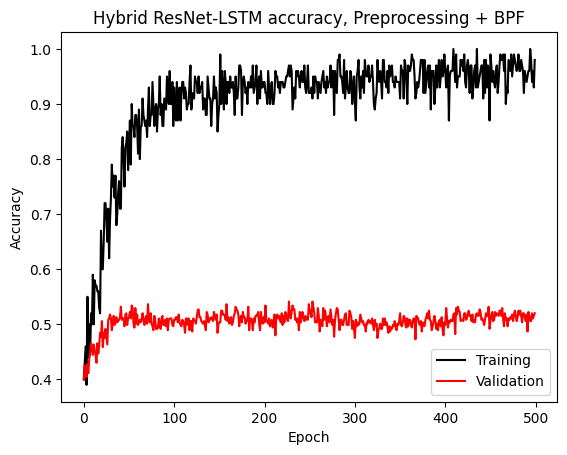

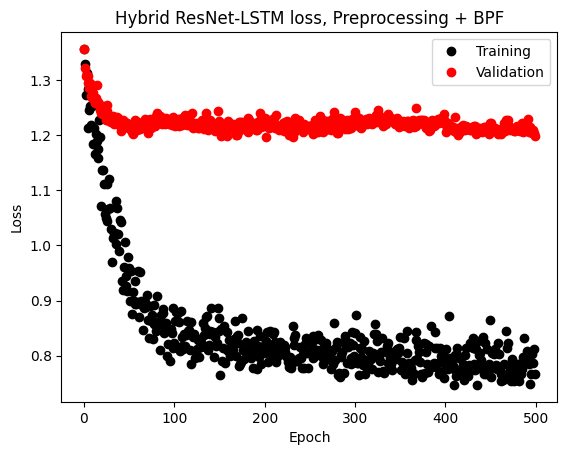

In [ ]:
#Update arrays and titles
plt.plot(np.arange(num_epochs),train_history_5,label='Training',color='k')
plt.plot(np.arange(num_epochs),val_history_5,label='Validation',color='r')
plt.title('Hybrid ResNet-LSTM accuracy, Preprocessing + BPF')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(np.arange(num_epochs),train_loss_hist_5,'o',label='Training',color='k')
plt.plot(np.arange(num_epochs),val_loss_hist_5,'o',label='Validation',color='r')
plt.title('Hybrid ResNet-LSTM loss, Preprocessing + BPF')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Part 6a: SGD w/ Momentum + Preprocessing + HPF

In [ ]:
## Randomly split the train/validation dataset
ind_valid = np.random.choice(X_train_valid.shape[0], int(X_train_valid.shape[0]/5), replace=False)
ind_train = np.array(list(set(range(X_train_valid.shape[0])).difference(set(ind_valid))))
x_valid, y_valid = X_train_valid[ind_valid], y_train_valid[ind_valid]
x_train, y_train = X_train_valid[ind_train], y_train_valid[ind_train]
print('Training and Validation shapes before preprocessing: ')
print('X train: ', x_train.shape, ' Y train: ', y_train.shape)
print('X val: ', x_valid.shape, ' Y val', y_valid.shape)

# Preprocessing the dataset
# pass only training data to train prep, val and test data to test prep

x_train,y_train = train_data_prep(x_train,y_train,2,2,True)
x_test, x_valid = test_data_prep(x_test), test_data_prep(x_valid)

x_train = torch.tensor(x_train).detach().float().to(device)
x_valid = torch.tensor(x_valid).detach().float().to(device)
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

# Converting the labels to categorical variables for multiclass classification
y_train, y_valid, y_test = torch.tensor(y_train).to(device), torch.tensor(y_valid).to(device), torch.tensor(y_test).to(device)
y_train = nn.functional.one_hot(y_train.long(), 4)
y_valid = nn.functional.one_hot(y_valid.long(), 4)
y_test = nn.functional.one_hot(y_test.long(), 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 2,3)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 2,3)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 2,3)
x_test = torch.tensor(x_test).detach().float().to(device)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

# Convert x train to numpy

x_train_np = x_train.cpu().numpy()
print(x_train_np.shape)

Training and Validation shapes before preprocessing: 
X train:  (1692, 22, 1000)  Y train:  (1692,)
X val:  (423, 22, 1000)  Y val (423,)
Shape of X after trimming: (1692, 22, 800)
Shape of X after maxpooling: (1692, 22, 400)
Shape of X after averaging+noise and concatenating: (3384, 22, 400)
Shape of X after subsampling and concatenating: (6768, 22, 400)
Shape of Y: (6768,)
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of X after trimming: (423, 22, 800)
Shape of X after maxpooling: (423, 22, 400)
Shape of training set: torch.Size([6768, 22, 400])
Shape of validation set: torch.Size([423, 22, 400])
Shape of training labels: (6768,)
Shape of validation labels: (423,)
Shape of training labels after categorical conversion: torch.Size([6768, 4])
Shape of validation labels after categorical conversion: torch.Size([423, 4])
Shape of test labels after categorical conversion: torch.Size([443, 4])
Shape of training set after adding width info: torc

In [ ]:
# Define the high-pass filter parameters
cutoff_frequency = 4  # Cut-off frequency in Hz
sampling_rate = 125  # Sampling rate in Hz (adjust based on your data)

# Design a Butterworth high-pass filter
order = 3  # Filter order
b, a = butter(N=order, Wn=cutoff_frequency / (0.5 * sampling_rate), btype='high', analog=False, output='ba')

x_train_hpf = np.zeros(x_train_np.shape)
# Apply the filter to the data
for i in range(x_train_np.shape[0]):
    for j in range(x_train_np.shape[2]):
        filtered_data = filtfilt(b, a, x_train_np[i,0,j,:])
        x_train_hpf[i,0,j,:] = filtered_data

x_train_hpf = torch.tensor(x_train_hpf).float().to(device)
print(x_train_hpf.shape)

torch.Size([6768, 1, 22, 400])


In [ ]:
#Build the model
model6 = ResNetLSTM(img_channels=1, block=BasicBlock, num_classes=4, time_dim=int(x_train.size(3)), dropout=0.6).to(device)
print(model6)
total_params = sum(p.numel() for p in model6.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model6.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

ResNetLSTM(
  (conv1): Conv2d(1, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
  (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(48, 48, kernel_size=(22, 1), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ELU(alpha=1.0, inplace=True)
  (res1): BasicBlock(
    (conv1): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout2d(p=0.6, inplace=False)
    (elu): ELU(alpha=1.0, inplace=True)
    (conv2): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2): Dropout2d(p=0.6, inplace=False)
    (shortcut): Identity()
  )
  (res2): BasicBlock(
    (conv1):

In [ ]:
# Choose Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model6.parameters(), lr=0.001, weight_decay=1e-4, momentum=0.9)
step_size = 25
gamma = 0.1
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
#optimizer = torch.optim.Adam(model6.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
# Rename these lines between models
train_history_6, val_history_6 = np.array([]), np.array([])
train_loss_hist_6, val_loss_hist_6 = np.array([]), np.array([])

with TemporaryDirectory() as tempdir:
    save_folder = '/content/drive/MyDrive/C147_Final_Project/best_model_params'

    # Rename these lines between models
    best_model_params_path = os.path.join(save_folder, 'best_model6_params.pt')
    torch.save(model6.state_dict(), best_model_params_path)

    best_acc = 0.0
    bsz = 100
    num_epochs = 500
    iteration = 0
    total_it = num_epochs*int(x_train.shape[0]/bsz)
    for epoch_idx in tqdm(range(num_epochs)):
        # Set model to train mode - useful for layers such as BatchNorm or Dropout whose behaviors change between train/eval
        # Rename
        model6.train()

        train_count = 0
        train_correct_count = 0
        for i in range(int(x_train.shape[0]/bsz)):
            iteration+=1
            optimizer.zero_grad() # Zero gradients, since we don't want gradients to accumulate between batches - we apply an update for each batch
            train_x, train_y = sample(x_train, y_train, bsz)
            #Rename
            logits = model6(train_x) #bszx4x1x4

            logits = nn.functional.softmax(logits, dim=1)
            loss = criterion(logits.float(), train_y.float())

            loss.backward()
            optimizer.step()
            scheduler.step()

            with torch.no_grad():
                #y_hat = torch.mean(logits, dim = 2)
                y_hat = torch.argmax(logits, dim=1)
                train_correct_count = torch.sum(y_hat == torch.argmax(train_y, dim=1))
                train_count = train_x.size(0)
                train_count = float(train_count)
            #print(f'(Iteration {iteration}/{total_it})Training Accuracy: ', (train_correct_count/train_count).item(), '. Loss: ', loss.item())


        train_acc = train_correct_count / train_count

        #Rename
        model6.eval()
        val_count = 0
        val_correct_count = 0
        with torch.no_grad():
            val_x = x_valid
            val_y = y_valid
            #Rename
            logits = model6(val_x).detach()
            logits = nn.functional.softmax(logits)
            val_loss = criterion(logits.float(), val_y.float())
            with torch.no_grad():
                y_hat = torch.argmax(logits, dim=1)
                val_correct_count = torch.sum(y_hat == torch.argmax(val_y, dim=1))
                val_count = float(val_x.size(0))
        val_acc = val_correct_count / y_valid.shape[0]

        print(f'Epoch {epoch_idx+1} Finished!!!')
        print('Train acc: {:.3f}, Val acc: {:.3f}'.format(train_acc, val_acc))
        print('Train loss: {:.3f}, Val loss: {:.3f}'.format(loss, val_loss))

        #Rename
        train_history_6 = np.append(train_history_6, train_acc.item())
        val_history_6 = np.append(val_history_6, val_acc.item())
        train_loss_hist_6 = np.append(train_loss_hist_6, loss.item())
        val_loss_hist_6 = np.append(val_loss_hist_6, val_loss.item())

        if val_acc > best_acc:
            best_acc = val_acc
            #Rename
            torch.save(model6.state_dict(), best_model_params_path)

    print(f'Best val Acc: {best_acc:4f}')

  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-75-014e918eb36a>:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = nn.functional.softmax(logits)
  0%|          | 1/500 [00:02<20:09,  2.42s/it]

Epoch 1 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


  0%|          | 2/500 [00:04<19:45,  2.38s/it]

Epoch 2 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


  1%|          | 3/500 [00:07<19:39,  2.37s/it]

Epoch 3 Finished!!!
Train acc: 0.180, Val acc: 0.253
Train loss: 1.392, Val loss: 1.388


  1%|          | 4/500 [00:09<19:36,  2.37s/it]

Epoch 4 Finished!!!
Train acc: 0.340, Val acc: 0.253
Train loss: 1.382, Val loss: 1.388


  1%|          | 5/500 [00:11<19:35,  2.37s/it]

Epoch 5 Finished!!!
Train acc: 0.300, Val acc: 0.253
Train loss: 1.384, Val loss: 1.388


  1%|          | 6/500 [00:14<19:33,  2.38s/it]

Epoch 6 Finished!!!
Train acc: 0.210, Val acc: 0.253
Train loss: 1.395, Val loss: 1.388


  1%|▏         | 7/500 [00:16<19:34,  2.38s/it]

Epoch 7 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


  2%|▏         | 8/500 [00:19<19:35,  2.39s/it]

Epoch 8 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.385, Val loss: 1.388


  2%|▏         | 9/500 [00:21<19:34,  2.39s/it]

Epoch 9 Finished!!!
Train acc: 0.210, Val acc: 0.253
Train loss: 1.391, Val loss: 1.388


  2%|▏         | 10/500 [00:23<19:32,  2.39s/it]

Epoch 10 Finished!!!
Train acc: 0.210, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


  2%|▏         | 11/500 [00:26<19:29,  2.39s/it]

Epoch 11 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


  2%|▏         | 12/500 [00:28<19:25,  2.39s/it]

Epoch 12 Finished!!!
Train acc: 0.220, Val acc: 0.253
Train loss: 1.398, Val loss: 1.388


  3%|▎         | 13/500 [00:31<19:22,  2.39s/it]

Epoch 13 Finished!!!
Train acc: 0.300, Val acc: 0.253
Train loss: 1.382, Val loss: 1.388


  3%|▎         | 14/500 [00:33<19:17,  2.38s/it]

Epoch 14 Finished!!!
Train acc: 0.230, Val acc: 0.253
Train loss: 1.391, Val loss: 1.388


  3%|▎         | 15/500 [00:35<19:13,  2.38s/it]

Epoch 15 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


  3%|▎         | 16/500 [00:38<19:08,  2.37s/it]

Epoch 16 Finished!!!
Train acc: 0.280, Val acc: 0.253
Train loss: 1.390, Val loss: 1.388


  3%|▎         | 17/500 [00:40<19:03,  2.37s/it]

Epoch 17 Finished!!!
Train acc: 0.280, Val acc: 0.253
Train loss: 1.387, Val loss: 1.388


  4%|▎         | 18/500 [00:42<19:00,  2.37s/it]

Epoch 18 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


  4%|▍         | 19/500 [00:45<18:58,  2.37s/it]

Epoch 19 Finished!!!
Train acc: 0.210, Val acc: 0.253
Train loss: 1.387, Val loss: 1.388


  4%|▍         | 20/500 [00:47<18:53,  2.36s/it]

Epoch 20 Finished!!!
Train acc: 0.190, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


  4%|▍         | 21/500 [00:49<18:48,  2.36s/it]

Epoch 21 Finished!!!
Train acc: 0.200, Val acc: 0.253
Train loss: 1.392, Val loss: 1.388


  4%|▍         | 22/500 [00:52<18:54,  2.37s/it]

Epoch 22 Finished!!!
Train acc: 0.300, Val acc: 0.253
Train loss: 1.384, Val loss: 1.388


  5%|▍         | 23/500 [00:54<18:47,  2.36s/it]

Epoch 23 Finished!!!
Train acc: 0.210, Val acc: 0.253
Train loss: 1.390, Val loss: 1.388


  5%|▍         | 24/500 [00:56<18:41,  2.36s/it]

Epoch 24 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.382, Val loss: 1.388


  5%|▌         | 25/500 [00:59<18:37,  2.35s/it]

Epoch 25 Finished!!!
Train acc: 0.220, Val acc: 0.253
Train loss: 1.394, Val loss: 1.388


  5%|▌         | 26/500 [01:01<18:32,  2.35s/it]

Epoch 26 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


  5%|▌         | 27/500 [01:04<18:29,  2.34s/it]

Epoch 27 Finished!!!
Train acc: 0.270, Val acc: 0.253
Train loss: 1.390, Val loss: 1.388


  6%|▌         | 28/500 [01:06<18:25,  2.34s/it]

Epoch 28 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.386, Val loss: 1.388


  6%|▌         | 29/500 [01:08<18:21,  2.34s/it]

Epoch 29 Finished!!!
Train acc: 0.290, Val acc: 0.253
Train loss: 1.384, Val loss: 1.388


  6%|▌         | 30/500 [01:11<18:20,  2.34s/it]

Epoch 30 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.385, Val loss: 1.388


  6%|▌         | 31/500 [01:13<18:18,  2.34s/it]

Epoch 31 Finished!!!
Train acc: 0.200, Val acc: 0.253
Train loss: 1.391, Val loss: 1.388


  6%|▋         | 32/500 [01:15<18:16,  2.34s/it]

Epoch 32 Finished!!!
Train acc: 0.280, Val acc: 0.253
Train loss: 1.385, Val loss: 1.388


  7%|▋         | 33/500 [01:18<18:14,  2.34s/it]

Epoch 33 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.385, Val loss: 1.388


  7%|▋         | 34/500 [01:20<18:12,  2.34s/it]

Epoch 34 Finished!!!
Train acc: 0.270, Val acc: 0.253
Train loss: 1.385, Val loss: 1.388


  7%|▋         | 35/500 [01:22<18:11,  2.35s/it]

Epoch 35 Finished!!!
Train acc: 0.140, Val acc: 0.253
Train loss: 1.393, Val loss: 1.388


  7%|▋         | 36/500 [01:25<18:09,  2.35s/it]

Epoch 36 Finished!!!
Train acc: 0.300, Val acc: 0.253
Train loss: 1.382, Val loss: 1.388


  7%|▋         | 37/500 [01:27<18:08,  2.35s/it]

Epoch 37 Finished!!!
Train acc: 0.210, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


  8%|▊         | 38/500 [01:29<18:06,  2.35s/it]

Epoch 38 Finished!!!
Train acc: 0.230, Val acc: 0.253
Train loss: 1.386, Val loss: 1.388


  8%|▊         | 39/500 [01:32<18:04,  2.35s/it]

Epoch 39 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.391, Val loss: 1.388


  8%|▊         | 40/500 [01:34<18:02,  2.35s/it]

Epoch 40 Finished!!!
Train acc: 0.140, Val acc: 0.253
Train loss: 1.405, Val loss: 1.388


  8%|▊         | 41/500 [01:36<18:01,  2.36s/it]

Epoch 41 Finished!!!
Train acc: 0.190, Val acc: 0.253
Train loss: 1.391, Val loss: 1.388


  8%|▊         | 42/500 [01:39<17:59,  2.36s/it]

Epoch 42 Finished!!!
Train acc: 0.230, Val acc: 0.253
Train loss: 1.392, Val loss: 1.388


  9%|▊         | 43/500 [01:41<17:57,  2.36s/it]

Epoch 43 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.385, Val loss: 1.388


  9%|▉         | 44/500 [01:43<17:55,  2.36s/it]

Epoch 44 Finished!!!
Train acc: 0.230, Val acc: 0.253
Train loss: 1.386, Val loss: 1.388


  9%|▉         | 45/500 [01:46<17:52,  2.36s/it]

Epoch 45 Finished!!!
Train acc: 0.290, Val acc: 0.253
Train loss: 1.382, Val loss: 1.388


  9%|▉         | 46/500 [01:48<17:50,  2.36s/it]

Epoch 46 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.385, Val loss: 1.388


  9%|▉         | 47/500 [01:51<17:49,  2.36s/it]

Epoch 47 Finished!!!
Train acc: 0.220, Val acc: 0.253
Train loss: 1.395, Val loss: 1.388


 10%|▉         | 48/500 [01:53<17:46,  2.36s/it]

Epoch 48 Finished!!!
Train acc: 0.220, Val acc: 0.253
Train loss: 1.397, Val loss: 1.388


 10%|▉         | 49/500 [01:55<17:44,  2.36s/it]

Epoch 49 Finished!!!
Train acc: 0.340, Val acc: 0.253
Train loss: 1.381, Val loss: 1.388


 10%|█         | 50/500 [01:58<17:41,  2.36s/it]

Epoch 50 Finished!!!
Train acc: 0.220, Val acc: 0.253
Train loss: 1.390, Val loss: 1.388


 10%|█         | 51/500 [02:00<17:39,  2.36s/it]

Epoch 51 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.387, Val loss: 1.388


 10%|█         | 52/500 [02:02<17:36,  2.36s/it]

Epoch 52 Finished!!!
Train acc: 0.200, Val acc: 0.253
Train loss: 1.396, Val loss: 1.388


 11%|█         | 53/500 [02:05<17:33,  2.36s/it]

Epoch 53 Finished!!!
Train acc: 0.280, Val acc: 0.253
Train loss: 1.390, Val loss: 1.388


 11%|█         | 54/500 [02:07<17:31,  2.36s/it]

Epoch 54 Finished!!!
Train acc: 0.270, Val acc: 0.253
Train loss: 1.383, Val loss: 1.388


 11%|█         | 55/500 [02:09<17:28,  2.36s/it]

Epoch 55 Finished!!!
Train acc: 0.350, Val acc: 0.253
Train loss: 1.381, Val loss: 1.388


 11%|█         | 56/500 [02:12<17:25,  2.35s/it]

Epoch 56 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.385, Val loss: 1.388


 11%|█▏        | 57/500 [02:14<17:23,  2.36s/it]

Epoch 57 Finished!!!
Train acc: 0.190, Val acc: 0.253
Train loss: 1.394, Val loss: 1.388


 12%|█▏        | 58/500 [02:16<17:21,  2.36s/it]

Epoch 58 Finished!!!
Train acc: 0.310, Val acc: 0.253
Train loss: 1.380, Val loss: 1.388


 12%|█▏        | 59/500 [02:19<17:17,  2.35s/it]

Epoch 59 Finished!!!
Train acc: 0.350, Val acc: 0.253
Train loss: 1.378, Val loss: 1.388


 12%|█▏        | 60/500 [02:21<17:14,  2.35s/it]

Epoch 60 Finished!!!
Train acc: 0.280, Val acc: 0.253
Train loss: 1.381, Val loss: 1.388


 12%|█▏        | 61/500 [02:24<17:12,  2.35s/it]

Epoch 61 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 12%|█▏        | 62/500 [02:26<17:10,  2.35s/it]

Epoch 62 Finished!!!
Train acc: 0.270, Val acc: 0.253
Train loss: 1.387, Val loss: 1.388


 13%|█▎        | 63/500 [02:28<17:08,  2.35s/it]

Epoch 63 Finished!!!
Train acc: 0.270, Val acc: 0.253
Train loss: 1.385, Val loss: 1.388


 13%|█▎        | 64/500 [02:31<17:05,  2.35s/it]

Epoch 64 Finished!!!
Train acc: 0.200, Val acc: 0.253
Train loss: 1.390, Val loss: 1.388


 13%|█▎        | 65/500 [02:33<17:02,  2.35s/it]

Epoch 65 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.393, Val loss: 1.388


 13%|█▎        | 66/500 [02:35<16:59,  2.35s/it]

Epoch 66 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.385, Val loss: 1.388


 13%|█▎        | 67/500 [02:38<17:09,  2.38s/it]

Epoch 67 Finished!!!
Train acc: 0.210, Val acc: 0.253
Train loss: 1.391, Val loss: 1.388


 14%|█▎        | 68/500 [02:40<17:04,  2.37s/it]

Epoch 68 Finished!!!
Train acc: 0.190, Val acc: 0.253
Train loss: 1.397, Val loss: 1.388


 14%|█▍        | 69/500 [02:42<16:58,  2.36s/it]

Epoch 69 Finished!!!
Train acc: 0.300, Val acc: 0.253
Train loss: 1.385, Val loss: 1.388


 14%|█▍        | 70/500 [02:45<16:54,  2.36s/it]

Epoch 70 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.397, Val loss: 1.388


 14%|█▍        | 71/500 [02:47<16:50,  2.36s/it]

Epoch 71 Finished!!!
Train acc: 0.230, Val acc: 0.253
Train loss: 1.387, Val loss: 1.388


 14%|█▍        | 72/500 [02:49<16:47,  2.35s/it]

Epoch 72 Finished!!!
Train acc: 0.210, Val acc: 0.253
Train loss: 1.394, Val loss: 1.388


 15%|█▍        | 73/500 [02:52<16:44,  2.35s/it]

Epoch 73 Finished!!!
Train acc: 0.310, Val acc: 0.253
Train loss: 1.381, Val loss: 1.388


 15%|█▍        | 74/500 [02:54<16:43,  2.35s/it]

Epoch 74 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.380, Val loss: 1.388


 15%|█▌        | 75/500 [02:57<16:39,  2.35s/it]

Epoch 75 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 15%|█▌        | 76/500 [02:59<16:36,  2.35s/it]

Epoch 76 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


 15%|█▌        | 77/500 [03:01<16:34,  2.35s/it]

Epoch 77 Finished!!!
Train acc: 0.280, Val acc: 0.253
Train loss: 1.390, Val loss: 1.388


 16%|█▌        | 78/500 [03:04<16:31,  2.35s/it]

Epoch 78 Finished!!!
Train acc: 0.160, Val acc: 0.253
Train loss: 1.400, Val loss: 1.388


 16%|█▌        | 79/500 [03:06<16:29,  2.35s/it]

Epoch 79 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 16%|█▌        | 80/500 [03:08<16:27,  2.35s/it]

Epoch 80 Finished!!!
Train acc: 0.220, Val acc: 0.253
Train loss: 1.394, Val loss: 1.388


 16%|█▌        | 81/500 [03:11<16:24,  2.35s/it]

Epoch 81 Finished!!!
Train acc: 0.210, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 16%|█▋        | 82/500 [03:13<16:21,  2.35s/it]

Epoch 82 Finished!!!
Train acc: 0.220, Val acc: 0.253
Train loss: 1.392, Val loss: 1.388


 17%|█▋        | 83/500 [03:15<16:19,  2.35s/it]

Epoch 83 Finished!!!
Train acc: 0.200, Val acc: 0.253
Train loss: 1.393, Val loss: 1.388


 17%|█▋        | 84/500 [03:18<16:17,  2.35s/it]

Epoch 84 Finished!!!
Train acc: 0.220, Val acc: 0.253
Train loss: 1.393, Val loss: 1.388


 17%|█▋        | 85/500 [03:20<16:16,  2.35s/it]

Epoch 85 Finished!!!
Train acc: 0.210, Val acc: 0.253
Train loss: 1.394, Val loss: 1.388


 17%|█▋        | 86/500 [03:22<16:13,  2.35s/it]

Epoch 86 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.386, Val loss: 1.388


 17%|█▋        | 87/500 [03:25<16:11,  2.35s/it]

Epoch 87 Finished!!!
Train acc: 0.270, Val acc: 0.253
Train loss: 1.385, Val loss: 1.388


 18%|█▊        | 88/500 [03:27<16:08,  2.35s/it]

Epoch 88 Finished!!!
Train acc: 0.310, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


 18%|█▊        | 89/500 [03:29<16:06,  2.35s/it]

Epoch 89 Finished!!!
Train acc: 0.200, Val acc: 0.253
Train loss: 1.387, Val loss: 1.388


 18%|█▊        | 90/500 [03:32<16:05,  2.36s/it]

Epoch 90 Finished!!!
Train acc: 0.270, Val acc: 0.253
Train loss: 1.385, Val loss: 1.388


 18%|█▊        | 91/500 [03:34<16:03,  2.36s/it]

Epoch 91 Finished!!!
Train acc: 0.160, Val acc: 0.253
Train loss: 1.399, Val loss: 1.388


 18%|█▊        | 92/500 [03:36<16:00,  2.35s/it]

Epoch 92 Finished!!!
Train acc: 0.270, Val acc: 0.253
Train loss: 1.382, Val loss: 1.388


 19%|█▊        | 93/500 [03:39<15:57,  2.35s/it]

Epoch 93 Finished!!!
Train acc: 0.180, Val acc: 0.253
Train loss: 1.394, Val loss: 1.388


 19%|█▉        | 94/500 [03:41<15:55,  2.35s/it]

Epoch 94 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.385, Val loss: 1.388


 19%|█▉        | 95/500 [03:44<15:53,  2.35s/it]

Epoch 95 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


 19%|█▉        | 96/500 [03:46<15:51,  2.36s/it]

Epoch 96 Finished!!!
Train acc: 0.310, Val acc: 0.253
Train loss: 1.377, Val loss: 1.388


 19%|█▉        | 97/500 [03:48<15:48,  2.35s/it]

Epoch 97 Finished!!!
Train acc: 0.280, Val acc: 0.253
Train loss: 1.383, Val loss: 1.388


 20%|█▉        | 98/500 [03:51<15:45,  2.35s/it]

Epoch 98 Finished!!!
Train acc: 0.350, Val acc: 0.253
Train loss: 1.378, Val loss: 1.388


 20%|█▉        | 99/500 [03:53<15:42,  2.35s/it]

Epoch 99 Finished!!!
Train acc: 0.230, Val acc: 0.253
Train loss: 1.386, Val loss: 1.388


 20%|██        | 100/500 [03:55<15:40,  2.35s/it]

Epoch 100 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.383, Val loss: 1.388


 20%|██        | 101/500 [03:58<15:38,  2.35s/it]

Epoch 101 Finished!!!
Train acc: 0.220, Val acc: 0.253
Train loss: 1.381, Val loss: 1.388


 20%|██        | 102/500 [04:00<15:35,  2.35s/it]

Epoch 102 Finished!!!
Train acc: 0.180, Val acc: 0.253
Train loss: 1.397, Val loss: 1.388


 21%|██        | 103/500 [04:02<15:32,  2.35s/it]

Epoch 103 Finished!!!
Train acc: 0.200, Val acc: 0.253
Train loss: 1.393, Val loss: 1.388


 21%|██        | 104/500 [04:05<15:30,  2.35s/it]

Epoch 104 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


 21%|██        | 105/500 [04:07<15:28,  2.35s/it]

Epoch 105 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.391, Val loss: 1.388


 21%|██        | 106/500 [04:09<15:26,  2.35s/it]

Epoch 106 Finished!!!
Train acc: 0.290, Val acc: 0.253
Train loss: 1.387, Val loss: 1.388


 21%|██▏       | 107/500 [04:12<15:24,  2.35s/it]

Epoch 107 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.390, Val loss: 1.388


 22%|██▏       | 108/500 [04:14<15:21,  2.35s/it]

Epoch 108 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 22%|██▏       | 109/500 [04:16<15:19,  2.35s/it]

Epoch 109 Finished!!!
Train acc: 0.290, Val acc: 0.253
Train loss: 1.380, Val loss: 1.388


 22%|██▏       | 110/500 [04:19<15:16,  2.35s/it]

Epoch 110 Finished!!!
Train acc: 0.220, Val acc: 0.253
Train loss: 1.396, Val loss: 1.388


 22%|██▏       | 111/500 [04:21<15:14,  2.35s/it]

Epoch 111 Finished!!!
Train acc: 0.200, Val acc: 0.253
Train loss: 1.396, Val loss: 1.388


 22%|██▏       | 112/500 [04:24<15:32,  2.40s/it]

Epoch 112 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.395, Val loss: 1.388


 23%|██▎       | 113/500 [04:26<15:25,  2.39s/it]

Epoch 113 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.385, Val loss: 1.388


 23%|██▎       | 114/500 [04:28<15:18,  2.38s/it]

Epoch 114 Finished!!!
Train acc: 0.270, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 23%|██▎       | 115/500 [04:31<15:12,  2.37s/it]

Epoch 115 Finished!!!
Train acc: 0.320, Val acc: 0.253
Train loss: 1.382, Val loss: 1.388


 23%|██▎       | 116/500 [04:33<15:07,  2.36s/it]

Epoch 116 Finished!!!
Train acc: 0.190, Val acc: 0.253
Train loss: 1.390, Val loss: 1.388


 23%|██▎       | 117/500 [04:35<15:04,  2.36s/it]

Epoch 117 Finished!!!
Train acc: 0.300, Val acc: 0.253
Train loss: 1.385, Val loss: 1.388


 24%|██▎       | 118/500 [04:38<15:00,  2.36s/it]

Epoch 118 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.384, Val loss: 1.388


 24%|██▍       | 119/500 [04:40<14:57,  2.35s/it]

Epoch 119 Finished!!!
Train acc: 0.290, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


 24%|██▍       | 120/500 [04:43<14:54,  2.35s/it]

Epoch 120 Finished!!!
Train acc: 0.190, Val acc: 0.253
Train loss: 1.391, Val loss: 1.388


 24%|██▍       | 121/500 [04:45<14:51,  2.35s/it]

Epoch 121 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.393, Val loss: 1.388


 24%|██▍       | 122/500 [04:47<14:48,  2.35s/it]

Epoch 122 Finished!!!
Train acc: 0.190, Val acc: 0.253
Train loss: 1.397, Val loss: 1.388


 25%|██▍       | 123/500 [04:50<14:47,  2.35s/it]

Epoch 123 Finished!!!
Train acc: 0.190, Val acc: 0.253
Train loss: 1.391, Val loss: 1.388


 25%|██▍       | 124/500 [04:52<14:44,  2.35s/it]

Epoch 124 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


 25%|██▌       | 125/500 [04:54<14:42,  2.35s/it]

Epoch 125 Finished!!!
Train acc: 0.200, Val acc: 0.253
Train loss: 1.386, Val loss: 1.388


 25%|██▌       | 126/500 [04:57<14:39,  2.35s/it]

Epoch 126 Finished!!!
Train acc: 0.220, Val acc: 0.253
Train loss: 1.391, Val loss: 1.388


 25%|██▌       | 127/500 [04:59<14:36,  2.35s/it]

Epoch 127 Finished!!!
Train acc: 0.160, Val acc: 0.253
Train loss: 1.400, Val loss: 1.388


 26%|██▌       | 128/500 [05:01<14:35,  2.35s/it]

Epoch 128 Finished!!!
Train acc: 0.180, Val acc: 0.253
Train loss: 1.391, Val loss: 1.388


 26%|██▌       | 129/500 [05:04<14:33,  2.35s/it]

Epoch 129 Finished!!!
Train acc: 0.280, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 26%|██▌       | 130/500 [05:06<14:30,  2.35s/it]

Epoch 130 Finished!!!
Train acc: 0.300, Val acc: 0.253
Train loss: 1.385, Val loss: 1.388


 26%|██▌       | 131/500 [05:08<14:27,  2.35s/it]

Epoch 131 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.387, Val loss: 1.388


 26%|██▋       | 132/500 [05:11<14:24,  2.35s/it]

Epoch 132 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.393, Val loss: 1.388


 27%|██▋       | 133/500 [05:13<14:23,  2.35s/it]

Epoch 133 Finished!!!
Train acc: 0.270, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 27%|██▋       | 134/500 [05:15<14:21,  2.35s/it]

Epoch 134 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 27%|██▋       | 135/500 [05:18<14:18,  2.35s/it]

Epoch 135 Finished!!!
Train acc: 0.210, Val acc: 0.253
Train loss: 1.391, Val loss: 1.388


 27%|██▋       | 136/500 [05:20<14:15,  2.35s/it]

Epoch 136 Finished!!!
Train acc: 0.220, Val acc: 0.253
Train loss: 1.396, Val loss: 1.388


 27%|██▋       | 137/500 [05:22<14:13,  2.35s/it]

Epoch 137 Finished!!!
Train acc: 0.300, Val acc: 0.253
Train loss: 1.383, Val loss: 1.388


 28%|██▊       | 138/500 [05:25<14:10,  2.35s/it]

Epoch 138 Finished!!!
Train acc: 0.220, Val acc: 0.253
Train loss: 1.385, Val loss: 1.388


 28%|██▊       | 139/500 [05:27<14:08,  2.35s/it]

Epoch 139 Finished!!!
Train acc: 0.280, Val acc: 0.253
Train loss: 1.386, Val loss: 1.388


 28%|██▊       | 140/500 [05:30<14:05,  2.35s/it]

Epoch 140 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.392, Val loss: 1.388


 28%|██▊       | 141/500 [05:32<14:03,  2.35s/it]

Epoch 141 Finished!!!
Train acc: 0.280, Val acc: 0.253
Train loss: 1.386, Val loss: 1.388


 28%|██▊       | 142/500 [05:34<14:01,  2.35s/it]

Epoch 142 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.392, Val loss: 1.388


 29%|██▊       | 143/500 [05:37<13:59,  2.35s/it]

Epoch 143 Finished!!!
Train acc: 0.220, Val acc: 0.253
Train loss: 1.394, Val loss: 1.388


 29%|██▉       | 144/500 [05:39<13:57,  2.35s/it]

Epoch 144 Finished!!!
Train acc: 0.190, Val acc: 0.253
Train loss: 1.398, Val loss: 1.388


 29%|██▉       | 145/500 [05:41<13:54,  2.35s/it]

Epoch 145 Finished!!!
Train acc: 0.310, Val acc: 0.253
Train loss: 1.377, Val loss: 1.388


 29%|██▉       | 146/500 [05:44<13:51,  2.35s/it]

Epoch 146 Finished!!!
Train acc: 0.290, Val acc: 0.253
Train loss: 1.380, Val loss: 1.388


 29%|██▉       | 147/500 [05:46<13:49,  2.35s/it]

Epoch 147 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.387, Val loss: 1.388


 30%|██▉       | 148/500 [05:48<13:46,  2.35s/it]

Epoch 148 Finished!!!
Train acc: 0.180, Val acc: 0.253
Train loss: 1.397, Val loss: 1.388


 30%|██▉       | 149/500 [05:51<13:44,  2.35s/it]

Epoch 149 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


 30%|███       | 150/500 [05:53<13:42,  2.35s/it]

Epoch 150 Finished!!!
Train acc: 0.300, Val acc: 0.253
Train loss: 1.382, Val loss: 1.388


 30%|███       | 151/500 [05:55<13:40,  2.35s/it]

Epoch 151 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.391, Val loss: 1.388


 30%|███       | 152/500 [05:58<13:37,  2.35s/it]

Epoch 152 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 31%|███       | 153/500 [06:00<13:35,  2.35s/it]

Epoch 153 Finished!!!
Train acc: 0.290, Val acc: 0.253
Train loss: 1.384, Val loss: 1.388


 31%|███       | 154/500 [06:02<13:33,  2.35s/it]

Epoch 154 Finished!!!
Train acc: 0.190, Val acc: 0.253
Train loss: 1.394, Val loss: 1.388


 31%|███       | 155/500 [06:05<13:31,  2.35s/it]

Epoch 155 Finished!!!
Train acc: 0.160, Val acc: 0.253
Train loss: 1.399, Val loss: 1.388


 31%|███       | 156/500 [06:07<13:28,  2.35s/it]

Epoch 156 Finished!!!
Train acc: 0.270, Val acc: 0.253
Train loss: 1.390, Val loss: 1.388


 31%|███▏      | 157/500 [06:09<13:26,  2.35s/it]

Epoch 157 Finished!!!
Train acc: 0.330, Val acc: 0.253
Train loss: 1.374, Val loss: 1.388


 32%|███▏      | 158/500 [06:12<13:24,  2.35s/it]

Epoch 158 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


 32%|███▏      | 159/500 [06:14<13:21,  2.35s/it]

Epoch 159 Finished!!!
Train acc: 0.340, Val acc: 0.253
Train loss: 1.380, Val loss: 1.388


 32%|███▏      | 160/500 [06:17<13:19,  2.35s/it]

Epoch 160 Finished!!!
Train acc: 0.200, Val acc: 0.253
Train loss: 1.392, Val loss: 1.388


 32%|███▏      | 161/500 [06:19<13:17,  2.35s/it]

Epoch 161 Finished!!!
Train acc: 0.300, Val acc: 0.253
Train loss: 1.380, Val loss: 1.388


 32%|███▏      | 162/500 [06:21<13:15,  2.35s/it]

Epoch 162 Finished!!!
Train acc: 0.290, Val acc: 0.253
Train loss: 1.384, Val loss: 1.388


 33%|███▎      | 163/500 [06:24<13:13,  2.35s/it]

Epoch 163 Finished!!!
Train acc: 0.300, Val acc: 0.253
Train loss: 1.381, Val loss: 1.388


 33%|███▎      | 164/500 [06:26<13:10,  2.35s/it]

Epoch 164 Finished!!!
Train acc: 0.210, Val acc: 0.253
Train loss: 1.392, Val loss: 1.388


 33%|███▎      | 165/500 [06:28<13:08,  2.35s/it]

Epoch 165 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 33%|███▎      | 166/500 [06:31<13:06,  2.35s/it]

Epoch 166 Finished!!!
Train acc: 0.270, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


 33%|███▎      | 167/500 [06:33<13:03,  2.35s/it]

Epoch 167 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.396, Val loss: 1.388


 34%|███▎      | 168/500 [06:35<13:00,  2.35s/it]

Epoch 168 Finished!!!
Train acc: 0.300, Val acc: 0.253
Train loss: 1.394, Val loss: 1.388


 34%|███▍      | 169/500 [06:38<12:58,  2.35s/it]

Epoch 169 Finished!!!
Train acc: 0.270, Val acc: 0.253
Train loss: 1.384, Val loss: 1.388


 34%|███▍      | 170/500 [06:40<12:55,  2.35s/it]

Epoch 170 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.392, Val loss: 1.388


 34%|███▍      | 171/500 [06:42<12:53,  2.35s/it]

Epoch 171 Finished!!!
Train acc: 0.220, Val acc: 0.253
Train loss: 1.391, Val loss: 1.388


 34%|███▍      | 172/500 [06:45<12:51,  2.35s/it]

Epoch 172 Finished!!!
Train acc: 0.230, Val acc: 0.253
Train loss: 1.387, Val loss: 1.388


 35%|███▍      | 173/500 [06:47<12:48,  2.35s/it]

Epoch 173 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.387, Val loss: 1.388


 35%|███▍      | 174/500 [06:49<12:46,  2.35s/it]

Epoch 174 Finished!!!
Train acc: 0.200, Val acc: 0.253
Train loss: 1.394, Val loss: 1.388


 35%|███▌      | 175/500 [06:52<12:43,  2.35s/it]

Epoch 175 Finished!!!
Train acc: 0.180, Val acc: 0.253
Train loss: 1.394, Val loss: 1.388


 35%|███▌      | 176/500 [06:54<12:41,  2.35s/it]

Epoch 176 Finished!!!
Train acc: 0.200, Val acc: 0.253
Train loss: 1.394, Val loss: 1.388


 35%|███▌      | 177/500 [06:57<12:39,  2.35s/it]

Epoch 177 Finished!!!
Train acc: 0.200, Val acc: 0.253
Train loss: 1.400, Val loss: 1.388


 36%|███▌      | 178/500 [06:59<12:37,  2.35s/it]

Epoch 178 Finished!!!
Train acc: 0.220, Val acc: 0.253
Train loss: 1.393, Val loss: 1.388


 36%|███▌      | 179/500 [07:01<12:34,  2.35s/it]

Epoch 179 Finished!!!
Train acc: 0.310, Val acc: 0.253
Train loss: 1.386, Val loss: 1.388


 36%|███▌      | 180/500 [07:04<12:32,  2.35s/it]

Epoch 180 Finished!!!
Train acc: 0.180, Val acc: 0.253
Train loss: 1.390, Val loss: 1.388


 36%|███▌      | 181/500 [07:06<12:29,  2.35s/it]

Epoch 181 Finished!!!
Train acc: 0.310, Val acc: 0.253
Train loss: 1.386, Val loss: 1.388


 36%|███▋      | 182/500 [07:08<12:27,  2.35s/it]

Epoch 182 Finished!!!
Train acc: 0.190, Val acc: 0.253
Train loss: 1.396, Val loss: 1.388


 37%|███▋      | 183/500 [07:11<12:25,  2.35s/it]

Epoch 183 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.386, Val loss: 1.388


 37%|███▋      | 184/500 [07:13<12:23,  2.35s/it]

Epoch 184 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 37%|███▋      | 185/500 [07:15<12:20,  2.35s/it]

Epoch 185 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.387, Val loss: 1.388


 37%|███▋      | 186/500 [07:18<12:18,  2.35s/it]

Epoch 186 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 37%|███▋      | 187/500 [07:20<12:15,  2.35s/it]

Epoch 187 Finished!!!
Train acc: 0.200, Val acc: 0.253
Train loss: 1.395, Val loss: 1.388


 38%|███▊      | 188/500 [07:22<12:13,  2.35s/it]

Epoch 188 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.386, Val loss: 1.388


 38%|███▊      | 189/500 [07:25<12:11,  2.35s/it]

Epoch 189 Finished!!!
Train acc: 0.350, Val acc: 0.253
Train loss: 1.380, Val loss: 1.388


 38%|███▊      | 190/500 [07:27<12:08,  2.35s/it]

Epoch 190 Finished!!!
Train acc: 0.220, Val acc: 0.253
Train loss: 1.386, Val loss: 1.388


 38%|███▊      | 191/500 [07:29<12:06,  2.35s/it]

Epoch 191 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 38%|███▊      | 192/500 [07:32<12:03,  2.35s/it]

Epoch 192 Finished!!!
Train acc: 0.340, Val acc: 0.253
Train loss: 1.377, Val loss: 1.388


 39%|███▊      | 193/500 [07:34<12:01,  2.35s/it]

Epoch 193 Finished!!!
Train acc: 0.270, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


 39%|███▉      | 194/500 [07:36<11:59,  2.35s/it]

Epoch 194 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 39%|███▉      | 195/500 [07:39<11:56,  2.35s/it]

Epoch 195 Finished!!!
Train acc: 0.210, Val acc: 0.253
Train loss: 1.393, Val loss: 1.388


 39%|███▉      | 196/500 [07:41<11:54,  2.35s/it]

Epoch 196 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


 39%|███▉      | 197/500 [07:44<11:52,  2.35s/it]

Epoch 197 Finished!!!
Train acc: 0.160, Val acc: 0.253
Train loss: 1.401, Val loss: 1.388


 40%|███▉      | 198/500 [07:46<11:50,  2.35s/it]

Epoch 198 Finished!!!
Train acc: 0.220, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 40%|███▉      | 199/500 [07:48<11:47,  2.35s/it]

Epoch 199 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


 40%|████      | 200/500 [07:51<11:45,  2.35s/it]

Epoch 200 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.393, Val loss: 1.388


 40%|████      | 201/500 [07:53<11:43,  2.35s/it]

Epoch 201 Finished!!!
Train acc: 0.300, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 40%|████      | 202/500 [07:55<11:40,  2.35s/it]

Epoch 202 Finished!!!
Train acc: 0.280, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


 41%|████      | 203/500 [07:58<11:37,  2.35s/it]

Epoch 203 Finished!!!
Train acc: 0.220, Val acc: 0.253
Train loss: 1.392, Val loss: 1.388


 41%|████      | 204/500 [08:00<11:35,  2.35s/it]

Epoch 204 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 41%|████      | 205/500 [08:02<11:33,  2.35s/it]

Epoch 205 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 41%|████      | 206/500 [08:05<11:31,  2.35s/it]

Epoch 206 Finished!!!
Train acc: 0.220, Val acc: 0.253
Train loss: 1.387, Val loss: 1.388


 41%|████▏     | 207/500 [08:07<11:29,  2.35s/it]

Epoch 207 Finished!!!
Train acc: 0.210, Val acc: 0.253
Train loss: 1.396, Val loss: 1.388


 42%|████▏     | 208/500 [08:09<11:26,  2.35s/it]

Epoch 208 Finished!!!
Train acc: 0.280, Val acc: 0.253
Train loss: 1.393, Val loss: 1.388


 42%|████▏     | 209/500 [08:12<11:23,  2.35s/it]

Epoch 209 Finished!!!
Train acc: 0.290, Val acc: 0.253
Train loss: 1.382, Val loss: 1.388


 42%|████▏     | 210/500 [08:14<11:21,  2.35s/it]

Epoch 210 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.387, Val loss: 1.388


 42%|████▏     | 211/500 [08:16<11:19,  2.35s/it]

Epoch 211 Finished!!!
Train acc: 0.290, Val acc: 0.253
Train loss: 1.382, Val loss: 1.388


 42%|████▏     | 212/500 [08:19<11:16,  2.35s/it]

Epoch 212 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.383, Val loss: 1.388


 43%|████▎     | 213/500 [08:21<11:14,  2.35s/it]

Epoch 213 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


 43%|████▎     | 214/500 [08:23<11:12,  2.35s/it]

Epoch 214 Finished!!!
Train acc: 0.170, Val acc: 0.253
Train loss: 1.395, Val loss: 1.388


 43%|████▎     | 215/500 [08:26<11:10,  2.35s/it]

Epoch 215 Finished!!!
Train acc: 0.180, Val acc: 0.253
Train loss: 1.393, Val loss: 1.388


 43%|████▎     | 216/500 [08:28<11:07,  2.35s/it]

Epoch 216 Finished!!!
Train acc: 0.370, Val acc: 0.253
Train loss: 1.374, Val loss: 1.388


 43%|████▎     | 217/500 [08:31<11:04,  2.35s/it]

Epoch 217 Finished!!!
Train acc: 0.230, Val acc: 0.253
Train loss: 1.392, Val loss: 1.388


 44%|████▎     | 218/500 [08:33<11:02,  2.35s/it]

Epoch 218 Finished!!!
Train acc: 0.220, Val acc: 0.253
Train loss: 1.387, Val loss: 1.388


 44%|████▍     | 219/500 [08:35<10:59,  2.35s/it]

Epoch 219 Finished!!!
Train acc: 0.210, Val acc: 0.253
Train loss: 1.392, Val loss: 1.388


 44%|████▍     | 220/500 [08:38<10:58,  2.35s/it]

Epoch 220 Finished!!!
Train acc: 0.280, Val acc: 0.253
Train loss: 1.385, Val loss: 1.388


 44%|████▍     | 221/500 [08:40<10:56,  2.35s/it]

Epoch 221 Finished!!!
Train acc: 0.320, Val acc: 0.253
Train loss: 1.386, Val loss: 1.388


 44%|████▍     | 222/500 [08:42<10:53,  2.35s/it]

Epoch 222 Finished!!!
Train acc: 0.210, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 45%|████▍     | 223/500 [08:45<10:50,  2.35s/it]

Epoch 223 Finished!!!
Train acc: 0.170, Val acc: 0.253
Train loss: 1.400, Val loss: 1.388


 45%|████▍     | 224/500 [08:47<10:48,  2.35s/it]

Epoch 224 Finished!!!
Train acc: 0.230, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 45%|████▌     | 225/500 [08:49<10:46,  2.35s/it]

Epoch 225 Finished!!!
Train acc: 0.270, Val acc: 0.253
Train loss: 1.380, Val loss: 1.388


 45%|████▌     | 226/500 [08:52<10:44,  2.35s/it]

Epoch 226 Finished!!!
Train acc: 0.300, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


 45%|████▌     | 227/500 [08:54<10:41,  2.35s/it]

Epoch 227 Finished!!!
Train acc: 0.280, Val acc: 0.253
Train loss: 1.386, Val loss: 1.388


 46%|████▌     | 228/500 [08:56<10:39,  2.35s/it]

Epoch 228 Finished!!!
Train acc: 0.280, Val acc: 0.253
Train loss: 1.390, Val loss: 1.388


 46%|████▌     | 229/500 [08:59<10:36,  2.35s/it]

Epoch 229 Finished!!!
Train acc: 0.230, Val acc: 0.253
Train loss: 1.394, Val loss: 1.388


 46%|████▌     | 230/500 [09:01<10:33,  2.35s/it]

Epoch 230 Finished!!!
Train acc: 0.280, Val acc: 0.253
Train loss: 1.376, Val loss: 1.388


 46%|████▌     | 231/500 [09:03<10:31,  2.35s/it]

Epoch 231 Finished!!!
Train acc: 0.310, Val acc: 0.253
Train loss: 1.383, Val loss: 1.388


 46%|████▋     | 232/500 [09:06<10:29,  2.35s/it]

Epoch 232 Finished!!!
Train acc: 0.300, Val acc: 0.253
Train loss: 1.380, Val loss: 1.388


 47%|████▋     | 233/500 [09:08<10:27,  2.35s/it]

Epoch 233 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.396, Val loss: 1.388


 47%|████▋     | 234/500 [09:10<10:24,  2.35s/it]

Epoch 234 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.384, Val loss: 1.388


 47%|████▋     | 235/500 [09:13<10:22,  2.35s/it]

Epoch 235 Finished!!!
Train acc: 0.310, Val acc: 0.253
Train loss: 1.379, Val loss: 1.388


 47%|████▋     | 236/500 [09:15<10:20,  2.35s/it]

Epoch 236 Finished!!!
Train acc: 0.200, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 47%|████▋     | 237/500 [09:18<10:19,  2.36s/it]

Epoch 237 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.393, Val loss: 1.388


 48%|████▊     | 238/500 [09:20<10:17,  2.36s/it]

Epoch 238 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.391, Val loss: 1.388


 48%|████▊     | 239/500 [09:22<10:14,  2.35s/it]

Epoch 239 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.387, Val loss: 1.388


 48%|████▊     | 240/500 [09:25<10:11,  2.35s/it]

Epoch 240 Finished!!!
Train acc: 0.350, Val acc: 0.253
Train loss: 1.377, Val loss: 1.388


 48%|████▊     | 241/500 [09:27<10:09,  2.35s/it]

Epoch 241 Finished!!!
Train acc: 0.270, Val acc: 0.253
Train loss: 1.392, Val loss: 1.388


 48%|████▊     | 242/500 [09:29<10:06,  2.35s/it]

Epoch 242 Finished!!!
Train acc: 0.220, Val acc: 0.253
Train loss: 1.391, Val loss: 1.388


 49%|████▊     | 243/500 [09:32<10:04,  2.35s/it]

Epoch 243 Finished!!!
Train acc: 0.210, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


 49%|████▉     | 244/500 [09:34<10:01,  2.35s/it]

Epoch 244 Finished!!!
Train acc: 0.210, Val acc: 0.253
Train loss: 1.399, Val loss: 1.388


 49%|████▉     | 245/500 [09:36<09:59,  2.35s/it]

Epoch 245 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 49%|████▉     | 246/500 [09:39<09:56,  2.35s/it]

Epoch 246 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.387, Val loss: 1.388


 49%|████▉     | 247/500 [09:41<09:54,  2.35s/it]

Epoch 247 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


 50%|████▉     | 248/500 [09:43<09:52,  2.35s/it]

Epoch 248 Finished!!!
Train acc: 0.190, Val acc: 0.253
Train loss: 1.401, Val loss: 1.388


 50%|████▉     | 249/500 [09:46<09:49,  2.35s/it]

Epoch 249 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.391, Val loss: 1.388


 50%|█████     | 250/500 [09:48<09:47,  2.35s/it]

Epoch 250 Finished!!!
Train acc: 0.210, Val acc: 0.253
Train loss: 1.386, Val loss: 1.388


 50%|█████     | 251/500 [09:50<09:44,  2.35s/it]

Epoch 251 Finished!!!
Train acc: 0.270, Val acc: 0.253
Train loss: 1.385, Val loss: 1.388


 50%|█████     | 252/500 [09:53<09:42,  2.35s/it]

Epoch 252 Finished!!!
Train acc: 0.310, Val acc: 0.253
Train loss: 1.381, Val loss: 1.388


 51%|█████     | 253/500 [09:55<09:40,  2.35s/it]

Epoch 253 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 51%|█████     | 254/500 [09:58<09:38,  2.35s/it]

Epoch 254 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.387, Val loss: 1.388


 51%|█████     | 255/500 [10:00<09:35,  2.35s/it]

Epoch 255 Finished!!!
Train acc: 0.220, Val acc: 0.253
Train loss: 1.392, Val loss: 1.388


 51%|█████     | 256/500 [10:02<09:33,  2.35s/it]

Epoch 256 Finished!!!
Train acc: 0.220, Val acc: 0.253
Train loss: 1.395, Val loss: 1.388


 51%|█████▏    | 257/500 [10:05<09:30,  2.35s/it]

Epoch 257 Finished!!!
Train acc: 0.310, Val acc: 0.253
Train loss: 1.378, Val loss: 1.388


 52%|█████▏    | 258/500 [10:07<09:28,  2.35s/it]

Epoch 258 Finished!!!
Train acc: 0.320, Val acc: 0.253
Train loss: 1.381, Val loss: 1.388


 52%|█████▏    | 259/500 [10:09<09:27,  2.35s/it]

Epoch 259 Finished!!!
Train acc: 0.280, Val acc: 0.253
Train loss: 1.385, Val loss: 1.388


 52%|█████▏    | 260/500 [10:12<09:24,  2.35s/it]

Epoch 260 Finished!!!
Train acc: 0.300, Val acc: 0.253
Train loss: 1.385, Val loss: 1.388


 52%|█████▏    | 261/500 [10:14<09:21,  2.35s/it]

Epoch 261 Finished!!!
Train acc: 0.270, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 52%|█████▏    | 262/500 [10:16<09:18,  2.35s/it]

Epoch 262 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


 53%|█████▎    | 263/500 [10:19<09:16,  2.35s/it]

Epoch 263 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 53%|█████▎    | 264/500 [10:21<09:14,  2.35s/it]

Epoch 264 Finished!!!
Train acc: 0.210, Val acc: 0.253
Train loss: 1.396, Val loss: 1.388


 53%|█████▎    | 265/500 [10:23<09:12,  2.35s/it]

Epoch 265 Finished!!!
Train acc: 0.230, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


 53%|█████▎    | 266/500 [10:26<09:10,  2.35s/it]

Epoch 266 Finished!!!
Train acc: 0.190, Val acc: 0.253
Train loss: 1.392, Val loss: 1.388


 53%|█████▎    | 267/500 [10:28<09:07,  2.35s/it]

Epoch 267 Finished!!!
Train acc: 0.300, Val acc: 0.253
Train loss: 1.386, Val loss: 1.388


 54%|█████▎    | 268/500 [10:30<09:04,  2.35s/it]

Epoch 268 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.382, Val loss: 1.388


 54%|█████▍    | 269/500 [10:33<09:02,  2.35s/it]

Epoch 269 Finished!!!
Train acc: 0.170, Val acc: 0.253
Train loss: 1.396, Val loss: 1.388


 54%|█████▍    | 270/500 [10:35<09:00,  2.35s/it]

Epoch 270 Finished!!!
Train acc: 0.300, Val acc: 0.253
Train loss: 1.382, Val loss: 1.388


 54%|█████▍    | 271/500 [10:37<08:57,  2.35s/it]

Epoch 271 Finished!!!
Train acc: 0.230, Val acc: 0.253
Train loss: 1.380, Val loss: 1.388


 54%|█████▍    | 272/500 [10:40<08:55,  2.35s/it]

Epoch 272 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.392, Val loss: 1.388


 55%|█████▍    | 273/500 [10:42<08:53,  2.35s/it]

Epoch 273 Finished!!!
Train acc: 0.320, Val acc: 0.253
Train loss: 1.384, Val loss: 1.388


 55%|█████▍    | 274/500 [10:45<08:50,  2.35s/it]

Epoch 274 Finished!!!
Train acc: 0.290, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 55%|█████▌    | 275/500 [10:47<08:48,  2.35s/it]

Epoch 275 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.387, Val loss: 1.388


 55%|█████▌    | 276/500 [10:49<08:46,  2.35s/it]

Epoch 276 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.381, Val loss: 1.388


 55%|█████▌    | 277/500 [10:52<08:43,  2.35s/it]

Epoch 277 Finished!!!
Train acc: 0.290, Val acc: 0.253
Train loss: 1.383, Val loss: 1.388


 56%|█████▌    | 278/500 [10:54<08:41,  2.35s/it]

Epoch 278 Finished!!!
Train acc: 0.200, Val acc: 0.253
Train loss: 1.397, Val loss: 1.388


 56%|█████▌    | 279/500 [10:56<08:38,  2.35s/it]

Epoch 279 Finished!!!
Train acc: 0.230, Val acc: 0.253
Train loss: 1.384, Val loss: 1.388


 56%|█████▌    | 280/500 [10:59<08:36,  2.35s/it]

Epoch 280 Finished!!!
Train acc: 0.200, Val acc: 0.253
Train loss: 1.386, Val loss: 1.388


 56%|█████▌    | 281/500 [11:01<08:34,  2.35s/it]

Epoch 281 Finished!!!
Train acc: 0.220, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 56%|█████▋    | 282/500 [11:03<08:32,  2.35s/it]

Epoch 282 Finished!!!
Train acc: 0.190, Val acc: 0.253
Train loss: 1.396, Val loss: 1.388


 57%|█████▋    | 283/500 [11:06<08:29,  2.35s/it]

Epoch 283 Finished!!!
Train acc: 0.220, Val acc: 0.253
Train loss: 1.390, Val loss: 1.388


 57%|█████▋    | 284/500 [11:08<08:27,  2.35s/it]

Epoch 284 Finished!!!
Train acc: 0.180, Val acc: 0.253
Train loss: 1.393, Val loss: 1.388


 57%|█████▋    | 285/500 [11:10<08:25,  2.35s/it]

Epoch 285 Finished!!!
Train acc: 0.200, Val acc: 0.253
Train loss: 1.393, Val loss: 1.388


 57%|█████▋    | 286/500 [11:13<08:23,  2.35s/it]

Epoch 286 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.386, Val loss: 1.388


 57%|█████▋    | 287/500 [11:15<08:20,  2.35s/it]

Epoch 287 Finished!!!
Train acc: 0.220, Val acc: 0.253
Train loss: 1.395, Val loss: 1.388


 58%|█████▊    | 288/500 [11:17<08:18,  2.35s/it]

Epoch 288 Finished!!!
Train acc: 0.310, Val acc: 0.253
Train loss: 1.382, Val loss: 1.388


 58%|█████▊    | 289/500 [11:20<08:15,  2.35s/it]

Epoch 289 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.390, Val loss: 1.388


 58%|█████▊    | 290/500 [11:22<08:13,  2.35s/it]

Epoch 290 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.385, Val loss: 1.388


 58%|█████▊    | 291/500 [11:24<08:11,  2.35s/it]

Epoch 291 Finished!!!
Train acc: 0.190, Val acc: 0.253
Train loss: 1.393, Val loss: 1.388


 58%|█████▊    | 292/500 [11:27<08:09,  2.35s/it]

Epoch 292 Finished!!!
Train acc: 0.310, Val acc: 0.253
Train loss: 1.384, Val loss: 1.388


 59%|█████▊    | 293/500 [11:29<08:06,  2.35s/it]

Epoch 293 Finished!!!
Train acc: 0.160, Val acc: 0.253
Train loss: 1.399, Val loss: 1.388


 59%|█████▉    | 294/500 [11:32<08:04,  2.35s/it]

Epoch 294 Finished!!!
Train acc: 0.330, Val acc: 0.253
Train loss: 1.375, Val loss: 1.388


 59%|█████▉    | 295/500 [11:34<08:01,  2.35s/it]

Epoch 295 Finished!!!
Train acc: 0.310, Val acc: 0.253
Train loss: 1.381, Val loss: 1.388


 59%|█████▉    | 296/500 [11:36<07:59,  2.35s/it]

Epoch 296 Finished!!!
Train acc: 0.210, Val acc: 0.253
Train loss: 1.397, Val loss: 1.388


 59%|█████▉    | 297/500 [11:39<07:56,  2.35s/it]

Epoch 297 Finished!!!
Train acc: 0.180, Val acc: 0.253
Train loss: 1.392, Val loss: 1.388


 60%|█████▉    | 298/500 [11:41<07:54,  2.35s/it]

Epoch 298 Finished!!!
Train acc: 0.270, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 60%|█████▉    | 299/500 [11:43<07:52,  2.35s/it]

Epoch 299 Finished!!!
Train acc: 0.280, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 60%|██████    | 300/500 [11:46<07:49,  2.35s/it]

Epoch 300 Finished!!!
Train acc: 0.230, Val acc: 0.253
Train loss: 1.392, Val loss: 1.388


 60%|██████    | 301/500 [11:48<07:47,  2.35s/it]

Epoch 301 Finished!!!
Train acc: 0.230, Val acc: 0.253
Train loss: 1.392, Val loss: 1.388


 60%|██████    | 302/500 [11:50<07:44,  2.35s/it]

Epoch 302 Finished!!!
Train acc: 0.220, Val acc: 0.253
Train loss: 1.384, Val loss: 1.388


 61%|██████    | 303/500 [11:53<07:43,  2.35s/it]

Epoch 303 Finished!!!
Train acc: 0.310, Val acc: 0.253
Train loss: 1.385, Val loss: 1.388


 61%|██████    | 304/500 [11:55<07:40,  2.35s/it]

Epoch 304 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.387, Val loss: 1.388


 61%|██████    | 305/500 [11:57<07:38,  2.35s/it]

Epoch 305 Finished!!!
Train acc: 0.310, Val acc: 0.253
Train loss: 1.383, Val loss: 1.388


 61%|██████    | 306/500 [12:00<07:35,  2.35s/it]

Epoch 306 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.392, Val loss: 1.388


 61%|██████▏   | 307/500 [12:02<07:33,  2.35s/it]

Epoch 307 Finished!!!
Train acc: 0.170, Val acc: 0.253
Train loss: 1.397, Val loss: 1.388


 62%|██████▏   | 308/500 [12:04<07:31,  2.35s/it]

Epoch 308 Finished!!!
Train acc: 0.360, Val acc: 0.253
Train loss: 1.380, Val loss: 1.388


 62%|██████▏   | 309/500 [12:07<07:29,  2.35s/it]

Epoch 309 Finished!!!
Train acc: 0.280, Val acc: 0.253
Train loss: 1.380, Val loss: 1.388


 62%|██████▏   | 310/500 [12:09<07:27,  2.35s/it]

Epoch 310 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.391, Val loss: 1.388


 62%|██████▏   | 311/500 [12:11<07:24,  2.35s/it]

Epoch 311 Finished!!!
Train acc: 0.210, Val acc: 0.253
Train loss: 1.395, Val loss: 1.388


 62%|██████▏   | 312/500 [12:14<07:22,  2.35s/it]

Epoch 312 Finished!!!
Train acc: 0.290, Val acc: 0.253
Train loss: 1.383, Val loss: 1.388


 63%|██████▎   | 313/500 [12:16<07:19,  2.35s/it]

Epoch 313 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 63%|██████▎   | 314/500 [12:19<07:17,  2.35s/it]

Epoch 314 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.386, Val loss: 1.388


 63%|██████▎   | 315/500 [12:21<07:14,  2.35s/it]

Epoch 315 Finished!!!
Train acc: 0.230, Val acc: 0.253
Train loss: 1.390, Val loss: 1.388


 63%|██████▎   | 316/500 [12:23<07:12,  2.35s/it]

Epoch 316 Finished!!!
Train acc: 0.270, Val acc: 0.253
Train loss: 1.391, Val loss: 1.388


 63%|██████▎   | 317/500 [12:26<07:09,  2.35s/it]

Epoch 317 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.385, Val loss: 1.388


 64%|██████▎   | 318/500 [12:28<07:07,  2.35s/it]

Epoch 318 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


 64%|██████▍   | 319/500 [12:30<07:05,  2.35s/it]

Epoch 319 Finished!!!
Train acc: 0.280, Val acc: 0.253
Train loss: 1.387, Val loss: 1.388


 64%|██████▍   | 320/500 [12:33<07:03,  2.35s/it]

Epoch 320 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


 64%|██████▍   | 321/500 [12:35<07:00,  2.35s/it]

Epoch 321 Finished!!!
Train acc: 0.200, Val acc: 0.253
Train loss: 1.396, Val loss: 1.388


 64%|██████▍   | 322/500 [12:37<06:58,  2.35s/it]

Epoch 322 Finished!!!
Train acc: 0.190, Val acc: 0.253
Train loss: 1.399, Val loss: 1.388


 65%|██████▍   | 323/500 [12:40<06:55,  2.35s/it]

Epoch 323 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


 65%|██████▍   | 324/500 [12:42<06:53,  2.35s/it]

Epoch 324 Finished!!!
Train acc: 0.210, Val acc: 0.253
Train loss: 1.394, Val loss: 1.388


 65%|██████▌   | 325/500 [12:44<06:51,  2.35s/it]

Epoch 325 Finished!!!
Train acc: 0.190, Val acc: 0.253
Train loss: 1.397, Val loss: 1.388


 65%|██████▌   | 326/500 [12:47<06:48,  2.35s/it]

Epoch 326 Finished!!!
Train acc: 0.290, Val acc: 0.253
Train loss: 1.385, Val loss: 1.388


 65%|██████▌   | 327/500 [12:49<06:46,  2.35s/it]

Epoch 327 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.386, Val loss: 1.388


 66%|██████▌   | 328/500 [12:51<06:44,  2.35s/it]

Epoch 328 Finished!!!
Train acc: 0.200, Val acc: 0.253
Train loss: 1.400, Val loss: 1.388


 66%|██████▌   | 329/500 [12:54<06:41,  2.35s/it]

Epoch 329 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 66%|██████▌   | 330/500 [12:56<06:39,  2.35s/it]

Epoch 330 Finished!!!
Train acc: 0.270, Val acc: 0.253
Train loss: 1.384, Val loss: 1.388


 66%|██████▌   | 331/500 [12:58<06:37,  2.35s/it]

Epoch 331 Finished!!!
Train acc: 0.280, Val acc: 0.253
Train loss: 1.390, Val loss: 1.388


 66%|██████▋   | 332/500 [13:01<06:34,  2.35s/it]

Epoch 332 Finished!!!
Train acc: 0.290, Val acc: 0.253
Train loss: 1.382, Val loss: 1.388


 67%|██████▋   | 333/500 [13:03<06:32,  2.35s/it]

Epoch 333 Finished!!!
Train acc: 0.220, Val acc: 0.253
Train loss: 1.394, Val loss: 1.388


 67%|██████▋   | 334/500 [13:05<06:29,  2.35s/it]

Epoch 334 Finished!!!
Train acc: 0.190, Val acc: 0.253
Train loss: 1.397, Val loss: 1.388


 67%|██████▋   | 335/500 [13:08<06:27,  2.35s/it]

Epoch 335 Finished!!!
Train acc: 0.220, Val acc: 0.253
Train loss: 1.390, Val loss: 1.388


 67%|██████▋   | 336/500 [13:10<06:25,  2.35s/it]

Epoch 336 Finished!!!
Train acc: 0.310, Val acc: 0.253
Train loss: 1.380, Val loss: 1.388


 67%|██████▋   | 337/500 [13:13<06:22,  2.35s/it]

Epoch 337 Finished!!!
Train acc: 0.210, Val acc: 0.253
Train loss: 1.396, Val loss: 1.388


 68%|██████▊   | 338/500 [13:15<06:20,  2.35s/it]

Epoch 338 Finished!!!
Train acc: 0.280, Val acc: 0.253
Train loss: 1.385, Val loss: 1.388


 68%|██████▊   | 339/500 [13:17<06:18,  2.35s/it]

Epoch 339 Finished!!!
Train acc: 0.210, Val acc: 0.253
Train loss: 1.390, Val loss: 1.388


 68%|██████▊   | 340/500 [13:20<06:15,  2.35s/it]

Epoch 340 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.386, Val loss: 1.388


 68%|██████▊   | 341/500 [13:22<06:13,  2.35s/it]

Epoch 341 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.382, Val loss: 1.388


 68%|██████▊   | 342/500 [13:24<06:11,  2.35s/it]

Epoch 342 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 69%|██████▊   | 343/500 [13:27<06:08,  2.35s/it]

Epoch 343 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.392, Val loss: 1.388


 69%|██████▉   | 344/500 [13:29<06:06,  2.35s/it]

Epoch 344 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.385, Val loss: 1.388


 69%|██████▉   | 345/500 [13:31<06:03,  2.35s/it]

Epoch 345 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.386, Val loss: 1.388


 69%|██████▉   | 346/500 [13:34<06:01,  2.35s/it]

Epoch 346 Finished!!!
Train acc: 0.200, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 69%|██████▉   | 347/500 [13:36<05:59,  2.35s/it]

Epoch 347 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 70%|██████▉   | 348/500 [13:38<05:57,  2.35s/it]

Epoch 348 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.387, Val loss: 1.388


 70%|██████▉   | 349/500 [13:41<05:54,  2.35s/it]

Epoch 349 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.386, Val loss: 1.388


 70%|███████   | 350/500 [13:43<05:52,  2.35s/it]

Epoch 350 Finished!!!
Train acc: 0.200, Val acc: 0.253
Train loss: 1.397, Val loss: 1.388


 70%|███████   | 351/500 [13:45<05:50,  2.35s/it]

Epoch 351 Finished!!!
Train acc: 0.280, Val acc: 0.253
Train loss: 1.382, Val loss: 1.388


 70%|███████   | 352/500 [13:48<05:48,  2.35s/it]

Epoch 352 Finished!!!
Train acc: 0.270, Val acc: 0.253
Train loss: 1.387, Val loss: 1.388


 71%|███████   | 353/500 [13:50<05:45,  2.35s/it]

Epoch 353 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.384, Val loss: 1.388


 71%|███████   | 354/500 [13:53<05:43,  2.35s/it]

Epoch 354 Finished!!!
Train acc: 0.270, Val acc: 0.253
Train loss: 1.383, Val loss: 1.388


 71%|███████   | 355/500 [13:55<05:40,  2.35s/it]

Epoch 355 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.386, Val loss: 1.388


 71%|███████   | 356/500 [13:57<05:38,  2.35s/it]

Epoch 356 Finished!!!
Train acc: 0.290, Val acc: 0.253
Train loss: 1.383, Val loss: 1.388


 71%|███████▏  | 357/500 [14:00<05:36,  2.35s/it]

Epoch 357 Finished!!!
Train acc: 0.210, Val acc: 0.253
Train loss: 1.386, Val loss: 1.388


 72%|███████▏  | 358/500 [14:02<05:34,  2.35s/it]

Epoch 358 Finished!!!
Train acc: 0.200, Val acc: 0.253
Train loss: 1.395, Val loss: 1.388


 72%|███████▏  | 359/500 [14:04<05:31,  2.35s/it]

Epoch 359 Finished!!!
Train acc: 0.270, Val acc: 0.253
Train loss: 1.392, Val loss: 1.388


 72%|███████▏  | 360/500 [14:07<05:29,  2.35s/it]

Epoch 360 Finished!!!
Train acc: 0.200, Val acc: 0.253
Train loss: 1.397, Val loss: 1.388


 72%|███████▏  | 361/500 [14:09<05:26,  2.35s/it]

Epoch 361 Finished!!!
Train acc: 0.230, Val acc: 0.253
Train loss: 1.386, Val loss: 1.388


 72%|███████▏  | 362/500 [14:11<05:24,  2.35s/it]

Epoch 362 Finished!!!
Train acc: 0.290, Val acc: 0.253
Train loss: 1.379, Val loss: 1.388


 73%|███████▎  | 363/500 [14:14<05:22,  2.35s/it]

Epoch 363 Finished!!!
Train acc: 0.180, Val acc: 0.253
Train loss: 1.392, Val loss: 1.388


 73%|███████▎  | 364/500 [14:16<05:19,  2.35s/it]

Epoch 364 Finished!!!
Train acc: 0.210, Val acc: 0.253
Train loss: 1.392, Val loss: 1.388


 73%|███████▎  | 365/500 [14:18<05:17,  2.35s/it]

Epoch 365 Finished!!!
Train acc: 0.220, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 73%|███████▎  | 366/500 [14:21<05:14,  2.35s/it]

Epoch 366 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.383, Val loss: 1.388


 73%|███████▎  | 367/500 [14:23<05:12,  2.35s/it]

Epoch 367 Finished!!!
Train acc: 0.230, Val acc: 0.253
Train loss: 1.390, Val loss: 1.388


 74%|███████▎  | 368/500 [14:25<05:10,  2.35s/it]

Epoch 368 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.385, Val loss: 1.388


 74%|███████▍  | 369/500 [14:28<05:07,  2.35s/it]

Epoch 369 Finished!!!
Train acc: 0.270, Val acc: 0.253
Train loss: 1.390, Val loss: 1.388


 74%|███████▍  | 370/500 [14:30<05:05,  2.35s/it]

Epoch 370 Finished!!!
Train acc: 0.290, Val acc: 0.253
Train loss: 1.382, Val loss: 1.388


 74%|███████▍  | 371/500 [14:32<05:03,  2.35s/it]

Epoch 371 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 74%|███████▍  | 372/500 [14:35<05:00,  2.35s/it]

Epoch 372 Finished!!!
Train acc: 0.230, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


 75%|███████▍  | 373/500 [14:37<04:58,  2.35s/it]

Epoch 373 Finished!!!
Train acc: 0.270, Val acc: 0.253
Train loss: 1.380, Val loss: 1.388


 75%|███████▍  | 374/500 [14:40<04:56,  2.35s/it]

Epoch 374 Finished!!!
Train acc: 0.170, Val acc: 0.253
Train loss: 1.397, Val loss: 1.388


 75%|███████▌  | 375/500 [14:42<04:53,  2.35s/it]

Epoch 375 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.390, Val loss: 1.388


 75%|███████▌  | 376/500 [14:44<04:51,  2.35s/it]

Epoch 376 Finished!!!
Train acc: 0.230, Val acc: 0.253
Train loss: 1.387, Val loss: 1.388


 75%|███████▌  | 377/500 [14:47<04:48,  2.35s/it]

Epoch 377 Finished!!!
Train acc: 0.170, Val acc: 0.253
Train loss: 1.400, Val loss: 1.388


 76%|███████▌  | 378/500 [14:49<04:46,  2.35s/it]

Epoch 378 Finished!!!
Train acc: 0.210, Val acc: 0.253
Train loss: 1.393, Val loss: 1.388


 76%|███████▌  | 379/500 [14:51<04:44,  2.35s/it]

Epoch 379 Finished!!!
Train acc: 0.390, Val acc: 0.253
Train loss: 1.374, Val loss: 1.388


 76%|███████▌  | 380/500 [14:54<04:42,  2.35s/it]

Epoch 380 Finished!!!
Train acc: 0.230, Val acc: 0.253
Train loss: 1.386, Val loss: 1.388


 76%|███████▌  | 381/500 [14:56<04:39,  2.35s/it]

Epoch 381 Finished!!!
Train acc: 0.280, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 76%|███████▋  | 382/500 [14:58<04:37,  2.35s/it]

Epoch 382 Finished!!!
Train acc: 0.280, Val acc: 0.253
Train loss: 1.386, Val loss: 1.388


 77%|███████▋  | 383/500 [15:01<04:35,  2.35s/it]

Epoch 383 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


 77%|███████▋  | 384/500 [15:03<04:33,  2.36s/it]

Epoch 384 Finished!!!
Train acc: 0.270, Val acc: 0.253
Train loss: 1.384, Val loss: 1.388


 77%|███████▋  | 385/500 [15:05<04:30,  2.35s/it]

Epoch 385 Finished!!!
Train acc: 0.220, Val acc: 0.253
Train loss: 1.385, Val loss: 1.388


 77%|███████▋  | 386/500 [15:08<04:28,  2.35s/it]

Epoch 386 Finished!!!
Train acc: 0.330, Val acc: 0.253
Train loss: 1.370, Val loss: 1.388


 77%|███████▋  | 387/500 [15:10<04:25,  2.35s/it]

Epoch 387 Finished!!!
Train acc: 0.200, Val acc: 0.253
Train loss: 1.400, Val loss: 1.388


 78%|███████▊  | 388/500 [15:12<04:23,  2.35s/it]

Epoch 388 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 78%|███████▊  | 389/500 [15:15<04:20,  2.35s/it]

Epoch 389 Finished!!!
Train acc: 0.280, Val acc: 0.253
Train loss: 1.384, Val loss: 1.388


 78%|███████▊  | 390/500 [15:17<04:18,  2.35s/it]

Epoch 390 Finished!!!
Train acc: 0.200, Val acc: 0.253
Train loss: 1.397, Val loss: 1.388


 78%|███████▊  | 391/500 [15:19<04:16,  2.35s/it]

Epoch 391 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.384, Val loss: 1.388


 78%|███████▊  | 392/500 [15:22<04:13,  2.35s/it]

Epoch 392 Finished!!!
Train acc: 0.200, Val acc: 0.253
Train loss: 1.395, Val loss: 1.388


 79%|███████▊  | 393/500 [15:24<04:11,  2.35s/it]

Epoch 393 Finished!!!
Train acc: 0.180, Val acc: 0.253
Train loss: 1.396, Val loss: 1.388


 79%|███████▉  | 394/500 [15:27<04:09,  2.35s/it]

Epoch 394 Finished!!!
Train acc: 0.340, Val acc: 0.253
Train loss: 1.381, Val loss: 1.388


 79%|███████▉  | 395/500 [15:29<04:06,  2.35s/it]

Epoch 395 Finished!!!
Train acc: 0.310, Val acc: 0.253
Train loss: 1.380, Val loss: 1.388


 79%|███████▉  | 396/500 [15:31<04:04,  2.35s/it]

Epoch 396 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.387, Val loss: 1.388


 79%|███████▉  | 397/500 [15:34<04:01,  2.35s/it]

Epoch 397 Finished!!!
Train acc: 0.210, Val acc: 0.253
Train loss: 1.393, Val loss: 1.388


 80%|███████▉  | 398/500 [15:36<03:59,  2.35s/it]

Epoch 398 Finished!!!
Train acc: 0.220, Val acc: 0.253
Train loss: 1.390, Val loss: 1.388


 80%|███████▉  | 399/500 [15:38<03:57,  2.35s/it]

Epoch 399 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


 80%|████████  | 400/500 [15:41<03:54,  2.35s/it]

Epoch 400 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.390, Val loss: 1.388


 80%|████████  | 401/500 [15:43<03:52,  2.35s/it]

Epoch 401 Finished!!!
Train acc: 0.160, Val acc: 0.253
Train loss: 1.399, Val loss: 1.388


 80%|████████  | 402/500 [15:45<03:50,  2.35s/it]

Epoch 402 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.387, Val loss: 1.388


 81%|████████  | 403/500 [15:48<03:47,  2.35s/it]

Epoch 403 Finished!!!
Train acc: 0.290, Val acc: 0.253
Train loss: 1.390, Val loss: 1.388


 81%|████████  | 404/500 [15:50<03:45,  2.35s/it]

Epoch 404 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.385, Val loss: 1.388


 81%|████████  | 405/500 [15:52<03:43,  2.35s/it]

Epoch 405 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.384, Val loss: 1.388


 81%|████████  | 406/500 [15:55<03:40,  2.35s/it]

Epoch 406 Finished!!!
Train acc: 0.230, Val acc: 0.253
Train loss: 1.387, Val loss: 1.388


 81%|████████▏ | 407/500 [15:57<03:38,  2.35s/it]

Epoch 407 Finished!!!
Train acc: 0.230, Val acc: 0.253
Train loss: 1.391, Val loss: 1.388


 82%|████████▏ | 408/500 [15:59<03:36,  2.35s/it]

Epoch 408 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.392, Val loss: 1.388


 82%|████████▏ | 409/500 [16:02<03:33,  2.35s/it]

Epoch 409 Finished!!!
Train acc: 0.280, Val acc: 0.253
Train loss: 1.393, Val loss: 1.388


 82%|████████▏ | 410/500 [16:04<03:31,  2.35s/it]

Epoch 410 Finished!!!
Train acc: 0.200, Val acc: 0.253
Train loss: 1.395, Val loss: 1.388


 82%|████████▏ | 411/500 [16:06<03:29,  2.35s/it]

Epoch 411 Finished!!!
Train acc: 0.190, Val acc: 0.253
Train loss: 1.396, Val loss: 1.388


 82%|████████▏ | 412/500 [16:09<03:26,  2.35s/it]

Epoch 412 Finished!!!
Train acc: 0.200, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


 83%|████████▎ | 413/500 [16:11<03:24,  2.35s/it]

Epoch 413 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


 83%|████████▎ | 414/500 [16:14<03:22,  2.35s/it]

Epoch 414 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.382, Val loss: 1.388


 83%|████████▎ | 415/500 [16:16<03:19,  2.35s/it]

Epoch 415 Finished!!!
Train acc: 0.190, Val acc: 0.253
Train loss: 1.398, Val loss: 1.388


 83%|████████▎ | 416/500 [16:18<03:17,  2.35s/it]

Epoch 416 Finished!!!
Train acc: 0.310, Val acc: 0.253
Train loss: 1.382, Val loss: 1.388


 83%|████████▎ | 417/500 [16:21<03:15,  2.35s/it]

Epoch 417 Finished!!!
Train acc: 0.290, Val acc: 0.253
Train loss: 1.383, Val loss: 1.388


 84%|████████▎ | 418/500 [16:23<03:12,  2.35s/it]

Epoch 418 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.394, Val loss: 1.388


 84%|████████▍ | 419/500 [16:25<03:10,  2.35s/it]

Epoch 419 Finished!!!
Train acc: 0.230, Val acc: 0.253
Train loss: 1.394, Val loss: 1.388


 84%|████████▍ | 420/500 [16:28<03:08,  2.35s/it]

Epoch 420 Finished!!!
Train acc: 0.230, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 84%|████████▍ | 421/500 [16:30<03:05,  2.35s/it]

Epoch 421 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.392, Val loss: 1.388


 84%|████████▍ | 422/500 [16:32<03:03,  2.35s/it]

Epoch 422 Finished!!!
Train acc: 0.300, Val acc: 0.253
Train loss: 1.381, Val loss: 1.388


 85%|████████▍ | 423/500 [16:35<03:00,  2.35s/it]

Epoch 423 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.386, Val loss: 1.388


 85%|████████▍ | 424/500 [16:37<02:58,  2.35s/it]

Epoch 424 Finished!!!
Train acc: 0.230, Val acc: 0.253
Train loss: 1.391, Val loss: 1.388


 85%|████████▌ | 425/500 [16:39<02:56,  2.35s/it]

Epoch 425 Finished!!!
Train acc: 0.200, Val acc: 0.253
Train loss: 1.396, Val loss: 1.388


 85%|████████▌ | 426/500 [16:42<02:53,  2.35s/it]

Epoch 426 Finished!!!
Train acc: 0.340, Val acc: 0.253
Train loss: 1.376, Val loss: 1.388


 85%|████████▌ | 427/500 [16:44<02:51,  2.35s/it]

Epoch 427 Finished!!!
Train acc: 0.220, Val acc: 0.253
Train loss: 1.391, Val loss: 1.388


 86%|████████▌ | 428/500 [16:46<02:49,  2.35s/it]

Epoch 428 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.392, Val loss: 1.388


 86%|████████▌ | 429/500 [16:49<02:46,  2.35s/it]

Epoch 429 Finished!!!
Train acc: 0.270, Val acc: 0.253
Train loss: 1.384, Val loss: 1.388


 86%|████████▌ | 430/500 [16:51<02:44,  2.35s/it]

Epoch 430 Finished!!!
Train acc: 0.160, Val acc: 0.253
Train loss: 1.394, Val loss: 1.388


 86%|████████▌ | 431/500 [16:53<02:41,  2.35s/it]

Epoch 431 Finished!!!
Train acc: 0.230, Val acc: 0.253
Train loss: 1.390, Val loss: 1.388


 86%|████████▋ | 432/500 [16:56<02:39,  2.35s/it]

Epoch 432 Finished!!!
Train acc: 0.190, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 87%|████████▋ | 433/500 [16:58<02:37,  2.35s/it]

Epoch 433 Finished!!!
Train acc: 0.270, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


 87%|████████▋ | 434/500 [17:01<02:34,  2.35s/it]

Epoch 434 Finished!!!
Train acc: 0.290, Val acc: 0.253
Train loss: 1.384, Val loss: 1.388


 87%|████████▋ | 435/500 [17:03<02:32,  2.35s/it]

Epoch 435 Finished!!!
Train acc: 0.320, Val acc: 0.253
Train loss: 1.375, Val loss: 1.388


 87%|████████▋ | 436/500 [17:05<02:30,  2.35s/it]

Epoch 436 Finished!!!
Train acc: 0.290, Val acc: 0.253
Train loss: 1.378, Val loss: 1.388


 87%|████████▋ | 437/500 [17:08<02:27,  2.35s/it]

Epoch 437 Finished!!!
Train acc: 0.270, Val acc: 0.253
Train loss: 1.385, Val loss: 1.388


 88%|████████▊ | 438/500 [17:10<02:25,  2.35s/it]

Epoch 438 Finished!!!
Train acc: 0.310, Val acc: 0.253
Train loss: 1.383, Val loss: 1.388


 88%|████████▊ | 439/500 [17:12<02:23,  2.35s/it]

Epoch 439 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.386, Val loss: 1.388


 88%|████████▊ | 440/500 [17:15<02:20,  2.35s/it]

Epoch 440 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.390, Val loss: 1.388


 88%|████████▊ | 441/500 [17:17<02:18,  2.35s/it]

Epoch 441 Finished!!!
Train acc: 0.290, Val acc: 0.253
Train loss: 1.385, Val loss: 1.388


 88%|████████▊ | 442/500 [17:19<02:16,  2.35s/it]

Epoch 442 Finished!!!
Train acc: 0.310, Val acc: 0.253
Train loss: 1.385, Val loss: 1.388


 89%|████████▊ | 443/500 [17:22<02:13,  2.35s/it]

Epoch 443 Finished!!!
Train acc: 0.330, Val acc: 0.253
Train loss: 1.379, Val loss: 1.388


 89%|████████▉ | 444/500 [17:24<02:11,  2.35s/it]

Epoch 444 Finished!!!
Train acc: 0.220, Val acc: 0.253
Train loss: 1.387, Val loss: 1.388


 89%|████████▉ | 445/500 [17:26<02:09,  2.35s/it]

Epoch 445 Finished!!!
Train acc: 0.140, Val acc: 0.253
Train loss: 1.401, Val loss: 1.388


 89%|████████▉ | 446/500 [17:29<02:06,  2.35s/it]

Epoch 446 Finished!!!
Train acc: 0.200, Val acc: 0.253
Train loss: 1.397, Val loss: 1.388


 89%|████████▉ | 447/500 [17:31<02:04,  2.35s/it]

Epoch 447 Finished!!!
Train acc: 0.190, Val acc: 0.253
Train loss: 1.396, Val loss: 1.388


 90%|████████▉ | 448/500 [17:33<02:02,  2.35s/it]

Epoch 448 Finished!!!
Train acc: 0.190, Val acc: 0.253
Train loss: 1.390, Val loss: 1.388


 90%|████████▉ | 449/500 [17:36<01:59,  2.35s/it]

Epoch 449 Finished!!!
Train acc: 0.210, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


 90%|█████████ | 450/500 [17:38<01:57,  2.35s/it]

Epoch 450 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.385, Val loss: 1.388


 90%|█████████ | 451/500 [17:40<01:55,  2.35s/it]

Epoch 451 Finished!!!
Train acc: 0.270, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 90%|█████████ | 452/500 [17:43<01:52,  2.35s/it]

Epoch 452 Finished!!!
Train acc: 0.300, Val acc: 0.253
Train loss: 1.378, Val loss: 1.388


 91%|█████████ | 453/500 [17:45<01:50,  2.35s/it]

Epoch 453 Finished!!!
Train acc: 0.210, Val acc: 0.253
Train loss: 1.396, Val loss: 1.388


 91%|█████████ | 454/500 [17:47<01:47,  2.35s/it]

Epoch 454 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.392, Val loss: 1.388


 91%|█████████ | 455/500 [17:50<01:45,  2.35s/it]

Epoch 455 Finished!!!
Train acc: 0.300, Val acc: 0.253
Train loss: 1.379, Val loss: 1.388


 91%|█████████ | 456/500 [17:52<01:43,  2.35s/it]

Epoch 456 Finished!!!
Train acc: 0.300, Val acc: 0.253
Train loss: 1.384, Val loss: 1.388


 91%|█████████▏| 457/500 [17:55<01:41,  2.35s/it]

Epoch 457 Finished!!!
Train acc: 0.290, Val acc: 0.253
Train loss: 1.386, Val loss: 1.388


 92%|█████████▏| 458/500 [17:57<01:38,  2.35s/it]

Epoch 458 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 92%|█████████▏| 459/500 [17:59<01:36,  2.35s/it]

Epoch 459 Finished!!!
Train acc: 0.280, Val acc: 0.253
Train loss: 1.374, Val loss: 1.388


 92%|█████████▏| 460/500 [18:02<01:34,  2.35s/it]

Epoch 460 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


 92%|█████████▏| 461/500 [18:04<01:31,  2.35s/it]

Epoch 461 Finished!!!
Train acc: 0.190, Val acc: 0.253
Train loss: 1.403, Val loss: 1.388


 92%|█████████▏| 462/500 [18:06<01:29,  2.35s/it]

Epoch 462 Finished!!!
Train acc: 0.270, Val acc: 0.253
Train loss: 1.391, Val loss: 1.388


 93%|█████████▎| 463/500 [18:09<01:26,  2.35s/it]

Epoch 463 Finished!!!
Train acc: 0.290, Val acc: 0.253
Train loss: 1.384, Val loss: 1.388


 93%|█████████▎| 464/500 [18:11<01:24,  2.35s/it]

Epoch 464 Finished!!!
Train acc: 0.290, Val acc: 0.253
Train loss: 1.385, Val loss: 1.388


 93%|█████████▎| 465/500 [18:13<01:22,  2.35s/it]

Epoch 465 Finished!!!
Train acc: 0.210, Val acc: 0.253
Train loss: 1.399, Val loss: 1.388


 93%|█████████▎| 466/500 [18:16<01:19,  2.35s/it]

Epoch 466 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.392, Val loss: 1.388


 93%|█████████▎| 467/500 [18:18<01:17,  2.35s/it]

Epoch 467 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.390, Val loss: 1.388


 94%|█████████▎| 468/500 [18:20<01:15,  2.35s/it]

Epoch 468 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.385, Val loss: 1.388


 94%|█████████▍| 469/500 [18:23<01:12,  2.35s/it]

Epoch 469 Finished!!!
Train acc: 0.220, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 94%|█████████▍| 470/500 [18:25<01:10,  2.35s/it]

Epoch 470 Finished!!!
Train acc: 0.270, Val acc: 0.253
Train loss: 1.383, Val loss: 1.388


 94%|█████████▍| 471/500 [18:27<01:08,  2.35s/it]

Epoch 471 Finished!!!
Train acc: 0.320, Val acc: 0.253
Train loss: 1.376, Val loss: 1.388


 94%|█████████▍| 472/500 [18:30<01:05,  2.35s/it]

Epoch 472 Finished!!!
Train acc: 0.200, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 95%|█████████▍| 473/500 [18:32<01:03,  2.35s/it]

Epoch 473 Finished!!!
Train acc: 0.230, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


 95%|█████████▍| 474/500 [18:34<01:01,  2.35s/it]

Epoch 474 Finished!!!
Train acc: 0.340, Val acc: 0.253
Train loss: 1.381, Val loss: 1.388


 95%|█████████▌| 475/500 [18:37<00:58,  2.35s/it]

Epoch 475 Finished!!!
Train acc: 0.270, Val acc: 0.253
Train loss: 1.379, Val loss: 1.388


 95%|█████████▌| 476/500 [18:39<00:56,  2.35s/it]

Epoch 476 Finished!!!
Train acc: 0.190, Val acc: 0.253
Train loss: 1.392, Val loss: 1.388


 95%|█████████▌| 477/500 [18:42<00:54,  2.35s/it]

Epoch 477 Finished!!!
Train acc: 0.230, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 96%|█████████▌| 478/500 [18:44<00:51,  2.35s/it]

Epoch 478 Finished!!!
Train acc: 0.290, Val acc: 0.253
Train loss: 1.384, Val loss: 1.388


 96%|█████████▌| 479/500 [18:46<00:49,  2.35s/it]

Epoch 479 Finished!!!
Train acc: 0.290, Val acc: 0.253
Train loss: 1.381, Val loss: 1.388


 96%|█████████▌| 480/500 [18:49<00:46,  2.35s/it]

Epoch 480 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


 96%|█████████▌| 481/500 [18:51<00:44,  2.35s/it]

Epoch 481 Finished!!!
Train acc: 0.340, Val acc: 0.253
Train loss: 1.382, Val loss: 1.388


 96%|█████████▋| 482/500 [18:53<00:42,  2.35s/it]

Epoch 482 Finished!!!
Train acc: 0.180, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


 97%|█████████▋| 483/500 [18:56<00:39,  2.35s/it]

Epoch 483 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.387, Val loss: 1.388


 97%|█████████▋| 484/500 [18:58<00:37,  2.35s/it]

Epoch 484 Finished!!!
Train acc: 0.270, Val acc: 0.253
Train loss: 1.388, Val loss: 1.388


 97%|█████████▋| 485/500 [19:00<00:35,  2.35s/it]

Epoch 485 Finished!!!
Train acc: 0.290, Val acc: 0.253
Train loss: 1.381, Val loss: 1.388


 97%|█████████▋| 486/500 [19:03<00:32,  2.35s/it]

Epoch 486 Finished!!!
Train acc: 0.290, Val acc: 0.253
Train loss: 1.383, Val loss: 1.388


 97%|█████████▋| 487/500 [19:05<00:30,  2.35s/it]

Epoch 487 Finished!!!
Train acc: 0.290, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


 98%|█████████▊| 488/500 [19:07<00:28,  2.35s/it]

Epoch 488 Finished!!!
Train acc: 0.310, Val acc: 0.253
Train loss: 1.381, Val loss: 1.388


 98%|█████████▊| 489/500 [19:10<00:25,  2.35s/it]

Epoch 489 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.393, Val loss: 1.388


 98%|█████████▊| 490/500 [19:12<00:23,  2.35s/it]

Epoch 490 Finished!!!
Train acc: 0.300, Val acc: 0.253
Train loss: 1.381, Val loss: 1.388


 98%|█████████▊| 491/500 [19:14<00:21,  2.35s/it]

Epoch 491 Finished!!!
Train acc: 0.290, Val acc: 0.253
Train loss: 1.385, Val loss: 1.388


 98%|█████████▊| 492/500 [19:17<00:18,  2.35s/it]

Epoch 492 Finished!!!
Train acc: 0.280, Val acc: 0.253
Train loss: 1.382, Val loss: 1.388


 99%|█████████▊| 493/500 [19:19<00:16,  2.36s/it]

Epoch 493 Finished!!!
Train acc: 0.310, Val acc: 0.253
Train loss: 1.383, Val loss: 1.388


 99%|█████████▉| 494/500 [19:22<00:14,  2.35s/it]

Epoch 494 Finished!!!
Train acc: 0.270, Val acc: 0.253
Train loss: 1.385, Val loss: 1.388


 99%|█████████▉| 495/500 [19:24<00:11,  2.35s/it]

Epoch 495 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.389, Val loss: 1.388


 99%|█████████▉| 496/500 [19:26<00:09,  2.35s/it]

Epoch 496 Finished!!!
Train acc: 0.320, Val acc: 0.253
Train loss: 1.382, Val loss: 1.388


 99%|█████████▉| 497/500 [19:29<00:07,  2.35s/it]

Epoch 497 Finished!!!
Train acc: 0.270, Val acc: 0.253
Train loss: 1.383, Val loss: 1.388


100%|█████████▉| 498/500 [19:31<00:04,  2.35s/it]

Epoch 498 Finished!!!
Train acc: 0.180, Val acc: 0.253
Train loss: 1.399, Val loss: 1.388


100%|█████████▉| 499/500 [19:33<00:02,  2.35s/it]

Epoch 499 Finished!!!
Train acc: 0.350, Val acc: 0.253
Train loss: 1.377, Val loss: 1.388


100%|██████████| 500/500 [19:36<00:00,  2.35s/it]

Epoch 500 Finished!!!
Train acc: 0.300, Val acc: 0.253
Train loss: 1.380, Val loss: 1.388
Best val Acc: 0.252955


In [ ]:
# load best model weights
#model2.load_state_dict(torch.load(best_model_params_path))
best_model_params_path = '/content/drive/MyDrive/C147_Final_Project/best_model_params/best_model6_params.pt'
model6.load_state_dict(torch.load(best_model_params_path))

<All keys matched successfully>

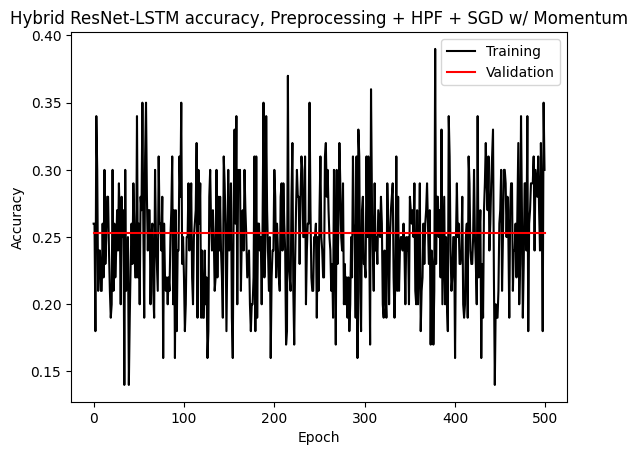

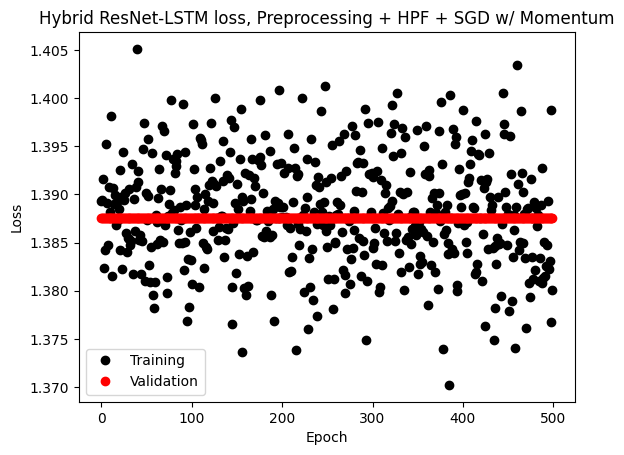

In [ ]:
#Update arrays and titles
plt.plot(np.arange(num_epochs),train_history_6,label='Training',color='k')
plt.plot(np.arange(num_epochs),val_history_6,label='Validation',color='r')
plt.title('Hybrid ResNet-LSTM accuracy, Preprocessing + HPF + SGD w/ Momentum')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(np.arange(num_epochs),train_loss_hist_6,'o',label='Training',color='k')
plt.plot(np.arange(num_epochs),val_loss_hist_6,'o',label='Validation',color='r')
plt.title('Hybrid ResNet-LSTM loss, Preprocessing + HPF + SGD w/ Momentum')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Part 6b: Adagrad + Preprocessing + HPF

In [ ]:
#Build the model
model7 = ResNetLSTM(img_channels=1, block=BasicBlock, num_classes=4, time_dim=int(x_train.size(3)), dropout=0.6).to(device)
print(model7)
total_params = sum(p.numel() for p in model7.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model7.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

ResNetLSTM(
  (conv1): Conv2d(1, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
  (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(48, 48, kernel_size=(22, 1), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ELU(alpha=1.0, inplace=True)
  (res1): BasicBlock(
    (conv1): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout2d(p=0.6, inplace=False)
    (elu): ELU(alpha=1.0, inplace=True)
    (conv2): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2): Dropout2d(p=0.6, inplace=False)
    (shortcut): Identity()
  )
  (res2): BasicBlock(
    (conv1):

In [ ]:
# Choose Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(model7.parameters(), lr=0.001, weight_decay=1e-4)
#optimizer = torch.optim.Adam(model6.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
# Rename these lines between models
train_history_7, val_history_7 = np.array([]), np.array([])
train_loss_hist_7, val_loss_hist_7 = np.array([]), np.array([])

with TemporaryDirectory() as tempdir:
    save_folder = '/content/drive/MyDrive/C147_Final_Project/best_model_params'

    # Rename these lines between models
    best_model_params_path = os.path.join(save_folder, 'best_model7_params.pt')
    torch.save(model7.state_dict(), best_model_params_path)

    best_acc = 0.0
    bsz = 100
    num_epochs = 500
    iteration = 0
    total_it = num_epochs*int(x_train.shape[0]/bsz)
    for epoch_idx in tqdm(range(num_epochs)):
        # Set model to train mode - useful for layers such as BatchNorm or Dropout whose behaviors change between train/eval
        # Rename
        model7.train()

        train_count = 0
        train_correct_count = 0
        for i in range(int(x_train.shape[0]/bsz)):
            iteration+=1
            optimizer.zero_grad() # Zero gradients, since we don't want gradients to accumulate between batches - we apply an update for each batch
            train_x, train_y = sample(x_train, y_train, bsz)
            #Rename
            logits = model7(train_x) #bszx4x1x4

            logits = nn.functional.softmax(logits, dim=1)
            loss = criterion(logits.float(), train_y.float())

            loss.backward()
            optimizer.step()
            scheduler.step()

            with torch.no_grad():
                #y_hat = torch.mean(logits, dim = 2)
                y_hat = torch.argmax(logits, dim=1)
                train_correct_count = torch.sum(y_hat == torch.argmax(train_y, dim=1))
                train_count = train_x.size(0)
                train_count = float(train_count)
            #print(f'(Iteration {iteration}/{total_it})Training Accuracy: ', (train_correct_count/train_count).item(), '. Loss: ', loss.item())


        train_acc = train_correct_count / train_count

        #Rename
        model7.eval()
        val_count = 0
        val_correct_count = 0
        with torch.no_grad():
            val_x = x_valid
            val_y = y_valid
            #Rename
            logits = model7(val_x).detach()
            logits = nn.functional.softmax(logits)
            val_loss = criterion(logits.float(), val_y.float())
            with torch.no_grad():
                y_hat = torch.argmax(logits, dim=1)
                val_correct_count = torch.sum(y_hat == torch.argmax(val_y, dim=1))
                val_count = float(val_x.size(0))
        val_acc = val_correct_count / y_valid.shape[0]

        print(f'Epoch {epoch_idx+1} Finished!!!')
        print('Train acc: {:.3f}, Val acc: {:.3f}'.format(train_acc, val_acc))
        print('Train loss: {:.3f}, Val loss: {:.3f}'.format(loss, val_loss))

        #Rename
        train_history_7 = np.append(train_history_7, train_acc.item())
        val_history_7 = np.append(val_history_7, val_acc.item())
        train_loss_hist_7 = np.append(train_loss_hist_7, loss.item())
        val_loss_hist_7 = np.append(val_loss_hist_7, val_loss.item())

        if val_acc > best_acc:
            best_acc = val_acc
            #Rename
            torch.save(model7.state_dict(), best_model_params_path)

    print(f'Best val Acc: {best_acc:4f}')

  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-81-fa21bd6725cf>:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = nn.functional.softmax(logits)
  0%|          | 1/500 [00:02<19:44,  2.37s/it]

Epoch 1 Finished!!!
Train acc: 0.380, Val acc: 0.258
Train loss: 1.371, Val loss: 1.382


  0%|          | 2/500 [00:04<20:12,  2.43s/it]

Epoch 2 Finished!!!
Train acc: 0.320, Val acc: 0.319
Train loss: 1.377, Val loss: 1.372


  1%|          | 3/500 [00:07<19:56,  2.41s/it]

Epoch 3 Finished!!!
Train acc: 0.370, Val acc: 0.350
Train loss: 1.364, Val loss: 1.365


  1%|          | 4/500 [00:09<19:44,  2.39s/it]

Epoch 4 Finished!!!
Train acc: 0.450, Val acc: 0.362
Train loss: 1.358, Val loss: 1.361


  1%|          | 5/500 [00:11<19:35,  2.37s/it]

Epoch 5 Finished!!!
Train acc: 0.360, Val acc: 0.340
Train loss: 1.349, Val loss: 1.361


  1%|          | 6/500 [00:14<19:23,  2.36s/it]

Epoch 6 Finished!!!
Train acc: 0.390, Val acc: 0.395
Train loss: 1.350, Val loss: 1.351


  1%|▏         | 7/500 [00:16<19:11,  2.34s/it]

Epoch 7 Finished!!!
Train acc: 0.460, Val acc: 0.388
Train loss: 1.323, Val loss: 1.347


  2%|▏         | 8/500 [00:18<19:06,  2.33s/it]

Epoch 8 Finished!!!
Train acc: 0.440, Val acc: 0.402
Train loss: 1.316, Val loss: 1.343


  2%|▏         | 9/500 [00:21<19:01,  2.32s/it]

Epoch 9 Finished!!!
Train acc: 0.390, Val acc: 0.414
Train loss: 1.338, Val loss: 1.338


  2%|▏         | 10/500 [00:23<18:58,  2.32s/it]

Epoch 10 Finished!!!
Train acc: 0.420, Val acc: 0.440
Train loss: 1.331, Val loss: 1.331


  2%|▏         | 11/500 [00:25<18:53,  2.32s/it]

Epoch 11 Finished!!!
Train acc: 0.430, Val acc: 0.421
Train loss: 1.321, Val loss: 1.330


  2%|▏         | 12/500 [00:28<18:50,  2.32s/it]

Epoch 12 Finished!!!
Train acc: 0.560, Val acc: 0.421
Train loss: 1.298, Val loss: 1.328


  3%|▎         | 13/500 [00:30<18:48,  2.32s/it]

Epoch 13 Finished!!!
Train acc: 0.500, Val acc: 0.428
Train loss: 1.302, Val loss: 1.325


  3%|▎         | 14/500 [00:32<18:49,  2.32s/it]

Epoch 14 Finished!!!
Train acc: 0.420, Val acc: 0.442
Train loss: 1.321, Val loss: 1.321


  3%|▎         | 15/500 [00:35<18:47,  2.32s/it]

Epoch 15 Finished!!!
Train acc: 0.420, Val acc: 0.435
Train loss: 1.319, Val loss: 1.320


  3%|▎         | 16/500 [00:37<18:45,  2.33s/it]

Epoch 16 Finished!!!
Train acc: 0.450, Val acc: 0.418
Train loss: 1.300, Val loss: 1.325


  3%|▎         | 17/500 [00:39<18:44,  2.33s/it]

Epoch 17 Finished!!!
Train acc: 0.450, Val acc: 0.421
Train loss: 1.311, Val loss: 1.320


  4%|▎         | 18/500 [00:42<19:30,  2.43s/it]

Epoch 18 Finished!!!
Train acc: 0.400, Val acc: 0.433
Train loss: 1.326, Val loss: 1.318


  4%|▍         | 19/500 [00:44<19:15,  2.40s/it]

Epoch 19 Finished!!!
Train acc: 0.470, Val acc: 0.440
Train loss: 1.291, Val loss: 1.312


  4%|▍         | 20/500 [00:47<19:05,  2.39s/it]

Epoch 20 Finished!!!
Train acc: 0.400, Val acc: 0.442
Train loss: 1.332, Val loss: 1.312


  4%|▍         | 21/500 [00:49<18:57,  2.38s/it]

Epoch 21 Finished!!!
Train acc: 0.510, Val acc: 0.426
Train loss: 1.278, Val loss: 1.312


  4%|▍         | 22/500 [00:51<18:52,  2.37s/it]

Epoch 22 Finished!!!
Train acc: 0.510, Val acc: 0.435
Train loss: 1.280, Val loss: 1.311


  5%|▍         | 23/500 [00:54<18:47,  2.36s/it]

Epoch 23 Finished!!!
Train acc: 0.520, Val acc: 0.437
Train loss: 1.282, Val loss: 1.311


  5%|▍         | 24/500 [00:56<18:44,  2.36s/it]

Epoch 24 Finished!!!
Train acc: 0.530, Val acc: 0.426
Train loss: 1.262, Val loss: 1.312


  5%|▌         | 25/500 [00:58<18:42,  2.36s/it]

Epoch 25 Finished!!!
Train acc: 0.450, Val acc: 0.433
Train loss: 1.290, Val loss: 1.306


  5%|▌         | 26/500 [01:01<18:40,  2.36s/it]

Epoch 26 Finished!!!
Train acc: 0.490, Val acc: 0.435
Train loss: 1.280, Val loss: 1.307


  5%|▌         | 27/500 [01:03<18:38,  2.36s/it]

Epoch 27 Finished!!!
Train acc: 0.510, Val acc: 0.437
Train loss: 1.264, Val loss: 1.308


  6%|▌         | 28/500 [01:05<18:35,  2.36s/it]

Epoch 28 Finished!!!
Train acc: 0.440, Val acc: 0.440
Train loss: 1.313, Val loss: 1.306


  6%|▌         | 29/500 [01:08<18:34,  2.37s/it]

Epoch 29 Finished!!!
Train acc: 0.480, Val acc: 0.433
Train loss: 1.269, Val loss: 1.307


  6%|▌         | 30/500 [01:10<18:32,  2.37s/it]

Epoch 30 Finished!!!
Train acc: 0.480, Val acc: 0.428
Train loss: 1.280, Val loss: 1.306


  6%|▌         | 31/500 [01:13<18:30,  2.37s/it]

Epoch 31 Finished!!!
Train acc: 0.400, Val acc: 0.423
Train loss: 1.311, Val loss: 1.307


  6%|▋         | 32/500 [01:15<18:27,  2.37s/it]

Epoch 32 Finished!!!
Train acc: 0.470, Val acc: 0.430
Train loss: 1.273, Val loss: 1.305


  7%|▋         | 33/500 [01:17<18:27,  2.37s/it]

Epoch 33 Finished!!!
Train acc: 0.420, Val acc: 0.444
Train loss: 1.282, Val loss: 1.304


  7%|▋         | 34/500 [01:20<18:25,  2.37s/it]

Epoch 34 Finished!!!
Train acc: 0.420, Val acc: 0.452
Train loss: 1.302, Val loss: 1.297


  7%|▋         | 35/500 [01:22<18:21,  2.37s/it]

Epoch 35 Finished!!!
Train acc: 0.420, Val acc: 0.435
Train loss: 1.273, Val loss: 1.304


  7%|▋         | 36/500 [01:24<18:19,  2.37s/it]

Epoch 36 Finished!!!
Train acc: 0.520, Val acc: 0.459
Train loss: 1.268, Val loss: 1.296


  7%|▋         | 37/500 [01:27<18:15,  2.37s/it]

Epoch 37 Finished!!!
Train acc: 0.500, Val acc: 0.447
Train loss: 1.277, Val loss: 1.296


  8%|▊         | 38/500 [01:29<18:11,  2.36s/it]

Epoch 38 Finished!!!
Train acc: 0.520, Val acc: 0.435
Train loss: 1.260, Val loss: 1.300


  8%|▊         | 39/500 [01:32<18:07,  2.36s/it]

Epoch 39 Finished!!!
Train acc: 0.540, Val acc: 0.430
Train loss: 1.243, Val loss: 1.304


  8%|▊         | 40/500 [01:34<18:04,  2.36s/it]

Epoch 40 Finished!!!
Train acc: 0.460, Val acc: 0.430
Train loss: 1.287, Val loss: 1.304


  8%|▊         | 41/500 [01:36<18:01,  2.36s/it]

Epoch 41 Finished!!!
Train acc: 0.510, Val acc: 0.437
Train loss: 1.259, Val loss: 1.302


  8%|▊         | 42/500 [01:39<17:57,  2.35s/it]

Epoch 42 Finished!!!
Train acc: 0.540, Val acc: 0.426
Train loss: 1.238, Val loss: 1.300


  9%|▊         | 43/500 [01:41<17:54,  2.35s/it]

Epoch 43 Finished!!!
Train acc: 0.460, Val acc: 0.423
Train loss: 1.280, Val loss: 1.303


  9%|▉         | 44/500 [01:43<17:51,  2.35s/it]

Epoch 44 Finished!!!
Train acc: 0.620, Val acc: 0.449
Train loss: 1.200, Val loss: 1.296


  9%|▉         | 45/500 [01:46<17:49,  2.35s/it]

Epoch 45 Finished!!!
Train acc: 0.510, Val acc: 0.423
Train loss: 1.269, Val loss: 1.301


  9%|▉         | 46/500 [01:48<17:46,  2.35s/it]

Epoch 46 Finished!!!
Train acc: 0.470, Val acc: 0.442
Train loss: 1.274, Val loss: 1.298


  9%|▉         | 47/500 [01:50<17:43,  2.35s/it]

Epoch 47 Finished!!!
Train acc: 0.540, Val acc: 0.437
Train loss: 1.245, Val loss: 1.297


 10%|▉         | 48/500 [01:53<17:41,  2.35s/it]

Epoch 48 Finished!!!
Train acc: 0.460, Val acc: 0.452
Train loss: 1.272, Val loss: 1.294


 10%|▉         | 49/500 [01:55<17:38,  2.35s/it]

Epoch 49 Finished!!!
Train acc: 0.570, Val acc: 0.444
Train loss: 1.233, Val loss: 1.299


 10%|█         | 50/500 [01:57<17:44,  2.37s/it]

Epoch 50 Finished!!!
Train acc: 0.520, Val acc: 0.449
Train loss: 1.251, Val loss: 1.293


 10%|█         | 51/500 [02:00<17:40,  2.36s/it]

Epoch 51 Finished!!!
Train acc: 0.530, Val acc: 0.459
Train loss: 1.256, Val loss: 1.292


 10%|█         | 52/500 [02:02<17:36,  2.36s/it]

Epoch 52 Finished!!!
Train acc: 0.460, Val acc: 0.444
Train loss: 1.266, Val loss: 1.294


 11%|█         | 53/500 [02:04<17:32,  2.36s/it]

Epoch 53 Finished!!!
Train acc: 0.520, Val acc: 0.428
Train loss: 1.247, Val loss: 1.298


 11%|█         | 54/500 [02:07<17:30,  2.35s/it]

Epoch 54 Finished!!!
Train acc: 0.480, Val acc: 0.454
Train loss: 1.253, Val loss: 1.296


 11%|█         | 55/500 [02:09<17:29,  2.36s/it]

Epoch 55 Finished!!!
Train acc: 0.500, Val acc: 0.466
Train loss: 1.251, Val loss: 1.291


 11%|█         | 56/500 [02:12<17:25,  2.36s/it]

Epoch 56 Finished!!!
Train acc: 0.430, Val acc: 0.430
Train loss: 1.277, Val loss: 1.297


 11%|█▏        | 57/500 [02:14<17:24,  2.36s/it]

Epoch 57 Finished!!!
Train acc: 0.710, Val acc: 0.426
Train loss: 1.190, Val loss: 1.299


 12%|█▏        | 58/500 [02:16<17:21,  2.36s/it]

Epoch 58 Finished!!!
Train acc: 0.590, Val acc: 0.421
Train loss: 1.227, Val loss: 1.298


 12%|█▏        | 59/500 [02:19<17:18,  2.36s/it]

Epoch 59 Finished!!!
Train acc: 0.500, Val acc: 0.452
Train loss: 1.272, Val loss: 1.290


 12%|█▏        | 60/500 [02:21<17:23,  2.37s/it]

Epoch 60 Finished!!!
Train acc: 0.440, Val acc: 0.454
Train loss: 1.297, Val loss: 1.290


 12%|█▏        | 61/500 [02:24<19:42,  2.69s/it]

Epoch 61 Finished!!!
Train acc: 0.540, Val acc: 0.430
Train loss: 1.229, Val loss: 1.297


 12%|█▏        | 62/500 [02:28<21:11,  2.90s/it]

Epoch 62 Finished!!!
Train acc: 0.520, Val acc: 0.447
Train loss: 1.261, Val loss: 1.295


 13%|█▎        | 63/500 [02:30<20:35,  2.83s/it]

Epoch 63 Finished!!!
Train acc: 0.490, Val acc: 0.442
Train loss: 1.276, Val loss: 1.295


 13%|█▎        | 64/500 [02:33<19:53,  2.74s/it]

Epoch 64 Finished!!!
Train acc: 0.460, Val acc: 0.452
Train loss: 1.276, Val loss: 1.293


 13%|█▎        | 65/500 [02:36<19:23,  2.68s/it]

Epoch 65 Finished!!!
Train acc: 0.510, Val acc: 0.442
Train loss: 1.260, Val loss: 1.294


 13%|█▎        | 66/500 [02:38<18:50,  2.61s/it]

Epoch 66 Finished!!!
Train acc: 0.530, Val acc: 0.442
Train loss: 1.231, Val loss: 1.287


 13%|█▎        | 67/500 [02:41<18:40,  2.59s/it]

Epoch 67 Finished!!!
Train acc: 0.440, Val acc: 0.449
Train loss: 1.289, Val loss: 1.288


 14%|█▎        | 68/500 [02:43<18:09,  2.52s/it]

Epoch 68 Finished!!!
Train acc: 0.550, Val acc: 0.456
Train loss: 1.239, Val loss: 1.286


 14%|█▍        | 69/500 [02:45<17:46,  2.47s/it]

Epoch 69 Finished!!!
Train acc: 0.600, Val acc: 0.435
Train loss: 1.202, Val loss: 1.293


 14%|█▍        | 70/500 [02:48<17:28,  2.44s/it]

Epoch 70 Finished!!!
Train acc: 0.560, Val acc: 0.454
Train loss: 1.237, Val loss: 1.289


 14%|█▍        | 71/500 [02:50<17:16,  2.42s/it]

Epoch 71 Finished!!!
Train acc: 0.540, Val acc: 0.449
Train loss: 1.232, Val loss: 1.291


 14%|█▍        | 72/500 [02:53<17:36,  2.47s/it]

Epoch 72 Finished!!!
Train acc: 0.610, Val acc: 0.449
Train loss: 1.192, Val loss: 1.288


 15%|█▍        | 73/500 [02:55<17:33,  2.47s/it]

Epoch 73 Finished!!!
Train acc: 0.570, Val acc: 0.447
Train loss: 1.221, Val loss: 1.291


 15%|█▍        | 74/500 [02:57<17:18,  2.44s/it]

Epoch 74 Finished!!!
Train acc: 0.520, Val acc: 0.447
Train loss: 1.224, Val loss: 1.291


 15%|█▌        | 75/500 [03:00<17:07,  2.42s/it]

Epoch 75 Finished!!!
Train acc: 0.490, Val acc: 0.440
Train loss: 1.241, Val loss: 1.292


 15%|█▌        | 76/500 [03:02<16:58,  2.40s/it]

Epoch 76 Finished!!!
Train acc: 0.540, Val acc: 0.430
Train loss: 1.221, Val loss: 1.294


 15%|█▌        | 77/500 [03:05<16:56,  2.40s/it]

Epoch 77 Finished!!!
Train acc: 0.540, Val acc: 0.454
Train loss: 1.230, Val loss: 1.287


 16%|█▌        | 78/500 [03:07<17:02,  2.42s/it]

Epoch 78 Finished!!!
Train acc: 0.590, Val acc: 0.452
Train loss: 1.202, Val loss: 1.290


 16%|█▌        | 79/500 [03:09<16:51,  2.40s/it]

Epoch 79 Finished!!!
Train acc: 0.450, Val acc: 0.442
Train loss: 1.281, Val loss: 1.291


 16%|█▌        | 80/500 [03:12<16:42,  2.39s/it]

Epoch 80 Finished!!!
Train acc: 0.540, Val acc: 0.447
Train loss: 1.220, Val loss: 1.291


 16%|█▌        | 81/500 [03:14<16:36,  2.38s/it]

Epoch 81 Finished!!!
Train acc: 0.580, Val acc: 0.447
Train loss: 1.205, Val loss: 1.290


 16%|█▋        | 82/500 [03:16<16:30,  2.37s/it]

Epoch 82 Finished!!!
Train acc: 0.560, Val acc: 0.447
Train loss: 1.222, Val loss: 1.290


 17%|█▋        | 83/500 [03:19<16:26,  2.36s/it]

Epoch 83 Finished!!!
Train acc: 0.550, Val acc: 0.463
Train loss: 1.236, Val loss: 1.285


 17%|█▋        | 84/500 [03:21<16:32,  2.39s/it]

Epoch 84 Finished!!!
Train acc: 0.590, Val acc: 0.449
Train loss: 1.215, Val loss: 1.288


 17%|█▋        | 85/500 [03:24<16:29,  2.38s/it]

Epoch 85 Finished!!!
Train acc: 0.610, Val acc: 0.454
Train loss: 1.242, Val loss: 1.288


 17%|█▋        | 86/500 [03:26<16:33,  2.40s/it]

Epoch 86 Finished!!!
Train acc: 0.580, Val acc: 0.449
Train loss: 1.217, Val loss: 1.288


 17%|█▋        | 87/500 [03:28<16:26,  2.39s/it]

Epoch 87 Finished!!!
Train acc: 0.550, Val acc: 0.456
Train loss: 1.213, Val loss: 1.286


 18%|█▊        | 88/500 [03:31<16:20,  2.38s/it]

Epoch 88 Finished!!!
Train acc: 0.560, Val acc: 0.454
Train loss: 1.235, Val loss: 1.281


 18%|█▊        | 89/500 [03:33<16:15,  2.37s/it]

Epoch 89 Finished!!!
Train acc: 0.460, Val acc: 0.447
Train loss: 1.259, Val loss: 1.284


 18%|█▊        | 90/500 [03:35<16:10,  2.37s/it]

Epoch 90 Finished!!!
Train acc: 0.530, Val acc: 0.442
Train loss: 1.243, Val loss: 1.288


 18%|█▊        | 91/500 [03:38<16:06,  2.36s/it]

Epoch 91 Finished!!!
Train acc: 0.510, Val acc: 0.444
Train loss: 1.258, Val loss: 1.286


 18%|█▊        | 92/500 [03:40<16:02,  2.36s/it]

Epoch 92 Finished!!!
Train acc: 0.500, Val acc: 0.442
Train loss: 1.241, Val loss: 1.288


 19%|█▊        | 93/500 [03:43<15:59,  2.36s/it]

Epoch 93 Finished!!!
Train acc: 0.580, Val acc: 0.447
Train loss: 1.206, Val loss: 1.282


 19%|█▉        | 94/500 [03:45<15:56,  2.36s/it]

Epoch 94 Finished!!!
Train acc: 0.560, Val acc: 0.452
Train loss: 1.245, Val loss: 1.283


 19%|█▉        | 95/500 [03:47<15:54,  2.36s/it]

Epoch 95 Finished!!!
Train acc: 0.500, Val acc: 0.452
Train loss: 1.207, Val loss: 1.284


 19%|█▉        | 96/500 [03:50<15:51,  2.35s/it]

Epoch 96 Finished!!!
Train acc: 0.550, Val acc: 0.435
Train loss: 1.233, Val loss: 1.287


 19%|█▉        | 97/500 [03:52<15:48,  2.35s/it]

Epoch 97 Finished!!!
Train acc: 0.500, Val acc: 0.444
Train loss: 1.261, Val loss: 1.284


 20%|█▉        | 98/500 [03:54<15:45,  2.35s/it]

Epoch 98 Finished!!!
Train acc: 0.560, Val acc: 0.428
Train loss: 1.221, Val loss: 1.287


 20%|█▉        | 99/500 [03:57<15:43,  2.35s/it]

Epoch 99 Finished!!!
Train acc: 0.510, Val acc: 0.449
Train loss: 1.244, Val loss: 1.279


 20%|██        | 100/500 [03:59<15:41,  2.35s/it]

Epoch 100 Finished!!!
Train acc: 0.600, Val acc: 0.447
Train loss: 1.203, Val loss: 1.282


 20%|██        | 101/500 [04:01<15:39,  2.35s/it]

Epoch 101 Finished!!!
Train acc: 0.560, Val acc: 0.454
Train loss: 1.233, Val loss: 1.280


 20%|██        | 102/500 [04:04<15:36,  2.35s/it]

Epoch 102 Finished!!!
Train acc: 0.620, Val acc: 0.456
Train loss: 1.196, Val loss: 1.283


 21%|██        | 103/500 [04:06<15:34,  2.35s/it]

Epoch 103 Finished!!!
Train acc: 0.490, Val acc: 0.449
Train loss: 1.235, Val loss: 1.282


 21%|██        | 104/500 [04:08<15:31,  2.35s/it]

Epoch 104 Finished!!!
Train acc: 0.540, Val acc: 0.449
Train loss: 1.237, Val loss: 1.282


 21%|██        | 105/500 [04:11<15:29,  2.35s/it]

Epoch 105 Finished!!!
Train acc: 0.530, Val acc: 0.447
Train loss: 1.245, Val loss: 1.280


 21%|██        | 106/500 [04:13<15:26,  2.35s/it]

Epoch 106 Finished!!!
Train acc: 0.460, Val acc: 0.442
Train loss: 1.254, Val loss: 1.281


 21%|██▏       | 107/500 [04:15<15:23,  2.35s/it]

Epoch 107 Finished!!!
Train acc: 0.500, Val acc: 0.444
Train loss: 1.251, Val loss: 1.279


 22%|██▏       | 108/500 [04:18<15:21,  2.35s/it]

Epoch 108 Finished!!!
Train acc: 0.560, Val acc: 0.449
Train loss: 1.210, Val loss: 1.284


 22%|██▏       | 109/500 [04:20<15:23,  2.36s/it]

Epoch 109 Finished!!!
Train acc: 0.550, Val acc: 0.435
Train loss: 1.231, Val loss: 1.286


 22%|██▏       | 110/500 [04:23<15:25,  2.37s/it]

Epoch 110 Finished!!!
Train acc: 0.550, Val acc: 0.444
Train loss: 1.218, Val loss: 1.281


 22%|██▏       | 111/500 [04:25<15:20,  2.37s/it]

Epoch 111 Finished!!!
Train acc: 0.500, Val acc: 0.435
Train loss: 1.225, Val loss: 1.285


 22%|██▏       | 112/500 [04:27<15:16,  2.36s/it]

Epoch 112 Finished!!!
Train acc: 0.430, Val acc: 0.447
Train loss: 1.272, Val loss: 1.284


 23%|██▎       | 113/500 [04:30<15:12,  2.36s/it]

Epoch 113 Finished!!!
Train acc: 0.610, Val acc: 0.444
Train loss: 1.182, Val loss: 1.280


 23%|██▎       | 114/500 [04:32<15:09,  2.36s/it]

Epoch 114 Finished!!!
Train acc: 0.510, Val acc: 0.447
Train loss: 1.222, Val loss: 1.281


 23%|██▎       | 115/500 [04:34<15:06,  2.35s/it]

Epoch 115 Finished!!!
Train acc: 0.530, Val acc: 0.440
Train loss: 1.215, Val loss: 1.285


 23%|██▎       | 116/500 [04:37<15:04,  2.35s/it]

Epoch 116 Finished!!!
Train acc: 0.530, Val acc: 0.444
Train loss: 1.223, Val loss: 1.276


 23%|██▎       | 117/500 [04:39<15:01,  2.35s/it]

Epoch 117 Finished!!!
Train acc: 0.580, Val acc: 0.452
Train loss: 1.168, Val loss: 1.276


 24%|██▎       | 118/500 [04:41<14:58,  2.35s/it]

Epoch 118 Finished!!!
Train acc: 0.450, Val acc: 0.452
Train loss: 1.269, Val loss: 1.280


 24%|██▍       | 119/500 [04:44<14:55,  2.35s/it]

Epoch 119 Finished!!!
Train acc: 0.570, Val acc: 0.435
Train loss: 1.211, Val loss: 1.285


 24%|██▍       | 120/500 [04:46<14:53,  2.35s/it]

Epoch 120 Finished!!!
Train acc: 0.500, Val acc: 0.456
Train loss: 1.222, Val loss: 1.278


 24%|██▍       | 121/500 [04:48<14:51,  2.35s/it]

Epoch 121 Finished!!!
Train acc: 0.510, Val acc: 0.423
Train loss: 1.260, Val loss: 1.287


 24%|██▍       | 122/500 [04:51<14:50,  2.36s/it]

Epoch 122 Finished!!!
Train acc: 0.520, Val acc: 0.437
Train loss: 1.235, Val loss: 1.284


 25%|██▍       | 123/500 [04:53<14:47,  2.35s/it]

Epoch 123 Finished!!!
Train acc: 0.610, Val acc: 0.433
Train loss: 1.205, Val loss: 1.283


 25%|██▍       | 124/500 [04:56<14:44,  2.35s/it]

Epoch 124 Finished!!!
Train acc: 0.550, Val acc: 0.449
Train loss: 1.222, Val loss: 1.278


 25%|██▌       | 125/500 [04:58<14:41,  2.35s/it]

Epoch 125 Finished!!!
Train acc: 0.510, Val acc: 0.447
Train loss: 1.247, Val loss: 1.277


 25%|██▌       | 126/500 [05:00<14:39,  2.35s/it]

Epoch 126 Finished!!!
Train acc: 0.540, Val acc: 0.454
Train loss: 1.227, Val loss: 1.276


 25%|██▌       | 127/500 [05:03<14:37,  2.35s/it]

Epoch 127 Finished!!!
Train acc: 0.570, Val acc: 0.449
Train loss: 1.196, Val loss: 1.274


 26%|██▌       | 128/500 [05:05<14:34,  2.35s/it]

Epoch 128 Finished!!!
Train acc: 0.500, Val acc: 0.459
Train loss: 1.230, Val loss: 1.274


 26%|██▌       | 129/500 [05:07<14:32,  2.35s/it]

Epoch 129 Finished!!!
Train acc: 0.580, Val acc: 0.442
Train loss: 1.174, Val loss: 1.275


 26%|██▌       | 130/500 [05:10<14:30,  2.35s/it]

Epoch 130 Finished!!!
Train acc: 0.590, Val acc: 0.454
Train loss: 1.181, Val loss: 1.275


 26%|██▌       | 131/500 [05:12<14:27,  2.35s/it]

Epoch 131 Finished!!!
Train acc: 0.580, Val acc: 0.454
Train loss: 1.237, Val loss: 1.275


 26%|██▋       | 132/500 [05:14<14:25,  2.35s/it]

Epoch 132 Finished!!!
Train acc: 0.470, Val acc: 0.456
Train loss: 1.254, Val loss: 1.276


 27%|██▋       | 133/500 [05:17<14:24,  2.36s/it]

Epoch 133 Finished!!!
Train acc: 0.550, Val acc: 0.442
Train loss: 1.217, Val loss: 1.274


 27%|██▋       | 134/500 [05:19<14:21,  2.35s/it]

Epoch 134 Finished!!!
Train acc: 0.660, Val acc: 0.447
Train loss: 1.173, Val loss: 1.278


 27%|██▋       | 135/500 [05:21<14:19,  2.35s/it]

Epoch 135 Finished!!!
Train acc: 0.500, Val acc: 0.440
Train loss: 1.229, Val loss: 1.274


 27%|██▋       | 136/500 [05:24<14:16,  2.35s/it]

Epoch 136 Finished!!!
Train acc: 0.500, Val acc: 0.447
Train loss: 1.235, Val loss: 1.278


 27%|██▋       | 137/500 [05:26<14:14,  2.35s/it]

Epoch 137 Finished!!!
Train acc: 0.640, Val acc: 0.447
Train loss: 1.181, Val loss: 1.278


 28%|██▊       | 138/500 [05:28<14:11,  2.35s/it]

Epoch 138 Finished!!!
Train acc: 0.590, Val acc: 0.452
Train loss: 1.191, Val loss: 1.274


 28%|██▊       | 139/500 [05:31<14:10,  2.35s/it]

Epoch 139 Finished!!!
Train acc: 0.530, Val acc: 0.452
Train loss: 1.228, Val loss: 1.277


 28%|██▊       | 140/500 [05:33<14:07,  2.35s/it]

Epoch 140 Finished!!!
Train acc: 0.520, Val acc: 0.444
Train loss: 1.215, Val loss: 1.280


 28%|██▊       | 141/500 [05:36<14:04,  2.35s/it]

Epoch 141 Finished!!!
Train acc: 0.560, Val acc: 0.444
Train loss: 1.223, Val loss: 1.277


 28%|██▊       | 142/500 [05:38<14:02,  2.35s/it]

Epoch 142 Finished!!!
Train acc: 0.580, Val acc: 0.433
Train loss: 1.181, Val loss: 1.284


 29%|██▊       | 143/500 [05:40<13:59,  2.35s/it]

Epoch 143 Finished!!!
Train acc: 0.540, Val acc: 0.449
Train loss: 1.176, Val loss: 1.276


 29%|██▉       | 144/500 [05:43<13:58,  2.36s/it]

Epoch 144 Finished!!!
Train acc: 0.580, Val acc: 0.442
Train loss: 1.221, Val loss: 1.274


 29%|██▉       | 145/500 [05:45<13:55,  2.35s/it]

Epoch 145 Finished!!!
Train acc: 0.470, Val acc: 0.440
Train loss: 1.238, Val loss: 1.279


 29%|██▉       | 146/500 [05:47<13:52,  2.35s/it]

Epoch 146 Finished!!!
Train acc: 0.570, Val acc: 0.456
Train loss: 1.174, Val loss: 1.273


 29%|██▉       | 147/500 [05:50<13:50,  2.35s/it]

Epoch 147 Finished!!!
Train acc: 0.490, Val acc: 0.456
Train loss: 1.228, Val loss: 1.274


 30%|██▉       | 148/500 [05:52<13:48,  2.35s/it]

Epoch 148 Finished!!!
Train acc: 0.580, Val acc: 0.449
Train loss: 1.202, Val loss: 1.274


 30%|██▉       | 149/500 [05:54<13:46,  2.35s/it]

Epoch 149 Finished!!!
Train acc: 0.590, Val acc: 0.454
Train loss: 1.208, Val loss: 1.271


 30%|███       | 150/500 [05:57<13:44,  2.35s/it]

Epoch 150 Finished!!!
Train acc: 0.590, Val acc: 0.449
Train loss: 1.193, Val loss: 1.274


 30%|███       | 151/500 [05:59<13:41,  2.35s/it]

Epoch 151 Finished!!!
Train acc: 0.610, Val acc: 0.442
Train loss: 1.147, Val loss: 1.282


 30%|███       | 152/500 [06:01<13:39,  2.35s/it]

Epoch 152 Finished!!!
Train acc: 0.530, Val acc: 0.440
Train loss: 1.216, Val loss: 1.276


 31%|███       | 153/500 [06:04<13:36,  2.35s/it]

Epoch 153 Finished!!!
Train acc: 0.590, Val acc: 0.447
Train loss: 1.191, Val loss: 1.279


 31%|███       | 154/500 [06:06<13:34,  2.35s/it]

Epoch 154 Finished!!!
Train acc: 0.580, Val acc: 0.444
Train loss: 1.188, Val loss: 1.272


 31%|███       | 155/500 [06:08<13:32,  2.36s/it]

Epoch 155 Finished!!!
Train acc: 0.590, Val acc: 0.456
Train loss: 1.169, Val loss: 1.272


 31%|███       | 156/500 [06:11<13:30,  2.35s/it]

Epoch 156 Finished!!!
Train acc: 0.610, Val acc: 0.447
Train loss: 1.161, Val loss: 1.274


 31%|███▏      | 157/500 [06:13<13:27,  2.35s/it]

Epoch 157 Finished!!!
Train acc: 0.530, Val acc: 0.433
Train loss: 1.227, Val loss: 1.281


 32%|███▏      | 158/500 [06:16<13:24,  2.35s/it]

Epoch 158 Finished!!!
Train acc: 0.520, Val acc: 0.454
Train loss: 1.211, Val loss: 1.273


 32%|███▏      | 159/500 [06:18<13:22,  2.35s/it]

Epoch 159 Finished!!!
Train acc: 0.530, Val acc: 0.452
Train loss: 1.204, Val loss: 1.274


 32%|███▏      | 160/500 [06:20<13:20,  2.35s/it]

Epoch 160 Finished!!!
Train acc: 0.470, Val acc: 0.449
Train loss: 1.219, Val loss: 1.270


 32%|███▏      | 161/500 [06:23<13:18,  2.36s/it]

Epoch 161 Finished!!!
Train acc: 0.610, Val acc: 0.452
Train loss: 1.178, Val loss: 1.273


 32%|███▏      | 162/500 [06:25<13:15,  2.35s/it]

Epoch 162 Finished!!!
Train acc: 0.560, Val acc: 0.444
Train loss: 1.183, Val loss: 1.276


 33%|███▎      | 163/500 [06:27<13:13,  2.35s/it]

Epoch 163 Finished!!!
Train acc: 0.580, Val acc: 0.454
Train loss: 1.209, Val loss: 1.274


 33%|███▎      | 164/500 [06:30<13:10,  2.35s/it]

Epoch 164 Finished!!!
Train acc: 0.590, Val acc: 0.454
Train loss: 1.214, Val loss: 1.270


 33%|███▎      | 165/500 [06:32<13:08,  2.35s/it]

Epoch 165 Finished!!!
Train acc: 0.600, Val acc: 0.454
Train loss: 1.180, Val loss: 1.269


 33%|███▎      | 166/500 [06:34<13:06,  2.36s/it]

Epoch 166 Finished!!!
Train acc: 0.500, Val acc: 0.444
Train loss: 1.223, Val loss: 1.273


 33%|███▎      | 167/500 [06:37<13:03,  2.35s/it]

Epoch 167 Finished!!!
Train acc: 0.520, Val acc: 0.456
Train loss: 1.248, Val loss: 1.273


 34%|███▎      | 168/500 [06:39<13:01,  2.35s/it]

Epoch 168 Finished!!!
Train acc: 0.640, Val acc: 0.444
Train loss: 1.164, Val loss: 1.275


 34%|███▍      | 169/500 [06:41<12:58,  2.35s/it]

Epoch 169 Finished!!!
Train acc: 0.510, Val acc: 0.454
Train loss: 1.215, Val loss: 1.270


 34%|███▍      | 170/500 [06:44<12:56,  2.35s/it]

Epoch 170 Finished!!!
Train acc: 0.560, Val acc: 0.452
Train loss: 1.183, Val loss: 1.275


 34%|███▍      | 171/500 [06:46<12:54,  2.35s/it]

Epoch 171 Finished!!!
Train acc: 0.560, Val acc: 0.449
Train loss: 1.188, Val loss: 1.270


 34%|███▍      | 172/500 [06:48<12:52,  2.35s/it]

Epoch 172 Finished!!!
Train acc: 0.620, Val acc: 0.452
Train loss: 1.164, Val loss: 1.271


 35%|███▍      | 173/500 [06:51<12:49,  2.35s/it]

Epoch 173 Finished!!!
Train acc: 0.590, Val acc: 0.442
Train loss: 1.189, Val loss: 1.274


 35%|███▍      | 174/500 [06:53<12:46,  2.35s/it]

Epoch 174 Finished!!!
Train acc: 0.540, Val acc: 0.447
Train loss: 1.194, Val loss: 1.275


 35%|███▌      | 175/500 [06:56<12:44,  2.35s/it]

Epoch 175 Finished!!!
Train acc: 0.550, Val acc: 0.449
Train loss: 1.211, Val loss: 1.273


 35%|███▌      | 176/500 [06:58<12:41,  2.35s/it]

Epoch 176 Finished!!!
Train acc: 0.550, Val acc: 0.459
Train loss: 1.213, Val loss: 1.268


 35%|███▌      | 177/500 [07:00<12:40,  2.35s/it]

Epoch 177 Finished!!!
Train acc: 0.580, Val acc: 0.447
Train loss: 1.197, Val loss: 1.275


 36%|███▌      | 178/500 [07:03<12:37,  2.35s/it]

Epoch 178 Finished!!!
Train acc: 0.510, Val acc: 0.449
Train loss: 1.221, Val loss: 1.276


 36%|███▌      | 179/500 [07:05<12:34,  2.35s/it]

Epoch 179 Finished!!!
Train acc: 0.650, Val acc: 0.444
Train loss: 1.189, Val loss: 1.270


 36%|███▌      | 180/500 [07:07<12:32,  2.35s/it]

Epoch 180 Finished!!!
Train acc: 0.600, Val acc: 0.454
Train loss: 1.163, Val loss: 1.273


 36%|███▌      | 181/500 [07:10<12:30,  2.35s/it]

Epoch 181 Finished!!!
Train acc: 0.550, Val acc: 0.452
Train loss: 1.205, Val loss: 1.273


 36%|███▋      | 182/500 [07:12<12:28,  2.35s/it]

Epoch 182 Finished!!!
Train acc: 0.550, Val acc: 0.442
Train loss: 1.217, Val loss: 1.273


 37%|███▋      | 183/500 [07:14<12:25,  2.35s/it]

Epoch 183 Finished!!!
Train acc: 0.610, Val acc: 0.442
Train loss: 1.185, Val loss: 1.269


 37%|███▋      | 184/500 [07:17<12:23,  2.35s/it]

Epoch 184 Finished!!!
Train acc: 0.500, Val acc: 0.442
Train loss: 1.229, Val loss: 1.269


 37%|███▋      | 185/500 [07:19<12:20,  2.35s/it]

Epoch 185 Finished!!!
Train acc: 0.560, Val acc: 0.440
Train loss: 1.210, Val loss: 1.270


 37%|███▋      | 186/500 [07:21<12:18,  2.35s/it]

Epoch 186 Finished!!!
Train acc: 0.610, Val acc: 0.447
Train loss: 1.187, Val loss: 1.275


 37%|███▋      | 187/500 [07:24<12:16,  2.35s/it]

Epoch 187 Finished!!!
Train acc: 0.530, Val acc: 0.459
Train loss: 1.215, Val loss: 1.274


 38%|███▊      | 188/500 [07:26<12:14,  2.35s/it]

Epoch 188 Finished!!!
Train acc: 0.530, Val acc: 0.447
Train loss: 1.216, Val loss: 1.272


 38%|███▊      | 189/500 [07:28<12:11,  2.35s/it]

Epoch 189 Finished!!!
Train acc: 0.570, Val acc: 0.449
Train loss: 1.216, Val loss: 1.272


 38%|███▊      | 190/500 [07:31<12:09,  2.35s/it]

Epoch 190 Finished!!!
Train acc: 0.560, Val acc: 0.447
Train loss: 1.190, Val loss: 1.277


 38%|███▊      | 191/500 [07:33<12:07,  2.35s/it]

Epoch 191 Finished!!!
Train acc: 0.580, Val acc: 0.447
Train loss: 1.186, Val loss: 1.272


 38%|███▊      | 192/500 [07:36<12:04,  2.35s/it]

Epoch 192 Finished!!!
Train acc: 0.630, Val acc: 0.440
Train loss: 1.168, Val loss: 1.284


 39%|███▊      | 193/500 [07:38<12:02,  2.35s/it]

Epoch 193 Finished!!!
Train acc: 0.420, Val acc: 0.444
Train loss: 1.266, Val loss: 1.272


 39%|███▉      | 194/500 [07:40<12:00,  2.35s/it]

Epoch 194 Finished!!!
Train acc: 0.560, Val acc: 0.437
Train loss: 1.178, Val loss: 1.270


 39%|███▉      | 195/500 [07:43<11:57,  2.35s/it]

Epoch 195 Finished!!!
Train acc: 0.570, Val acc: 0.440
Train loss: 1.172, Val loss: 1.274


 39%|███▉      | 196/500 [07:45<11:55,  2.35s/it]

Epoch 196 Finished!!!
Train acc: 0.550, Val acc: 0.449
Train loss: 1.199, Val loss: 1.275


 39%|███▉      | 197/500 [07:47<11:52,  2.35s/it]

Epoch 197 Finished!!!
Train acc: 0.560, Val acc: 0.459
Train loss: 1.180, Val loss: 1.267


 40%|███▉      | 198/500 [07:50<11:51,  2.35s/it]

Epoch 198 Finished!!!
Train acc: 0.480, Val acc: 0.447
Train loss: 1.253, Val loss: 1.270


 40%|███▉      | 199/500 [07:52<11:48,  2.35s/it]

Epoch 199 Finished!!!
Train acc: 0.620, Val acc: 0.452
Train loss: 1.180, Val loss: 1.269


 40%|████      | 200/500 [07:54<11:46,  2.35s/it]

Epoch 200 Finished!!!
Train acc: 0.580, Val acc: 0.459
Train loss: 1.210, Val loss: 1.267


 40%|████      | 201/500 [07:57<11:43,  2.35s/it]

Epoch 201 Finished!!!
Train acc: 0.580, Val acc: 0.442
Train loss: 1.183, Val loss: 1.269


 40%|████      | 202/500 [07:59<11:40,  2.35s/it]

Epoch 202 Finished!!!
Train acc: 0.580, Val acc: 0.456
Train loss: 1.165, Val loss: 1.270


 41%|████      | 203/500 [08:01<11:39,  2.35s/it]

Epoch 203 Finished!!!
Train acc: 0.570, Val acc: 0.447
Train loss: 1.199, Val loss: 1.274


 41%|████      | 204/500 [08:04<11:37,  2.36s/it]

Epoch 204 Finished!!!
Train acc: 0.590, Val acc: 0.454
Train loss: 1.206, Val loss: 1.268


 41%|████      | 205/500 [08:06<11:34,  2.35s/it]

Epoch 205 Finished!!!
Train acc: 0.610, Val acc: 0.437
Train loss: 1.167, Val loss: 1.270


 41%|████      | 206/500 [08:08<11:32,  2.35s/it]

Epoch 206 Finished!!!
Train acc: 0.600, Val acc: 0.454
Train loss: 1.173, Val loss: 1.269


 41%|████▏     | 207/500 [08:11<11:29,  2.35s/it]

Epoch 207 Finished!!!
Train acc: 0.600, Val acc: 0.444
Train loss: 1.202, Val loss: 1.271


 42%|████▏     | 208/500 [08:13<11:27,  2.36s/it]

Epoch 208 Finished!!!
Train acc: 0.560, Val acc: 0.442
Train loss: 1.219, Val loss: 1.269


 42%|████▏     | 209/500 [08:16<11:25,  2.36s/it]

Epoch 209 Finished!!!
Train acc: 0.500, Val acc: 0.452
Train loss: 1.212, Val loss: 1.267


 42%|████▏     | 210/500 [08:18<11:22,  2.35s/it]

Epoch 210 Finished!!!
Train acc: 0.500, Val acc: 0.440
Train loss: 1.212, Val loss: 1.269


 42%|████▏     | 211/500 [08:20<11:20,  2.35s/it]

Epoch 211 Finished!!!
Train acc: 0.580, Val acc: 0.449
Train loss: 1.185, Val loss: 1.269


 42%|████▏     | 212/500 [08:23<11:17,  2.35s/it]

Epoch 212 Finished!!!
Train acc: 0.630, Val acc: 0.449
Train loss: 1.145, Val loss: 1.271


 43%|████▎     | 213/500 [08:25<11:15,  2.35s/it]

Epoch 213 Finished!!!
Train acc: 0.610, Val acc: 0.440
Train loss: 1.182, Val loss: 1.270


 43%|████▎     | 214/500 [08:28<11:29,  2.41s/it]

Epoch 214 Finished!!!
Train acc: 0.520, Val acc: 0.454
Train loss: 1.207, Val loss: 1.274


 43%|████▎     | 215/500 [08:30<11:31,  2.43s/it]

Epoch 215 Finished!!!
Train acc: 0.610, Val acc: 0.459
Train loss: 1.183, Val loss: 1.266


 43%|████▎     | 216/500 [08:32<11:24,  2.41s/it]

Epoch 216 Finished!!!
Train acc: 0.600, Val acc: 0.440
Train loss: 1.167, Val loss: 1.271


 43%|████▎     | 217/500 [08:35<11:25,  2.42s/it]

Epoch 217 Finished!!!
Train acc: 0.440, Val acc: 0.444
Train loss: 1.235, Val loss: 1.273


 44%|████▎     | 218/500 [08:37<11:24,  2.43s/it]

Epoch 218 Finished!!!
Train acc: 0.550, Val acc: 0.449
Train loss: 1.175, Val loss: 1.274


 44%|████▍     | 219/500 [08:40<11:18,  2.41s/it]

Epoch 219 Finished!!!
Train acc: 0.650, Val acc: 0.449
Train loss: 1.143, Val loss: 1.269


 44%|████▍     | 220/500 [08:42<11:25,  2.45s/it]

Epoch 220 Finished!!!
Train acc: 0.560, Val acc: 0.452
Train loss: 1.183, Val loss: 1.272


 44%|████▍     | 221/500 [08:45<11:19,  2.44s/it]

Epoch 221 Finished!!!
Train acc: 0.530, Val acc: 0.444
Train loss: 1.188, Val loss: 1.267


 44%|████▍     | 222/500 [08:47<11:23,  2.46s/it]

Epoch 222 Finished!!!
Train acc: 0.600, Val acc: 0.456
Train loss: 1.165, Val loss: 1.271


 45%|████▍     | 223/500 [08:49<11:11,  2.43s/it]

Epoch 223 Finished!!!
Train acc: 0.570, Val acc: 0.452
Train loss: 1.181, Val loss: 1.273


 45%|████▍     | 224/500 [08:52<11:03,  2.40s/it]

Epoch 224 Finished!!!
Train acc: 0.590, Val acc: 0.452
Train loss: 1.184, Val loss: 1.275


 45%|████▌     | 225/500 [08:54<10:56,  2.39s/it]

Epoch 225 Finished!!!
Train acc: 0.580, Val acc: 0.449
Train loss: 1.194, Val loss: 1.268


 45%|████▌     | 226/500 [08:56<10:52,  2.38s/it]

Epoch 226 Finished!!!
Train acc: 0.590, Val acc: 0.447
Train loss: 1.176, Val loss: 1.265


 45%|████▌     | 227/500 [08:59<10:47,  2.37s/it]

Epoch 227 Finished!!!
Train acc: 0.600, Val acc: 0.452
Train loss: 1.189, Val loss: 1.264


 46%|████▌     | 228/500 [09:01<10:43,  2.37s/it]

Epoch 228 Finished!!!
Train acc: 0.520, Val acc: 0.433
Train loss: 1.207, Val loss: 1.270


 46%|████▌     | 229/500 [09:04<10:40,  2.36s/it]

Epoch 229 Finished!!!
Train acc: 0.490, Val acc: 0.440
Train loss: 1.215, Val loss: 1.270


 46%|████▌     | 230/500 [09:06<10:36,  2.36s/it]

Epoch 230 Finished!!!
Train acc: 0.550, Val acc: 0.454
Train loss: 1.185, Val loss: 1.271


 46%|████▌     | 231/500 [09:08<10:34,  2.36s/it]

Epoch 231 Finished!!!
Train acc: 0.610, Val acc: 0.447
Train loss: 1.177, Val loss: 1.268


 46%|████▋     | 232/500 [09:11<10:32,  2.36s/it]

Epoch 232 Finished!!!
Train acc: 0.570, Val acc: 0.452
Train loss: 1.201, Val loss: 1.266


 47%|████▋     | 233/500 [09:13<10:29,  2.36s/it]

Epoch 233 Finished!!!
Train acc: 0.610, Val acc: 0.454
Train loss: 1.173, Val loss: 1.272


 47%|████▋     | 234/500 [09:15<10:26,  2.35s/it]

Epoch 234 Finished!!!
Train acc: 0.570, Val acc: 0.447
Train loss: 1.191, Val loss: 1.270


 47%|████▋     | 235/500 [09:18<10:23,  2.35s/it]

Epoch 235 Finished!!!
Train acc: 0.600, Val acc: 0.435
Train loss: 1.165, Val loss: 1.267


 47%|████▋     | 236/500 [09:20<10:21,  2.35s/it]

Epoch 236 Finished!!!
Train acc: 0.590, Val acc: 0.435
Train loss: 1.172, Val loss: 1.269


 47%|████▋     | 237/500 [09:22<10:19,  2.36s/it]

Epoch 237 Finished!!!
Train acc: 0.600, Val acc: 0.447
Train loss: 1.179, Val loss: 1.270


 48%|████▊     | 238/500 [09:25<10:16,  2.35s/it]

Epoch 238 Finished!!!
Train acc: 0.630, Val acc: 0.452
Train loss: 1.133, Val loss: 1.262


 48%|████▊     | 239/500 [09:27<10:16,  2.36s/it]

Epoch 239 Finished!!!
Train acc: 0.650, Val acc: 0.447
Train loss: 1.134, Val loss: 1.272


 48%|████▊     | 240/500 [09:29<10:14,  2.36s/it]

Epoch 240 Finished!!!
Train acc: 0.550, Val acc: 0.447
Train loss: 1.188, Val loss: 1.267


 48%|████▊     | 241/500 [09:33<11:09,  2.58s/it]

Epoch 241 Finished!!!
Train acc: 0.590, Val acc: 0.435
Train loss: 1.177, Val loss: 1.270


 48%|████▊     | 242/500 [09:36<11:41,  2.72s/it]

Epoch 242 Finished!!!
Train acc: 0.680, Val acc: 0.437
Train loss: 1.098, Val loss: 1.272


 49%|████▊     | 243/500 [09:38<11:26,  2.67s/it]

Epoch 243 Finished!!!
Train acc: 0.570, Val acc: 0.444
Train loss: 1.169, Val loss: 1.271


 49%|████▉     | 244/500 [09:41<11:02,  2.59s/it]

Epoch 244 Finished!!!
Train acc: 0.640, Val acc: 0.440
Train loss: 1.157, Val loss: 1.264


 49%|████▉     | 245/500 [09:43<10:42,  2.52s/it]

Epoch 245 Finished!!!
Train acc: 0.570, Val acc: 0.447
Train loss: 1.189, Val loss: 1.261


 49%|████▉     | 246/500 [09:45<10:39,  2.52s/it]

Epoch 246 Finished!!!
Train acc: 0.620, Val acc: 0.442
Train loss: 1.148, Val loss: 1.264


 49%|████▉     | 247/500 [09:48<10:39,  2.53s/it]

Epoch 247 Finished!!!
Train acc: 0.640, Val acc: 0.444
Train loss: 1.183, Val loss: 1.265


 50%|████▉     | 248/500 [09:50<10:25,  2.48s/it]

Epoch 248 Finished!!!
Train acc: 0.630, Val acc: 0.440
Train loss: 1.159, Val loss: 1.268


 50%|████▉     | 249/500 [09:53<10:13,  2.44s/it]

Epoch 249 Finished!!!
Train acc: 0.530, Val acc: 0.442
Train loss: 1.232, Val loss: 1.267


 50%|█████     | 250/500 [09:55<10:04,  2.42s/it]

Epoch 250 Finished!!!
Train acc: 0.630, Val acc: 0.447
Train loss: 1.167, Val loss: 1.268


 50%|█████     | 251/500 [09:57<09:56,  2.40s/it]

Epoch 251 Finished!!!
Train acc: 0.620, Val acc: 0.435
Train loss: 1.161, Val loss: 1.267


 50%|█████     | 252/500 [10:00<09:51,  2.38s/it]

Epoch 252 Finished!!!
Train acc: 0.480, Val acc: 0.440
Train loss: 1.243, Val loss: 1.266


 51%|█████     | 253/500 [10:02<09:46,  2.38s/it]

Epoch 253 Finished!!!
Train acc: 0.690, Val acc: 0.444
Train loss: 1.113, Val loss: 1.267


 51%|█████     | 254/500 [10:04<09:42,  2.37s/it]

Epoch 254 Finished!!!
Train acc: 0.500, Val acc: 0.442
Train loss: 1.216, Val loss: 1.264


 51%|█████     | 255/500 [10:07<09:38,  2.36s/it]

Epoch 255 Finished!!!
Train acc: 0.510, Val acc: 0.440
Train loss: 1.231, Val loss: 1.271


 51%|█████     | 256/500 [10:09<09:35,  2.36s/it]

Epoch 256 Finished!!!
Train acc: 0.600, Val acc: 0.449
Train loss: 1.188, Val loss: 1.263


 51%|█████▏    | 257/500 [10:12<09:32,  2.36s/it]

Epoch 257 Finished!!!
Train acc: 0.610, Val acc: 0.447
Train loss: 1.172, Val loss: 1.264


 52%|█████▏    | 258/500 [10:14<09:30,  2.36s/it]

Epoch 258 Finished!!!
Train acc: 0.580, Val acc: 0.440
Train loss: 1.173, Val loss: 1.269


 52%|█████▏    | 259/500 [10:16<09:27,  2.36s/it]

Epoch 259 Finished!!!
Train acc: 0.580, Val acc: 0.440
Train loss: 1.162, Val loss: 1.266


 52%|█████▏    | 260/500 [10:19<09:25,  2.35s/it]

Epoch 260 Finished!!!
Train acc: 0.620, Val acc: 0.447
Train loss: 1.171, Val loss: 1.268


 52%|█████▏    | 261/500 [10:21<09:22,  2.35s/it]

Epoch 261 Finished!!!
Train acc: 0.560, Val acc: 0.437
Train loss: 1.173, Val loss: 1.270


 52%|█████▏    | 262/500 [10:23<09:19,  2.35s/it]

Epoch 262 Finished!!!
Train acc: 0.600, Val acc: 0.437
Train loss: 1.184, Val loss: 1.267


 53%|█████▎    | 263/500 [10:26<09:17,  2.35s/it]

Epoch 263 Finished!!!
Train acc: 0.630, Val acc: 0.454
Train loss: 1.139, Val loss: 1.267


 53%|█████▎    | 264/500 [10:28<09:15,  2.35s/it]

Epoch 264 Finished!!!
Train acc: 0.630, Val acc: 0.444
Train loss: 1.182, Val loss: 1.265


 53%|█████▎    | 265/500 [10:30<09:13,  2.35s/it]

Epoch 265 Finished!!!
Train acc: 0.530, Val acc: 0.449
Train loss: 1.191, Val loss: 1.263


 53%|█████▎    | 266/500 [10:33<09:10,  2.35s/it]

Epoch 266 Finished!!!
Train acc: 0.560, Val acc: 0.447
Train loss: 1.183, Val loss: 1.266


 53%|█████▎    | 267/500 [10:35<09:08,  2.35s/it]

Epoch 267 Finished!!!
Train acc: 0.520, Val acc: 0.449
Train loss: 1.215, Val loss: 1.268


 54%|█████▎    | 268/500 [10:37<09:05,  2.35s/it]

Epoch 268 Finished!!!
Train acc: 0.580, Val acc: 0.449
Train loss: 1.191, Val loss: 1.263


 54%|█████▍    | 269/500 [10:40<09:03,  2.35s/it]

Epoch 269 Finished!!!
Train acc: 0.680, Val acc: 0.449
Train loss: 1.104, Val loss: 1.268


 54%|█████▍    | 270/500 [10:42<09:01,  2.35s/it]

Epoch 270 Finished!!!
Train acc: 0.570, Val acc: 0.447
Train loss: 1.173, Val loss: 1.262


 54%|█████▍    | 271/500 [10:44<08:58,  2.35s/it]

Epoch 271 Finished!!!
Train acc: 0.500, Val acc: 0.449
Train loss: 1.228, Val loss: 1.265


 54%|█████▍    | 272/500 [10:47<08:56,  2.35s/it]

Epoch 272 Finished!!!
Train acc: 0.560, Val acc: 0.454
Train loss: 1.194, Val loss: 1.261


 55%|█████▍    | 273/500 [10:49<08:53,  2.35s/it]

Epoch 273 Finished!!!
Train acc: 0.630, Val acc: 0.444
Train loss: 1.167, Val loss: 1.267


 55%|█████▍    | 274/500 [10:52<08:59,  2.39s/it]

Epoch 274 Finished!!!
Train acc: 0.590, Val acc: 0.459
Train loss: 1.180, Val loss: 1.260


 55%|█████▌    | 275/500 [10:54<09:02,  2.41s/it]

Epoch 275 Finished!!!
Train acc: 0.580, Val acc: 0.454
Train loss: 1.195, Val loss: 1.262


 55%|█████▌    | 276/500 [10:56<08:56,  2.39s/it]

Epoch 276 Finished!!!
Train acc: 0.620, Val acc: 0.449
Train loss: 1.144, Val loss: 1.265


 55%|█████▌    | 277/500 [10:59<08:50,  2.38s/it]

Epoch 277 Finished!!!
Train acc: 0.540, Val acc: 0.447
Train loss: 1.160, Val loss: 1.265


 56%|█████▌    | 278/500 [11:01<08:46,  2.37s/it]

Epoch 278 Finished!!!
Train acc: 0.550, Val acc: 0.447
Train loss: 1.202, Val loss: 1.267


 56%|█████▌    | 279/500 [11:04<08:42,  2.37s/it]

Epoch 279 Finished!!!
Train acc: 0.500, Val acc: 0.449
Train loss: 1.224, Val loss: 1.266


 56%|█████▌    | 280/500 [11:06<08:40,  2.37s/it]

Epoch 280 Finished!!!
Train acc: 0.500, Val acc: 0.442
Train loss: 1.215, Val loss: 1.267


 56%|█████▌    | 281/500 [11:08<08:37,  2.36s/it]

Epoch 281 Finished!!!
Train acc: 0.500, Val acc: 0.447
Train loss: 1.230, Val loss: 1.265


 56%|█████▋    | 282/500 [11:11<08:34,  2.36s/it]

Epoch 282 Finished!!!
Train acc: 0.580, Val acc: 0.447
Train loss: 1.181, Val loss: 1.266


 57%|█████▋    | 283/500 [11:13<08:31,  2.36s/it]

Epoch 283 Finished!!!
Train acc: 0.620, Val acc: 0.449
Train loss: 1.168, Val loss: 1.263


 57%|█████▋    | 284/500 [11:15<08:28,  2.36s/it]

Epoch 284 Finished!!!
Train acc: 0.600, Val acc: 0.444
Train loss: 1.159, Val loss: 1.267


 57%|█████▋    | 285/500 [11:18<08:26,  2.36s/it]

Epoch 285 Finished!!!
Train acc: 0.510, Val acc: 0.447
Train loss: 1.236, Val loss: 1.265


 57%|█████▋    | 286/500 [11:20<08:24,  2.36s/it]

Epoch 286 Finished!!!
Train acc: 0.670, Val acc: 0.447
Train loss: 1.124, Val loss: 1.266


 57%|█████▋    | 287/500 [11:22<08:21,  2.35s/it]

Epoch 287 Finished!!!
Train acc: 0.560, Val acc: 0.454
Train loss: 1.200, Val loss: 1.261


 58%|█████▊    | 288/500 [11:25<08:18,  2.35s/it]

Epoch 288 Finished!!!
Train acc: 0.630, Val acc: 0.449
Train loss: 1.157, Val loss: 1.267


 58%|█████▊    | 289/500 [11:27<08:16,  2.35s/it]

Epoch 289 Finished!!!
Train acc: 0.520, Val acc: 0.452
Train loss: 1.180, Val loss: 1.260


 58%|█████▊    | 290/500 [11:29<08:13,  2.35s/it]

Epoch 290 Finished!!!
Train acc: 0.580, Val acc: 0.456
Train loss: 1.186, Val loss: 1.263


 58%|█████▊    | 291/500 [11:32<08:11,  2.35s/it]

Epoch 291 Finished!!!
Train acc: 0.610, Val acc: 0.449
Train loss: 1.152, Val loss: 1.264


 58%|█████▊    | 292/500 [11:34<08:09,  2.35s/it]

Epoch 292 Finished!!!
Train acc: 0.570, Val acc: 0.444
Train loss: 1.188, Val loss: 1.265


 59%|█████▊    | 293/500 [11:36<08:06,  2.35s/it]

Epoch 293 Finished!!!
Train acc: 0.490, Val acc: 0.452
Train loss: 1.248, Val loss: 1.264


 59%|█████▉    | 294/500 [11:39<08:04,  2.35s/it]

Epoch 294 Finished!!!
Train acc: 0.560, Val acc: 0.456
Train loss: 1.197, Val loss: 1.262


 59%|█████▉    | 295/500 [11:41<08:01,  2.35s/it]

Epoch 295 Finished!!!
Train acc: 0.600, Val acc: 0.447
Train loss: 1.164, Val loss: 1.265


 59%|█████▉    | 296/500 [11:44<07:59,  2.35s/it]

Epoch 296 Finished!!!
Train acc: 0.640, Val acc: 0.437
Train loss: 1.133, Val loss: 1.266


 59%|█████▉    | 297/500 [11:46<07:57,  2.35s/it]

Epoch 297 Finished!!!
Train acc: 0.550, Val acc: 0.456
Train loss: 1.189, Val loss: 1.261


 60%|█████▉    | 298/500 [11:48<07:55,  2.35s/it]

Epoch 298 Finished!!!
Train acc: 0.550, Val acc: 0.452
Train loss: 1.170, Val loss: 1.272


 60%|█████▉    | 299/500 [11:51<07:52,  2.35s/it]

Epoch 299 Finished!!!
Train acc: 0.600, Val acc: 0.447
Train loss: 1.166, Val loss: 1.266


 60%|██████    | 300/500 [11:53<07:50,  2.35s/it]

Epoch 300 Finished!!!
Train acc: 0.640, Val acc: 0.454
Train loss: 1.144, Val loss: 1.264


 60%|██████    | 301/500 [11:55<07:48,  2.35s/it]

Epoch 301 Finished!!!
Train acc: 0.540, Val acc: 0.449
Train loss: 1.187, Val loss: 1.266


 60%|██████    | 302/500 [11:58<07:45,  2.35s/it]

Epoch 302 Finished!!!
Train acc: 0.630, Val acc: 0.456
Train loss: 1.144, Val loss: 1.262


 61%|██████    | 303/500 [12:00<07:43,  2.35s/it]

Epoch 303 Finished!!!
Train acc: 0.670, Val acc: 0.437
Train loss: 1.141, Val loss: 1.266


 61%|██████    | 304/500 [12:02<07:40,  2.35s/it]

Epoch 304 Finished!!!
Train acc: 0.650, Val acc: 0.459
Train loss: 1.170, Val loss: 1.264


 61%|██████    | 305/500 [12:05<07:38,  2.35s/it]

Epoch 305 Finished!!!
Train acc: 0.630, Val acc: 0.437
Train loss: 1.153, Val loss: 1.265


 61%|██████    | 306/500 [12:07<07:35,  2.35s/it]

Epoch 306 Finished!!!
Train acc: 0.610, Val acc: 0.444
Train loss: 1.146, Val loss: 1.265


 61%|██████▏   | 307/500 [12:09<07:33,  2.35s/it]

Epoch 307 Finished!!!
Train acc: 0.540, Val acc: 0.449
Train loss: 1.215, Val loss: 1.262


 62%|██████▏   | 308/500 [12:12<07:31,  2.35s/it]

Epoch 308 Finished!!!
Train acc: 0.590, Val acc: 0.459
Train loss: 1.155, Val loss: 1.264


 62%|██████▏   | 309/500 [12:14<07:28,  2.35s/it]

Epoch 309 Finished!!!
Train acc: 0.590, Val acc: 0.461
Train loss: 1.191, Val loss: 1.262


 62%|██████▏   | 310/500 [12:16<07:26,  2.35s/it]

Epoch 310 Finished!!!
Train acc: 0.660, Val acc: 0.442
Train loss: 1.153, Val loss: 1.265


 62%|██████▏   | 311/500 [12:19<07:24,  2.35s/it]

Epoch 311 Finished!!!
Train acc: 0.540, Val acc: 0.454
Train loss: 1.207, Val loss: 1.262


 62%|██████▏   | 312/500 [12:21<07:22,  2.35s/it]

Epoch 312 Finished!!!
Train acc: 0.560, Val acc: 0.456
Train loss: 1.179, Val loss: 1.261


 63%|██████▎   | 313/500 [12:23<07:20,  2.35s/it]

Epoch 313 Finished!!!
Train acc: 0.540, Val acc: 0.461
Train loss: 1.199, Val loss: 1.258


 63%|██████▎   | 314/500 [12:26<07:17,  2.35s/it]

Epoch 314 Finished!!!
Train acc: 0.640, Val acc: 0.449
Train loss: 1.146, Val loss: 1.263


 63%|██████▎   | 315/500 [12:28<07:15,  2.35s/it]

Epoch 315 Finished!!!
Train acc: 0.550, Val acc: 0.459
Train loss: 1.187, Val loss: 1.262


 63%|██████▎   | 316/500 [12:31<07:12,  2.35s/it]

Epoch 316 Finished!!!
Train acc: 0.640, Val acc: 0.449
Train loss: 1.153, Val loss: 1.263


 63%|██████▎   | 317/500 [12:33<07:10,  2.35s/it]

Epoch 317 Finished!!!
Train acc: 0.670, Val acc: 0.452
Train loss: 1.119, Val loss: 1.262


 64%|██████▎   | 318/500 [12:35<07:08,  2.35s/it]

Epoch 318 Finished!!!
Train acc: 0.540, Val acc: 0.459
Train loss: 1.190, Val loss: 1.262


 64%|██████▍   | 319/500 [12:38<07:06,  2.35s/it]

Epoch 319 Finished!!!
Train acc: 0.570, Val acc: 0.454
Train loss: 1.171, Val loss: 1.261


 64%|██████▍   | 320/500 [12:40<07:03,  2.35s/it]

Epoch 320 Finished!!!
Train acc: 0.490, Val acc: 0.449
Train loss: 1.234, Val loss: 1.265


 64%|██████▍   | 321/500 [12:42<07:01,  2.35s/it]

Epoch 321 Finished!!!
Train acc: 0.590, Val acc: 0.459
Train loss: 1.157, Val loss: 1.260


 64%|██████▍   | 322/500 [12:45<06:58,  2.35s/it]

Epoch 322 Finished!!!
Train acc: 0.630, Val acc: 0.449
Train loss: 1.163, Val loss: 1.263


 65%|██████▍   | 323/500 [12:47<06:56,  2.35s/it]

Epoch 323 Finished!!!
Train acc: 0.540, Val acc: 0.463
Train loss: 1.191, Val loss: 1.261


 65%|██████▍   | 324/500 [12:49<06:54,  2.35s/it]

Epoch 324 Finished!!!
Train acc: 0.540, Val acc: 0.449
Train loss: 1.214, Val loss: 1.262


 65%|██████▌   | 325/500 [12:52<06:51,  2.35s/it]

Epoch 325 Finished!!!
Train acc: 0.560, Val acc: 0.461
Train loss: 1.172, Val loss: 1.261


 65%|██████▌   | 326/500 [12:54<06:49,  2.35s/it]

Epoch 326 Finished!!!
Train acc: 0.570, Val acc: 0.449
Train loss: 1.186, Val loss: 1.263


 65%|██████▌   | 327/500 [12:56<06:46,  2.35s/it]

Epoch 327 Finished!!!
Train acc: 0.640, Val acc: 0.452
Train loss: 1.137, Val loss: 1.262


 66%|██████▌   | 328/500 [12:59<06:44,  2.35s/it]

Epoch 328 Finished!!!
Train acc: 0.620, Val acc: 0.452
Train loss: 1.143, Val loss: 1.266


 66%|██████▌   | 329/500 [13:01<06:42,  2.35s/it]

Epoch 329 Finished!!!
Train acc: 0.580, Val acc: 0.444
Train loss: 1.191, Val loss: 1.263


 66%|██████▌   | 330/500 [13:03<06:40,  2.36s/it]

Epoch 330 Finished!!!
Train acc: 0.610, Val acc: 0.459
Train loss: 1.157, Val loss: 1.259


 66%|██████▌   | 331/500 [13:06<06:37,  2.35s/it]

Epoch 331 Finished!!!
Train acc: 0.510, Val acc: 0.456
Train loss: 1.208, Val loss: 1.261


 66%|██████▋   | 332/500 [13:08<06:35,  2.35s/it]

Epoch 332 Finished!!!
Train acc: 0.620, Val acc: 0.449
Train loss: 1.145, Val loss: 1.262


 67%|██████▋   | 333/500 [13:11<06:32,  2.35s/it]

Epoch 333 Finished!!!
Train acc: 0.710, Val acc: 0.452
Train loss: 1.097, Val loss: 1.264


 67%|██████▋   | 334/500 [13:13<06:30,  2.35s/it]

Epoch 334 Finished!!!
Train acc: 0.650, Val acc: 0.449
Train loss: 1.155, Val loss: 1.264


 67%|██████▋   | 335/500 [13:15<06:28,  2.35s/it]

Epoch 335 Finished!!!
Train acc: 0.560, Val acc: 0.452
Train loss: 1.196, Val loss: 1.262


 67%|██████▋   | 336/500 [13:18<06:25,  2.35s/it]

Epoch 336 Finished!!!
Train acc: 0.600, Val acc: 0.459
Train loss: 1.181, Val loss: 1.259


 67%|██████▋   | 337/500 [13:20<06:23,  2.35s/it]

Epoch 337 Finished!!!
Train acc: 0.620, Val acc: 0.459
Train loss: 1.161, Val loss: 1.261


 68%|██████▊   | 338/500 [13:22<06:21,  2.35s/it]

Epoch 338 Finished!!!
Train acc: 0.550, Val acc: 0.466
Train loss: 1.189, Val loss: 1.260


 68%|██████▊   | 339/500 [13:25<06:18,  2.35s/it]

Epoch 339 Finished!!!
Train acc: 0.600, Val acc: 0.456
Train loss: 1.161, Val loss: 1.262


 68%|██████▊   | 340/500 [13:27<06:16,  2.35s/it]

Epoch 340 Finished!!!
Train acc: 0.540, Val acc: 0.447
Train loss: 1.172, Val loss: 1.266


 68%|██████▊   | 341/500 [13:29<06:14,  2.35s/it]

Epoch 341 Finished!!!
Train acc: 0.590, Val acc: 0.456
Train loss: 1.177, Val loss: 1.261


 68%|██████▊   | 342/500 [13:32<06:11,  2.35s/it]

Epoch 342 Finished!!!
Train acc: 0.600, Val acc: 0.449
Train loss: 1.161, Val loss: 1.262


 69%|██████▊   | 343/500 [13:34<06:09,  2.35s/it]

Epoch 343 Finished!!!
Train acc: 0.610, Val acc: 0.447
Train loss: 1.173, Val loss: 1.260


 69%|██████▉   | 344/500 [13:36<06:06,  2.35s/it]

Epoch 344 Finished!!!
Train acc: 0.580, Val acc: 0.459
Train loss: 1.190, Val loss: 1.258


 69%|██████▉   | 345/500 [13:39<06:04,  2.35s/it]

Epoch 345 Finished!!!
Train acc: 0.580, Val acc: 0.452
Train loss: 1.164, Val loss: 1.263


 69%|██████▉   | 346/500 [13:41<06:02,  2.35s/it]

Epoch 346 Finished!!!
Train acc: 0.600, Val acc: 0.447
Train loss: 1.172, Val loss: 1.259


 69%|██████▉   | 347/500 [13:43<05:59,  2.35s/it]

Epoch 347 Finished!!!
Train acc: 0.610, Val acc: 0.452
Train loss: 1.151, Val loss: 1.261


 70%|██████▉   | 348/500 [13:46<05:57,  2.35s/it]

Epoch 348 Finished!!!
Train acc: 0.580, Val acc: 0.454
Train loss: 1.156, Val loss: 1.260


 70%|██████▉   | 349/500 [13:48<05:55,  2.35s/it]

Epoch 349 Finished!!!
Train acc: 0.610, Val acc: 0.459
Train loss: 1.141, Val loss: 1.258


 70%|███████   | 350/500 [13:51<05:52,  2.35s/it]

Epoch 350 Finished!!!
Train acc: 0.590, Val acc: 0.452
Train loss: 1.150, Val loss: 1.262


 70%|███████   | 351/500 [13:53<05:50,  2.35s/it]

Epoch 351 Finished!!!
Train acc: 0.570, Val acc: 0.449
Train loss: 1.170, Val loss: 1.259


 70%|███████   | 352/500 [13:55<05:48,  2.35s/it]

Epoch 352 Finished!!!
Train acc: 0.590, Val acc: 0.452
Train loss: 1.163, Val loss: 1.259


 71%|███████   | 353/500 [13:58<05:45,  2.35s/it]

Epoch 353 Finished!!!
Train acc: 0.590, Val acc: 0.454
Train loss: 1.189, Val loss: 1.266


 71%|███████   | 354/500 [14:00<05:43,  2.35s/it]

Epoch 354 Finished!!!
Train acc: 0.610, Val acc: 0.449
Train loss: 1.126, Val loss: 1.263


 71%|███████   | 355/500 [14:02<05:40,  2.35s/it]

Epoch 355 Finished!!!
Train acc: 0.580, Val acc: 0.461
Train loss: 1.185, Val loss: 1.260


 71%|███████   | 356/500 [14:05<05:38,  2.35s/it]

Epoch 356 Finished!!!
Train acc: 0.660, Val acc: 0.447
Train loss: 1.143, Val loss: 1.262


 71%|███████▏  | 357/500 [14:07<05:37,  2.36s/it]

Epoch 357 Finished!!!
Train acc: 0.630, Val acc: 0.447
Train loss: 1.139, Val loss: 1.263


 72%|███████▏  | 358/500 [14:09<05:35,  2.36s/it]

Epoch 358 Finished!!!
Train acc: 0.600, Val acc: 0.452
Train loss: 1.181, Val loss: 1.259


 72%|███████▏  | 359/500 [14:12<05:32,  2.36s/it]

Epoch 359 Finished!!!
Train acc: 0.600, Val acc: 0.449
Train loss: 1.173, Val loss: 1.262


 72%|███████▏  | 360/500 [14:14<05:30,  2.36s/it]

Epoch 360 Finished!!!
Train acc: 0.570, Val acc: 0.449
Train loss: 1.181, Val loss: 1.262


 72%|███████▏  | 361/500 [14:16<05:27,  2.36s/it]

Epoch 361 Finished!!!
Train acc: 0.580, Val acc: 0.454
Train loss: 1.177, Val loss: 1.265


 72%|███████▏  | 362/500 [14:19<05:25,  2.36s/it]

Epoch 362 Finished!!!
Train acc: 0.590, Val acc: 0.463
Train loss: 1.158, Val loss: 1.256


 73%|███████▎  | 363/500 [14:21<05:22,  2.35s/it]

Epoch 363 Finished!!!
Train acc: 0.590, Val acc: 0.444
Train loss: 1.165, Val loss: 1.261


 73%|███████▎  | 364/500 [14:24<05:20,  2.35s/it]

Epoch 364 Finished!!!
Train acc: 0.610, Val acc: 0.459
Train loss: 1.146, Val loss: 1.261


 73%|███████▎  | 365/500 [14:26<05:17,  2.35s/it]

Epoch 365 Finished!!!
Train acc: 0.600, Val acc: 0.456
Train loss: 1.165, Val loss: 1.262


 73%|███████▎  | 366/500 [14:28<05:15,  2.35s/it]

Epoch 366 Finished!!!
Train acc: 0.540, Val acc: 0.449
Train loss: 1.203, Val loss: 1.261


 73%|███████▎  | 367/500 [14:31<05:12,  2.35s/it]

Epoch 367 Finished!!!
Train acc: 0.650, Val acc: 0.456
Train loss: 1.141, Val loss: 1.262


 74%|███████▎  | 368/500 [14:33<05:10,  2.35s/it]

Epoch 368 Finished!!!
Train acc: 0.590, Val acc: 0.459
Train loss: 1.189, Val loss: 1.260


 74%|███████▍  | 369/500 [14:35<05:08,  2.35s/it]

Epoch 369 Finished!!!
Train acc: 0.480, Val acc: 0.459
Train loss: 1.230, Val loss: 1.258


 74%|███████▍  | 370/500 [14:38<05:06,  2.36s/it]

Epoch 370 Finished!!!
Train acc: 0.580, Val acc: 0.468
Train loss: 1.184, Val loss: 1.260


 74%|███████▍  | 371/500 [14:40<05:03,  2.35s/it]

Epoch 371 Finished!!!
Train acc: 0.620, Val acc: 0.463
Train loss: 1.172, Val loss: 1.257


 74%|███████▍  | 372/500 [14:42<05:00,  2.35s/it]

Epoch 372 Finished!!!
Train acc: 0.620, Val acc: 0.449
Train loss: 1.161, Val loss: 1.261


 75%|███████▍  | 373/500 [14:45<04:58,  2.35s/it]

Epoch 373 Finished!!!
Train acc: 0.610, Val acc: 0.459
Train loss: 1.145, Val loss: 1.260


 75%|███████▍  | 374/500 [14:47<04:56,  2.35s/it]

Epoch 374 Finished!!!
Train acc: 0.650, Val acc: 0.452
Train loss: 1.141, Val loss: 1.267


 75%|███████▌  | 375/500 [14:49<04:54,  2.35s/it]

Epoch 375 Finished!!!
Train acc: 0.660, Val acc: 0.459
Train loss: 1.130, Val loss: 1.260


 75%|███████▌  | 376/500 [14:52<04:51,  2.35s/it]

Epoch 376 Finished!!!
Train acc: 0.590, Val acc: 0.459
Train loss: 1.161, Val loss: 1.262


 75%|███████▌  | 377/500 [14:54<04:49,  2.35s/it]

Epoch 377 Finished!!!
Train acc: 0.580, Val acc: 0.456
Train loss: 1.176, Val loss: 1.258


 76%|███████▌  | 378/500 [14:56<04:46,  2.35s/it]

Epoch 378 Finished!!!
Train acc: 0.560, Val acc: 0.454
Train loss: 1.180, Val loss: 1.262


 76%|███████▌  | 379/500 [14:59<04:44,  2.35s/it]

Epoch 379 Finished!!!
Train acc: 0.630, Val acc: 0.456
Train loss: 1.159, Val loss: 1.262


 76%|███████▌  | 380/500 [15:01<04:42,  2.35s/it]

Epoch 380 Finished!!!
Train acc: 0.580, Val acc: 0.454
Train loss: 1.165, Val loss: 1.262


 76%|███████▌  | 381/500 [15:04<04:40,  2.35s/it]

Epoch 381 Finished!!!
Train acc: 0.460, Val acc: 0.466
Train loss: 1.230, Val loss: 1.255


 76%|███████▋  | 382/500 [15:06<04:37,  2.35s/it]

Epoch 382 Finished!!!
Train acc: 0.650, Val acc: 0.452
Train loss: 1.146, Val loss: 1.264


 77%|███████▋  | 383/500 [15:08<04:35,  2.35s/it]

Epoch 383 Finished!!!
Train acc: 0.620, Val acc: 0.454
Train loss: 1.141, Val loss: 1.263


 77%|███████▋  | 384/500 [15:11<04:33,  2.35s/it]

Epoch 384 Finished!!!
Train acc: 0.640, Val acc: 0.459
Train loss: 1.151, Val loss: 1.260


 77%|███████▋  | 385/500 [15:13<04:30,  2.35s/it]

Epoch 385 Finished!!!
Train acc: 0.610, Val acc: 0.459
Train loss: 1.156, Val loss: 1.258


 77%|███████▋  | 386/500 [15:15<04:28,  2.35s/it]

Epoch 386 Finished!!!
Train acc: 0.580, Val acc: 0.454
Train loss: 1.180, Val loss: 1.262


 77%|███████▋  | 387/500 [15:18<04:25,  2.35s/it]

Epoch 387 Finished!!!
Train acc: 0.500, Val acc: 0.447
Train loss: 1.215, Val loss: 1.264


 78%|███████▊  | 388/500 [15:20<04:23,  2.35s/it]

Epoch 388 Finished!!!
Train acc: 0.620, Val acc: 0.463
Train loss: 1.143, Val loss: 1.259


 78%|███████▊  | 389/500 [15:22<04:21,  2.35s/it]

Epoch 389 Finished!!!
Train acc: 0.640, Val acc: 0.466
Train loss: 1.126, Val loss: 1.255


 78%|███████▊  | 390/500 [15:25<04:18,  2.35s/it]

Epoch 390 Finished!!!
Train acc: 0.570, Val acc: 0.463
Train loss: 1.179, Val loss: 1.260


 78%|███████▊  | 391/500 [15:27<04:16,  2.35s/it]

Epoch 391 Finished!!!
Train acc: 0.570, Val acc: 0.461
Train loss: 1.184, Val loss: 1.260


 78%|███████▊  | 392/500 [15:29<04:14,  2.35s/it]

Epoch 392 Finished!!!
Train acc: 0.570, Val acc: 0.447
Train loss: 1.199, Val loss: 1.262


 79%|███████▊  | 393/500 [15:32<04:11,  2.35s/it]

Epoch 393 Finished!!!
Train acc: 0.630, Val acc: 0.456
Train loss: 1.158, Val loss: 1.261


 79%|███████▉  | 394/500 [15:34<04:09,  2.35s/it]

Epoch 394 Finished!!!
Train acc: 0.580, Val acc: 0.447
Train loss: 1.160, Val loss: 1.264


 79%|███████▉  | 395/500 [15:36<04:07,  2.35s/it]

Epoch 395 Finished!!!
Train acc: 0.620, Val acc: 0.449
Train loss: 1.143, Val loss: 1.261


 79%|███████▉  | 396/500 [15:39<04:04,  2.35s/it]

Epoch 396 Finished!!!
Train acc: 0.660, Val acc: 0.459
Train loss: 1.127, Val loss: 1.262


 79%|███████▉  | 397/500 [15:41<04:02,  2.35s/it]

Epoch 397 Finished!!!
Train acc: 0.610, Val acc: 0.449
Train loss: 1.140, Val loss: 1.262


 80%|███████▉  | 398/500 [15:44<03:59,  2.35s/it]

Epoch 398 Finished!!!
Train acc: 0.640, Val acc: 0.459
Train loss: 1.159, Val loss: 1.259


 80%|███████▉  | 399/500 [15:46<03:57,  2.35s/it]

Epoch 399 Finished!!!
Train acc: 0.620, Val acc: 0.447
Train loss: 1.158, Val loss: 1.264


 80%|████████  | 400/500 [15:48<03:55,  2.35s/it]

Epoch 400 Finished!!!
Train acc: 0.600, Val acc: 0.461
Train loss: 1.162, Val loss: 1.262


 80%|████████  | 401/500 [15:51<03:52,  2.35s/it]

Epoch 401 Finished!!!
Train acc: 0.690, Val acc: 0.461
Train loss: 1.093, Val loss: 1.260


 80%|████████  | 402/500 [15:53<03:50,  2.35s/it]

Epoch 402 Finished!!!
Train acc: 0.610, Val acc: 0.452
Train loss: 1.156, Val loss: 1.263


 81%|████████  | 403/500 [15:55<03:48,  2.35s/it]

Epoch 403 Finished!!!
Train acc: 0.670, Val acc: 0.468
Train loss: 1.133, Val loss: 1.260


 81%|████████  | 404/500 [15:58<03:45,  2.35s/it]

Epoch 404 Finished!!!
Train acc: 0.710, Val acc: 0.452
Train loss: 1.087, Val loss: 1.265


 81%|████████  | 405/500 [16:00<03:43,  2.35s/it]

Epoch 405 Finished!!!
Train acc: 0.580, Val acc: 0.456
Train loss: 1.151, Val loss: 1.259


 81%|████████  | 406/500 [16:02<03:41,  2.35s/it]

Epoch 406 Finished!!!
Train acc: 0.580, Val acc: 0.454
Train loss: 1.161, Val loss: 1.262


 81%|████████▏ | 407/500 [16:05<03:38,  2.35s/it]

Epoch 407 Finished!!!
Train acc: 0.640, Val acc: 0.463
Train loss: 1.136, Val loss: 1.258


 82%|████████▏ | 408/500 [16:07<03:36,  2.35s/it]

Epoch 408 Finished!!!
Train acc: 0.680, Val acc: 0.452
Train loss: 1.100, Val loss: 1.258


 82%|████████▏ | 409/500 [16:09<03:33,  2.35s/it]

Epoch 409 Finished!!!
Train acc: 0.680, Val acc: 0.461
Train loss: 1.103, Val loss: 1.258


 82%|████████▏ | 410/500 [16:12<03:31,  2.35s/it]

Epoch 410 Finished!!!
Train acc: 0.550, Val acc: 0.463
Train loss: 1.191, Val loss: 1.258


 82%|████████▏ | 411/500 [16:14<03:29,  2.35s/it]

Epoch 411 Finished!!!
Train acc: 0.570, Val acc: 0.459
Train loss: 1.192, Val loss: 1.263


 82%|████████▏ | 412/500 [16:16<03:27,  2.35s/it]

Epoch 412 Finished!!!
Train acc: 0.600, Val acc: 0.463
Train loss: 1.158, Val loss: 1.256


 83%|████████▎ | 413/500 [16:19<03:24,  2.35s/it]

Epoch 413 Finished!!!
Train acc: 0.660, Val acc: 0.459
Train loss: 1.103, Val loss: 1.255


 83%|████████▎ | 414/500 [16:21<03:22,  2.35s/it]

Epoch 414 Finished!!!
Train acc: 0.540, Val acc: 0.452
Train loss: 1.167, Val loss: 1.261


 83%|████████▎ | 415/500 [16:23<03:19,  2.35s/it]

Epoch 415 Finished!!!
Train acc: 0.610, Val acc: 0.463
Train loss: 1.155, Val loss: 1.258


 83%|████████▎ | 416/500 [16:26<03:17,  2.35s/it]

Epoch 416 Finished!!!
Train acc: 0.540, Val acc: 0.454
Train loss: 1.197, Val loss: 1.258


 83%|████████▎ | 417/500 [16:28<03:15,  2.35s/it]

Epoch 417 Finished!!!
Train acc: 0.650, Val acc: 0.461
Train loss: 1.146, Val loss: 1.259


 84%|████████▎ | 418/500 [16:31<03:12,  2.35s/it]

Epoch 418 Finished!!!
Train acc: 0.620, Val acc: 0.454
Train loss: 1.156, Val loss: 1.259


 84%|████████▍ | 419/500 [16:33<03:10,  2.35s/it]

Epoch 419 Finished!!!
Train acc: 0.590, Val acc: 0.459
Train loss: 1.162, Val loss: 1.261


 84%|████████▍ | 420/500 [16:35<03:08,  2.35s/it]

Epoch 420 Finished!!!
Train acc: 0.680, Val acc: 0.440
Train loss: 1.130, Val loss: 1.269


 84%|████████▍ | 421/500 [16:38<03:05,  2.35s/it]

Epoch 421 Finished!!!
Train acc: 0.630, Val acc: 0.447
Train loss: 1.119, Val loss: 1.261


 84%|████████▍ | 422/500 [16:40<03:03,  2.35s/it]

Epoch 422 Finished!!!
Train acc: 0.500, Val acc: 0.452
Train loss: 1.222, Val loss: 1.262


 85%|████████▍ | 423/500 [16:42<03:01,  2.35s/it]

Epoch 423 Finished!!!
Train acc: 0.600, Val acc: 0.463
Train loss: 1.158, Val loss: 1.259


 85%|████████▍ | 424/500 [16:45<02:58,  2.35s/it]

Epoch 424 Finished!!!
Train acc: 0.590, Val acc: 0.459
Train loss: 1.170, Val loss: 1.261


 85%|████████▌ | 425/500 [16:47<02:56,  2.35s/it]

Epoch 425 Finished!!!
Train acc: 0.590, Val acc: 0.452
Train loss: 1.148, Val loss: 1.260


 85%|████████▌ | 426/500 [16:49<02:54,  2.35s/it]

Epoch 426 Finished!!!
Train acc: 0.610, Val acc: 0.452
Train loss: 1.142, Val loss: 1.261


 85%|████████▌ | 427/500 [16:52<02:51,  2.35s/it]

Epoch 427 Finished!!!
Train acc: 0.500, Val acc: 0.461
Train loss: 1.223, Val loss: 1.258


 86%|████████▌ | 428/500 [16:54<02:49,  2.35s/it]

Epoch 428 Finished!!!
Train acc: 0.630, Val acc: 0.468
Train loss: 1.143, Val loss: 1.257


 86%|████████▌ | 429/500 [16:56<02:47,  2.35s/it]

Epoch 429 Finished!!!
Train acc: 0.630, Val acc: 0.447
Train loss: 1.114, Val loss: 1.264


 86%|████████▌ | 430/500 [16:59<02:44,  2.35s/it]

Epoch 430 Finished!!!
Train acc: 0.560, Val acc: 0.459
Train loss: 1.179, Val loss: 1.260


 86%|████████▌ | 431/500 [17:01<02:42,  2.35s/it]

Epoch 431 Finished!!!
Train acc: 0.580, Val acc: 0.468
Train loss: 1.159, Val loss: 1.260


 86%|████████▋ | 432/500 [17:03<02:39,  2.35s/it]

Epoch 432 Finished!!!
Train acc: 0.590, Val acc: 0.447
Train loss: 1.142, Val loss: 1.262


 87%|████████▋ | 433/500 [17:06<02:37,  2.35s/it]

Epoch 433 Finished!!!
Train acc: 0.590, Val acc: 0.468
Train loss: 1.149, Val loss: 1.253


 87%|████████▋ | 434/500 [17:08<02:35,  2.36s/it]

Epoch 434 Finished!!!
Train acc: 0.560, Val acc: 0.463
Train loss: 1.182, Val loss: 1.256


 87%|████████▋ | 435/500 [17:11<02:33,  2.36s/it]

Epoch 435 Finished!!!
Train acc: 0.600, Val acc: 0.454
Train loss: 1.154, Val loss: 1.262


 87%|████████▋ | 436/500 [17:13<02:30,  2.36s/it]

Epoch 436 Finished!!!
Train acc: 0.600, Val acc: 0.449
Train loss: 1.153, Val loss: 1.264


 87%|████████▋ | 437/500 [17:15<02:28,  2.35s/it]

Epoch 437 Finished!!!
Train acc: 0.620, Val acc: 0.449
Train loss: 1.109, Val loss: 1.261


 88%|████████▊ | 438/500 [17:18<02:25,  2.35s/it]

Epoch 438 Finished!!!
Train acc: 0.620, Val acc: 0.466
Train loss: 1.164, Val loss: 1.255


 88%|████████▊ | 439/500 [17:20<02:23,  2.35s/it]

Epoch 439 Finished!!!
Train acc: 0.720, Val acc: 0.447
Train loss: 1.055, Val loss: 1.258


 88%|████████▊ | 440/500 [17:22<02:21,  2.35s/it]

Epoch 440 Finished!!!
Train acc: 0.590, Val acc: 0.463
Train loss: 1.172, Val loss: 1.258


 88%|████████▊ | 441/500 [17:25<02:18,  2.35s/it]

Epoch 441 Finished!!!
Train acc: 0.610, Val acc: 0.459
Train loss: 1.141, Val loss: 1.261


 88%|████████▊ | 442/500 [17:27<02:16,  2.35s/it]

Epoch 442 Finished!!!
Train acc: 0.590, Val acc: 0.447
Train loss: 1.175, Val loss: 1.260


 89%|████████▊ | 443/500 [17:29<02:14,  2.35s/it]

Epoch 443 Finished!!!
Train acc: 0.700, Val acc: 0.456
Train loss: 1.075, Val loss: 1.260


 89%|████████▉ | 444/500 [17:32<02:11,  2.35s/it]

Epoch 444 Finished!!!
Train acc: 0.620, Val acc: 0.449
Train loss: 1.153, Val loss: 1.260


 89%|████████▉ | 445/500 [17:34<02:09,  2.35s/it]

Epoch 445 Finished!!!
Train acc: 0.590, Val acc: 0.442
Train loss: 1.145, Val loss: 1.264


 89%|████████▉ | 446/500 [17:36<02:06,  2.35s/it]

Epoch 446 Finished!!!
Train acc: 0.630, Val acc: 0.454
Train loss: 1.116, Val loss: 1.261


 89%|████████▉ | 447/500 [17:39<02:04,  2.35s/it]

Epoch 447 Finished!!!
Train acc: 0.640, Val acc: 0.461
Train loss: 1.128, Val loss: 1.256


 90%|████████▉ | 448/500 [17:41<02:02,  2.35s/it]

Epoch 448 Finished!!!
Train acc: 0.580, Val acc: 0.461
Train loss: 1.157, Val loss: 1.257


 90%|████████▉ | 449/500 [17:43<01:59,  2.35s/it]

Epoch 449 Finished!!!
Train acc: 0.580, Val acc: 0.452
Train loss: 1.151, Val loss: 1.260


 90%|█████████ | 450/500 [17:46<01:57,  2.35s/it]

Epoch 450 Finished!!!
Train acc: 0.550, Val acc: 0.463
Train loss: 1.168, Val loss: 1.255


 90%|█████████ | 451/500 [17:48<01:55,  2.35s/it]

Epoch 451 Finished!!!
Train acc: 0.640, Val acc: 0.461
Train loss: 1.128, Val loss: 1.261


 90%|█████████ | 452/500 [17:51<01:52,  2.35s/it]

Epoch 452 Finished!!!
Train acc: 0.680, Val acc: 0.468
Train loss: 1.123, Val loss: 1.256


 91%|█████████ | 453/500 [17:53<01:50,  2.35s/it]

Epoch 453 Finished!!!
Train acc: 0.600, Val acc: 0.449
Train loss: 1.144, Val loss: 1.266


 91%|█████████ | 454/500 [17:55<01:48,  2.35s/it]

Epoch 454 Finished!!!
Train acc: 0.580, Val acc: 0.454
Train loss: 1.144, Val loss: 1.258


 91%|█████████ | 455/500 [17:58<01:45,  2.35s/it]

Epoch 455 Finished!!!
Train acc: 0.670, Val acc: 0.449
Train loss: 1.125, Val loss: 1.261


 91%|█████████ | 456/500 [18:00<01:43,  2.35s/it]

Epoch 456 Finished!!!
Train acc: 0.590, Val acc: 0.452
Train loss: 1.163, Val loss: 1.258


 91%|█████████▏| 457/500 [18:02<01:41,  2.35s/it]

Epoch 457 Finished!!!
Train acc: 0.620, Val acc: 0.468
Train loss: 1.142, Val loss: 1.257


 92%|█████████▏| 458/500 [18:05<01:38,  2.35s/it]

Epoch 458 Finished!!!
Train acc: 0.630, Val acc: 0.444
Train loss: 1.118, Val loss: 1.261


 92%|█████████▏| 459/500 [18:07<01:36,  2.35s/it]

Epoch 459 Finished!!!
Train acc: 0.580, Val acc: 0.454
Train loss: 1.167, Val loss: 1.260


 92%|█████████▏| 460/500 [18:09<01:34,  2.35s/it]

Epoch 460 Finished!!!
Train acc: 0.610, Val acc: 0.447
Train loss: 1.150, Val loss: 1.262


 92%|█████████▏| 461/500 [18:12<01:31,  2.35s/it]

Epoch 461 Finished!!!
Train acc: 0.560, Val acc: 0.454
Train loss: 1.181, Val loss: 1.259


 92%|█████████▏| 462/500 [18:14<01:29,  2.35s/it]

Epoch 462 Finished!!!
Train acc: 0.620, Val acc: 0.452
Train loss: 1.171, Val loss: 1.263


 93%|█████████▎| 463/500 [18:16<01:27,  2.35s/it]

Epoch 463 Finished!!!
Train acc: 0.470, Val acc: 0.454
Train loss: 1.223, Val loss: 1.259


 93%|█████████▎| 464/500 [18:19<01:24,  2.35s/it]

Epoch 464 Finished!!!
Train acc: 0.520, Val acc: 0.459
Train loss: 1.188, Val loss: 1.257


 93%|█████████▎| 465/500 [18:21<01:22,  2.35s/it]

Epoch 465 Finished!!!
Train acc: 0.600, Val acc: 0.461
Train loss: 1.142, Val loss: 1.257


 93%|█████████▎| 466/500 [18:23<01:20,  2.35s/it]

Epoch 466 Finished!!!
Train acc: 0.540, Val acc: 0.461
Train loss: 1.209, Val loss: 1.259


 93%|█████████▎| 467/500 [18:26<01:17,  2.35s/it]

Epoch 467 Finished!!!
Train acc: 0.610, Val acc: 0.466
Train loss: 1.130, Val loss: 1.257


 94%|█████████▎| 468/500 [18:28<01:15,  2.35s/it]

Epoch 468 Finished!!!
Train acc: 0.560, Val acc: 0.461
Train loss: 1.186, Val loss: 1.256


 94%|█████████▍| 469/500 [18:31<01:12,  2.35s/it]

Epoch 469 Finished!!!
Train acc: 0.670, Val acc: 0.456
Train loss: 1.091, Val loss: 1.257


 94%|█████████▍| 470/500 [18:33<01:10,  2.35s/it]

Epoch 470 Finished!!!
Train acc: 0.580, Val acc: 0.456
Train loss: 1.152, Val loss: 1.261


 94%|█████████▍| 471/500 [18:35<01:08,  2.35s/it]

Epoch 471 Finished!!!
Train acc: 0.580, Val acc: 0.456
Train loss: 1.171, Val loss: 1.258


 94%|█████████▍| 472/500 [18:38<01:05,  2.35s/it]

Epoch 472 Finished!!!
Train acc: 0.560, Val acc: 0.468
Train loss: 1.174, Val loss: 1.256


 95%|█████████▍| 473/500 [18:40<01:03,  2.35s/it]

Epoch 473 Finished!!!
Train acc: 0.610, Val acc: 0.463
Train loss: 1.145, Val loss: 1.252


 95%|█████████▍| 474/500 [18:42<01:01,  2.35s/it]

Epoch 474 Finished!!!
Train acc: 0.600, Val acc: 0.461
Train loss: 1.175, Val loss: 1.259


 95%|█████████▌| 475/500 [18:45<00:58,  2.35s/it]

Epoch 475 Finished!!!
Train acc: 0.620, Val acc: 0.461
Train loss: 1.142, Val loss: 1.258


 95%|█████████▌| 476/500 [18:47<00:56,  2.35s/it]

Epoch 476 Finished!!!
Train acc: 0.710, Val acc: 0.463
Train loss: 1.086, Val loss: 1.258


 95%|█████████▌| 477/500 [18:49<00:54,  2.35s/it]

Epoch 477 Finished!!!
Train acc: 0.660, Val acc: 0.452
Train loss: 1.112, Val loss: 1.261


 96%|█████████▌| 478/500 [18:52<00:51,  2.35s/it]

Epoch 478 Finished!!!
Train acc: 0.640, Val acc: 0.456
Train loss: 1.146, Val loss: 1.259


 96%|█████████▌| 479/500 [18:54<00:49,  2.35s/it]

Epoch 479 Finished!!!
Train acc: 0.650, Val acc: 0.466
Train loss: 1.123, Val loss: 1.255


 96%|█████████▌| 480/500 [18:56<00:47,  2.35s/it]

Epoch 480 Finished!!!
Train acc: 0.640, Val acc: 0.463
Train loss: 1.141, Val loss: 1.257


 96%|█████████▌| 481/500 [18:59<00:44,  2.35s/it]

Epoch 481 Finished!!!
Train acc: 0.610, Val acc: 0.449
Train loss: 1.162, Val loss: 1.264


 96%|█████████▋| 482/500 [19:01<00:42,  2.35s/it]

Epoch 482 Finished!!!
Train acc: 0.630, Val acc: 0.466
Train loss: 1.140, Val loss: 1.258


 97%|█████████▋| 483/500 [19:03<00:40,  2.35s/it]

Epoch 483 Finished!!!
Train acc: 0.670, Val acc: 0.461
Train loss: 1.113, Val loss: 1.254


 97%|█████████▋| 484/500 [19:06<00:37,  2.35s/it]

Epoch 484 Finished!!!
Train acc: 0.650, Val acc: 0.468
Train loss: 1.140, Val loss: 1.255


 97%|█████████▋| 485/500 [19:08<00:35,  2.35s/it]

Epoch 485 Finished!!!
Train acc: 0.630, Val acc: 0.466
Train loss: 1.118, Val loss: 1.258


 97%|█████████▋| 486/500 [19:11<00:32,  2.35s/it]

Epoch 486 Finished!!!
Train acc: 0.710, Val acc: 0.461
Train loss: 1.069, Val loss: 1.260


 97%|█████████▋| 487/500 [19:13<00:30,  2.35s/it]

Epoch 487 Finished!!!
Train acc: 0.590, Val acc: 0.463
Train loss: 1.137, Val loss: 1.259


 98%|█████████▊| 488/500 [19:15<00:28,  2.35s/it]

Epoch 488 Finished!!!
Train acc: 0.630, Val acc: 0.454
Train loss: 1.132, Val loss: 1.263


 98%|█████████▊| 489/500 [19:18<00:25,  2.36s/it]

Epoch 489 Finished!!!
Train acc: 0.600, Val acc: 0.466
Train loss: 1.146, Val loss: 1.256


 98%|█████████▊| 490/500 [19:20<00:23,  2.35s/it]

Epoch 490 Finished!!!
Train acc: 0.710, Val acc: 0.466
Train loss: 1.078, Val loss: 1.254


 98%|█████████▊| 491/500 [19:22<00:21,  2.35s/it]

Epoch 491 Finished!!!
Train acc: 0.720, Val acc: 0.461
Train loss: 1.082, Val loss: 1.259


 98%|█████████▊| 492/500 [19:25<00:18,  2.35s/it]

Epoch 492 Finished!!!
Train acc: 0.660, Val acc: 0.456
Train loss: 1.121, Val loss: 1.261


 99%|█████████▊| 493/500 [19:27<00:16,  2.35s/it]

Epoch 493 Finished!!!
Train acc: 0.730, Val acc: 0.456
Train loss: 1.048, Val loss: 1.262


 99%|█████████▉| 494/500 [19:29<00:14,  2.35s/it]

Epoch 494 Finished!!!
Train acc: 0.590, Val acc: 0.463
Train loss: 1.160, Val loss: 1.258


 99%|█████████▉| 495/500 [19:32<00:11,  2.35s/it]

Epoch 495 Finished!!!
Train acc: 0.600, Val acc: 0.461
Train loss: 1.172, Val loss: 1.258


 99%|█████████▉| 496/500 [19:34<00:09,  2.35s/it]

Epoch 496 Finished!!!
Train acc: 0.680, Val acc: 0.466
Train loss: 1.111, Val loss: 1.256


 99%|█████████▉| 497/500 [19:36<00:07,  2.35s/it]

Epoch 497 Finished!!!
Train acc: 0.630, Val acc: 0.466
Train loss: 1.128, Val loss: 1.254


100%|█████████▉| 498/500 [19:39<00:04,  2.35s/it]

Epoch 498 Finished!!!
Train acc: 0.640, Val acc: 0.461
Train loss: 1.127, Val loss: 1.258


100%|█████████▉| 499/500 [19:41<00:02,  2.35s/it]

Epoch 499 Finished!!!
Train acc: 0.530, Val acc: 0.463
Train loss: 1.164, Val loss: 1.253


100%|██████████| 500/500 [19:43<00:00,  2.37s/it]

Epoch 500 Finished!!!
Train acc: 0.580, Val acc: 0.454
Train loss: 1.150, Val loss: 1.257
Best val Acc: 0.468085


In [ ]:
# load best model weights
#model2.load_state_dict(torch.load(best_model_params_path))
best_model_params_path = '/content/drive/MyDrive/C147_Final_Project/best_model_params/best_model7_params.pt'
model7.load_state_dict(torch.load(best_model_params_path))

<All keys matched successfully>

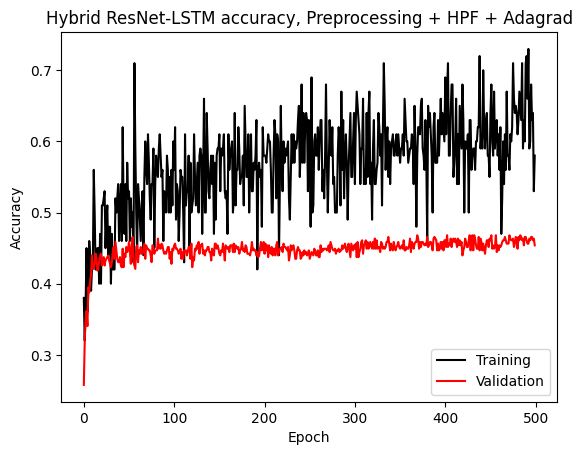

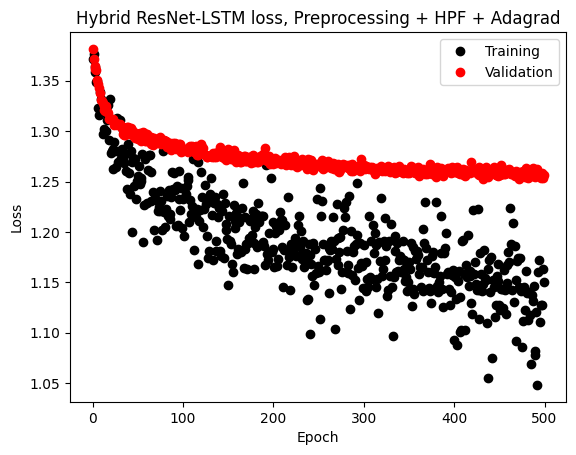

In [ ]:
#Update arrays and titles
plt.plot(np.arange(num_epochs),train_history_7,label='Training',color='k')
plt.plot(np.arange(num_epochs),val_history_7,label='Validation',color='r')
plt.title('Hybrid ResNet-LSTM accuracy, Preprocessing + HPF + Adagrad')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(np.arange(num_epochs),train_loss_hist_7,'o',label='Training',color='k')
plt.plot(np.arange(num_epochs),val_loss_hist_7,'o',label='Validation',color='r')
plt.title('Hybrid ResNet-LSTM loss, Preprocessing + HPF + Adagrad')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
#Model 4 achieved the best validation accuracy. Test on test dataset.
model4.eval()
test_count = 0
test_correct_count = 0
with torch.no_grad():
    test_x = x_test
    test_y = y_test
    logits = model4(test_x).detach()
    logits = nn.functional.softmax(logits)
    test_loss = criterion(logits.float(), test_y.float())
    with torch.no_grad():
        y_hat = torch.argmax(logits, dim=1)
        test_correct_count = torch.sum(y_hat == torch.argmax(test_y, dim=1))
        test_count = float(test_x.size(0))
test_acc = test_correct_count / test_count
print('Test accuracy of the hybrid ResNet-LSTM model: ', test_acc.item())

Test accuracy of the hybrid ResNet-LSTM model:  0.496614009141922


<ipython-input-19-b06d6d618dc5>:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = nn.functional.softmax(logits)
